In [1]:
import SCOTCH
import pandas as pd 
import numpy as np 
import anndata as ad
import scanpy as sc
import pooch
import pyEnrichAnalyzer

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec

### Loading single cell data 

SCOTCH allows loading through three interfaces, plain text files, anndata objects, or pytorch pt. files. For this example we will work with the exampledata scat is used for the scverse and scanpy tutorials. The data that are using is the 2021 NeurIPS benchmarking dataset. The samples used in this data were measured with the 10X multiome gene expression and chromatin accessibility kit. We will focus on the filtered expression matrices. That data contains ~16,000 from two different donors and span 36,601 genes. 

For this tutorial we utilize the beginning of the guide for scanpy which downloads the data into a standard adata object (adata). 

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())

/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/Pytorch/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


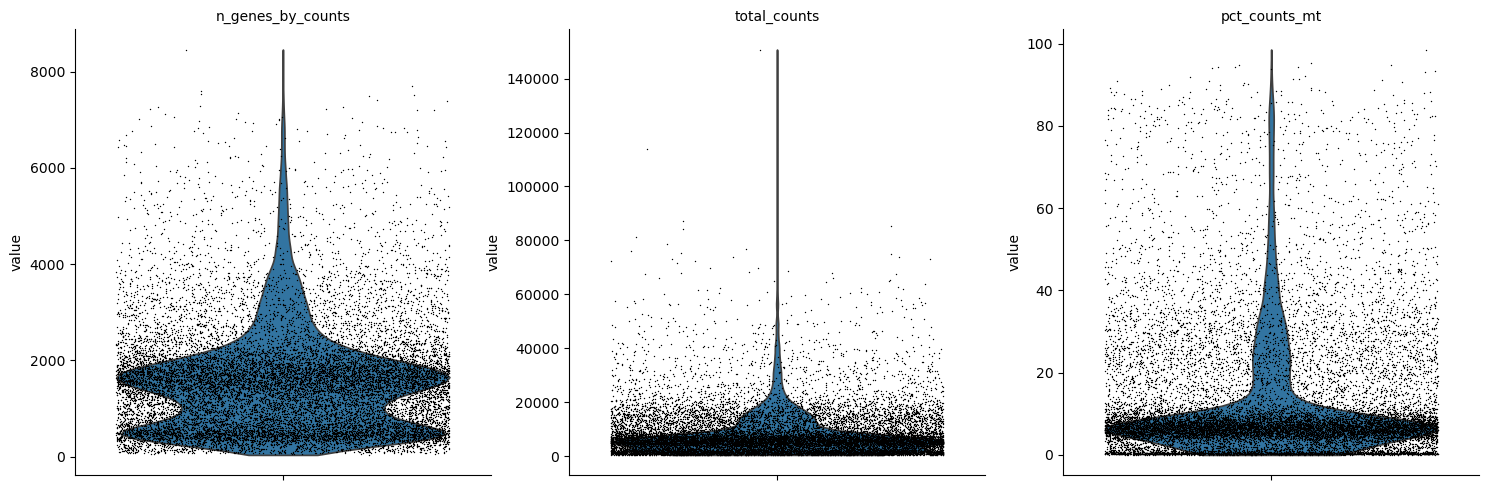

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

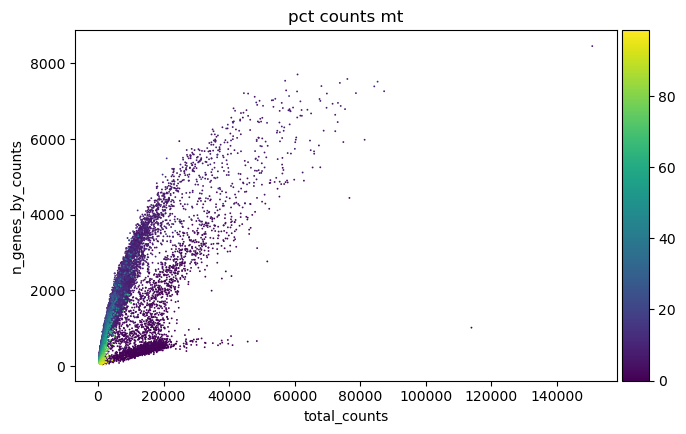

In [5]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.scrublet(adata, batch_key="sample")

In [7]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
adata_high_var= adata[:, adata.var["highly_variable"]]

### Initializing a SCOTCH object

Now we can initialize SCOTCH. SCOTCH is a matrix tri factorization approach that estimates the data as multiplication of three matrices. 

$X \approx U S V^{T}$ where $U$ is a near orthogonal matrix which is used to cluster the cell space, $V$ is a near orthogonal matrix which is used to cluster the gene space, and $S$ is relationship matrix which relates gene and cell clusters. 

To start SCOTCH we need to initialize a SCOTCH object, and specify the number of cluster we want to use for the cell space (k1), and the number of cluster for the gene space (k2). We can also specify regularization parameters such as $\lambda_u$ or $\lambda_v$ which can be tuned to improve the orthogonality of the cell and gene clusters respectively. 


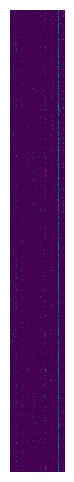

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
X_dense = adata_high_var.X.toarray() if hasattr(adata_high_var.X, 'toarray') else adata_high_var.X
ax.imshow(X_dense, interpolation="nearest", cmap = 'viridis')
ax.set_axis_off()

In [10]:
scotch = SCOTCH.SCOTCH(k1 = 2, k2 = 3, max_l_u = 0.10, max_l_v = 0.10, term_tol = 1e-2, var_lambda= False, device = "cpu", init_style= "random", verbose = True)
scotch.add_data_from_adata(adata_high_var)
#scotch.send_to_gpu()


In [11]:
scotch.fit()

Initializing NMTF factors
Beginning NMTF
Iter: 1	Iter Time: 1.155	Total Time: 1.155	Objective: 2.608e+06	Relative Delta Objective: 3.755e-01	Reconstruction Error: 2.608e+06
Iter: 2	Iter Time: 0.648	Total Time: 1.803	Objective: 2.358e+06	Relative Delta Objective: 9.561e-02	Reconstruction Error: 2.358e+06
Iter: 3	Iter Time: 0.651	Total Time: 2.454	Objective: 2.353e+06	Relative Delta Objective: 2.221e-03	Reconstruction Error: 2.353e+06


In [12]:
scotch.send_to_cpu()
scotch.assign_cluster()
adata_high_var = scotch.add_scotch_embeddings_to_adata(adata_high_var)

/Users/shalberg/Desktop/SCOTCH/SCOTCH.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[prefix + 'cell_clusters'] = pd.Categorical(self.U_assign.detach().numpy())


In [13]:
adata_high_var


AnnData object with n_obs × n_vars = 17041 × 2000
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'cell_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'gene_clusters'
    uns: 'log1p', 'hvg', 'S_matrix', 'reconstruction_error', 'error'
    obsm: 'cell_embedding', 'P_embedding'
    varm: 'gene_embedding', 'Q_embedding'
    layers: 'counts'

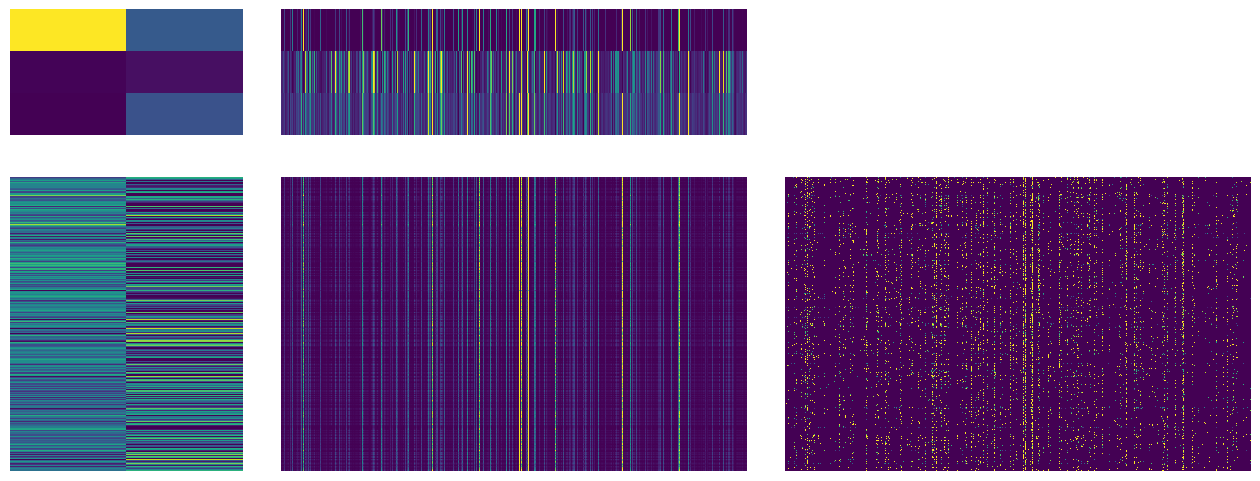

In [14]:
scotch.visualize_factors(max_u = 1, max_v= 0.1, max_x = 0.1)

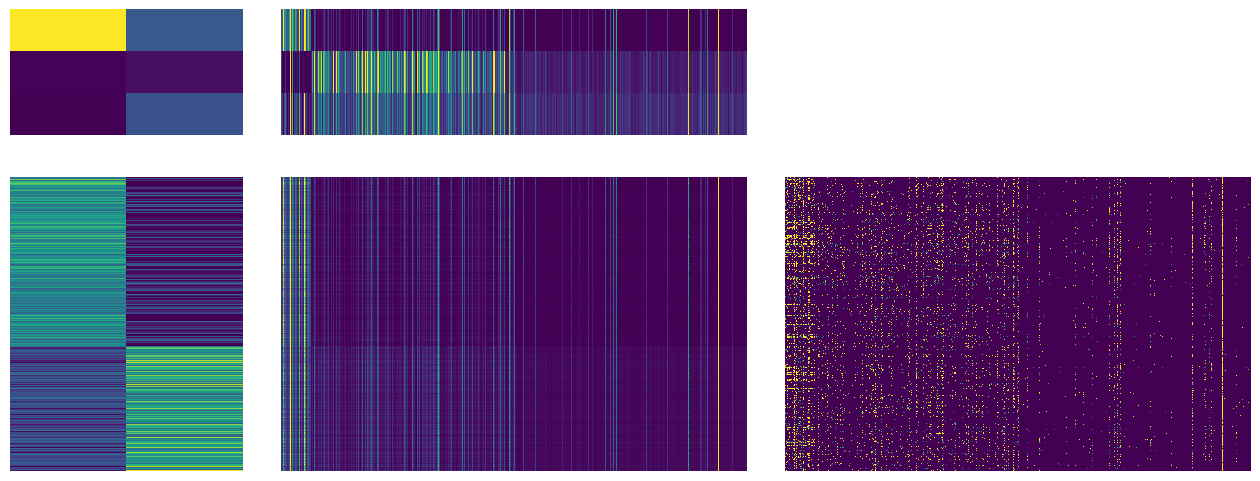

In [15]:
scotch.visualize_factors_sorted(max_v = 0.1, max_x = 0.1)

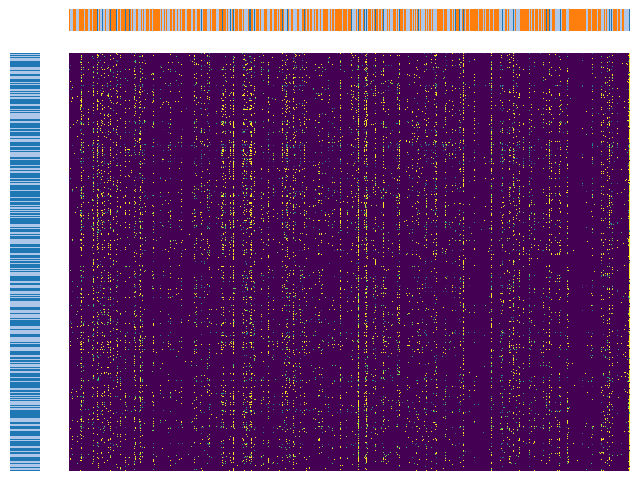

In [16]:
scotch.visualize_clusters(max_x = 0.1)

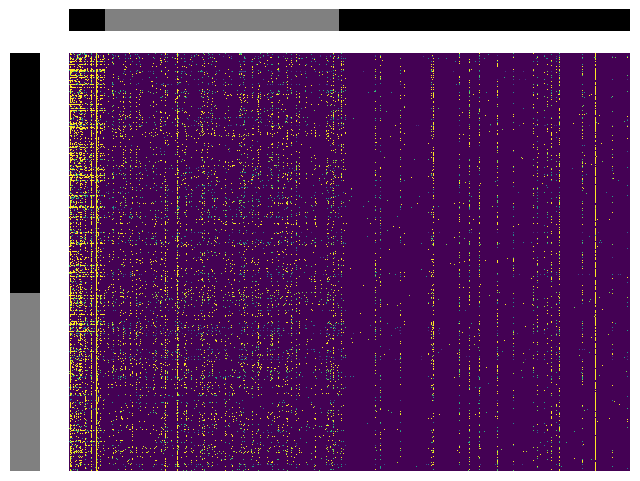

In [17]:
scotch.visualize_clusters_sorted(max_x = 0.1)

In [18]:
sc.pp.pca(adata_high_var) 

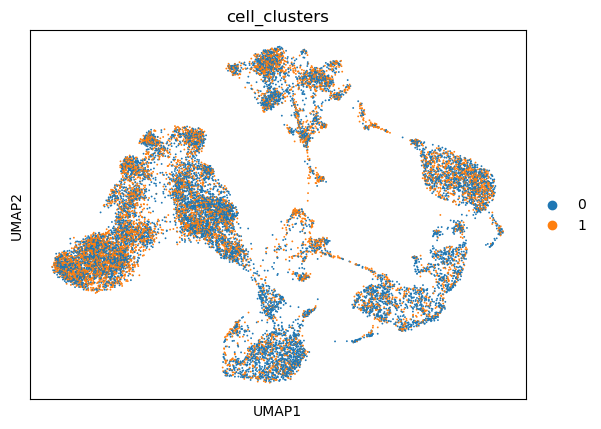

In [19]:
sc.pp.neighbors(adata_high_var, use_rep= "X_pca", metric = "cosine")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

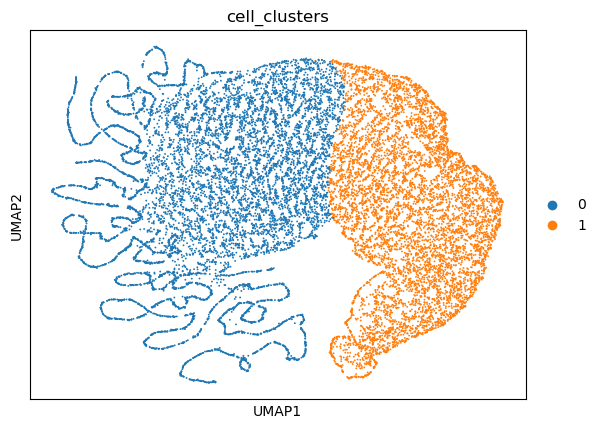

In [20]:
sc.pp.neighbors(adata_high_var, use_rep= "cell_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

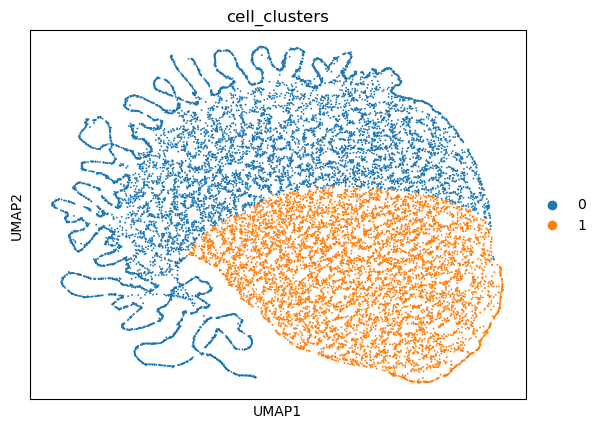

In [21]:
sc.pp.neighbors(adata_high_var, use_rep= "P_embedding")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [22]:
EA = pyEnrichAnalyzer.Framework()
EA.runEnrichAnalyzer(adata_high_var.var.to_dict(orient='index'), "gene_cluster", adata_high_var.var_names.to_list(),  )


TypeError: runEnrichAnalyzer(): incompatible function arguments. The following argument types are supported:
    1. (self: pyEnrichAnalyzer.Framework, arg0: dict, arg1: str, arg2: list, arg3: str, arg4: object, arg5: str) -> list

Invoked with: <pyEnrichAnalyzer.Framework object at 0x42fa95df0>, {'ISG15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4177, 'mean_counts': 0.4072408676147461, 'log1p_mean_counts': 0.3416309654712677, 'pct_dropout_by_counts': 75.60875912408758, 'total_counts': 6974.0, 'log1p_total_counts': 8.85008716583252, 'n_cells': 4177, 'highly_variable': True, 'means': 0.305498196060197, 'dispersions': 1.2442262032685547, 'dispersions_norm': 0.8011543154716492, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C1QTNF12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 62, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.63795620437956, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 62, 'highly_variable': True, 'means': 0.004953506491674374, 'dispersions': 1.2185655810285976, 'dispersions_norm': 0.9751714468002319, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL162741.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 26, 'highly_variable': True, 'means': 0.002219289223279258, 'dispersions': 1.4109469636652805, 'dispersions_norm': 1.295458197593689, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LINC01786': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.002296062599013213, 'dispersions': 1.165880479720692, 'dispersions_norm': 0.8924376368522644, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL391244.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 73, 'mean_counts': 0.004437956027686596, 'log1p_mean_counts': 0.004428137559443712, 'pct_dropout_by_counts': 99.57372262773723, 'total_counts': 76.0, 'log1p_total_counts': 4.343805313110352, 'n_cells': 73, 'highly_variable': True, 'means': 0.004989574816341191, 'dispersions': 1.176431009952419, 'dispersions_norm': 0.9057372808456421, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MMP23B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 313, 'mean_counts': 0.02037956193089485, 'log1p_mean_counts': 0.020174678415060043, 'pct_dropout_by_counts': 98.17226277372264, 'total_counts': 349.0, 'log1p_total_counts': 5.857933044433594, 'n_cells': 313, 'highly_variable': True, 'means': 0.031620301821058044, 'dispersions': 1.1522677448291958, 'dispersions_norm': 0.8670629262924194, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TMEM52': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 47, 'highly_variable': True, 'means': 0.004193910722029207, 'dispersions': 1.283622035408559, 'dispersions_norm': 1.0840423107147217, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL513477.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 48, 'highly_variable': True, 'means': 0.004237485000842277, 'dispersions': 1.6160351444995977, 'dispersions_norm': 1.6356844902038574, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PLCH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 267, 'mean_counts': 0.016700729727745056, 'log1p_mean_counts': 0.01656280644237995, 'pct_dropout_by_counts': 98.44087591240876, 'total_counts': 286.0, 'log1p_total_counts': 5.659482002258301, 'n_cells': 267, 'highly_variable': True, 'means': 0.032746654079761454, 'dispersions': 1.3179309829853447, 'dispersions_norm': 1.1424118280410767, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PER3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 299, 'mean_counts': 0.019562043249607086, 'log1p_mean_counts': 0.01937316544353962, 'pct_dropout_by_counts': 98.25401459854015, 'total_counts': 335.0, 'log1p_total_counts': 5.817111015319824, 'n_cells': 299, 'highly_variable': True, 'means': 0.025992165657428935, 'dispersions': 1.130617593364747, 'dispersions_norm': 0.8309324383735657, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TNFRSF9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 199, 'mean_counts': 0.013839416205883026, 'log1p_mean_counts': 0.013744525611400604, 'pct_dropout_by_counts': 98.83795620437957, 'total_counts': 237.0, 'log1p_total_counts': 5.472270488739014, 'n_cells': 199, 'highly_variable': True, 'means': 0.021930829329995058, 'dispersions': 1.2029621886390507, 'dispersions_norm': 0.9510979652404785, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL034417.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 41, 'highly_variable': True, 'means': 0.0035928171459468105, 'dispersions': 1.2893797654418582, 'dispersions_norm': 1.0920579433441162, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTOR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1217, 'mean_counts': 0.08145985752344131, 'log1p_mean_counts': 0.07831184566020966, 'pct_dropout_by_counts': 92.8934306569343, 'total_counts': 1395.0, 'log1p_total_counts': 7.241366386413574, 'n_cells': 1217, 'highly_variable': True, 'means': 0.08606974644576564, 'dispersions': 1.156460677809513, 'dispersions_norm': 0.8740423321723938, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL021155.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2550, 'mean_counts': 0.22294890880584717, 'log1p_mean_counts': 0.20126508176326752, 'pct_dropout_by_counts': 85.10948905109488, 'total_counts': 3818.0, 'log1p_total_counts': 8.247743606567383, 'n_cells': 2550, 'highly_variable': True, 'means': 0.24032176283781506, 'dispersions': 1.5350280359847042, 'dispersions_norm': 1.424161672592163, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL096840.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0009879160762030635, 'dispersions': 1.1181159497779798, 'dispersions_norm': 0.8100545406341553, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VPS13D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2052, 'mean_counts': 0.14020438492298126, 'log1p_mean_counts': 0.13120752573013306, 'pct_dropout_by_counts': 88.01751824817518, 'total_counts': 2401.0, 'log1p_total_counts': 7.784057140350342, 'n_cells': 2052, 'highly_variable': True, 'means': 0.17038558485894112, 'dispersions': 1.1892365460735115, 'dispersions_norm': 0.9292457699775696, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AL031283.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 51, 'highly_variable': True, 'means': 0.005138387375713414, 'dispersions': 1.2746431161156484, 'dispersions_norm': 1.071711778640747, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SPEN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4062, 'mean_counts': 0.35871532559394836, 'log1p_mean_counts': 0.3065396249294281, 'pct_dropout_by_counts': 76.28029197080292, 'total_counts': 6143.0, 'log1p_total_counts': 8.723231315612793, 'n_cells': 4061, 'highly_variable': True, 'means': 0.33817856914077515, 'dispersions': 1.3558263828863317, 'dispersions_norm': 1.0306241512298584, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01772': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 188, 'mean_counts': 0.011386861093342304, 'log1p_mean_counts': 0.011322518810629845, 'pct_dropout_by_counts': 98.9021897810219, 'total_counts': 195.0, 'log1p_total_counts': 5.2781147956848145, 'n_cells': 188, 'highly_variable': True, 'means': 0.01795762303195532, 'dispersions': 1.3043264971132675, 'dispersions_norm': 1.1186643838882446, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01783': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008478715544011095, 'dispersions': 0.8172549961597178, 'dispersions_norm': 0.7977367639541626, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PADI4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1261, 'mean_counts': 0.12671533226966858, 'log1p_mean_counts': 0.11930661648511887, 'pct_dropout_by_counts': 92.63649635036496, 'total_counts': 2170.0, 'log1p_total_counts': 7.682943344116211, 'n_cells': 1261, 'highly_variable': True, 'means': 0.10808653099859884, 'dispersions': 1.2460748364912684, 'dispersions_norm': 1.0224192142486572, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'UBR4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2378, 'mean_counts': 0.1697518229484558, 'log1p_mean_counts': 0.15679161250591278, 'pct_dropout_by_counts': 86.11386861313869, 'total_counts': 2907.0, 'log1p_total_counts': 7.975220680236816, 'n_cells': 2378, 'highly_variable': True, 'means': 0.18154316388465855, 'dispersions': 1.3696267054112992, 'dispersions_norm': 1.226525902748108, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'NBPF3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 202, 'mean_counts': 0.01214598584920168, 'log1p_mean_counts': 0.01207281555980444, 'pct_dropout_by_counts': 98.82043795620437, 'total_counts': 208.0, 'log1p_total_counts': 5.342334270477295, 'n_cells': 202, 'highly_variable': True, 'means': 0.016811095607056407, 'dispersions': 1.3068089032717105, 'dispersions_norm': 1.1217930316925049, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C1QA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.00940146017819643, 'log1p_mean_counts': 0.009357541799545288, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 161.0, 'log1p_total_counts': 5.087596416473389, 'n_cells': 52, 'highly_variable': True, 'means': 0.006594779048752551, 'dispersions': 1.5749489410733553, 'dispersions_norm': 1.5668977499008179, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'C1QC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 7, 'highly_variable': True, 'means': 0.0008820852985306881, 'dispersions': 1.3784760992740022, 'dispersions_norm': 1.244055986404419, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C1QB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0033284672535955906, 'log1p_mean_counts': 0.0033229400869458914, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 57.0, 'log1p_total_counts': 4.060442924499512, 'n_cells': 19, 'highly_variable': True, 'means': 0.0020983622354268957, 'dispersions': 1.4624314915329646, 'dispersions_norm': 1.3793237209320068, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01355': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 199, 'mean_counts': 0.012788320891559124, 'log1p_mean_counts': 0.012707240879535675, 'pct_dropout_by_counts': 98.83795620437957, 'total_counts': 219.0, 'log1p_total_counts': 5.393627643585205, 'n_cells': 199, 'highly_variable': True, 'means': 0.016536221880090164, 'dispersions': 1.296492416732987, 'dispersions_norm': 1.1054813861846924, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF436': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 136, 'mean_counts': 0.008408758789300919, 'log1p_mean_counts': 0.008373602293431759, 'pct_dropout_by_counts': 99.2058394160584, 'total_counts': 144.0, 'log1p_total_counts': 4.976733684539795, 'n_cells': 136, 'highly_variable': True, 'means': 0.009759163571167743, 'dispersions': 1.136923109034825, 'dispersions_norm': 0.8415125012397766, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ID3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1875, 'mean_counts': 0.2044379562139511, 'log1p_mean_counts': 0.18601302802562714, 'pct_dropout_by_counts': 89.05109489051095, 'total_counts': 3501.0, 'log1p_total_counts': 8.161089897155762, 'n_cells': 1875, 'highly_variable': True, 'means': 0.17716730614423742, 'dispersions': 1.3772947499140586, 'dispersions_norm': 1.2395129203796387, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL031432.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 55, 'mean_counts': 0.0032116789370775223, 'log1p_mean_counts': 0.003206532448530197, 'pct_dropout_by_counts': 99.67883211678831, 'total_counts': 55.0, 'log1p_total_counts': 4.025351524353027, 'n_cells': 55, 'highly_variable': True, 'means': 0.00410355114375529, 'dispersions': 1.3872925538458296, 'dispersions_norm': 1.2563313245773315, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL031280.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 715, 'mean_counts': 0.0462481752038002, 'log1p_mean_counts': 0.04521059989929199, 'pct_dropout_by_counts': 95.82481751824817, 'total_counts': 792.0, 'log1p_total_counts': 6.675823211669922, 'n_cells': 715, 'highly_variable': True, 'means': 0.06361474769701642, 'dispersions': 1.152434675405292, 'dispersions_norm': 0.8673470616340637, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'STMN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3820, 'mean_counts': 1.3162044286727905, 'log1p_mean_counts': 0.8399298191070557, 'pct_dropout_by_counts': 77.69343065693431, 'total_counts': 22540.0, 'log1p_total_counts': 10.023091316223145, 'n_cells': 3819, 'highly_variable': True, 'means': 0.46198087423765305, 'dispersions': 2.022153978998279, 'dispersions_norm': 2.146792411804199, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ZNF683': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 215, 'mean_counts': 0.019854014739394188, 'log1p_mean_counts': 0.0196594949811697, 'pct_dropout_by_counts': 98.74452554744526, 'total_counts': 340.0, 'log1p_total_counts': 5.831882476806641, 'n_cells': 215, 'highly_variable': True, 'means': 0.03190048646932215, 'dispersions': 1.1655994039565902, 'dispersions_norm': 0.8882051110267639, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL512408.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0019850776886455174, 'dispersions': 1.5207740760832151, 'dispersions_norm': 1.474958062171936, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SFN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001733959990328807, 'dispersions': 1.542842983049791, 'dispersions_norm': 1.5131698846817017, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL360012.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1783, 'mean_counts': 0.15299269556999207, 'log1p_mean_counts': 0.14236091077327728, 'pct_dropout_by_counts': 89.58832116788321, 'total_counts': 2620.0, 'log1p_total_counts': 7.871311187744141, 'n_cells': 1783, 'highly_variable': True, 'means': 0.1795298780042741, 'dispersions': 1.587661980584873, 'dispersions_norm': 1.589558720588684, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL136115.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 52, 'highly_variable': True, 'means': 0.0033055439780873197, 'dispersions': 1.3252908232695142, 'dispersions_norm': 1.1530529260635376, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DCDC2B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.002311116480294337, 'dispersions': 1.3872543720304993, 'dispersions_norm': 1.2570044994354248, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'S100PBP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1872, 'mean_counts': 0.1393868625164032, 'log1p_mean_counts': 0.1304902732372284, 'pct_dropout_by_counts': 89.06861313868613, 'total_counts': 2387.0, 'log1p_total_counts': 7.77821159362793, 'n_cells': 1872, 'highly_variable': True, 'means': 0.13806150294557937, 'dispersions': 1.1727867639447878, 'dispersions_norm': 0.9008420705795288, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AZIN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 183, 'mean_counts': 0.011445255018770695, 'log1p_mean_counts': 0.011380253359675407, 'pct_dropout_by_counts': 98.93138686131387, 'total_counts': 196.0, 'log1p_total_counts': 5.283203601837158, 'n_cells': 183, 'highly_variable': True, 'means': 0.015086564378558192, 'dispersions': 1.1139321667496696, 'dispersions_norm': 0.8033435344696045, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KIAA0319L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1751, 'mean_counts': 0.12887591123580933, 'log1p_mean_counts': 0.1212223693728447, 'pct_dropout_by_counts': 89.77518248175183, 'total_counts': 2207.0, 'log1p_total_counts': 7.69984245300293, 'n_cells': 1750, 'highly_variable': True, 'means': 0.1408909672750044, 'dispersions': 1.1293826412150083, 'dispersions_norm': 0.8289861083030701, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TFAP2E': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 49, 'highly_variable': True, 'means': 0.003429652921918995, 'dispersions': 1.130926705652663, 'dispersions_norm': 0.8309001922607422, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CSF3R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1981, 'mean_counts': 0.384175181388855, 'log1p_mean_counts': 0.32510441541671753, 'pct_dropout_by_counts': 88.43211678832117, 'total_counts': 6579.0, 'log1p_total_counts': 8.791790008544922, 'n_cells': 1980, 'highly_variable': True, 'means': 0.286445233791587, 'dispersions': 1.6938809839476587, 'dispersions_norm': 1.668371558189392, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'POU3F1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 392, 'mean_counts': 0.027970802038908005, 'log1p_mean_counts': 0.027586763724684715, 'pct_dropout_by_counts': 97.71094890510949, 'total_counts': 479.0, 'log1p_total_counts': 6.173786163330078, 'n_cells': 392, 'highly_variable': True, 'means': 0.03700488909336013, 'dispersions': 1.2680238994655926, 'dispersions_norm': 1.0600372552871704, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MACF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6661, 'mean_counts': 0.745226263999939, 'log1p_mean_counts': 0.556884229183197, 'pct_dropout_by_counts': 61.1036496350365, 'total_counts': 12762.0, 'log1p_total_counts': 9.454305648803711, 'n_cells': 6660, 'highly_variable': True, 'means': 0.7273517647630534, 'dispersions': 1.719071012364354, 'dispersions_norm': 1.1790663003921509, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL356055.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0011786521604063216, 'dispersions': 1.1858280926009288, 'dispersions_norm': 0.926082193851471, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL603839.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 56, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.67299270072992, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 56, 'highly_variable': True, 'means': 0.005511713669451463, 'dispersions': 1.4543724202951636, 'dispersions_norm': 1.367760419845581, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RIMS3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 257, 'mean_counts': 0.019620437175035477, 'log1p_mean_counts': 0.019430438056588173, 'pct_dropout_by_counts': 98.4992700729927, 'total_counts': 336.0, 'log1p_total_counts': 5.820083141326904, 'n_cells': 257, 'highly_variable': True, 'means': 0.021688961179011552, 'dispersions': 1.1251705230912687, 'dispersions_norm': 0.8220239281654358, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL512353.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 275, 'mean_counts': 0.017985401675105095, 'log1p_mean_counts': 0.017825577408075333, 'pct_dropout_by_counts': 98.3941605839416, 'total_counts': 308.0, 'log1p_total_counts': 5.733341217041016, 'n_cells': 275, 'highly_variable': True, 'means': 0.011023226553773661, 'dispersions': 1.1507912646226806, 'dispersions_norm': 0.8658069968223572, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC2A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3492, 'mean_counts': 0.6335766315460205, 'log1p_mean_counts': 0.4907718598842621, 'pct_dropout_by_counts': 79.6087591240876, 'total_counts': 10850.0, 'log1p_total_counts': 9.292012214660645, 'n_cells': 3492, 'highly_variable': True, 'means': 0.31864489789470557, 'dispersions': 1.7252870623858398, 'dispersions_norm': 1.8180694580078125, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PTPRF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 184, 'mean_counts': 0.01226277370005846, 'log1p_mean_counts': 0.012188195250928402, 'pct_dropout_by_counts': 98.92554744525548, 'total_counts': 210.0, 'log1p_total_counts': 5.351858139038086, 'n_cells': 184, 'highly_variable': True, 'means': 0.013214614405488339, 'dispersions': 1.3814098529525944, 'dispersions_norm': 1.2469907999038696, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PLK3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2494, 'mean_counts': 0.21021898090839386, 'log1p_mean_counts': 0.19080132246017456, 'pct_dropout_by_counts': 85.43649635036496, 'total_counts': 3600.0, 'log1p_total_counts': 8.188966751098633, 'n_cells': 2494, 'highly_variable': True, 'means': 0.22168294158208046, 'dispersions': 1.1816006124562304, 'dispersions_norm': 0.9167279005050659, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTCH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1096, 'mean_counts': 0.08490511029958725, 'log1p_mean_counts': 0.08149252831935883, 'pct_dropout_by_counts': 93.6, 'total_counts': 1454.0, 'log1p_total_counts': 7.282761096954346, 'n_cells': 1096, 'highly_variable': True, 'means': 0.1010426308584749, 'dispersions': 1.4738062067330255, 'dispersions_norm': 1.399897575378418, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TMEM275': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0008358111936356216, 'dispersions': 1.1902718723741872, 'dispersions_norm': 0.9281179904937744, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PODN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 14, 'highly_variable': True, 'means': 0.0020089767006896343, 'dispersions': 1.1461516082961902, 'dispersions_norm': 0.860544741153717, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC1A7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 40, 'highly_variable': True, 'means': 0.004572416529017183, 'dispersions': 1.3531115749337927, 'dispersions_norm': 1.2006919384002686, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TTC22': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 151, 'mean_counts': 0.009518248029053211, 'log1p_mean_counts': 0.009473235346376896, 'pct_dropout_by_counts': 99.11824817518247, 'total_counts': 163.0, 'log1p_total_counts': 5.0998663902282715, 'n_cells': 151, 'highly_variable': True, 'means': 0.014277354980197061, 'dispersions': 1.2551076762432603, 'dispersions_norm': 1.0372217893600464, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LEXM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 32, 'highly_variable': True, 'means': 0.00470799058804776, 'dispersions': 1.6535754734719381, 'dispersions_norm': 1.6975865364074707, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DAB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 34, 'highly_variable': True, 'means': 0.004201493661759929, 'dispersions': 1.2759583937160657, 'dispersions_norm': 1.071803092956543, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'JUN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12458, 'mean_counts': 8.772613525390625, 'log1p_mean_counts': 2.2795839309692383, 'pct_dropout_by_counts': 27.252554744525547, 'total_counts': 150231.0, 'log1p_total_counts': 11.919936180114746, 'n_cells': 12441, 'highly_variable': True, 'means': 2.3459133614275025, 'dispersions': 2.773015754504848, 'dispersions_norm': 1.132401943206787, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'NFIA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2622, 'mean_counts': 0.6418685913085938, 'log1p_mean_counts': 0.49583497643470764, 'pct_dropout_by_counts': 84.68905109489052, 'total_counts': 10992.0, 'log1p_total_counts': 9.305013656616211, 'n_cells': 2622, 'highly_variable': True, 'means': 0.25669297230935023, 'dispersions': 1.6566964355275817, 'dispersions_norm': 1.6207257509231567, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'EFCAB7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 403, 'mean_counts': 0.024817518889904022, 'log1p_mean_counts': 0.024514567106962204, 'pct_dropout_by_counts': 97.64671532846715, 'total_counts': 425.0, 'log1p_total_counts': 6.054439544677734, 'n_cells': 403, 'highly_variable': True, 'means': 0.02863367146738652, 'dispersions': 1.2266910235479402, 'dispersions_norm': 0.9919122457504272, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01359': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 51, 'highly_variable': True, 'means': 0.0035363739325066776, 'dispersions': 1.176003085122596, 'dispersions_norm': 0.9052139520645142, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC103591.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2394, 'mean_counts': 0.2509196996688843, 'log1p_mean_counts': 0.22387903928756714, 'pct_dropout_by_counts': 86.02043795620438, 'total_counts': 4297.0, 'log1p_total_counts': 8.365904808044434, 'n_cells': 2394, 'highly_variable': True, 'means': 0.22494260585840264, 'dispersions': 1.261771615721646, 'dispersions_norm': 1.0488823652267456, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01781': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 251, 'mean_counts': 0.030832117423415184, 'log1p_mean_counts': 0.030366357415914536, 'pct_dropout_by_counts': 98.53430656934307, 'total_counts': 528.0, 'log1p_total_counts': 6.270988464355469, 'n_cells': 251, 'highly_variable': True, 'means': 0.030033298389969078, 'dispersions': 1.2681119707947959, 'dispersions_norm': 1.0596392154693604, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LPAR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0010483619621269693, 'dispersions': 1.258229003065899, 'dispersions_norm': 1.045430064201355, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MCOLN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 387, 'mean_counts': 0.027678832411766052, 'log1p_mean_counts': 0.0273026991635561, 'pct_dropout_by_counts': 97.74014598540145, 'total_counts': 474.0, 'log1p_total_counts': 6.1633148193359375, 'n_cells': 387, 'highly_variable': True, 'means': 0.03857584567620084, 'dispersions': 1.2718381831157282, 'dispersions_norm': 1.0651369094848633, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PKN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3815, 'mean_counts': 0.31491971015930176, 'log1p_mean_counts': 0.2737756073474884, 'pct_dropout_by_counts': 77.72262773722628, 'total_counts': 5393.0, 'log1p_total_counts': 8.593042373657227, 'n_cells': 3814, 'highly_variable': True, 'means': 0.28849624680930397, 'dispersions': 1.24582994145493, 'dispersions_norm': 0.8071799874305725, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1365, 'mean_counts': 0.11375182121992111, 'log1p_mean_counts': 0.10773433744907379, 'pct_dropout_by_counts': 92.02919708029196, 'total_counts': 1948.0, 'log1p_total_counts': 7.575071811676025, 'n_cells': 1365, 'highly_variable': True, 'means': 0.10702742121440503, 'dispersions': 1.1749435530322774, 'dispersions_norm': 0.9060564637184143, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GBP5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1546, 'mean_counts': 0.1204671561717987, 'log1p_mean_counts': 0.11374570429325104, 'pct_dropout_by_counts': 90.97226277372262, 'total_counts': 2063.0, 'log1p_total_counts': 7.632400989532471, 'n_cells': 1546, 'highly_variable': True, 'means': 0.16972077435571575, 'dispersions': 1.4757749889755702, 'dispersions_norm': 1.4033945798873901, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TGFBR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 849, 'mean_counts': 0.06487591564655304, 'log1p_mean_counts': 0.06285828351974487, 'pct_dropout_by_counts': 95.04233576642336, 'total_counts': 1111.0, 'log1p_total_counts': 7.013915538787842, 'n_cells': 849, 'highly_variable': True, 'means': 0.10457185581249015, 'dispersions': 1.4557613870184616, 'dispersions_norm': 1.3710856437683105, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TLCD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1734, 'mean_counts': 0.409109503030777, 'log1p_mean_counts': 0.3429579436779022, 'pct_dropout_by_counts': 89.87445255474452, 'total_counts': 7006.0, 'log1p_total_counts': 8.85466480255127, 'n_cells': 1733, 'highly_variable': True, 'means': 0.13743673035798834, 'dispersions': 1.2710123739284742, 'dispersions_norm': 1.0647172927856445, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC092802.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 108, 'mean_counts': 0.006890511140227318, 'log1p_mean_counts': 0.006866880226880312, 'pct_dropout_by_counts': 99.36934306569343, 'total_counts': 118.0, 'log1p_total_counts': 4.779123306274414, 'n_cells': 108, 'highly_variable': True, 'means': 0.005533983850824056, 'dispersions': 1.1193203674091863, 'dispersions_norm': 0.8142147660255432, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LRRC39': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 38, 'highly_variable': True, 'means': 0.003680683497039855, 'dispersions': 1.1896260747631544, 'dispersions_norm': 0.929850697517395, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL445928.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001525720272208624, 'dispersions': 1.5563045602499375, 'dispersions_norm': 1.5340806245803833, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RTCA-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 717, 'mean_counts': 0.05086131393909454, 'log1p_mean_counts': 0.04961012676358223, 'pct_dropout_by_counts': 95.81313868613138, 'total_counts': 871.0, 'log1p_total_counts': 6.770789623260498, 'n_cells': 717, 'highly_variable': True, 'means': 0.047681719591157634, 'dispersions': 1.2239127237749692, 'dispersions_norm': 0.9850893020629883, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GPR88': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.000602041351398589, 'dispersions': 1.1877445697247127, 'dispersions_norm': 0.9247790575027466, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VCAM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.005372262559831142, 'log1p_mean_counts': 0.005357883404940367, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 92.0, 'log1p_total_counts': 4.532599449157715, 'n_cells': 47, 'highly_variable': True, 'means': 0.007381671016771646, 'dispersions': 1.630131120744207, 'dispersions_norm': 1.6570641994476318, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RNPC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2180, 'mean_counts': 0.151532843708992, 'log1p_mean_counts': 0.14109396934509277, 'pct_dropout_by_counts': 87.27007299270073, 'total_counts': 2595.0, 'log1p_total_counts': 7.861727237701416, 'n_cells': 2179, 'highly_variable': True, 'means': 0.1769093013425558, 'dispersions': 1.2496358566879633, 'dispersions_norm': 1.028699517250061, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL160171.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 48, 'highly_variable': True, 'means': 0.004112340145712719, 'dispersions': 1.1548075163219607, 'dispersions_norm': 0.8712578415870667, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CELSR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 90, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.47445255474453, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 90, 'highly_variable': True, 'means': 0.0064111369926931365, 'dispersions': 1.2375218074524201, 'dispersions_norm': 1.007381796836853, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL355310.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0014715128056965033, 'dispersions': 1.41118826625706, 'dispersions_norm': 1.2935683727264404, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL603832.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013589498091202083, 'dispersions': 1.2159233783594465, 'dispersions_norm': 0.9726110696792603, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC16A1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 938, 'mean_counts': 0.07188320904970169, 'log1p_mean_counts': 0.06941711157560349, 'pct_dropout_by_counts': 94.52262773722627, 'total_counts': 1231.0, 'log1p_total_counts': 7.11639404296875, 'n_cells': 938, 'highly_variable': True, 'means': 0.08531392494822551, 'dispersions': 1.287429363573075, 'dispersions_norm': 1.0919493436813354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP4B1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 705, 'mean_counts': 0.04467153176665306, 'log1p_mean_counts': 0.043702512979507446, 'pct_dropout_by_counts': 95.88321167883211, 'total_counts': 765.0, 'log1p_total_counts': 6.641181945800781, 'n_cells': 705, 'highly_variable': True, 'means': 0.051655853063861876, 'dispersions': 1.162564843434477, 'dispersions_norm': 0.8841232061386108, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIPK1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1201, 'mean_counts': 0.09757664054632187, 'log1p_mean_counts': 0.09310469776391983, 'pct_dropout_by_counts': 92.98686131386862, 'total_counts': 1671.0, 'log1p_total_counts': 7.421775817871094, 'n_cells': 1200, 'highly_variable': True, 'means': 0.10591341407847057, 'dispersions': 1.187697489330934, 'dispersions_norm': 0.9269205331802368, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ATP1A1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 669, 'mean_counts': 0.043678831309080124, 'log1p_mean_counts': 0.04275180771946907, 'pct_dropout_by_counts': 96.0934306569343, 'total_counts': 748.0, 'log1p_total_counts': 6.618739128112793, 'n_cells': 669, 'highly_variable': True, 'means': 0.054645169079372446, 'dispersions': 1.2420348173142144, 'dispersions_norm': 1.0159013271331787, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TENT5C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5082, 'mean_counts': 0.7151532769203186, 'log1p_mean_counts': 0.5395024418830872, 'pct_dropout_by_counts': 70.32408759124087, 'total_counts': 12247.0, 'log1p_total_counts': 9.413118362426758, 'n_cells': 5077, 'highly_variable': True, 'means': 0.39776383745471044, 'dispersions': 1.4172948387556192, 'dispersions_norm': 0.9232028722763062, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NBPF20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 173, 'mean_counts': 0.010686131194233894, 'log1p_mean_counts': 0.010629437863826752, 'pct_dropout_by_counts': 98.98978102189781, 'total_counts': 183.0, 'log1p_total_counts': 5.214935779571533, 'n_cells': 173, 'highly_variable': True, 'means': 0.014639968624287942, 'dispersions': 1.1782867024456944, 'dispersions_norm': 0.909213125705719, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CD160': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 573, 'mean_counts': 0.06049634888768196, 'log1p_mean_counts': 0.058737050741910934, 'pct_dropout_by_counts': 96.65401459854014, 'total_counts': 1036.0, 'log1p_total_counts': 6.944087028503418, 'n_cells': 573, 'highly_variable': True, 'means': 0.07107154060444441, 'dispersions': 1.2049846563970372, 'dispersions_norm': 0.9544557332992554, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ANKRD34A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.002686131279915571, 'log1p_mean_counts': 0.002682530088350177, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 46.0, 'log1p_total_counts': 3.8501474857330322, 'n_cells': 46, 'highly_variable': True, 'means': 0.004582909137559242, 'dispersions': 1.3744928815166664, 'dispersions_norm': 1.236530065536499, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC239799.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1181, 'mean_counts': 0.12163503468036652, 'log1p_mean_counts': 0.11478747427463531, 'pct_dropout_by_counts': 93.1036496350365, 'total_counts': 2083.0, 'log1p_total_counts': 7.642044544219971, 'n_cells': 1180, 'highly_variable': True, 'means': 0.11038165318155024, 'dispersions': 1.2661155941811142, 'dispersions_norm': 1.056894302368164, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC239799.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 67, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.60875912408758, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 67, 'highly_variable': True, 'means': 0.004232021533320157, 'dispersions': 1.1132436649614295, 'dispersions_norm': 0.8003803491592407, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PPIAL4G': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 195, 'mean_counts': 0.011854014359414577, 'log1p_mean_counts': 0.011784305796027184, 'pct_dropout_by_counts': 98.86131386861314, 'total_counts': 203.0, 'log1p_total_counts': 5.318120002746582, 'n_cells': 195, 'highly_variable': True, 'means': 0.02200833260718508, 'dispersions': 1.3939467346044796, 'dispersions_norm': 1.2661242485046387, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NOTCH2NLB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009989064825842867, 'dispersions': 1.2266137267534258, 'dispersions_norm': 0.9926338195800781, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HIST2H3D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 124, 'mean_counts': 0.007474452722817659, 'log1p_mean_counts': 0.00744665740057826, 'pct_dropout_by_counts': 99.27591240875913, 'total_counts': 128.0, 'log1p_total_counts': 4.859812259674072, 'n_cells': 124, 'highly_variable': True, 'means': 0.007770124427200673, 'dispersions': 1.1850215244993565, 'dispersions_norm': 0.9227580428123474, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CTSS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6283, 'mean_counts': 2.716029167175293, 'log1p_mean_counts': 1.3126556873321533, 'pct_dropout_by_counts': 63.310948905109484, 'total_counts': 46512.0, 'log1p_total_counts': 10.74748706817627, 'n_cells': 6277, 'highly_variable': True, 'means': 1.0880268959423969, 'dispersions': 2.815785870073919, 'dispersions_norm': 1.9128248691558838, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AL391335.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 15, 'highly_variable': True, 'means': 0.0017076209497158459, 'dispersions': 1.5135280216116742, 'dispersions_norm': 1.4708120822906494, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL450992.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.00472992705181241, 'log1p_mean_counts': 0.004718776326626539, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 81.0, 'log1p_total_counts': 4.406719207763672, 'n_cells': 78, 'highly_variable': True, 'means': 0.007261136513376064, 'dispersions': 1.3993764472573509, 'dispersions_norm': 1.2768666744232178, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'S100A11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5449, 'mean_counts': 1.5921168327331543, 'log1p_mean_counts': 0.95247483253479, 'pct_dropout_by_counts': 68.18102189781021, 'total_counts': 27265.0, 'log1p_total_counts': 10.213396072387695, 'n_cells': 5447, 'highly_variable': True, 'means': 0.7695612356248736, 'dispersions': 1.7963493699551778, 'dispersions_norm': 1.3181672096252441, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'HRNR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 3, 'highly_variable': True, 'means': 0.0006726554094719137, 'dispersions': 1.502598526750253, 'dispersions_norm': 1.4492671489715576, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'S100A9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5262, 'mean_counts': 16.357139587402344, 'log1p_mean_counts': 2.85400390625, 'pct_dropout_by_counts': 69.27299270072993, 'total_counts': 280116.0, 'log1p_total_counts': 12.542963027954102, 'n_cells': 5246, 'highly_variable': True, 'means': 2.464018809661364, 'dispersions': 5.181852716789918, 'dispersions_norm': 2.5451085567474365, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'S100A12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1607, 'mean_counts': 0.9383357763290405, 'log1p_mean_counts': 0.6618297696113586, 'pct_dropout_by_counts': 90.61605839416058, 'total_counts': 16069.0, 'log1p_total_counts': 9.684709548950195, 'n_cells': 1605, 'highly_variable': True, 'means': 0.5234929536690127, 'dispersions': 2.8445677840360686, 'dispersions_norm': 3.28619122505188, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'S100A8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3898, 'mean_counts': 10.736992835998535, 'log1p_mean_counts': 2.4627456665039062, 'pct_dropout_by_counts': 77.23795620437957, 'total_counts': 183871.0, 'log1p_total_counts': 12.121994972229004, 'n_cells': 3885, 'highly_variable': True, 'means': 2.121033205815413, 'dispersions': 4.929507806714325, 'dispersions_norm': 2.0812575817108154, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL358472.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 115, 'mean_counts': 0.006948905065655708, 'log1p_mean_counts': 0.006924872752279043, 'pct_dropout_by_counts': 99.32846715328468, 'total_counts': 119.0, 'log1p_total_counts': 4.787491798400879, 'n_cells': 115, 'highly_variable': True, 'means': 0.009463645934829597, 'dispersions': 1.2172622399110782, 'dispersions_norm': 0.9736416339874268, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATP8B2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1807, 'mean_counts': 0.1271824836730957, 'log1p_mean_counts': 0.11972114443778992, 'pct_dropout_by_counts': 89.44817518248175, 'total_counts': 2178.0, 'log1p_total_counts': 7.686621189117432, 'n_cells': 1806, 'highly_variable': True, 'means': 0.15928210327186182, 'dispersions': 1.2342159630060165, 'dispersions_norm': 1.0027852058410645, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HCN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 53, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.69051094890511, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 53, 'highly_variable': True, 'means': 0.004635507769856922, 'dispersions': 1.147616533184789, 'dispersions_norm': 0.8605563640594482, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MSTO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 581, 'mean_counts': 0.03696350380778313, 'log1p_mean_counts': 0.03629673644900322, 'pct_dropout_by_counts': 96.60729927007299, 'total_counts': 633.0, 'log1p_total_counts': 6.4520487785339355, 'n_cells': 581, 'highly_variable': True, 'means': 0.04094299263366314, 'dispersions': 1.1991395269890417, 'dispersions_norm': 0.9453797936439514, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL355388.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 36, 'highly_variable': True, 'means': 0.002818607119712553, 'dispersions': 1.255225349786453, 'dispersions_norm': 1.0392670631408691, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LMNA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1502, 'mean_counts': 0.39900729060173035, 'log1p_mean_counts': 0.3357629179954529, 'pct_dropout_by_counts': 91.22919708029197, 'total_counts': 6833.0, 'log1p_total_counts': 8.829665184020996, 'n_cells': 1502, 'highly_variable': True, 'means': 0.13294004103906076, 'dispersions': 1.2185549304039665, 'dispersions_norm': 0.9781418442726135, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SH2D2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 872, 'mean_counts': 0.059795621782541275, 'log1p_mean_counts': 0.058076079934835434, 'pct_dropout_by_counts': 94.9080291970803, 'total_counts': 1024.0, 'log1p_total_counts': 6.932447910308838, 'n_cells': 872, 'highly_variable': True, 'means': 0.07883516048346359, 'dispersions': 1.2075305300456616, 'dispersions_norm': 0.9588342905044556, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NTRK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 47, 'highly_variable': True, 'means': 0.003962199505463171, 'dispersions': 1.2819504145102463, 'dispersions_norm': 1.0793378353118896, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC02772': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1117, 'mean_counts': 0.1077372282743454, 'log1p_mean_counts': 0.10231940448284149, 'pct_dropout_by_counts': 93.47737226277373, 'total_counts': 1845.0, 'log1p_total_counts': 7.520776271820068, 'n_cells': 1117, 'highly_variable': True, 'means': 0.05908503781819485, 'dispersions': 1.3328853263765363, 'dispersions_norm': 1.1661630868911743, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCRL5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 538, 'mean_counts': 0.05454014614224434, 'log1p_mean_counts': 0.053104791790246964, 'pct_dropout_by_counts': 96.85839416058394, 'total_counts': 934.0, 'log1p_total_counts': 6.840546607971191, 'n_cells': 538, 'highly_variable': True, 'means': 0.057619420916743214, 'dispersions': 1.4979875648896117, 'dispersions_norm': 1.4391191005706787, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCRL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 723, 'mean_counts': 0.059562042355537415, 'log1p_mean_counts': 0.05785565450787544, 'pct_dropout_by_counts': 95.77810218978102, 'total_counts': 1020.0, 'log1p_total_counts': 6.928537845611572, 'n_cells': 723, 'highly_variable': True, 'means': 0.07984561007907473, 'dispersions': 1.427026965367718, 'dispersions_norm': 1.3220627307891846, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCRL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1479, 'mean_counts': 0.16397079825401306, 'log1p_mean_counts': 0.15183725953102112, 'pct_dropout_by_counts': 91.36350364963504, 'total_counts': 2808.0, 'log1p_total_counts': 7.9405837059021, 'n_cells': 1478, 'highly_variable': True, 'means': 0.1895817577610132, 'dispersions': 1.3711290452801435, 'dispersions_norm': 1.2299612760543823, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CD5L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 5, 'highly_variable': True, 'means': 0.0008827456448669037, 'dispersions': 1.7069295490081808, 'dispersions_norm': 1.7882760763168335, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'OR10Z1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 68, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.60291970802919, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 68, 'highly_variable': True, 'means': 0.002607799378581874, 'dispersions': 1.276418350949272, 'dispersions_norm': 1.0709409713745117, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SPTA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2196, 'mean_counts': 0.7568467259407043, 'log1p_mean_counts': 0.5635205507278442, 'pct_dropout_by_counts': 87.17664233576643, 'total_counts': 12961.0, 'log1p_total_counts': 9.46977710723877, 'n_cells': 2196, 'highly_variable': True, 'means': 0.3607138842027133, 'dispersions': 2.744349892296943, 'dispersions_norm': 3.6623146533966064, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'MNDA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2147, 'mean_counts': 1.1685839891433716, 'log1p_mean_counts': 0.7740744352340698, 'pct_dropout_by_counts': 87.46277372262774, 'total_counts': 20012.0, 'log1p_total_counts': 9.90413761138916, 'n_cells': 2145, 'highly_variable': True, 'means': 0.5750770438404464, 'dispersions': 2.226298540094075, 'dispersions_norm': 2.1212894916534424, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PYHIN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1963, 'mean_counts': 0.168583944439888, 'log1p_mean_counts': 0.1557927131652832, 'pct_dropout_by_counts': 88.53722627737226, 'total_counts': 2887.0, 'log1p_total_counts': 7.968319416046143, 'n_cells': 1962, 'highly_variable': True, 'means': 0.24150357061370786, 'dispersions': 1.4243123026944655, 'dispersions_norm': 1.3183671236038208, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCER1A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 439, 'mean_counts': 0.201518252491951, 'log1p_mean_counts': 0.1835859715938568, 'pct_dropout_by_counts': 97.43649635036496, 'total_counts': 3451.0, 'log1p_total_counts': 8.146709442138672, 'n_cells': 439, 'highly_variable': True, 'means': 0.0662990405003406, 'dispersions': 2.017240709904046, 'dispersions_norm': 2.29864501953125, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCRL6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 608, 'mean_counts': 0.04858394339680672, 'log1p_mean_counts': 0.047440629452466965, 'pct_dropout_by_counts': 96.44963503649635, 'total_counts': 832.0, 'log1p_total_counts': 6.725033760070801, 'n_cells': 608, 'highly_variable': True, 'means': 0.07569985181014732, 'dispersions': 1.3990681552673934, 'dispersions_norm': 1.2764101028442383, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'VSIG8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 57, 'highly_variable': True, 'means': 0.0056227524538907565, 'dispersions': 1.4726956261041717, 'dispersions_norm': 1.3999849557876587, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL590560.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 33, 'highly_variable': True, 'means': 0.004023597534447401, 'dispersions': 1.279403012573904, 'dispersions_norm': 1.0787843465805054, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VANGL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 43, 'highly_variable': True, 'means': 0.002919514233985969, 'dispersions': 1.3013770203243344, 'dispersions_norm': 1.1136137247085571, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD84': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2337, 'mean_counts': 0.18913868069648743, 'log1p_mean_counts': 0.17322924733161926, 'pct_dropout_by_counts': 86.35328467153285, 'total_counts': 3239.0, 'log1p_total_counts': 8.083328247070312, 'n_cells': 2337, 'highly_variable': True, 'means': 0.2161310537451695, 'dispersions': 1.320326743576207, 'dispersions_norm': 1.1464052200317383, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLAMF7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1097, 'mean_counts': 0.10978101938962936, 'log1p_mean_counts': 0.10416271537542343, 'pct_dropout_by_counts': 93.59416058394162, 'total_counts': 1880.0, 'log1p_total_counts': 7.5395588874816895, 'n_cells': 1097, 'highly_variable': True, 'means': 0.1163582560803772, 'dispersions': 1.2449710145534953, 'dispersions_norm': 1.0208121538162231, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FCER1G': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2616, 'mean_counts': 0.8440291881561279, 'log1p_mean_counts': 0.6119529604911804, 'pct_dropout_by_counts': 84.72408759124089, 'total_counts': 14454.0, 'log1p_total_counts': 9.578795433044434, 'n_cells': 2615, 'highly_variable': True, 'means': 0.4586553034130619, 'dispersions': 1.7364985326668532, 'dispersions_norm': 1.570406436920166, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'FCGR3A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1004, 'mean_counts': 0.22621898353099823, 'log1p_mean_counts': 0.203935444355011, 'pct_dropout_by_counts': 94.13722627737226, 'total_counts': 3874.0, 'log1p_total_counts': 8.262300491333008, 'n_cells': 1004, 'highly_variable': True, 'means': 0.19830348659770713, 'dispersions': 1.9657488560476835, 'dispersions_norm': 2.2145376205444336, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCGR3B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 38, 'highly_variable': True, 'means': 0.0037243759835602825, 'dispersions': 1.7812177249105434, 'dispersions_norm': 1.9093369245529175, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL596325.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 60, 'highly_variable': True, 'means': 0.005831418658637527, 'dispersions': 1.4309654808892514, 'dispersions_norm': 1.328934669494629, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL359962.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 33, 'highly_variable': True, 'means': 0.0041848908743531196, 'dispersions': 1.3127128194706366, 'dispersions_norm': 1.134075403213501, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL359962.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 134, 'mean_counts': 0.008408758789300919, 'log1p_mean_counts': 0.008373602293431759, 'pct_dropout_by_counts': 99.21751824817518, 'total_counts': 144.0, 'log1p_total_counts': 4.976733684539795, 'n_cells': 134, 'highly_variable': True, 'means': 0.01543507225479841, 'dispersions': 1.1823666198792637, 'dispersions_norm': 0.9170200228691101, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'XCL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 714, 'mean_counts': 0.11246715486049652, 'log1p_mean_counts': 0.1065802127122879, 'pct_dropout_by_counts': 95.83065693430657, 'total_counts': 1926.0, 'log1p_total_counts': 7.563719749450684, 'n_cells': 714, 'highly_variable': True, 'means': 0.13057875212195003, 'dispersions': 2.113893451718778, 'dispersions_norm': 2.4589390754699707, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'XCL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 252, 'mean_counts': 0.03194160759449005, 'log1p_mean_counts': 0.03144208341836929, 'pct_dropout_by_counts': 98.52846715328467, 'total_counts': 547.0, 'log1p_total_counts': 6.306275367736816, 'n_cells': 252, 'highly_variable': True, 'means': 0.04085438284710213, 'dispersions': 1.8597956183181796, 'dispersions_norm': 2.0386111736297607, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'Z99572.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 284, 'mean_counts': 0.02002919651567936, 'log1p_mean_counts': 0.019831251353025436, 'pct_dropout_by_counts': 98.34160583941606, 'total_counts': 343.0, 'log1p_total_counts': 5.840641498565674, 'n_cells': 284, 'highly_variable': True, 'means': 0.026210987252231602, 'dispersions': 1.2580335605325037, 'dispersions_norm': 1.0432544946670532, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SCYL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 722, 'mean_counts': 0.046890512108802795, 'log1p_mean_counts': 0.04582435265183449, 'pct_dropout_by_counts': 95.78394160583942, 'total_counts': 803.0, 'log1p_total_counts': 6.68959903717041, 'n_cells': 722, 'highly_variable': True, 'means': 0.05077646241968502, 'dispersions': 1.2296467638742496, 'dispersions_norm': 0.9954467415809631, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GAS5-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 35, 'highly_variable': True, 'means': 0.002613286892373302, 'dispersions': 1.35257182743341, 'dispersions_norm': 1.1995493173599243, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL591043.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 92, 'mean_counts': 0.005489050876349211, 'log1p_mean_counts': 0.005474040750414133, 'pct_dropout_by_counts': 99.46277372262774, 'total_counts': 94.0, 'log1p_total_counts': 4.553876876831055, 'n_cells': 92, 'highly_variable': True, 'means': 0.007927722393562934, 'dispersions': 1.1791764014791013, 'dispersions_norm': 0.9132989048957825, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RALGPS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2862, 'mean_counts': 0.3980146050453186, 'log1p_mean_counts': 0.33505308628082275, 'pct_dropout_by_counts': 83.28759124087591, 'total_counts': 6816.0, 'log1p_total_counts': 8.82717514038086, 'n_cells': 2862, 'highly_variable': True, 'means': 0.39599321058039083, 'dispersions': 1.7758011214641423, 'dispersions_norm': 1.8400201797485352, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RGS16': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 621, 'mean_counts': 0.0572262778878212, 'log1p_mean_counts': 0.05564875900745392, 'pct_dropout_by_counts': 96.37372262773722, 'total_counts': 980.0, 'log1p_total_counts': 6.888572692871094, 'n_cells': 621, 'highly_variable': True, 'means': 0.05493113974370897, 'dispersions': 1.2185307881127803, 'dispersions_norm': 0.9765469431877136, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL445228.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 19, 'highly_variable': True, 'means': 0.001314662654772944, 'dispersions': 1.45630293155569, 'dispersions_norm': 1.3706793785095215, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'C1orf21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 986, 'mean_counts': 0.08502189815044403, 'log1p_mean_counts': 0.08160016685724258, 'pct_dropout_by_counts': 94.24233576642335, 'total_counts': 1456.0, 'log1p_total_counts': 7.284134864807129, 'n_cells': 985, 'highly_variable': True, 'means': 0.09154194476872643, 'dispersions': 1.2098665679244789, 'dispersions_norm': 0.9630756378173828, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL096803.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 142, 'mean_counts': 0.00875912420451641, 'log1p_mean_counts': 0.008720985613763332, 'pct_dropout_by_counts': 99.17080291970804, 'total_counts': 150.0, 'log1p_total_counts': 5.017279624938965, 'n_cells': 142, 'highly_variable': True, 'means': 0.012094145702272373, 'dispersions': 1.12075244167813, 'dispersions_norm': 0.8159651160240173, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTGS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 643, 'mean_counts': 0.0870072990655899, 'log1p_mean_counts': 0.08342832326889038, 'pct_dropout_by_counts': 96.24525547445255, 'total_counts': 1490.0, 'log1p_total_counts': 7.307202339172363, 'n_cells': 643, 'highly_variable': True, 'means': 0.0578391430687849, 'dispersions': 1.2841659856737806, 'dispersions_norm': 1.0862964391708374, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RGS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2910, 'mean_counts': 0.4943065643310547, 'log1p_mean_counts': 0.40166226029396057, 'pct_dropout_by_counts': 83.00729927007299, 'total_counts': 8465.0, 'log1p_total_counts': 9.043813705444336, 'n_cells': 2909, 'highly_variable': True, 'means': 0.4373708914088919, 'dispersions': 1.9400565988473775, 'dispersions_norm': 1.9955464601516724, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RGS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4700, 'mean_counts': 1.197372317314148, 'log1p_mean_counts': 0.7872622609138489, 'pct_dropout_by_counts': 72.55474452554745, 'total_counts': 20505.0, 'log1p_total_counts': 9.928472518920898, 'n_cells': 4699, 'highly_variable': True, 'means': 0.7242297373745211, 'dispersions': 2.10079124640778, 'dispersions_norm': 1.5968480110168457, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'CFHR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0012284218080015744, 'dispersions': 1.4293291842105291, 'dispersions_norm': 1.3282060623168945, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ASPM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1136, 'mean_counts': 0.3402043879032135, 'log1p_mean_counts': 0.29282212257385254, 'pct_dropout_by_counts': 93.36642335766423, 'total_counts': 5826.0, 'log1p_total_counts': 8.670257568359375, 'n_cells': 1135, 'highly_variable': True, 'means': 0.12486594744850069, 'dispersions': 1.9224042551377103, 'dispersions_norm': 2.1433725357055664, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL450352.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.002652757572728759, 'dispersions': 1.752277034048231, 'dispersions_norm': 1.8619211912155151, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CAMSAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 157, 'mean_counts': 0.010277371853590012, 'log1p_mean_counts': 0.010224918834865093, 'pct_dropout_by_counts': 99.08321167883211, 'total_counts': 176.0, 'log1p_total_counts': 5.176149845123291, 'n_cells': 157, 'highly_variable': True, 'means': 0.012328734225751505, 'dispersions': 1.2459311951986127, 'dispersions_norm': 1.025707483291626, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NAV1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 395, 'mean_counts': 0.029430657625198364, 'log1p_mean_counts': 0.02900589071214199, 'pct_dropout_by_counts': 97.69343065693431, 'total_counts': 504.0, 'log1p_total_counts': 6.224558353424072, 'n_cells': 395, 'highly_variable': True, 'means': 0.02925165073946356, 'dispersions': 1.1292578087241487, 'dispersions_norm': 0.8307432532310486, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PTPN7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2707, 'mean_counts': 0.22353284060955048, 'log1p_mean_counts': 0.20174244046211243, 'pct_dropout_by_counts': 84.19270072992701, 'total_counts': 3828.0, 'log1p_total_counts': 8.250358581542969, 'n_cells': 2707, 'highly_variable': True, 'means': 0.22951084552165268, 'dispersions': 1.2098255275375736, 'dispersions_norm': 0.9623582363128662, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LGR6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 126, 'mean_counts': 0.007883211597800255, 'log1p_mean_counts': 0.007852301001548767, 'pct_dropout_by_counts': 99.26423357664234, 'total_counts': 135.0, 'log1p_total_counts': 4.912654876708984, 'n_cells': 126, 'highly_variable': True, 'means': 0.014603202962532601, 'dispersions': 1.4555597657727988, 'dispersions_norm': 1.3695881366729736, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SYT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 18, 'highly_variable': True, 'means': 0.0015825486606891037, 'dispersions': 1.153304120002467, 'dispersions_norm': 0.8686134219169617, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC104463.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.0021103290912281632, 'dispersions': 1.4140688097535383, 'dispersions_norm': 1.3003774881362915, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SOX13': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.003854014677926898, 'log1p_mean_counts': 0.0038466069381684065, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 66.0, 'log1p_total_counts': 4.204692840576172, 'n_cells': 66, 'highly_variable': True, 'means': 0.0074558465293592235, 'dispersions': 1.3431619330138842, 'dispersions_norm': 1.1838853359222412, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TMCC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1731, 'mean_counts': 0.4405255615711212, 'log1p_mean_counts': 0.36500802636146545, 'pct_dropout_by_counts': 89.8919708029197, 'total_counts': 7544.0, 'log1p_total_counts': 8.928640365600586, 'n_cells': 1729, 'highly_variable': True, 'means': 0.22544280285980478, 'dispersions': 2.345110744967318, 'dispersions_norm': 2.8448128700256348, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MFSD4A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 76, 'highly_variable': True, 'means': 0.006630341820609727, 'dispersions': 1.1166310641024346, 'dispersions_norm': 0.8074033856391907, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC45A3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 90, 'mean_counts': 0.007299270015209913, 'log1p_mean_counts': 0.007272759452462196, 'pct_dropout_by_counts': 99.47445255474453, 'total_counts': 125.0, 'log1p_total_counts': 4.836281776428223, 'n_cells': 90, 'highly_variable': True, 'means': 0.006763937015571572, 'dispersions': 1.2742651643864769, 'dispersions_norm': 1.067328691482544, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PM20D1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.0022919176257387456, 'dispersions': 1.1395075086245803, 'dispersions_norm': 0.8469451069831848, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RHEX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.006890511140227318, 'log1p_mean_counts': 0.006866880226880312, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 118.0, 'log1p_total_counts': 4.779123306274414, 'n_cells': 45, 'highly_variable': True, 'means': 0.003995106954788236, 'dispersions': 1.360469842895599, 'dispersions_norm': 1.2137203216552734, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C1orf147': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0014739574442638203, 'dispersions': 1.4130631016794197, 'dispersions_norm': 1.2998791933059692, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC244034.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 124, 'mean_counts': 0.008058394305408001, 'log1p_mean_counts': 0.00802609883248806, 'pct_dropout_by_counts': 99.27591240875913, 'total_counts': 138.0, 'log1p_total_counts': 4.934473991394043, 'n_cells': 124, 'highly_variable': True, 'means': 0.0120820467405632, 'dispersions': 1.3531192283090472, 'dispersions_norm': 1.2000203132629395, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IL19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 51, 'highly_variable': True, 'means': 0.003574649040400656, 'dispersions': 1.1488734652352197, 'dispersions_norm': 0.8609008193016052, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PIGR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013244681825799118, 'dispersions': 1.2540384756126453, 'dispersions_norm': 1.0408331155776978, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'G0S2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 649, 'mean_counts': 0.14592701196670532, 'log1p_mean_counts': 0.13621392846107483, 'pct_dropout_by_counts': 96.21021897810219, 'total_counts': 2499.0, 'log1p_total_counts': 7.8240461349487305, 'n_cells': 649, 'highly_variable': True, 'means': 0.09247249345688341, 'dispersions': 1.9817066738595557, 'dispersions_norm': 2.240692138671875, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL034351.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0009609902405570832, 'dispersions': 1.390575124300935, 'dispersions_norm': 1.2641146183013916, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CENPF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1884, 'mean_counts': 1.155036449432373, 'log1p_mean_counts': 0.76780766248703, 'pct_dropout_by_counts': 88.9985401459854, 'total_counts': 19780.0, 'log1p_total_counts': 9.892477035522461, 'n_cells': 1884, 'highly_variable': True, 'means': 0.3977172101747405, 'dispersions': 3.0616856002728197, 'dispersions_norm': 4.291241645812988, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC096642.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.004379562102258205, 'log1p_mean_counts': 0.004369999747723341, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 75.0, 'log1p_total_counts': 4.330733299255371, 'n_cells': 66, 'highly_variable': True, 'means': 0.0065651246012323455, 'dispersions': 1.2466310954918285, 'dispersions_norm': 1.0243676900863647, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'WDR26': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4101, 'mean_counts': 0.33202919363975525, 'log1p_mean_counts': 0.286703497171402, 'pct_dropout_by_counts': 76.05255474452555, 'total_counts': 5686.0, 'log1p_total_counts': 8.6459379196167, 'n_cells': 4100, 'highly_variable': True, 'means': 0.26821052103940146, 'dispersions': 1.1398295349474088, 'dispersions_norm': 0.8475507497787476, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TMEM63A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2547, 'mean_counts': 0.17979562282562256, 'log1p_mean_counts': 0.16534122824668884, 'pct_dropout_by_counts': 85.12700729927008, 'total_counts': 3079.0, 'log1p_total_counts': 8.032685279846191, 'n_cells': 2547, 'highly_variable': True, 'means': 0.23391333984557947, 'dispersions': 1.2636014855586777, 'dispersions_norm': 1.0515966415405273, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01703': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 21, 'highly_variable': True, 'means': 0.001879466159966783, 'dispersions': 1.2420876105544356, 'dispersions_norm': 1.019494891166687, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL353593.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.002070854539812779, 'dispersions': 1.2647213633390777, 'dispersions_norm': 1.0517178773880005, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRIM17': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 27, 'highly_variable': True, 'means': 0.0030399884419520943, 'dispersions': 1.3768122694259004, 'dispersions_norm': 1.2378380298614502, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL162595.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 41, 'highly_variable': True, 'means': 0.0022220559769990764, 'dispersions': 1.2579699445491739, 'dispersions_norm': 1.0423814058303833, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL136171.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 250, 'mean_counts': 0.01570802927017212, 'log1p_mean_counts': 0.01558593474328518, 'pct_dropout_by_counts': 98.54014598540147, 'total_counts': 269.0, 'log1p_total_counts': 5.598422050476074, 'n_cells': 250, 'highly_variable': True, 'means': 0.02131637557106257, 'dispersions': 1.1552264638982432, 'dispersions_norm': 0.8715764880180359, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DISC1-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 27, 'highly_variable': True, 'means': 0.0021328585198477487, 'dispersions': 1.1689795089155208, 'dispersions_norm': 0.890617847442627, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PCNX2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 794, 'mean_counts': 0.05185401439666748, 'log1p_mean_counts': 0.05055433511734009, 'pct_dropout_by_counts': 95.36350364963504, 'total_counts': 888.0, 'log1p_total_counts': 6.790097236633301, 'n_cells': 794, 'highly_variable': True, 'means': 0.07664481038018583, 'dispersions': 1.3355011100753178, 'dispersions_norm': 1.171123743057251, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL355472.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0017025827270412063, 'dispersions': 1.1288939001640776, 'dispersions_norm': 0.8296120762825012, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LYST': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4171, 'mean_counts': 0.5069780945777893, 'log1p_mean_counts': 0.4101063907146454, 'pct_dropout_by_counts': 75.64379562043796, 'total_counts': 8682.0, 'log1p_total_counts': 9.069122314453125, 'n_cells': 4167, 'highly_variable': True, 'means': 0.4281672586760561, 'dispersions': 1.3909222926091531, 'dispersions_norm': 1.0868840217590332, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'EDARADD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.004905109293758869, 'log1p_mean_counts': 0.004893118515610695, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 84.0, 'log1p_total_counts': 4.442651271820068, 'n_cells': 78, 'highly_variable': True, 'means': 0.007160738875741781, 'dispersions': 1.307036143744157, 'dispersions_norm': 1.1239110231399536, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CHRM3-AS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1863, 'mean_counts': 0.1466861367225647, 'log1p_mean_counts': 0.1368761658668518, 'pct_dropout_by_counts': 89.12116788321168, 'total_counts': 2512.0, 'log1p_total_counts': 7.829232692718506, 'n_cells': 1862, 'highly_variable': True, 'means': 0.18007361781598016, 'dispersions': 1.2585040414990076, 'dispersions_norm': 1.0436631441116333, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL606534.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0003806365117319349, 'dispersions': 0.8291931218320501, 'dispersions_norm': 0.8876271843910217, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AKT3-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 52, 'highly_variable': True, 'means': 0.00639631540577522, 'dispersions': 1.4797811929444382, 'dispersions_norm': 1.408509373664856, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL591623.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 107, 'mean_counts': 0.006598540116101503, 'log1p_mean_counts': 0.00657686498016119, 'pct_dropout_by_counts': 99.37518248175182, 'total_counts': 113.0, 'log1p_total_counts': 4.736198425292969, 'n_cells': 107, 'highly_variable': True, 'means': 0.009729693733793548, 'dispersions': 1.2347432803236054, 'dispersions_norm': 1.005124568939209, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL591848.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.00048581812509290994, 'dispersions': 1.243802401954221, 'dispersions_norm': 1.0182738304138184, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NLRP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1288, 'mean_counts': 0.18756204843521118, 'log1p_mean_counts': 0.17190250754356384, 'pct_dropout_by_counts': 92.47883211678833, 'total_counts': 3212.0, 'log1p_total_counts': 8.074960708618164, 'n_cells': 1288, 'highly_variable': True, 'means': 0.1319693011116053, 'dispersions': 1.2249176639713548, 'dispersions_norm': 0.9883549809455872, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRIM58': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3182, 'mean_counts': 0.6534890532493591, 'log1p_mean_counts': 0.5028876066207886, 'pct_dropout_by_counts': 81.41897810218978, 'total_counts': 11191.0, 'log1p_total_counts': 9.322954177856445, 'n_cells': 3180, 'highly_variable': True, 'means': 0.2790313855196483, 'dispersions': 1.6109004536609557, 'dispersions_norm': 1.6289618015289307, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'OR2T8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0016179470385888192, 'dispersions': 1.5831644601062642, 'dispersions_norm': 1.5816301107406616, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'OR2T11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 24, 'highly_variable': True, 'means': 0.0036894102863491516, 'dispersions': 1.5340275921801079, 'dispersions_norm': 1.498587965965271, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SNTG2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004437956027686596, 'log1p_mean_counts': 0.004428137559443712, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 76.0, 'log1p_total_counts': 4.343805313110352, 'n_cells': 71, 'highly_variable': True, 'means': 0.006795656923359801, 'dispersions': 1.2890406911749273, 'dispersions_norm': 1.0952011346817017, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PXDN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.006248175166547298, 'log1p_mean_counts': 0.006228736136108637, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 107.0, 'log1p_total_counts': 4.682131290435791, 'n_cells': 80, 'highly_variable': True, 'means': 0.006754946300541135, 'dispersions': 1.893849435920091, 'dispersions_norm': 2.0971312522888184, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MYT1L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.0027468250185316615, 'dispersions': 1.6505689491068476, 'dispersions_norm': 1.690553903579712, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LINC00299': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 412, 'mean_counts': 0.0316496342420578, 'log1p_mean_counts': 0.031159108504652977, 'pct_dropout_by_counts': 97.5941605839416, 'total_counts': 542.0, 'log1p_total_counts': 6.297109127044678, 'n_cells': 412, 'highly_variable': True, 'means': 0.06635274205420448, 'dispersions': 1.8521112036296223, 'dispersions_norm': 2.0256922245025635, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01814': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 55, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.67883211678831, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 55, 'highly_variable': True, 'means': 0.004626835848105301, 'dispersions': 1.405023705247032, 'dispersions_norm': 1.285628318786621, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC092617.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.0027474401892562854, 'dispersions': 1.4346538355575635, 'dispersions_norm': 1.337175726890564, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RRM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1223, 'mean_counts': 0.4107445180416107, 'log1p_mean_counts': 0.34411758184432983, 'pct_dropout_by_counts': 92.85839416058394, 'total_counts': 7034.0, 'log1p_total_counts': 8.85865306854248, 'n_cells': 1222, 'highly_variable': True, 'means': 0.11975403087972515, 'dispersions': 1.1275743713556676, 'dispersions_norm': 0.8272623419761658, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC007240.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 24, 'highly_variable': True, 'means': 0.001774627520450127, 'dispersions': 1.1332305272135625, 'dispersions_norm': 0.8374139070510864, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LPIN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1888, 'mean_counts': 0.13255473971366882, 'log1p_mean_counts': 0.12447591125965118, 'pct_dropout_by_counts': 88.97518248175183, 'total_counts': 2270.0, 'log1p_total_counts': 7.727975368499756, 'n_cells': 1888, 'highly_variable': True, 'means': 0.164071787609462, 'dispersions': 1.1618002203225086, 'dispersions_norm': 0.8839907050132751, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RHOB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2710, 'mean_counts': 0.6026277542114258, 'log1p_mean_counts': 0.47164463996887207, 'pct_dropout_by_counts': 84.17518248175182, 'total_counts': 10320.0, 'log1p_total_counts': 9.241935729980469, 'n_cells': 2709, 'highly_variable': True, 'means': 0.38590312022098266, 'dispersions': 1.781166982059752, 'dispersions_norm': 1.8562830686569214, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GDF7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.003912408836185932, 'log1p_mean_counts': 0.0039047752507030964, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 67.0, 'log1p_total_counts': 4.219507694244385, 'n_cells': 58, 'highly_variable': True, 'means': 0.005683907484879637, 'dispersions': 1.1583060135028151, 'dispersions_norm': 0.8782755732536316, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TDRD15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0012421307131807004, 'dispersions': 1.2059183554746657, 'dispersions_norm': 0.9567256569862366, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009242.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 33, 'highly_variable': True, 'means': 0.003736506738681737, 'dispersions': 1.284398750038613, 'dispersions_norm': 1.087708830833435, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PFN4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.0011769109136144586, 'dispersions': 1.235402411969535, 'dispersions_norm': 1.0059887170791626, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EFR3B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0013123243316119303, 'dispersions': 1.4886180772140944, 'dispersions_norm': 1.4231981039047241, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'OTOF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 11, 'highly_variable': True, 'means': 0.001564668987932187, 'dispersions': 1.1612805440169534, 'dispersions_norm': 0.8852271437644958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'UCN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 115, 'mean_counts': 0.0071240877732634544, 'log1p_mean_counts': 0.007098831236362457, 'pct_dropout_by_counts': 99.32846715328468, 'total_counts': 122.0, 'log1p_total_counts': 4.8121843338012695, 'n_cells': 115, 'highly_variable': True, 'means': 0.009563864352365004, 'dispersions': 1.1422543268179604, 'dispersions_norm': 0.8525046110153198, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GTF3C2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 47, 'highly_variable': True, 'means': 0.0037276730553968546, 'dispersions': 1.2135646423523136, 'dispersions_norm': 0.9700443744659424, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093690.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 211, 'mean_counts': 0.012788320891559124, 'log1p_mean_counts': 0.012707240879535675, 'pct_dropout_by_counts': 98.76788321167884, 'total_counts': 219.0, 'log1p_total_counts': 5.393627643585205, 'n_cells': 211, 'highly_variable': True, 'means': 0.018337993790995225, 'dispersions': 1.187944714753212, 'dispersions_norm': 0.9259504079818726, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FOSL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2622, 'mean_counts': 0.2574014663696289, 'log1p_mean_counts': 0.2290472686290741, 'pct_dropout_by_counts': 84.68905109489052, 'total_counts': 4408.0, 'log1p_total_counts': 8.391403198242188, 'n_cells': 2622, 'highly_variable': True, 'means': 0.2416135519962999, 'dispersions': 1.2381988505212553, 'dispersions_norm': 1.0094923973083496, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'SPDYA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 104, 'mean_counts': 0.006306569557636976, 'log1p_mean_counts': 0.00628676638007164, 'pct_dropout_by_counts': 99.39270072992701, 'total_counts': 108.0, 'log1p_total_counts': 4.691348075866699, 'n_cells': 104, 'highly_variable': True, 'means': 0.008063209274782398, 'dispersions': 1.266379044309693, 'dispersions_norm': 1.0552558898925781, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TOGARAM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 190, 'mean_counts': 0.012379562482237816, 'log1p_mean_counts': 0.01230356190353632, 'pct_dropout_by_counts': 98.8905109489051, 'total_counts': 212.0, 'log1p_total_counts': 5.361292362213135, 'n_cells': 189, 'highly_variable': True, 'means': 0.02234415926740476, 'dispersions': 1.4869401646303881, 'dispersions_norm': 1.4215917587280273, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CLIP4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1005, 'mean_counts': 0.06674452871084213, 'log1p_mean_counts': 0.06461151689291, 'pct_dropout_by_counts': 94.13138686131387, 'total_counts': 1143.0, 'log1p_total_counts': 7.042286396026611, 'n_cells': 1005, 'highly_variable': True, 'means': 0.08458173798770363, 'dispersions': 1.1732878433037868, 'dispersions_norm': 0.9017847180366516, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CYP1B1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 752, 'mean_counts': 0.125313863158226, 'log1p_mean_counts': 0.11806198954582214, 'pct_dropout_by_counts': 95.6087591240876, 'total_counts': 2146.0, 'log1p_total_counts': 7.6718268394470215, 'n_cells': 751, 'highly_variable': True, 'means': 0.0921233782048577, 'dispersions': 1.271130768589623, 'dispersions_norm': 1.0641926527023315, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GALM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1172, 'mean_counts': 0.080350361764431, 'log1p_mean_counts': 0.07728539407253265, 'pct_dropout_by_counts': 93.15620437956204, 'total_counts': 1376.0, 'log1p_total_counts': 7.227662563323975, 'n_cells': 1172, 'highly_variable': True, 'means': 0.08891340456074945, 'dispersions': 1.2827241043993978, 'dispersions_norm': 1.0848554372787476, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'THADA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1644, 'mean_counts': 0.11386861652135849, 'log1p_mean_counts': 0.1078391969203949, 'pct_dropout_by_counts': 90.4, 'total_counts': 1950.0, 'log1p_total_counts': 7.57609748840332, 'n_cells': 1643, 'highly_variable': True, 'means': 0.12492555072907008, 'dispersions': 1.1819588448544507, 'dispersions_norm': 0.9162650108337402, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PLEKHH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 100, 'mean_counts': 0.00613138685002923, 'log1p_mean_counts': 0.006112666334956884, 'pct_dropout_by_counts': 99.41605839416059, 'total_counts': 105.0, 'log1p_total_counts': 4.6634392738342285, 'n_cells': 100, 'highly_variable': True, 'means': 0.009660095764411337, 'dispersions': 1.2307002266143687, 'dispersions_norm': 0.9969125390052795, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ABCG8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 45, 'highly_variable': True, 'means': 0.003361248326870102, 'dispersions': 1.4039036234498647, 'dispersions_norm': 1.2825396060943604, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC019129.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 104, 'mean_counts': 0.006948905065655708, 'log1p_mean_counts': 0.006924872752279043, 'pct_dropout_by_counts': 99.39270072992701, 'total_counts': 119.0, 'log1p_total_counts': 4.787491798400879, 'n_cells': 104, 'highly_variable': True, 'means': 0.008886560683621774, 'dispersions': 1.2038612450278485, 'dispersions_norm': 0.9522994160652161, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SIX3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 17, 'highly_variable': True, 'means': 0.00197713270641288, 'dispersions': 1.2761288014991576, 'dispersions_norm': 1.0746371746063232, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CLHC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 244, 'mean_counts': 0.01564963534474373, 'log1p_mean_counts': 0.015528442338109016, 'pct_dropout_by_counts': 98.57518248175182, 'total_counts': 268.0, 'log1p_total_counts': 5.5947113037109375, 'n_cells': 244, 'highly_variable': True, 'means': 0.016669880818816096, 'dispersions': 1.3223809312672556, 'dispersions_norm': 1.1502606868743896, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012358.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 131, 'mean_counts': 0.007883211597800255, 'log1p_mean_counts': 0.007852301001548767, 'pct_dropout_by_counts': 99.23503649635036, 'total_counts': 135.0, 'log1p_total_counts': 4.912654876708984, 'n_cells': 131, 'highly_variable': True, 'means': 0.00991951446297071, 'dispersions': 1.3436690795696535, 'dispersions_norm': 1.1837022304534912, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BCL11A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3023, 'mean_counts': 0.43789780139923096, 'log1p_mean_counts': 0.3631821870803833, 'pct_dropout_by_counts': 82.34744525547445, 'total_counts': 7499.0, 'log1p_total_counts': 8.92265796661377, 'n_cells': 3023, 'highly_variable': True, 'means': 0.2908282743133714, 'dispersions': 1.3542544233850968, 'dispersions_norm': 1.047090768814087, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC02579': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0007093835842177978, 'dispersions': 0.7845535555549293, 'dispersions_norm': 0.8139567971229553, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01800': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 118, 'mean_counts': 0.007299270015209913, 'log1p_mean_counts': 0.007272759452462196, 'pct_dropout_by_counts': 99.31094890510948, 'total_counts': 125.0, 'log1p_total_counts': 4.836281776428223, 'n_cells': 118, 'highly_variable': True, 'means': 0.009249698644538402, 'dispersions': 1.1157192860773413, 'dispersions_norm': 0.8078102469444275, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EGR4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.005956204608082771, 'log1p_mean_counts': 0.005938536487519741, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 102.0, 'log1p_total_counts': 4.634728908538818, 'n_cells': 52, 'highly_variable': True, 'means': 0.005777974135231789, 'dispersions': 2.0031040476568625, 'dispersions_norm': 2.274451971054077, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ALMS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1026, 'mean_counts': 0.07024817168712616, 'log1p_mean_counts': 0.06789055466651917, 'pct_dropout_by_counts': 94.00875912408759, 'total_counts': 1203.0, 'log1p_total_counts': 7.093404769897461, 'n_cells': 1026, 'highly_variable': True, 'means': 0.07675617034422996, 'dispersions': 1.1915180481696743, 'dispersions_norm': 0.9329615235328674, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ALMS1-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 154, 'mean_counts': 0.00945985410362482, 'log1p_mean_counts': 0.009415389969944954, 'pct_dropout_by_counts': 99.10072992700731, 'total_counts': 162.0, 'log1p_total_counts': 5.09375, 'n_cells': 154, 'highly_variable': True, 'means': 0.010359443880235065, 'dispersions': 1.2094866714946413, 'dispersions_norm': 0.9610224366188049, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RTKN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 73, 'mean_counts': 0.004379562102258205, 'log1p_mean_counts': 0.004369999747723341, 'pct_dropout_by_counts': 99.57372262773723, 'total_counts': 75.0, 'log1p_total_counts': 4.330733299255371, 'n_cells': 73, 'highly_variable': True, 'means': 0.004443157861162788, 'dispersions': 1.3836523300589376, 'dispersions_norm': 1.2549630403518677, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCDC142': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 483, 'mean_counts': 0.029197080060839653, 'log1p_mean_counts': 0.028778964653611183, 'pct_dropout_by_counts': 97.17956204379561, 'total_counts': 500.0, 'log1p_total_counts': 6.216606140136719, 'n_cells': 483, 'highly_variable': True, 'means': 0.037822892834579735, 'dispersions': 1.2047263877899255, 'dispersions_norm': 0.9531108736991882, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LBX2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0015619482907330345, 'dispersions': 1.4612042213096346, 'dispersions_norm': 1.3807246685028076, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRABD2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2747, 'mean_counts': 0.2391824871301651, 'log1p_mean_counts': 0.2144518792629242, 'pct_dropout_by_counts': 83.95912408759123, 'total_counts': 4096.0, 'log1p_total_counts': 8.318010330200195, 'n_cells': 2747, 'highly_variable': True, 'means': 0.26073723568561447, 'dispersions': 1.2240500602971505, 'dispersions_norm': 0.9868621230125427, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GNLY': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2152, 'mean_counts': 1.6612554788589478, 'log1p_mean_counts': 0.978797972202301, 'pct_dropout_by_counts': 87.43357664233577, 'total_counts': 28449.0, 'log1p_total_counts': 10.255903244018555, 'n_cells': 2150, 'highly_variable': True, 'means': 1.1640974485232314, 'dispersions': 3.8142603714413506, 'dispersions_norm': 1.5950698852539062, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CD8A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2143, 'mean_counts': 0.2582189738750458, 'log1p_mean_counts': 0.22969721257686615, 'pct_dropout_by_counts': 87.48613138686132, 'total_counts': 4422.0, 'log1p_total_counts': 8.394573211669922, 'n_cells': 2143, 'highly_variable': True, 'means': 0.2632027487045485, 'dispersions': 1.3074330013126063, 'dispersions_norm': 0.899523138999939, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CD8B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2140, 'mean_counts': 0.3882043659687042, 'log1p_mean_counts': 0.32801109552383423, 'pct_dropout_by_counts': 87.5036496350365, 'total_counts': 6648.0, 'log1p_total_counts': 8.802221298217773, 'n_cells': 2140, 'highly_variable': True, 'means': 0.32260690720347196, 'dispersions': 1.428046028442787, 'dispersions_norm': 1.1259266138076782, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CYTOR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3074, 'mean_counts': 0.43310949206352234, 'log1p_mean_counts': 0.3598465621471405, 'pct_dropout_by_counts': 82.04963503649635, 'total_counts': 7417.0, 'log1p_total_counts': 8.911664962768555, 'n_cells': 3074, 'highly_variable': True, 'means': 0.2520538412490998, 'dispersions': 1.4836895752338872, 'dispersions_norm': 1.415666103363037, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'EIF2AK3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 764, 'mean_counts': 0.05062773823738098, 'log1p_mean_counts': 0.04938783124089241, 'pct_dropout_by_counts': 95.53868613138687, 'total_counts': 867.0, 'log1p_total_counts': 6.766191482543945, 'n_cells': 764, 'highly_variable': True, 'means': 0.05787981896327837, 'dispersions': 1.154892533217503, 'dispersions_norm': 0.8732682466506958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGKC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8391, 'mean_counts': 27.962627410888672, 'log1p_mean_counts': 3.366006374359131, 'pct_dropout_by_counts': 51.0014598540146, 'total_counts': 478860.0, 'log1p_total_counts': 13.0791654586792, 'n_cells': 8369, 'highly_variable': True, 'means': 2.483021293090067, 'dispersions': 7.358760330273068, 'dispersions_norm': 3.9479806423187256, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV4-1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 109, 'mean_counts': 0.02143065631389618, 'log1p_mean_counts': 0.021204248070716858, 'pct_dropout_by_counts': 99.36350364963504, 'total_counts': 367.0, 'log1p_total_counts': 5.908082962036133, 'n_cells': 109, 'highly_variable': True, 'means': 0.014239856494114331, 'dispersions': 1.859274127155178, 'dispersions_norm': 2.036449432373047, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV1-5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.022014599293470383, 'log1p_mean_counts': 0.021775776520371437, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 377.0, 'log1p_total_counts': 5.93489408493042, 'n_cells': 42, 'highly_variable': True, 'means': 0.007343815021747154, 'dispersions': 1.9067021998843607, 'dispersions_norm': 2.1179280281066895, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV1-9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.01016058400273323, 'log1p_mean_counts': 0.010109311901032925, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 174.0, 'log1p_total_counts': 5.164785861968994, 'n_cells': 9, 'highly_variable': True, 'means': 0.0031035069373441765, 'dispersions': 1.3972061652029264, 'dispersions_norm': 1.76064932346344, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGKV3-11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.01436496339738369, 'log1p_mean_counts': 0.01426276471465826, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 246.0, 'log1p_total_counts': 5.509388446807861, 'n_cells': 61, 'highly_variable': True, 'means': 0.006633273089423977, 'dispersions': 1.6885611158973073, 'dispersions_norm': 1.7560867071151733, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV3-15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.006890511140227318, 'log1p_mean_counts': 0.006866880226880312, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 118.0, 'log1p_total_counts': 4.779123306274414, 'n_cells': 30, 'highly_variable': True, 'means': 0.003907546636753386, 'dispersions': 1.3559368125094804, 'dispersions_norm': 1.2018316984176636, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGKV3-20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.013956204056739807, 'log1p_mean_counts': 0.013859712518751621, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 239.0, 'log1p_total_counts': 5.4806389808654785, 'n_cells': 57, 'highly_variable': True, 'means': 0.007169894518650969, 'dispersions': 1.4235913920492629, 'dispersions_norm': 1.3164057731628418, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV2-24': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 29, 'highly_variable': True, 'means': 0.0028226402824442463, 'dispersions': 1.1259833437345845, 'dispersions_norm': 0.8260480165481567, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGKV2-30': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 9, 'highly_variable': True, 'means': 0.001288231366927406, 'dispersions': 1.1123247255362905, 'dispersions_norm': 0.8046203255653381, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGKV1-39': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.017693430185317993, 'log1p_mean_counts': 0.017538724467158318, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 303.0, 'log1p_total_counts': 5.71702766418457, 'n_cells': 31, 'highly_variable': True, 'means': 0.00882836441279372, 'dispersions': 2.606615645679068, 'dispersions_norm': 3.270228385925293, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGKV2D-29': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 6, 'highly_variable': True, 'means': 0.0033359876310007025, 'dispersions': 2.1865559432260957, 'dispersions_norm': 2.5711593627929688, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGKV3D-20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0009738781242326468, 'dispersions': 1.5195546196055147, 'dispersions_norm': 1.4721118211746216, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00342': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2503, 'mean_counts': 0.2216058373451233, 'log1p_mean_counts': 0.200166255235672, 'pct_dropout_by_counts': 85.38394160583942, 'total_counts': 3795.0, 'log1p_total_counts': 8.241703033447266, 'n_cells': 2503, 'highly_variable': True, 'means': 0.24188819161100725, 'dispersions': 1.4521227027085846, 'dispersions_norm': 1.3637267351150513, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ANKRD36C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2207, 'mean_counts': 0.17202919721603394, 'log1p_mean_counts': 0.15873660147190094, 'pct_dropout_by_counts': 87.1124087591241, 'total_counts': 2946.0, 'log1p_total_counts': 7.9885430335998535, 'n_cells': 2205, 'highly_variable': True, 'means': 0.23033807291556235, 'dispersions': 1.5743137725526504, 'dispersions_norm': 1.5660274028778076, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ASTL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0011066373133885267, 'dispersions': 1.2520087489736498, 'dispersions_norm': 1.028969407081604, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DUSP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5367, 'mean_counts': 1.0306569337844849, 'log1p_mean_counts': 0.7083593606948853, 'pct_dropout_by_counts': 68.65985401459854, 'total_counts': 17650.0, 'log1p_total_counts': 9.778547286987305, 'n_cells': 5365, 'highly_variable': True, 'means': 0.7960483998662072, 'dispersions': 2.17339168488809, 'dispersions_norm': 1.7262134552001953, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FAM178B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 294, 'mean_counts': 0.14259853959083557, 'log1p_mean_counts': 0.13330508768558502, 'pct_dropout_by_counts': 98.28321167883212, 'total_counts': 2442.0, 'log1p_total_counts': 7.8009819984436035, 'n_cells': 294, 'highly_variable': True, 'means': 0.02543611894809155, 'dispersions': 1.2292949346573772, 'dispersions_norm': 0.9962446093559265, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ANKRD36': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1834, 'mean_counts': 0.1278832107782364, 'log1p_mean_counts': 0.12034261226654053, 'pct_dropout_by_counts': 89.29051094890511, 'total_counts': 2190.0, 'log1p_total_counts': 7.692113399505615, 'n_cells': 1834, 'highly_variable': True, 'means': 0.16784868800749012, 'dispersions': 1.2868142901304136, 'dispersions_norm': 1.09061861038208, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC092683.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1591, 'mean_counts': 0.12011678516864777, 'log1p_mean_counts': 0.11343295127153397, 'pct_dropout_by_counts': 90.70948905109489, 'total_counts': 2057.0, 'log1p_total_counts': 7.629489898681641, 'n_cells': 1591, 'highly_variable': True, 'means': 0.15819486831390864, 'dispersions': 1.365663193745576, 'dispersions_norm': 1.2208386659622192, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC092683.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.001418359911972915, 'dispersions': 1.3395424327470498, 'dispersions_norm': 1.1758983135223389, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANKRD36B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1109, 'mean_counts': 0.07159124314785004, 'log1p_mean_counts': 0.06914468854665756, 'pct_dropout_by_counts': 93.52408759124089, 'total_counts': 1226.0, 'log1p_total_counts': 7.112327575683594, 'n_cells': 1109, 'highly_variable': True, 'means': 0.09576612567191248, 'dispersions': 1.2113893171689265, 'dispersions_norm': 0.9656925201416016, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C2orf92': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 223, 'mean_counts': 0.014072992838919163, 'log1p_mean_counts': 0.013974887318909168, 'pct_dropout_by_counts': 98.6978102189781, 'total_counts': 241.0, 'log1p_total_counts': 5.488937854766846, 'n_cells': 223, 'highly_variable': True, 'means': 0.017640244392833935, 'dispersions': 1.2018911674597579, 'dispersions_norm': 0.950409471988678, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZAP70': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2377, 'mean_counts': 0.1734306514263153, 'log1p_mean_counts': 0.15993164479732513, 'pct_dropout_by_counts': 86.11970802919708, 'total_counts': 2970.0, 'log1p_total_counts': 7.996654033660889, 'n_cells': 2376, 'highly_variable': True, 'means': 0.2664043810060738, 'dispersions': 1.5947830002079608, 'dispersions_norm': 1.6003015041351318, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'INPP4A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2679, 'mean_counts': 0.19264233112335205, 'log1p_mean_counts': 0.17617128789424896, 'pct_dropout_by_counts': 84.35620437956204, 'total_counts': 3299.0, 'log1p_total_counts': 8.101677894592285, 'n_cells': 2677, 'highly_variable': True, 'means': 0.23614106496388537, 'dispersions': 1.2917153834270896, 'dispersions_norm': 1.0984894037246704, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LYG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 70, 'mean_counts': 0.004087591078132391, 'log1p_mean_counts': 0.004079259466379881, 'pct_dropout_by_counts': 99.59124087591242, 'total_counts': 70.0, 'log1p_total_counts': 4.2626800537109375, 'n_cells': 70, 'highly_variable': True, 'means': 0.006720551528390908, 'dispersions': 1.220469980517162, 'dispersions_norm': 0.9795013666152954, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AFF3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2787, 'mean_counts': 0.3955036401748657, 'log1p_mean_counts': 0.3332553803920746, 'pct_dropout_by_counts': 83.72554744525547, 'total_counts': 6773.0, 'log1p_total_counts': 8.820846557617188, 'n_cells': 2787, 'highly_variable': True, 'means': 0.3572426640692731, 'dispersions': 1.5487158744097367, 'dispersions_norm': 1.36031973361969, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RFX8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 25, 'highly_variable': True, 'means': 0.0016295006994456627, 'dispersions': 1.288893670811857, 'dispersions_norm': 1.0940511226654053, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IL1R2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.01564963534474373, 'log1p_mean_counts': 0.015528442338109016, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 268.0, 'log1p_total_counts': 5.5947113037109375, 'n_cells': 114, 'highly_variable': True, 'means': 0.010749343909519312, 'dispersions': 1.140060037184199, 'dispersions_norm': 0.8503567576408386, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IL18RAP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 377, 'mean_counts': 0.02715328522026539, 'log1p_mean_counts': 0.026791175827383995, 'pct_dropout_by_counts': 97.7985401459854, 'total_counts': 465.0, 'log1p_total_counts': 6.144185543060303, 'n_cells': 376, 'highly_variable': True, 'means': 0.05113071091179781, 'dispersions': 1.4668393114599423, 'dispersions_norm': 1.388505220413208, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC007278.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 76, 'highly_variable': True, 'means': 0.00922446438215379, 'dispersions': 1.2213570568618035, 'dispersions_norm': 0.9808971881866455, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TTL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1241, 'mean_counts': 0.0943649634718895, 'log1p_mean_counts': 0.09017425030469894, 'pct_dropout_by_counts': 92.75328467153284, 'total_counts': 1616.0, 'log1p_total_counts': 7.3883280754089355, 'n_cells': 1241, 'highly_variable': True, 'means': 0.07567581534156459, 'dispersions': 1.2557387985177644, 'dispersions_norm': 1.0378657579421997, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLC20A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3280, 'mean_counts': 0.3025985360145569, 'log1p_mean_counts': 0.2643611431121826, 'pct_dropout_by_counts': 80.84671532846716, 'total_counts': 5182.0, 'log1p_total_counts': 8.553139686584473, 'n_cells': 3278, 'highly_variable': True, 'means': 0.2579815779454473, 'dispersions': 1.1751049895689882, 'dispersions_norm': 0.9050160050392151, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IL1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1246, 'mean_counts': 0.3937518298625946, 'log1p_mean_counts': 0.331999272108078, 'pct_dropout_by_counts': 92.72408759124087, 'total_counts': 6743.0, 'log1p_total_counts': 8.816408157348633, 'n_cells': 1244, 'highly_variable': True, 'means': 0.20862732926290337, 'dispersions': 2.063441593487302, 'dispersions_norm': 2.376239538192749, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC110769.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 557, 'mean_counts': 0.03632116690278053, 'log1p_mean_counts': 0.03567710146307945, 'pct_dropout_by_counts': 96.74744525547445, 'total_counts': 622.0, 'log1p_total_counts': 6.43454647064209, 'n_cells': 557, 'highly_variable': True, 'means': 0.04642782341756273, 'dispersions': 1.2057239392640504, 'dispersions_norm': 0.9566400051116943, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PTPN4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3392, 'mean_counts': 0.26318249106407166, 'log1p_mean_counts': 0.2336343228816986, 'pct_dropout_by_counts': 80.19270072992701, 'total_counts': 4507.0, 'log1p_total_counts': 8.41360855102539, 'n_cells': 3392, 'highly_variable': True, 'means': 0.29399988799166316, 'dispersions': 1.2252116329599363, 'dispersions_norm': 0.9884212017059326, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012363.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0010782852694209894, 'dispersions': 0.8553476176945646, 'dispersions_norm': 0.8609832525253296, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MGAT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1351, 'mean_counts': 0.09173722565174103, 'log1p_mean_counts': 0.08777021616697311, 'pct_dropout_by_counts': 92.1109489051095, 'total_counts': 1571.0, 'log1p_total_counts': 7.360104084014893, 'n_cells': 1350, 'highly_variable': True, 'means': 0.11654925418628292, 'dispersions': 1.1997078653641562, 'dispersions_norm': 0.9453408122062683, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC092652.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 44, 'highly_variable': True, 'means': 0.005068065802580117, 'dispersions': 1.212306311108347, 'dispersions_norm': 0.9665464758872986, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZEB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5423, 'mean_counts': 1.086890459060669, 'log1p_mean_counts': 0.7356751561164856, 'pct_dropout_by_counts': 68.33284671532847, 'total_counts': 18613.0, 'log1p_total_counts': 9.831668853759766, 'n_cells': 5422, 'highly_variable': True, 'means': 0.712444713844523, 'dispersions': 1.7055414588988533, 'dispersions_norm': 1.1573868989944458, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'ZEB2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 543, 'mean_counts': 0.042394161224365234, 'log1p_mean_counts': 0.041520144790410995, 'pct_dropout_by_counts': 96.82919708029198, 'total_counts': 726.0, 'log1p_total_counts': 6.588926315307617, 'n_cells': 543, 'highly_variable': True, 'means': 0.04309347443969667, 'dispersions': 1.2206833564259, 'dispersions_norm': 0.9818222522735596, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NEB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 117, 'mean_counts': 0.00753284664824605, 'log1p_mean_counts': 0.0075046163983643055, 'pct_dropout_by_counts': 99.31678832116788, 'total_counts': 129.0, 'log1p_total_counts': 4.867534637451172, 'n_cells': 117, 'highly_variable': True, 'means': 0.012233422642157078, 'dispersions': 1.4301965087546322, 'dispersions_norm': 1.3289843797683716, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GALNT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 521, 'mean_counts': 0.043678831309080124, 'log1p_mean_counts': 0.04275180771946907, 'pct_dropout_by_counts': 96.95766423357665, 'total_counts': 748.0, 'log1p_total_counts': 6.618739128112793, 'n_cells': 521, 'highly_variable': True, 'means': 0.02652362820304593, 'dispersions': 1.2066500582321276, 'dispersions_norm': 0.95965576171875, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BAZ2B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2663, 'mean_counts': 0.24759124219417572, 'log1p_mean_counts': 0.2212146818637848, 'pct_dropout_by_counts': 84.44963503649635, 'total_counts': 4240.0, 'log1p_total_counts': 8.352554321289062, 'n_cells': 2662, 'highly_variable': True, 'means': 0.2383590379124837, 'dispersions': 1.2609995702952221, 'dispersions_norm': 1.0472625494003296, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SCN3A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 215, 'mean_counts': 0.016642335802316666, 'log1p_mean_counts': 0.016505369916558266, 'pct_dropout_by_counts': 98.74452554744526, 'total_counts': 285.0, 'log1p_total_counts': 5.655992031097412, 'n_cells': 215, 'highly_variable': True, 'means': 0.020983232004928985, 'dispersions': 1.1449005378414532, 'dispersions_norm': 0.8561551570892334, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC009495.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005951299175010696, 'dispersions': 1.3331441733311595, 'dispersions_norm': 1.1640102863311768, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'STK39': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1118, 'mean_counts': 0.07538685947656631, 'log1p_mean_counts': 0.07268046587705612, 'pct_dropout_by_counts': 93.47153284671533, 'total_counts': 1291.0, 'log1p_total_counts': 7.163946628570557, 'n_cells': 1118, 'highly_variable': True, 'means': 0.09169754094001815, 'dispersions': 1.2099616812016953, 'dispersions_norm': 0.9626448154449463, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ABCB11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 36, 'highly_variable': True, 'means': 0.0034114318674472884, 'dispersions': 1.3857821218165713, 'dispersions_norm': 1.2545082569122314, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DLX2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 33, 'highly_variable': True, 'means': 0.003013579033524428, 'dispersions': 1.2208068268148171, 'dispersions_norm': 0.9821208715438843, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC078883.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0014101146577552262, 'dispersions': 1.151584589320136, 'dispersions_norm': 0.8655006289482117, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PDK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1637, 'mean_counts': 0.11766423285007477, 'log1p_mean_counts': 0.11124099791049957, 'pct_dropout_by_counts': 90.44087591240876, 'total_counts': 2015.0, 'log1p_total_counts': 7.608870506286621, 'n_cells': 1637, 'highly_variable': True, 'means': 0.1428982271008486, 'dispersions': 1.276756194603318, 'dispersions_norm': 1.073760747909546, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GPR155': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1419, 'mean_counts': 0.10943065583705902, 'log1p_mean_counts': 0.1038469597697258, 'pct_dropout_by_counts': 91.71386861313869, 'total_counts': 1874.0, 'log1p_total_counts': 7.5363640785217285, 'n_cells': 1419, 'highly_variable': True, 'means': 0.11813319086618564, 'dispersions': 1.1514321177601046, 'dispersions_norm': 0.8668439984321594, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC010894.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0006570234736005429, 'dispersions': 0.8092899447540927, 'dispersions_norm': 0.8547801971435547, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC079305.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 592, 'mean_counts': 0.038014598190784454, 'log1p_mean_counts': 0.03730984777212143, 'pct_dropout_by_counts': 96.54306569343065, 'total_counts': 651.0, 'log1p_total_counts': 6.480044364929199, 'n_cells': 592, 'highly_variable': True, 'means': 0.043262058794914945, 'dispersions': 1.251709824820776, 'dispersions_norm': 1.033672571182251, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PDE11A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 47, 'highly_variable': True, 'means': 0.004474731776410029, 'dispersions': 1.3971699998431255, 'dispersions_norm': 1.2726972103118896, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TTN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1837, 'mean_counts': 0.17506569623947144, 'log1p_mean_counts': 0.16132405400276184, 'pct_dropout_by_counts': 89.27299270072993, 'total_counts': 2998.0, 'log1p_total_counts': 8.006033897399902, 'n_cells': 1837, 'highly_variable': True, 'means': 0.3089950488282522, 'dispersions': 2.5266919257770692, 'dispersions_norm': 3.2400550842285156, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC010680.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 29, 'highly_variable': True, 'means': 0.003194696953359796, 'dispersions': 1.221190829897016, 'dispersions_norm': 0.9809790253639221, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC010680.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013403215522485472, 'dispersions': 1.4229665526221056, 'dispersions_norm': 1.3140960931777954, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCDC141': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 880, 'mean_counts': 0.06032116711139679, 'log1p_mean_counts': 0.05857184901833534, 'pct_dropout_by_counts': 94.86131386861314, 'total_counts': 1033.0, 'log1p_total_counts': 6.941190242767334, 'n_cells': 880, 'highly_variable': True, 'means': 0.09208559391495358, 'dispersions': 1.3942116381897987, 'dispersions_norm': 1.268772006034851, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01934': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 750, 'mean_counts': 0.054131388664245605, 'log1p_mean_counts': 0.05271710082888603, 'pct_dropout_by_counts': 95.62043795620438, 'total_counts': 927.0, 'log1p_total_counts': 6.83303165435791, 'n_cells': 750, 'highly_variable': True, 'means': 0.07768738268946979, 'dispersions': 1.2067152710989917, 'dispersions_norm': 0.9579072594642639, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NEUROD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 60, 'highly_variable': True, 'means': 0.007316527935748293, 'dispersions': 1.6251928437585497, 'dispersions_norm': 1.6514016389846802, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'NCKAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 97, 'mean_counts': 0.006189781241118908, 'log1p_mean_counts': 0.00617070309817791, 'pct_dropout_by_counts': 99.43357664233577, 'total_counts': 106.0, 'log1p_total_counts': 4.672828674316406, 'n_cells': 97, 'highly_variable': True, 'means': 0.009853570197606078, 'dispersions': 1.4001251070974488, 'dispersions_norm': 1.278217077255249, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'STAT4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2203, 'mean_counts': 0.15731386840343475, 'log1p_mean_counts': 0.1461016833782196, 'pct_dropout_by_counts': 87.13576642335767, 'total_counts': 2694.0, 'log1p_total_counts': 7.899153709411621, 'n_cells': 2203, 'highly_variable': True, 'means': 0.2277802241261973, 'dispersions': 1.2682430380613239, 'dispersions_norm': 1.0596323013305664, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NABP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3438, 'mean_counts': 0.30475911498069763, 'log1p_mean_counts': 0.26601845026016235, 'pct_dropout_by_counts': 79.92408759124088, 'total_counts': 5219.0, 'log1p_total_counts': 8.560253143310547, 'n_cells': 3438, 'highly_variable': True, 'means': 0.32916422479153173, 'dispersions': 1.3017958429851892, 'dispersions_norm': 0.9120264053344727, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CAVIN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 325, 'mean_counts': 0.05004379525780678, 'log1p_mean_counts': 0.04883187264204025, 'pct_dropout_by_counts': 98.10218978102189, 'total_counts': 857.0, 'log1p_total_counts': 6.754603862762451, 'n_cells': 325, 'highly_variable': True, 'means': 0.020375576752249186, 'dispersions': 2.471772632346143, 'dispersions_norm': 3.0545477867126465, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC011997.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 59, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.65547445255474, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 59, 'highly_variable': True, 'means': 0.007853521800340173, 'dispersions': 1.5295298101920634, 'dispersions_norm': 1.4919273853302002, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FLACC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 171, 'mean_counts': 0.010335766710340977, 'log1p_mean_counts': 0.010282717645168304, 'pct_dropout_by_counts': 99.0014598540146, 'total_counts': 177.0, 'log1p_total_counts': 5.181783676147461, 'n_cells': 171, 'highly_variable': True, 'means': 0.01243542537671425, 'dispersions': 1.3266521367205097, 'dispersions_norm': 1.1564549207687378, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TRAK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3794, 'mean_counts': 0.560817539691925, 'log1p_mean_counts': 0.4452097415924072, 'pct_dropout_by_counts': 77.84525547445256, 'total_counts': 9604.0, 'log1p_total_counts': 9.170039176940918, 'n_cells': 3793, 'highly_variable': True, 'means': 0.3021558876300535, 'dispersions': 1.8697364610345528, 'dispersions_norm': 2.0609920024871826, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MPP4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0011770897946899932, 'dispersions': 1.2359169746102374, 'dispersions_norm': 1.0050606727600098, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ALS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 461, 'mean_counts': 0.030481752008199692, 'log1p_mean_counts': 0.03002641350030899, 'pct_dropout_by_counts': 97.30802919708029, 'total_counts': 522.0, 'log1p_total_counts': 6.259581565856934, 'n_cells': 461, 'highly_variable': True, 'means': 0.028218863812755447, 'dispersions': 1.1487939396586444, 'dispersions_norm': 0.8625125288963318, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC079354.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0006738127813633665, 'dispersions': 1.3166119506015486, 'dispersions_norm': 1.1372148990631104, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NRP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 51, 'highly_variable': True, 'means': 0.003382745354484548, 'dispersions': 1.2345326642337555, 'dispersions_norm': 1.0042548179626465, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009226.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0017295894583751492, 'dispersions': 1.2712486495375712, 'dispersions_norm': 1.0653188228607178, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC108066.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 77, 'mean_counts': 0.0050218976102769375, 'log1p_mean_counts': 0.005009329877793789, 'pct_dropout_by_counts': 99.55036496350364, 'total_counts': 86.0, 'log1p_total_counts': 4.465908050537109, 'n_cells': 77, 'highly_variable': True, 'means': 0.007677080805792586, 'dispersions': 1.3876975368123732, 'dispersions_norm': 1.2560067176818848, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IKZF2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1098, 'mean_counts': 0.09395620226860046, 'log1p_mean_counts': 0.08980067074298859, 'pct_dropout_by_counts': 93.58832116788321, 'total_counts': 1609.0, 'log1p_total_counts': 7.383989334106445, 'n_cells': 1098, 'highly_variable': True, 'means': 0.12566427555091667, 'dispersions': 1.357335101814072, 'dispersions_norm': 1.2065528631210327, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGFBP5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 5, 'highly_variable': True, 'means': 0.0017965566618352836, 'dispersions': 1.4469017443513088, 'dispersions_norm': 1.843160629272461, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DIRC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 72, 'mean_counts': 0.004554744344204664, 'log1p_mean_counts': 0.004544402938336134, 'pct_dropout_by_counts': 99.57956204379562, 'total_counts': 78.0, 'log1p_total_counts': 4.369447708129883, 'n_cells': 72, 'highly_variable': True, 'means': 0.007748248212280576, 'dispersions': 1.196191474206662, 'dispersions_norm': 0.9408906698226929, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CATIP-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 99, 'mean_counts': 0.00613138685002923, 'log1p_mean_counts': 0.006112666334956884, 'pct_dropout_by_counts': 99.42189781021898, 'total_counts': 105.0, 'log1p_total_counts': 4.6634392738342285, 'n_cells': 99, 'highly_variable': True, 'means': 0.005467648782161527, 'dispersions': 1.198297037636153, 'dispersions_norm': 0.9399207830429077, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC11A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1660, 'mean_counts': 0.26627737283706665, 'log1p_mean_counts': 0.23608139157295227, 'pct_dropout_by_counts': 90.30656934306569, 'total_counts': 4560.0, 'log1p_total_counts': 8.425296783447266, 'n_cells': 1660, 'highly_variable': True, 'means': 0.20763426160988208, 'dispersions': 1.484581499915719, 'dispersions_norm': 1.4177109003067017, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SPEG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 71, 'highly_variable': True, 'means': 0.006020887859432772, 'dispersions': 1.3095845501892418, 'dispersions_norm': 1.1274229288101196, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EPHA4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 332, 'mean_counts': 0.022540146484971046, 'log1p_mean_counts': 0.02228987030684948, 'pct_dropout_by_counts': 98.06131386861314, 'total_counts': 386.0, 'log1p_total_counts': 5.9584245681762695, 'n_cells': 332, 'highly_variable': True, 'means': 0.03142797039103995, 'dispersions': 1.15409831684788, 'dispersions_norm': 0.8696577548980713, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC073052.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.001251067471928267, 'dispersions': 1.3545107372102976, 'dispersions_norm': 1.203039288520813, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITM2C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1748, 'mean_counts': 0.32110950350761414, 'log1p_mean_counts': 0.2784719169139862, 'pct_dropout_by_counts': 89.792700729927, 'total_counts': 5499.0, 'log1p_total_counts': 8.612503051757812, 'n_cells': 1747, 'highly_variable': True, 'means': 0.1646125657054079, 'dispersions': 1.2613719417253644, 'dispersions_norm': 1.048658847808838, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NMUR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 185, 'mean_counts': 0.011912409216165543, 'log1p_mean_counts': 0.011842015199363232, 'pct_dropout_by_counts': 98.91970802919708, 'total_counts': 204.0, 'log1p_total_counts': 5.323009967803955, 'n_cells': 185, 'highly_variable': True, 'means': 0.01997171447634013, 'dispersions': 1.1374341822887701, 'dispersions_norm': 0.8446416258811951, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CHRNG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 25, 'highly_variable': True, 'means': 0.0029045603953870157, 'dispersions': 1.514206587474996, 'dispersions_norm': 1.4674630165100098, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DGKD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3591, 'mean_counts': 0.2836204469203949, 'log1p_mean_counts': 0.24968455731868744, 'pct_dropout_by_counts': 79.03065693430658, 'total_counts': 4857.0, 'log1p_total_counts': 8.488382339477539, 'n_cells': 3590, 'highly_variable': True, 'means': 0.32544445927175697, 'dispersions': 1.2503927006443494, 'dispersions_norm': 0.8192519545555115, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AGAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 228, 'mean_counts': 0.015357663854956627, 'log1p_mean_counts': 0.015240928158164024, 'pct_dropout_by_counts': 98.66861313868614, 'total_counts': 263.0, 'log1p_total_counts': 5.575949192047119, 'n_cells': 228, 'highly_variable': True, 'means': 0.025273281363240113, 'dispersions': 1.3617350969106998, 'dispersions_norm': 1.2138807773590088, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GPC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 33, 'highly_variable': True, 'means': 0.0030726276454765564, 'dispersions': 1.3824439273513343, 'dispersions_norm': 1.2488393783569336, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CAPN10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 947, 'mean_counts': 0.05891970917582512, 'log1p_mean_counts': 0.057249244302511215, 'pct_dropout_by_counts': 94.47007299270072, 'total_counts': 1009.0, 'log1p_total_counts': 6.917705535888672, 'n_cells': 947, 'highly_variable': True, 'means': 0.0677372653239447, 'dispersions': 1.1323346801562308, 'dispersions_norm': 0.8339674472808838, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SNED1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 169, 'mean_counts': 0.011211678385734558, 'log1p_mean_counts': 0.01114929374307394, 'pct_dropout_by_counts': 99.01313868613138, 'total_counts': 192.0, 'log1p_total_counts': 5.26269006729126, 'n_cells': 169, 'highly_variable': True, 'means': 0.013366656301435293, 'dispersions': 1.1150193328529516, 'dispersions_norm': 0.8045867681503296, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PDCD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 162, 'mean_counts': 0.010452554561197758, 'log1p_mean_counts': 0.010398304089903831, 'pct_dropout_by_counts': 99.05401459854014, 'total_counts': 179.0, 'log1p_total_counts': 5.192956924438477, 'n_cells': 162, 'highly_variable': True, 'means': 0.0172749591545201, 'dispersions': 1.236532585987293, 'dispersions_norm': 1.0074700117111206, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01238': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 143, 'mean_counts': 0.00875912420451641, 'log1p_mean_counts': 0.008720985613763332, 'pct_dropout_by_counts': 99.16496350364964, 'total_counts': 150.0, 'log1p_total_counts': 5.017279624938965, 'n_cells': 143, 'highly_variable': True, 'means': 0.011673727193963864, 'dispersions': 1.1604409585347035, 'dispersions_norm': 0.881963312625885, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093642.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0014015211276453426, 'dispersions': 1.2041011287105583, 'dispersions_norm': 0.9557622075080872, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01266': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 27, 'highly_variable': True, 'means': 0.0018092702477375108, 'dispersions': 1.315740156607104, 'dispersions_norm': 1.137206792831421, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC023481.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.000854005556548818, 'dispersions': 1.6098673252767317, 'dispersions_norm': 1.6245300769805908, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SRGAP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 242, 'mean_counts': 0.016583941876888275, 'log1p_mean_counts': 0.01644792966544628, 'pct_dropout_by_counts': 98.58686131386861, 'total_counts': 284.0, 'log1p_total_counts': 5.652489185333252, 'n_cells': 242, 'highly_variable': True, 'means': 0.016833964447166172, 'dispersions': 1.1569185857324635, 'dispersions_norm': 0.8748334050178528, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC022382.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005398093472100344, 'dispersions': 1.2248968493299637, 'dispersions_norm': 0.9872853755950928, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GHRLOS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 140, 'mean_counts': 0.008408758789300919, 'log1p_mean_counts': 0.008373602293431759, 'pct_dropout_by_counts': 99.18248175182481, 'total_counts': 144.0, 'log1p_total_counts': 4.976733684539795, 'n_cells': 140, 'highly_variable': True, 'means': 0.013953700010770616, 'dispersions': 1.2667309332229195, 'dispersions_norm': 1.0572859048843384, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC093495.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 353, 'mean_counts': 0.021839415654540062, 'log1p_mean_counts': 0.021604351699352264, 'pct_dropout_by_counts': 97.93868613138686, 'total_counts': 374.0, 'log1p_total_counts': 5.926926136016846, 'n_cells': 353, 'highly_variable': True, 'means': 0.027643328631522503, 'dispersions': 1.2618957694210704, 'dispersions_norm': 1.0501980781555176, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'COLQ': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 248, 'mean_counts': 0.01570802927017212, 'log1p_mean_counts': 0.01558593474328518, 'pct_dropout_by_counts': 98.55182481751825, 'total_counts': 269.0, 'log1p_total_counts': 5.598422050476074, 'n_cells': 248, 'highly_variable': True, 'means': 0.025566026072762045, 'dispersions': 1.2991638274315074, 'dispersions_norm': 1.1104620695114136, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ANKRD28': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2154, 'mean_counts': 0.25278833508491516, 'log1p_mean_counts': 0.22537173330783844, 'pct_dropout_by_counts': 87.42189781021898, 'total_counts': 4329.0, 'log1p_total_counts': 8.373322486877441, 'n_cells': 2154, 'highly_variable': True, 'means': 0.18726480786844624, 'dispersions': 1.251141355510995, 'dispersions_norm': 1.0314457416534424, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC090948.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 63, 'highly_variable': True, 'means': 0.005639066840624909, 'dispersions': 1.1469704804028205, 'dispersions_norm': 0.8579074740409851, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RARB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.0024049172249007026, 'dispersions': 1.1212817600954457, 'dispersions_norm': 0.815481960773468, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EOMES': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 657, 'mean_counts': 0.05086131393909454, 'log1p_mean_counts': 0.04961012676358223, 'pct_dropout_by_counts': 96.16350364963505, 'total_counts': 871.0, 'log1p_total_counts': 6.770789623260498, 'n_cells': 657, 'highly_variable': True, 'means': 0.07796928469624394, 'dispersions': 1.2127701866626466, 'dispersions_norm': 0.9683383703231812, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CMC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2935, 'mean_counts': 0.364671528339386, 'log1p_mean_counts': 0.3109137713909149, 'pct_dropout_by_counts': 82.86131386861314, 'total_counts': 6245.0, 'log1p_total_counts': 8.739696502685547, 'n_cells': 2935, 'highly_variable': True, 'means': 0.30206862496162756, 'dispersions': 1.6754525943471927, 'dispersions_norm': 1.586751103401184, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RBMS3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 47, 'highly_variable': True, 'means': 0.005333841240705001, 'dispersions': 1.5483721089458231, 'dispersions_norm': 1.5201687812805176, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC096921.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 144, 'mean_counts': 0.009226277470588684, 'log1p_mean_counts': 0.0091839749366045, 'pct_dropout_by_counts': 99.15912408759124, 'total_counts': 158.0, 'log1p_total_counts': 5.068904399871826, 'n_cells': 144, 'highly_variable': True, 'means': 0.013353499501646148, 'dispersions': 1.1644905441024893, 'dispersions_norm': 0.8871837258338928, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC097639.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.003374474339627681, 'dispersions': 1.227856054522828, 'dispersions_norm': 0.9911448955535889, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CMTM8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 824, 'mean_counts': 0.10855474323034286, 'log1p_mean_counts': 0.1030571311712265, 'pct_dropout_by_counts': 95.18832116788322, 'total_counts': 1859.0, 'log1p_total_counts': 7.528331756591797, 'n_cells': 824, 'highly_variable': True, 'means': 0.08255463243781959, 'dispersions': 1.1442359568456082, 'dispersions_norm': 0.8528399467468262, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SUSD5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 15, 'highly_variable': True, 'means': 0.0017287602238016072, 'dispersions': 1.3875668218293904, 'dispersions_norm': 1.2551714181900024, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ARPP21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 368, 'mean_counts': 0.05284671485424042, 'log1p_mean_counts': 0.051497653126716614, 'pct_dropout_by_counts': 97.85109489051095, 'total_counts': 905.0, 'log1p_total_counts': 6.809039115905762, 'n_cells': 367, 'highly_variable': True, 'means': 0.06107429045370685, 'dispersions': 1.8622210564045267, 'dispersions_norm': 2.043160915374756, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GOLGA4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6166, 'mean_counts': 0.7528759241104126, 'log1p_mean_counts': 0.5612578392028809, 'pct_dropout_by_counts': 63.99416058394161, 'total_counts': 12893.0, 'log1p_total_counts': 9.464517593383789, 'n_cells': 6163, 'highly_variable': True, 'means': 0.5598242337466988, 'dispersions': 1.51848205688703, 'dispersions_norm': 0.8088542819023132, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C3orf35': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 238, 'mean_counts': 0.014832116663455963, 'log1p_mean_counts': 0.014723196625709534, 'pct_dropout_by_counts': 98.6102189781022, 'total_counts': 254.0, 'log1p_total_counts': 5.541263580322266, 'n_cells': 238, 'highly_variable': True, 'means': 0.022697900600663318, 'dispersions': 1.288441540275248, 'dispersions_norm': 1.092703938484192, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DLEC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004496350418776274, 'log1p_mean_counts': 0.004486272111535072, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 77.0, 'log1p_total_counts': 4.356709003448486, 'n_cells': 76, 'highly_variable': True, 'means': 0.006752187262238146, 'dispersions': 1.131640466163077, 'dispersions_norm': 0.8339220881462097, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TTC21A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 163, 'mean_counts': 0.009985401295125484, 'log1p_mean_counts': 0.009935876354575157, 'pct_dropout_by_counts': 99.04817518248176, 'total_counts': 171.0, 'log1p_total_counts': 5.147494316101074, 'n_cells': 163, 'highly_variable': True, 'means': 0.014859186025374348, 'dispersions': 1.1947545532903379, 'dispersions_norm': 0.9384563565254211, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC092053.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.002304566871133012, 'dispersions': 1.538556388278543, 'dispersions_norm': 1.5085206031799316, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CX3CR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1213, 'mean_counts': 0.1406715363264084, 'log1p_mean_counts': 0.13161715865135193, 'pct_dropout_by_counts': 92.91678832116789, 'total_counts': 2409.0, 'log1p_total_counts': 7.787382125854492, 'n_cells': 1213, 'highly_variable': True, 'means': 0.13687207140387062, 'dispersions': 1.2316803771881895, 'dispersions_norm': 0.9987031817436218, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC099332.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 160, 'mean_counts': 0.010043795220553875, 'log1p_mean_counts': 0.009993691928684711, 'pct_dropout_by_counts': 99.06569343065694, 'total_counts': 172.0, 'log1p_total_counts': 5.153291702270508, 'n_cells': 160, 'highly_variable': True, 'means': 0.013829268445887152, 'dispersions': 1.2262499530147168, 'dispersions_norm': 0.9890620708465576, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'VIPR1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 38, 'highly_variable': True, 'means': 0.0033611384904441294, 'dispersions': 1.2697051626977653, 'dispersions_norm': 1.0593693256378174, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ACKR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 46, 'highly_variable': True, 'means': 0.002668761594950866, 'dispersions': 1.2537324165180053, 'dispersions_norm': 1.0359041690826416, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CXCR6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 201, 'mean_counts': 0.01500729937106371, 'log1p_mean_counts': 0.014895804226398468, 'pct_dropout_by_counts': 98.82627737226277, 'total_counts': 257.0, 'log1p_total_counts': 5.552959442138672, 'n_cells': 201, 'highly_variable': True, 'means': 0.02107695548288107, 'dispersions': 1.2671659899462364, 'dispersions_norm': 1.0558106899261475, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TMIE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 65, 'mean_counts': 0.003912408836185932, 'log1p_mean_counts': 0.0039047752507030964, 'pct_dropout_by_counts': 99.62043795620438, 'total_counts': 67.0, 'log1p_total_counts': 4.219507694244385, 'n_cells': 65, 'highly_variable': True, 'means': 0.005318769797383563, 'dispersions': 1.2551192045396125, 'dispersions_norm': 1.0370835065841675, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.0014992669415103076, 'dispersions': 1.1972363295333865, 'dispersions_norm': 0.9481810331344604, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NBEAL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1805, 'mean_counts': 0.13407298922538757, 'log1p_mean_counts': 0.12581557035446167, 'pct_dropout_by_counts': 89.45985401459853, 'total_counts': 2296.0, 'log1p_total_counts': 7.739359378814697, 'n_cells': 1803, 'highly_variable': True, 'means': 0.17698632230500458, 'dispersions': 1.3579679287156696, 'dispersions_norm': 1.2080110311508179, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CELSR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 57, 'highly_variable': True, 'means': 0.004703016035748825, 'dispersions': 1.1321054131869146, 'dispersions_norm': 0.8352907299995422, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AMT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 720, 'mean_counts': 0.0523211695253849, 'log1p_mean_counts': 0.05099836364388466, 'pct_dropout_by_counts': 95.7956204379562, 'total_counts': 896.0, 'log1p_total_counts': 6.799056053161621, 'n_cells': 720, 'highly_variable': True, 'means': 0.050410406959666615, 'dispersions': 1.1328649274011022, 'dispersions_norm': 0.8361076712608337, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MST1R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009716875528348195, 'dispersions': 1.18650831515614, 'dispersions_norm': 0.9197497963905334, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC105935.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0013802494077032976, 'dispersions': 1.112234121286496, 'dispersions_norm': 0.8031259179115295, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'U73169.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 158, 'mean_counts': 0.00940146017819643, 'log1p_mean_counts': 0.009357541799545288, 'pct_dropout_by_counts': 99.07737226277372, 'total_counts': 161.0, 'log1p_total_counts': 5.087596416473389, 'n_cells': 158, 'highly_variable': True, 'means': 0.013474823628865516, 'dispersions': 1.2238696640612599, 'dispersions_norm': 0.985644519329071, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SEMA3B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.0014554594368097287, 'dispersions': 1.342260794264977, 'dispersions_norm': 1.180646538734436, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CACNA2D2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 156, 'mean_counts': 0.00945985410362482, 'log1p_mean_counts': 0.009415389969944954, 'pct_dropout_by_counts': 99.08905109489051, 'total_counts': 162.0, 'log1p_total_counts': 5.09375, 'n_cells': 156, 'highly_variable': True, 'means': 0.016156017445726572, 'dispersions': 1.1994341294053439, 'dispersions_norm': 0.9460386037826538, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GRM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0035581010460021922, 'dispersions': 1.1970179945589572, 'dispersions_norm': 0.9398688673973083, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DNAH1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 313, 'mean_counts': 0.01862773671746254, 'log1p_mean_counts': 0.018456365913152695, 'pct_dropout_by_counts': 98.17226277372264, 'total_counts': 319.0, 'log1p_total_counts': 5.7683210372924805, 'n_cells': 313, 'highly_variable': True, 'means': 0.03258693319549499, 'dispersions': 1.3520588961420255, 'dispersions_norm': 1.19743013381958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ITIH4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 381, 'mean_counts': 0.02324087545275688, 'log1p_mean_counts': 0.02297491952776909, 'pct_dropout_by_counts': 97.77518248175183, 'total_counts': 398.0, 'log1p_total_counts': 5.988961219787598, 'n_cells': 381, 'highly_variable': True, 'means': 0.03609226749925719, 'dispersions': 1.4713671999843192, 'dispersions_norm': 1.3945201635360718, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CACNA1D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 56, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.67299270072992, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 56, 'highly_variable': True, 'means': 0.0041587827459037855, 'dispersions': 1.126493289739523, 'dispersions_norm': 0.8240378499031067, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CHDH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 44, 'highly_variable': True, 'means': 0.0039877295559058445, 'dispersions': 1.4992356162051972, 'dispersions_norm': 1.440031886100769, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC092418.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 42, 'highly_variable': True, 'means': 0.002917808607565, 'dispersions': 1.1660558791173017, 'dispersions_norm': 0.8912137746810913, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HTD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.001071006630983053, 'dispersions': 1.3257719889527668, 'dispersions_norm': 1.1572333574295044, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C3orf67': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 59, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.65547445255474, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 59, 'highly_variable': True, 'means': 0.004211684104889035, 'dispersions': 1.2401376996188769, 'dispersions_norm': 1.0148382186889648, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTPRG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 14, 'highly_variable': True, 'means': 0.0011028250154021361, 'dispersions': 1.1904363633087174, 'dispersions_norm': 0.931461751461029, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C3orf49': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0011187376018552075, 'dispersions': 1.4697180422002178, 'dispersions_norm': 1.3937451839447021, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PSMD6-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 125, 'mean_counts': 0.007299270015209913, 'log1p_mean_counts': 0.007272759452462196, 'pct_dropout_by_counts': 99.27007299270073, 'total_counts': 125.0, 'log1p_total_counts': 4.836281776428223, 'n_cells': 125, 'highly_variable': True, 'means': 0.010125826578068532, 'dispersions': 1.1735196590125287, 'dispersions_norm': 0.9016504287719727, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012557.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.003445255570113659, 'log1p_mean_counts': 0.0034393342211842537, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 59.0, 'log1p_total_counts': 4.094344615936279, 'n_cells': 58, 'highly_variable': True, 'means': 0.0039074305364839345, 'dispersions': 1.2343743435763381, 'dispersions_norm': 1.0043636560440063, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PRICKLE2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0016148738093532682, 'dispersions': 1.3246667500610148, 'dispersions_norm': 1.155134916305542, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SUCLG2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 262, 'mean_counts': 0.01710948906838894, 'log1p_mean_counts': 0.01696477085351944, 'pct_dropout_by_counts': 98.47007299270074, 'total_counts': 293.0, 'log1p_total_counts': 5.683579921722412, 'n_cells': 262, 'highly_variable': True, 'means': 0.024674758327632586, 'dispersions': 1.1818892806105419, 'dispersions_norm': 0.917629599571228, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LMOD3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 607, 'mean_counts': 0.041051093488931656, 'log1p_mean_counts': 0.04023087024688721, 'pct_dropout_by_counts': 96.45547445255474, 'total_counts': 703.0, 'log1p_total_counts': 6.556778430938721, 'n_cells': 607, 'highly_variable': True, 'means': 0.05750220432689397, 'dispersions': 1.2895568223965324, 'dispersions_norm': 1.0942505598068237, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SAMMSON': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 38, 'highly_variable': True, 'means': 0.0028019534614795254, 'dispersions': 1.2027562145196369, 'dispersions_norm': 0.9516512155532837, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTRNR2L12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16877, 'mean_counts': 16.309255599975586, 'log1p_mean_counts': 2.85124135017395, 'pct_dropout_by_counts': 1.448175182481748, 'total_counts': 279296.0, 'log1p_total_counts': 12.540031433105469, 'n_cells': 16803, 'highly_variable': True, 'means': 3.378073819175997, 'dispersions': 4.104469915876337, 'dispersions_norm': 2.8258700370788574, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC129803.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 11, 'highly_variable': True, 'means': 0.0010086377694951598, 'dispersions': 1.3483329419634673, 'dispersions_norm': 1.1898267269134521, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CBLB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2334, 'mean_counts': 0.16543065011501312, 'log1p_mean_counts': 0.1530906707048416, 'pct_dropout_by_counts': 86.37080291970803, 'total_counts': 2833.0, 'log1p_total_counts': 7.94944429397583, 'n_cells': 2334, 'highly_variable': True, 'means': 0.22902996288224647, 'dispersions': 1.3325282663980984, 'dispersions_norm': 1.1658576726913452, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC012020.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 441, 'mean_counts': 0.028029197826981544, 'log1p_mean_counts': 0.027643568813800812, 'pct_dropout_by_counts': 97.42481751824818, 'total_counts': 480.0, 'log1p_total_counts': 6.175867080688477, 'n_cells': 441, 'highly_variable': True, 'means': 0.04735904874402154, 'dispersions': 1.3451433926681853, 'dispersions_norm': 1.1866178512573242, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PLCXD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 346, 'mean_counts': 0.021255474537611008, 'log1p_mean_counts': 0.021032728254795074, 'pct_dropout_by_counts': 97.97956204379562, 'total_counts': 364.0, 'log1p_total_counts': 5.899897575378418, 'n_cells': 345, 'highly_variable': True, 'means': 0.03149327647244646, 'dispersions': 1.244709028703637, 'dispersions_norm': 1.0209327936172485, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PHLDB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 244, 'mean_counts': 0.01588321104645729, 'log1p_mean_counts': 0.015758393332362175, 'pct_dropout_by_counts': 98.57518248175182, 'total_counts': 272.0, 'log1p_total_counts': 5.609471797943115, 'n_cells': 244, 'highly_variable': True, 'means': 0.029688348152978376, 'dispersions': 1.6126381539231645, 'dispersions_norm': 1.6300075054168701, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CFAP44': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 334, 'mean_counts': 0.02166423387825489, 'log1p_mean_counts': 0.021432898938655853, 'pct_dropout_by_counts': 98.04963503649635, 'total_counts': 371.0, 'log1p_total_counts': 5.918893814086914, 'n_cells': 334, 'highly_variable': True, 'means': 0.029747460412283537, 'dispersions': 1.3478673624544957, 'dispersions_norm': 1.1906781196594238, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CCDC191': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 966, 'mean_counts': 0.11731386929750443, 'log1p_mean_counts': 0.11092747002840042, 'pct_dropout_by_counts': 94.35912408759124, 'total_counts': 2009.0, 'log1p_total_counts': 7.605889797210693, 'n_cells': 966, 'highly_variable': True, 'means': 0.14234991495779561, 'dispersions': 1.6716659935111247, 'dispersions_norm': 1.7267605066299438, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC093010.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 388, 'mean_counts': 0.025284672155976295, 'log1p_mean_counts': 0.02497030235826969, 'pct_dropout_by_counts': 97.73430656934306, 'total_counts': 433.0, 'log1p_total_counts': 6.073044300079346, 'n_cells': 388, 'highly_variable': True, 'means': 0.0391742328430221, 'dispersions': 1.1897257896591482, 'dispersions_norm': 0.9297932982444763, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF80': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 109, 'mean_counts': 0.007182481698691845, 'log1p_mean_counts': 0.007156810723245144, 'pct_dropout_by_counts': 99.36350364963504, 'total_counts': 123.0, 'log1p_total_counts': 4.820281505584717, 'n_cells': 109, 'highly_variable': True, 'means': 0.013179976007490522, 'dispersions': 1.3314874978507114, 'dispersions_norm': 1.1624934673309326, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TIGIT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 999, 'mean_counts': 0.08899269998073578, 'log1p_mean_counts': 0.08525314182043076, 'pct_dropout_by_counts': 94.16642335766423, 'total_counts': 1524.0, 'log1p_total_counts': 7.329749584197998, 'n_cells': 999, 'highly_variable': True, 'means': 0.11576175573742664, 'dispersions': 1.336636826789746, 'dispersions_norm': 1.1720463037490845, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZBTB20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3036, 'mean_counts': 0.2398832142353058, 'log1p_mean_counts': 0.2150171995162964, 'pct_dropout_by_counts': 82.27153284671533, 'total_counts': 4108.0, 'log1p_total_counts': 8.320935249328613, 'n_cells': 3035, 'highly_variable': True, 'means': 0.2724586105633765, 'dispersions': 1.2276570807587446, 'dispersions_norm': 0.9926074147224426, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZBTB20-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 62, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.63795620437956, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 62, 'highly_variable': True, 'means': 0.0073861989300473534, 'dispersions': 1.4405965523397921, 'dispersions_norm': 1.3449573516845703, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GOLGB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4426, 'mean_counts': 0.44449636340141296, 'log1p_mean_counts': 0.36776071786880493, 'pct_dropout_by_counts': 74.15474452554744, 'total_counts': 7612.0, 'log1p_total_counts': 8.937612533569336, 'n_cells': 4425, 'highly_variable': True, 'means': 0.4024022486778288, 'dispersions': 1.4197592770523442, 'dispersions_norm': 1.1565521955490112, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CSTA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1600, 'mean_counts': 0.4169926941394806, 'log1p_mean_counts': 0.34853681921958923, 'pct_dropout_by_counts': 90.65693430656935, 'total_counts': 7141.0, 'log1p_total_counts': 8.873747825622559, 'n_cells': 1600, 'highly_variable': True, 'means': 0.23544987843557003, 'dispersions': 1.3254496408824972, 'dispersions_norm': 1.1542258262634277, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC096861.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0015985405532763664, 'dispersions': 1.433268780829988, 'dispersions_norm': 1.3315627574920654, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PARP15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1857, 'mean_counts': 0.1326131373643875, 'log1p_mean_counts': 0.1245274767279625, 'pct_dropout_by_counts': 89.15620437956204, 'total_counts': 2271.0, 'log1p_total_counts': 7.7284159660339355, 'n_cells': 1857, 'highly_variable': True, 'means': 0.18238739273343296, 'dispersions': 1.2466072606515013, 'dispersions_norm': 1.0240635871887207, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC092902.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.0032116789370775223, 'log1p_mean_counts': 0.003206532448530197, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 55.0, 'log1p_total_counts': 4.025351524353027, 'n_cells': 50, 'highly_variable': True, 'means': 0.004835732492444405, 'dispersions': 1.3193117699978778, 'dispersions_norm': 1.1441216468811035, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC016924.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005656575594595678, 'dispersions': 1.216085039298103, 'dispersions_norm': 0.9703058004379272, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GATA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 199, 'mean_counts': 0.033985402435064316, 'log1p_mean_counts': 0.033420659601688385, 'pct_dropout_by_counts': 98.83795620437957, 'total_counts': 582.0, 'log1p_total_counts': 6.368186950683594, 'n_cells': 199, 'highly_variable': True, 'means': 0.014055074774077117, 'dispersions': 1.6625176747523147, 'dispersions_norm': 1.7125238180160522, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC112484.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006520513604854885, 'dispersions': 1.3703777744251058, 'dispersions_norm': 1.228691577911377, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0007632561997069038, 'dispersions': 1.3834894787562853, 'dispersions_norm': 1.2525073289871216, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GK5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1310, 'mean_counts': 0.09699270129203796, 'log1p_mean_counts': 0.09257252514362335, 'pct_dropout_by_counts': 92.35036496350365, 'total_counts': 1661.0, 'log1p_total_counts': 7.415777206420898, 'n_cells': 1310, 'highly_variable': True, 'means': 0.12053815927600756, 'dispersions': 1.3564823088855804, 'dispersions_norm': 1.205435037612915, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC109992.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 46, 'highly_variable': True, 'means': 0.0037152412681920573, 'dispersions': 1.2441825252193992, 'dispersions_norm': 1.0176737308502197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026304.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 306, 'mean_counts': 0.021080292761325836, 'log1p_mean_counts': 0.020861176773905754, 'pct_dropout_by_counts': 98.21313868613139, 'total_counts': 361.0, 'log1p_total_counts': 5.89164400100708, 'n_cells': 306, 'highly_variable': True, 'means': 0.014955428861179114, 'dispersions': 1.1248552841660562, 'dispersions_norm': 0.8215776085853577, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLC9A9-AS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0008201722774004007, 'dispersions': 1.4961881129449073, 'dispersions_norm': 1.4358782768249512, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PLSCR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 19, 'highly_variable': True, 'means': 0.0017045901019300336, 'dispersions': 1.2584432212423535, 'dispersions_norm': 1.049574613571167, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CPA3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 82, 'mean_counts': 0.018218977376818657, 'log1p_mean_counts': 0.01805500127375126, 'pct_dropout_by_counts': 99.52116788321167, 'total_counts': 312.0, 'log1p_total_counts': 5.746203422546387, 'n_cells': 82, 'highly_variable': True, 'means': 0.00652736746276724, 'dispersions': 1.9813788626863944, 'dispersions_norm': 2.241642951965332, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.0033284672535955906, 'log1p_mean_counts': 0.0033229400869458914, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 57.0, 'log1p_total_counts': 4.060442924499512, 'n_cells': 50, 'highly_variable': True, 'means': 0.005785669230473846, 'dispersions': 1.5080439364813867, 'dispersions_norm': 1.4572012424468994, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MME': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 568, 'mean_counts': 0.09722627699375153, 'log1p_mean_counts': 0.09278542548418045, 'pct_dropout_by_counts': 96.68321167883211, 'total_counts': 1665.0, 'log1p_total_counts': 7.4181809425354, 'n_cells': 568, 'highly_variable': True, 'means': 0.10209940260837386, 'dispersions': 1.825435760592494, 'dispersions_norm': 1.981815218925476, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC091607.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 191, 'mean_counts': 0.01156204380095005, 'log1p_mean_counts': 0.011495714075863361, 'pct_dropout_by_counts': 98.88467153284671, 'total_counts': 198.0, 'log1p_total_counts': 5.293304920196533, 'n_cells': 191, 'highly_variable': True, 'means': 0.014609788631770898, 'dispersions': 1.3214489919578805, 'dispersions_norm': 1.1466144323349, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IL12A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 82, 'mean_counts': 0.0050218976102769375, 'log1p_mean_counts': 0.005009329877793789, 'pct_dropout_by_counts': 99.52116788321167, 'total_counts': 86.0, 'log1p_total_counts': 4.465908050537109, 'n_cells': 82, 'highly_variable': True, 'means': 0.006642271342498429, 'dispersions': 1.1210845360758386, 'dispersions_norm': 0.817492663860321, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SMC4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3132, 'mean_counts': 0.7338393926620483, 'log1p_mean_counts': 0.5503382682800293, 'pct_dropout_by_counts': 81.71094890510949, 'total_counts': 12567.0, 'log1p_total_counts': 9.438909530639648, 'n_cells': 3131, 'highly_variable': True, 'means': 0.2901527538756739, 'dispersions': 1.3028523001352057, 'dispersions_norm': 0.9520696401596069, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC069224.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 128, 'mean_counts': 0.008175182156264782, 'log1p_mean_counts': 0.00814194604754448, 'pct_dropout_by_counts': 99.25255474452554, 'total_counts': 140.0, 'log1p_total_counts': 4.948760032653809, 'n_cells': 128, 'highly_variable': True, 'means': 0.010962466870359427, 'dispersions': 1.2256794605841155, 'dispersions_norm': 0.9898636341094971, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PPM1L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 486, 'mean_counts': 0.032233577221632004, 'log1p_mean_counts': 0.031724974513053894, 'pct_dropout_by_counts': 97.16204379562043, 'total_counts': 552.0, 'log1p_total_counts': 6.3153581619262695, 'n_cells': 486, 'highly_variable': True, 'means': 0.036005826427789905, 'dispersions': 1.2973456003217692, 'dispersions_norm': 1.1079750061035156, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TNIK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1893, 'mean_counts': 0.1376350373029709, 'log1p_mean_counts': 0.12895157933235168, 'pct_dropout_by_counts': 88.94598540145986, 'total_counts': 2357.0, 'log1p_total_counts': 7.76556921005249, 'n_cells': 1893, 'highly_variable': True, 'means': 0.17718812461089528, 'dispersions': 1.2786180716499165, 'dispersions_norm': 1.0767430067062378, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CCDC39': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 48, 'highly_variable': True, 'means': 0.004620054074418725, 'dispersions': 1.3279304265913514, 'dispersions_norm': 1.158767580986023, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'YEATS2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.0019483446155888176, 'dispersions': 1.430411518302016, 'dispersions_norm': 1.3273158073425293, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC112907.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 145, 'mean_counts': 0.008934306912124157, 'log1p_mean_counts': 0.008894632570445538, 'pct_dropout_by_counts': 99.15328467153284, 'total_counts': 153.0, 'log1p_total_counts': 5.036952495574951, 'n_cells': 145, 'highly_variable': True, 'means': 0.010174195013598165, 'dispersions': 1.1848596609824371, 'dispersions_norm': 0.9203584790229797, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02043': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 56, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.67299270072992, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 56, 'highly_variable': True, 'means': 0.0048224078796957615, 'dispersions': 1.1396464261024417, 'dispersions_norm': 0.8471990823745728, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCDC50': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1940, 'mean_counts': 0.2458978146314621, 'log1p_mean_counts': 0.2198564112186432, 'pct_dropout_by_counts': 88.67153284671532, 'total_counts': 4211.0, 'log1p_total_counts': 8.34569263458252, 'n_cells': 1939, 'highly_variable': True, 'means': 0.15884804643516076, 'dispersions': 1.2531629165224325, 'dispersions_norm': 1.0344300270080566, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MB21D2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 125, 'mean_counts': 0.008116788230836391, 'log1p_mean_counts': 0.008084024302661419, 'pct_dropout_by_counts': 99.27007299270073, 'total_counts': 139.0, 'log1p_total_counts': 4.9416422843933105, 'n_cells': 125, 'highly_variable': True, 'means': 0.009544251612869467, 'dispersions': 1.2980226231458665, 'dispersions_norm': 1.110902190208435, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00884': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 190, 'mean_counts': 0.013489050790667534, 'log1p_mean_counts': 0.013398883864283562, 'pct_dropout_by_counts': 98.8905109489051, 'total_counts': 231.0, 'log1p_total_counts': 5.446737289428711, 'n_cells': 190, 'highly_variable': True, 'means': 0.01043212521490197, 'dispersions': 1.1375441216502074, 'dispersions_norm': 0.8421221971511841, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FAM43A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1372, 'mean_counts': 0.10452554374933243, 'log1p_mean_counts': 0.0994158685207367, 'pct_dropout_by_counts': 91.98832116788321, 'total_counts': 1790.0, 'log1p_total_counts': 7.490529537200928, 'n_cells': 1372, 'highly_variable': True, 'means': 0.12060616740457326, 'dispersions': 1.2083029095860516, 'dispersions_norm': 0.9610884785652161, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MUC20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 92, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.46277372262774, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 92, 'highly_variable': True, 'means': 0.010652063993649891, 'dispersions': 1.6520776401084571, 'dispersions_norm': 1.6938419342041016, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TNK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1899, 'mean_counts': 0.1291094869375229, 'log1p_mean_counts': 0.12142925709486008, 'pct_dropout_by_counts': 88.91094890510949, 'total_counts': 2211.0, 'log1p_total_counts': 7.701652526855469, 'n_cells': 1898, 'highly_variable': True, 'means': 0.1483640588414362, 'dispersions': 1.4028084427655658, 'dispersions_norm': 1.282708764076233, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TFRC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4934, 'mean_counts': 1.8802335262298584, 'log1p_mean_counts': 1.0578713417053223, 'pct_dropout_by_counts': 71.1883211678832, 'total_counts': 32199.0, 'log1p_total_counts': 10.379721641540527, 'n_cells': 4928, 'highly_variable': True, 'means': 0.6610190077704314, 'dispersions': 2.432540829911714, 'dispersions_norm': 2.504173517227173, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC024560.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 32, 'highly_variable': True, 'means': 0.0030161285582141354, 'dispersions': 1.4686288577270517, 'dispersions_norm': 1.390364170074463, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC139887.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0006406000986748375, 'dispersions': 1.2020345295546475, 'dispersions_norm': 0.954973042011261, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GAK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2721, 'mean_counts': 0.20005840063095093, 'log1p_mean_counts': 0.18237021565437317, 'pct_dropout_by_counts': 84.11094890510948, 'total_counts': 3426.0, 'log1p_total_counts': 8.139440536499023, 'n_cells': 2721, 'highly_variable': True, 'means': 0.22626661173818435, 'dispersions': 1.193457908291864, 'dispersions_norm': 0.936278760433197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SPON2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1080, 'mean_counts': 0.13681751489639282, 'log1p_mean_counts': 0.1282327026128769, 'pct_dropout_by_counts': 93.69343065693431, 'total_counts': 2343.0, 'log1p_total_counts': 7.759613990783691, 'n_cells': 1080, 'highly_variable': True, 'means': 0.1950697391696977, 'dispersions': 1.9090040610169163, 'dispersions_norm': 2.1203360557556152, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CTBP1-AS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 298, 'mean_counts': 0.018277373164892197, 'log1p_mean_counts': 0.01811235025525093, 'pct_dropout_by_counts': 98.25985401459853, 'total_counts': 313.0, 'log1p_total_counts': 5.749392986297607, 'n_cells': 298, 'highly_variable': True, 'means': 0.02681476890684549, 'dispersions': 1.2582315104850088, 'dispersions_norm': 1.042781114578247, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL121750.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.002188969267976116, 'dispersions': 1.1411951562080387, 'dispersions_norm': 0.8512493371963501, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZBTB49': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 323, 'mean_counts': 0.019678832963109016, 'log1p_mean_counts': 0.019487708806991577, 'pct_dropout_by_counts': 98.11386861313869, 'total_counts': 337.0, 'log1p_total_counts': 5.82304573059082, 'n_cells': 323, 'highly_variable': True, 'means': 0.02401721967681947, 'dispersions': 1.151086284062561, 'dispersions_norm': 0.8664318919181824, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C4orf50': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0024303211150131163, 'dispersions': 1.5656308132832875, 'dispersions_norm': 1.5502219200134277, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'JAKMIP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 185, 'mean_counts': 0.011912409216165543, 'log1p_mean_counts': 0.011842015199363232, 'pct_dropout_by_counts': 98.91970802919708, 'total_counts': 204.0, 'log1p_total_counts': 5.323009967803955, 'n_cells': 185, 'highly_variable': True, 'means': 0.01585221149535119, 'dispersions': 1.3846764299201897, 'dispersions_norm': 1.2488605976104736, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC113615.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005131710841150725, 'dispersions': 1.110325471052224, 'dispersions_norm': 0.796035885810852, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC105345.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.00205182756841813, 'dispersions': 1.3980607228740487, 'dispersions_norm': 1.2726521492004395, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073648.7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 11, 'highly_variable': True, 'means': 0.0007966407854178412, 'dispersions': 1.1715996857248567, 'dispersions_norm': 0.8975932002067566, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD38': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1462, 'mean_counts': 0.1601167917251587, 'log1p_mean_counts': 0.14852067828178406, 'pct_dropout_by_counts': 91.46277372262773, 'total_counts': 2742.0, 'log1p_total_counts': 7.916807651519775, 'n_cells': 1462, 'highly_variable': True, 'means': 0.13368069306649588, 'dispersions': 1.2330343342248855, 'dispersions_norm': 1.0007622241973877, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FGFBP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 917, 'mean_counts': 0.21535766124725342, 'log1p_mean_counts': 0.19503840804100037, 'pct_dropout_by_counts': 94.64525547445255, 'total_counts': 3688.0, 'log1p_total_counts': 8.21311092376709, 'n_cells': 917, 'highly_variable': True, 'means': 0.24735827515881695, 'dispersions': 2.1571557957939107, 'dispersions_norm': 2.444258689880371, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FAM184B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 289, 'mean_counts': 0.0173430647701025, 'log1p_mean_counts': 0.017194390296936035, 'pct_dropout_by_counts': 98.3124087591241, 'total_counts': 297.0, 'log1p_total_counts': 5.697093486785889, 'n_cells': 289, 'highly_variable': True, 'means': 0.024572790402496415, 'dispersions': 1.5221822154843947, 'dispersions_norm': 1.4810271263122559, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ARAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2793, 'mean_counts': 0.21097810566425323, 'log1p_mean_counts': 0.19142837822437286, 'pct_dropout_by_counts': 83.6905109489051, 'total_counts': 3613.0, 'log1p_total_counts': 8.192570686340332, 'n_cells': 2792, 'highly_variable': True, 'means': 0.2812935189314366, 'dispersions': 1.383118794727384, 'dispersions_norm': 1.087796926498413, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DTHD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 487, 'mean_counts': 0.040934305638074875, 'log1p_mean_counts': 0.04011867940425873, 'pct_dropout_by_counts': 97.15620437956204, 'total_counts': 701.0, 'log1p_total_counts': 6.553933620452881, 'n_cells': 487, 'highly_variable': True, 'means': 0.07670575475505984, 'dispersions': 1.6618260342152968, 'dispersions_norm': 1.7106623649597168, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PTTG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 30, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.82481751824818, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 30, 'highly_variable': True, 'means': 0.0034576252512406595, 'dispersions': 1.4259292321100863, 'dispersions_norm': 1.3200373649597168, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'WDR19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 338, 'mean_counts': 0.02172262780368328, 'log1p_mean_counts': 0.021490054205060005, 'pct_dropout_by_counts': 98.02627737226277, 'total_counts': 372.0, 'log1p_total_counts': 5.921578407287598, 'n_cells': 338, 'highly_variable': True, 'means': 0.026398570235187286, 'dispersions': 1.1080423809339695, 'dispersions_norm': 0.7950361967086792, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC095057.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 146, 'mean_counts': 0.009284671396017075, 'log1p_mean_counts': 0.009241833351552486, 'pct_dropout_by_counts': 99.14744525547445, 'total_counts': 159.0, 'log1p_total_counts': 5.075173854827881, 'n_cells': 146, 'highly_variable': True, 'means': 0.012032331433563088, 'dispersions': 1.1134079501567002, 'dispersions_norm': 0.8044039011001587, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC131953.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.0031914523825361894, 'dispersions': 1.4595376186912112, 'dispersions_norm': 1.3750147819519043, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC096734.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 39, 'highly_variable': True, 'means': 0.0038469419318174895, 'dispersions': 1.1576171791983692, 'dispersions_norm': 0.8769792914390564, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TXK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2358, 'mean_counts': 0.18510949611663818, 'log1p_mean_counts': 0.169835165143013, 'pct_dropout_by_counts': 86.23065693430657, 'total_counts': 3170.0, 'log1p_total_counts': 8.06180191040039, 'n_cells': 2358, 'highly_variable': True, 'means': 0.23640114945170926, 'dispersions': 1.2863543620123195, 'dispersions_norm': 1.0896636247634888, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC023154.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0016032530774280048, 'dispersions': 1.162380343566034, 'dispersions_norm': 0.8824428915977478, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HOPX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1625, 'mean_counts': 0.22849635779857635, 'log1p_mean_counts': 0.2057909518480301, 'pct_dropout_by_counts': 90.51094890510949, 'total_counts': 3913.0, 'log1p_total_counts': 8.27231502532959, 'n_cells': 1625, 'highly_variable': True, 'means': 0.20276916256686084, 'dispersions': 1.3263448405285163, 'dispersions_norm': 1.1545584201812744, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SPINK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 481, 'mean_counts': 0.16875912249088287, 'log1p_mean_counts': 0.15594260394573212, 'pct_dropout_by_counts': 97.19124087591241, 'total_counts': 2890.0, 'log1p_total_counts': 7.969357967376709, 'n_cells': 481, 'highly_variable': True, 'means': 0.056722300213270155, 'dispersions': 1.4565104910271414, 'dispersions_norm': 1.3695958852767944, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC110809.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0009841349693686747, 'dispersions': 0.9145425277586541, 'dispersions_norm': 0.9592665433883667, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'JCHAIN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1334, 'mean_counts': 0.9564963579177856, 'log1p_mean_counts': 0.6711552739143372, 'pct_dropout_by_counts': 92.21021897810219, 'total_counts': 16380.0, 'log1p_total_counts': 9.703877449035645, 'n_cells': 1334, 'highly_variable': True, 'means': 0.3173522470771148, 'dispersions': 3.9044677284988563, 'dispersions_norm': 5.872223854064941, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MOB1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2679, 'mean_counts': 0.27608758211135864, 'log1p_mean_counts': 0.24379882216453552, 'pct_dropout_by_counts': 84.35620437956204, 'total_counts': 4728.0, 'log1p_total_counts': 8.461468696594238, 'n_cells': 2677, 'highly_variable': True, 'means': 0.16203446928072884, 'dispersions': 1.2252083594453096, 'dispersions_norm': 0.9895391464233398, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC4A4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 148, 'mean_counts': 0.009751824662089348, 'log1p_mean_counts': 0.009704582393169403, 'pct_dropout_by_counts': 99.13576642335767, 'total_counts': 167.0, 'log1p_total_counts': 5.123963832855225, 'n_cells': 148, 'highly_variable': True, 'means': 0.01502009488567205, 'dispersions': 1.2139747634691265, 'dispersions_norm': 0.9706326723098755, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC053527.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 52, 'highly_variable': True, 'means': 0.004514300577141729, 'dispersions': 1.2013130071302918, 'dispersions_norm': 0.9492952227592468, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CXCL8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 932, 'mean_counts': 0.3272992670536041, 'log1p_mean_counts': 0.2831462621688843, 'pct_dropout_by_counts': 94.55766423357665, 'total_counts': 5605.0, 'log1p_total_counts': 8.631592750549316, 'n_cells': 931, 'highly_variable': True, 'means': 0.21662642148094471, 'dispersions': 2.4709477800140585, 'dispersions_norm': 3.1403117179870605, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.006715328432619572, 'log1p_mean_counts': 0.006692881230264902, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 115.0, 'log1p_total_counts': 4.753590106964111, 'n_cells': 21, 'highly_variable': True, 'means': 0.013697702652851496, 'dispersions': 3.4693729443674255, 'dispersions_norm': 4.708983421325684, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PPBP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.007941605523228645, 'log1p_mean_counts': 0.007910236716270447, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 136.0, 'log1p_total_counts': 4.919981002807617, 'n_cells': 33, 'highly_variable': True, 'means': 0.02067318173136381, 'dispersions': 3.442727891284334, 'dispersions_norm': 4.667435646057129, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CXCL5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 8, 'highly_variable': True, 'means': 0.001107904889466981, 'dispersions': 1.2890915748928595, 'dispersions_norm': 1.0972872972488403, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CXCL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 192, 'mean_counts': 0.03889051079750061, 'log1p_mean_counts': 0.038153328001499176, 'pct_dropout_by_counts': 98.87883211678832, 'total_counts': 666.0, 'log1p_total_counts': 6.5027899742126465, 'n_cells': 192, 'highly_variable': True, 'means': 0.027616504006954996, 'dispersions': 1.451321756924314, 'dispersions_norm': 1.3647334575653076, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CXCL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 341, 'mean_counts': 0.06499270349740982, 'log1p_mean_counts': 0.062967948615551, 'pct_dropout_by_counts': 98.00875912408759, 'total_counts': 1113.0, 'log1p_total_counts': 7.015712261199951, 'n_cells': 341, 'highly_variable': True, 'means': 0.04260284386774528, 'dispersions': 1.464944018407654, 'dispersions_norm': 1.3857892751693726, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'EREG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 864, 'mean_counts': 0.29232117533683777, 'log1p_mean_counts': 0.2564399540424347, 'pct_dropout_by_counts': 94.95474452554744, 'total_counts': 5006.0, 'log1p_total_counts': 8.51859188079834, 'n_cells': 863, 'highly_variable': True, 'means': 0.15503364126155975, 'dispersions': 2.122016156240113, 'dispersions_norm': 2.4731452465057373, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AREG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2735, 'mean_counts': 0.504875898361206, 'log1p_mean_counts': 0.40871044993400574, 'pct_dropout_by_counts': 84.02919708029198, 'total_counts': 8646.0, 'log1p_total_counts': 9.06496810913086, 'n_cells': 2735, 'highly_variable': True, 'means': 0.3435484128536124, 'dispersions': 1.8770962313784192, 'dispersions_norm': 1.931908369064331, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CXCL10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.013255474157631397, 'log1p_mean_counts': 0.013168388977646828, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 227.0, 'log1p_total_counts': 5.429345607757568, 'n_cells': 19, 'highly_variable': True, 'means': 0.008444673464665913, 'dispersions': 2.6276634951318916, 'dispersions_norm': 3.315122365951538, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'BMP2K': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2772, 'mean_counts': 0.32233577966690063, 'log1p_mean_counts': 0.27939969301223755, 'pct_dropout_by_counts': 83.81313868613138, 'total_counts': 5520.0, 'log1p_total_counts': 8.616313934326172, 'n_cells': 2771, 'highly_variable': True, 'means': 0.17554284707517998, 'dispersions': 1.2315803009683708, 'dispersions_norm': 0.9989590048789978, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'LINC01088': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 50, 'highly_variable': True, 'means': 0.0026040695426001285, 'dispersions': 1.2016768551706498, 'dispersions_norm': 0.9502511620521545, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00989': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0009340706689843535, 'dispersions': 1.6486799197080662, 'dispersions_norm': 1.6923402547836304, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BMP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 251, 'mean_counts': 0.024000000208616257, 'log1p_mean_counts': 0.023716526105999947, 'pct_dropout_by_counts': 98.53430656934307, 'total_counts': 411.0, 'log1p_total_counts': 6.021023273468018, 'n_cells': 251, 'highly_variable': True, 'means': 0.03223041858955997, 'dispersions': 1.2667146607663242, 'dispersions_norm': 1.0569614171981812, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HSD17B13': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 39, 'highly_variable': True, 'means': 0.003211173887638444, 'dispersions': 1.3286607775686199, 'dispersions_norm': 1.1596370935440063, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FAM13A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1618, 'mean_counts': 0.1606423407793045, 'log1p_mean_counts': 0.14897359907627106, 'pct_dropout_by_counts': 90.55182481751825, 'total_counts': 2751.0, 'log1p_total_counts': 7.920083045959473, 'n_cells': 1618, 'highly_variable': True, 'means': 0.10583909198036798, 'dispersions': 1.2917301067740319, 'dispersions_norm': 1.097902774810791, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GPRIN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1741, 'mean_counts': 0.13185401260852814, 'log1p_mean_counts': 0.12385700643062592, 'pct_dropout_by_counts': 89.83357664233577, 'total_counts': 2258.0, 'log1p_total_counts': 7.722677707672119, 'n_cells': 1741, 'highly_variable': True, 'means': 0.18898132638747667, 'dispersions': 1.374339870980343, 'dispersions_norm': 1.2352906465530396, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AP002026.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 91, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.46861313868614, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 91, 'highly_variable': True, 'means': 0.006744332207130662, 'dispersions': 1.2154592482668103, 'dispersions_norm': 0.9723926186561584, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTTP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0013355843081116268, 'dispersions': 1.6530922107597714, 'dispersions_norm': 1.696005940437317, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'BANK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2052, 'mean_counts': 0.30102190375328064, 'log1p_mean_counts': 0.26315003633499146, 'pct_dropout_by_counts': 88.01751824817518, 'total_counts': 5155.0, 'log1p_total_counts': 8.547916412353516, 'n_cells': 2052, 'highly_variable': True, 'means': 0.2866180677931279, 'dispersions': 1.5098471763982726, 'dispersions_norm': 1.3130918741226196, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AP002075.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0012438014273130232, 'dispersions': 1.1698380589943191, 'dispersions_norm': 0.9012078642845154, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CENPE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1206, 'mean_counts': 0.38108029961586, 'log1p_mean_counts': 0.3228660225868225, 'pct_dropout_by_counts': 92.95766423357664, 'total_counts': 6526.0, 'log1p_total_counts': 8.783702850341797, 'n_cells': 1205, 'highly_variable': True, 'means': 0.14268384655140695, 'dispersions': 2.062309880853333, 'dispersions_norm': 2.3766019344329834, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC092445.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 141, 'mean_counts': 0.00870073027908802, 'log1p_mean_counts': 0.008663097396492958, 'pct_dropout_by_counts': 99.17664233576642, 'total_counts': 149.0, 'log1p_total_counts': 5.0106353759765625, 'n_cells': 141, 'highly_variable': True, 'means': 0.011723186972819346, 'dispersions': 1.135650737479894, 'dispersions_norm': 0.8386697173118591, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DKK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 8, 'highly_variable': True, 'means': 0.0012846610589478888, 'dispersions': 1.7403242963317733, 'dispersions_norm': 1.8432116508483887, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PRSS12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008679821321688802, 'dispersions': 1.2274211708967917, 'dispersions_norm': 0.9896014928817749, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'METTL14-DT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 45, 'highly_variable': True, 'means': 0.004390643384060628, 'dispersions': 1.3797216826936367, 'dispersions_norm': 1.244528889656067, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC093752.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.002303420927369443, 'dispersions': 1.2225018975747315, 'dispersions_norm': 0.9815675020217896, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KIAA1109': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3300, 'mean_counts': 0.24245256185531616, 'log1p_mean_counts': 0.2170872986316681, 'pct_dropout_by_counts': 80.72992700729927, 'total_counts': 4152.0, 'log1p_total_counts': 8.331585884094238, 'n_cells': 3300, 'highly_variable': True, 'means': 0.29783580567424206, 'dispersions': 1.2940423683043587, 'dispersions_norm': 0.9083089828491211, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'IL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 33, 'highly_variable': True, 'means': 0.004352419881499348, 'dispersions': 1.146847344914044, 'dispersions_norm': 0.8568977117538452, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SPRY1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 604, 'mean_counts': 0.054131388664245605, 'log1p_mean_counts': 0.05271710082888603, 'pct_dropout_by_counts': 96.47299270072993, 'total_counts': 927.0, 'log1p_total_counts': 6.83303165435791, 'n_cells': 604, 'highly_variable': True, 'means': 0.04769728102918044, 'dispersions': 1.1330791070146535, 'dispersions_norm': 0.8349786996841431, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FAT4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 27, 'highly_variable': True, 'means': 0.003093253697792687, 'dispersions': 1.5235678662415881, 'dispersions_norm': 1.4824939966201782, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'INPP4B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2411, 'mean_counts': 0.19941605627536774, 'log1p_mean_counts': 0.18183481693267822, 'pct_dropout_by_counts': 85.92116788321168, 'total_counts': 3415.0, 'log1p_total_counts': 8.136225700378418, 'n_cells': 2411, 'highly_variable': True, 'means': 0.2374385305035504, 'dispersions': 1.2339058564880414, 'dispersions_norm': 1.0032527446746826, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC107223.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 226, 'mean_counts': 0.01512408722192049, 'log1p_mean_counts': 0.01501085888594389, 'pct_dropout_by_counts': 98.68029197080293, 'total_counts': 259.0, 'log1p_total_counts': 5.5606818199157715, 'n_cells': 226, 'highly_variable': True, 'means': 0.011871624527655514, 'dispersions': 1.1614150302563975, 'dispersions_norm': 0.8822810053825378, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GYPB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3137, 'mean_counts': 1.6404671669006348, 'log1p_mean_counts': 0.9709558486938477, 'pct_dropout_by_counts': 81.68175182481751, 'total_counts': 28093.0, 'log1p_total_counts': 10.243310928344727, 'n_cells': 3135, 'highly_variable': True, 'means': 0.44338183557639455, 'dispersions': 1.801647861156448, 'dispersions_norm': 1.7190366983413696, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GYPA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2613, 'mean_counts': 1.680525541305542, 'log1p_mean_counts': 0.986012876033783, 'pct_dropout_by_counts': 84.74160583941605, 'total_counts': 28779.0, 'log1p_total_counts': 10.267436027526855, 'n_cells': 2612, 'highly_variable': True, 'means': 0.4302221255076557, 'dispersions': 1.9599285628227219, 'dispersions_norm': 2.0304067134857178, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SMAD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 670, 'mean_counts': 0.05191240832209587, 'log1p_mean_counts': 0.05060984939336777, 'pct_dropout_by_counts': 96.08759124087591, 'total_counts': 889.0, 'log1p_total_counts': 6.791221618652344, 'n_cells': 670, 'highly_variable': True, 'means': 0.04158416664322458, 'dispersions': 1.1611218931788945, 'dispersions_norm': 0.8813654780387878, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SMAD1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0009619342625395901, 'dispersions': 1.1062066801498538, 'dispersions_norm': 0.7958443760871887, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093835.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006599227391145703, 'dispersions': 1.445164177996611, 'dispersions_norm': 1.3498424291610718, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LRBA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2822, 'mean_counts': 0.21745985746383667, 'log1p_mean_counts': 0.19676660001277924, 'pct_dropout_by_counts': 83.52116788321167, 'total_counts': 3724.0, 'log1p_total_counts': 8.222822189331055, 'n_cells': 2822, 'highly_variable': True, 'means': 0.23801693413585595, 'dispersions': 1.2464095909860466, 'dispersions_norm': 1.0236636400222778, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FHDC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1068, 'mean_counts': 0.11474452912807465, 'log1p_mean_counts': 0.10862525552511215, 'pct_dropout_by_counts': 93.76350364963504, 'total_counts': 1965.0, 'log1p_total_counts': 7.583756446838379, 'n_cells': 1068, 'highly_variable': True, 'means': 0.0633772398462386, 'dispersions': 1.1597254513212667, 'dispersions_norm': 0.8808030486106873, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC084740.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 38, 'highly_variable': True, 'means': 0.0037209300857431364, 'dispersions': 1.3568826441281439, 'dispersions_norm': 1.206202745437622, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RAPGEF2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1733, 'mean_counts': 0.146627739071846, 'log1p_mean_counts': 0.13682523369789124, 'pct_dropout_by_counts': 89.88029197080292, 'total_counts': 2511.0, 'log1p_total_counts': 7.828834533691406, 'n_cells': 1732, 'highly_variable': True, 'means': 0.10961783238896439, 'dispersions': 1.2063122125167107, 'dispersions_norm': 0.9577702879905701, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC093788.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.005138685926795006, 'log1p_mean_counts': 0.005125527735799551, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 88.0, 'log1p_total_counts': 4.488636493682861, 'n_cells': 78, 'highly_variable': True, 'means': 0.005723591194618714, 'dispersions': 1.3205694086766235, 'dispersions_norm': 1.1456873416900635, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093849.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.0040291971527040005, 'log1p_mean_counts': 0.004021101631224155, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 69.0, 'log1p_total_counts': 4.248495101928711, 'n_cells': 63, 'highly_variable': True, 'means': 0.004765975299039556, 'dispersions': 1.2147539566996346, 'dispersions_norm': 0.9694778919219971, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HAND2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 42, 'highly_variable': True, 'means': 0.00421441058671328, 'dispersions': 1.244426858094442, 'dispersions_norm': 1.0204921960830688, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GPM6A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 698, 'mean_counts': 0.04227737337350845, 'log1p_mean_counts': 0.041408102959394455, 'pct_dropout_by_counts': 95.92408759124088, 'total_counts': 724.0, 'log1p_total_counts': 6.586171627044678, 'n_cells': 698, 'highly_variable': True, 'means': 0.06325137852122936, 'dispersions': 1.3761061398725831, 'dispersions_norm': 1.2383970022201538, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC084871.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 324, 'mean_counts': 0.0359124094247818, 'log1p_mean_counts': 0.035282593220472336, 'pct_dropout_by_counts': 98.1080291970803, 'total_counts': 615.0, 'log1p_total_counts': 6.42324686050415, 'n_cells': 324, 'highly_variable': True, 'means': 0.029381370645764494, 'dispersions': 1.2606082294218068, 'dispersions_norm': 1.0468116998672485, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TLR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 87, 'mean_counts': 0.00543065695092082, 'log1p_mean_counts': 0.005415963940322399, 'pct_dropout_by_counts': 99.49197080291971, 'total_counts': 93.0, 'log1p_total_counts': 4.543294906616211, 'n_cells': 87, 'highly_variable': True, 'means': 0.006439156393575543, 'dispersions': 1.188117332463007, 'dispersions_norm': 0.9276422262191772, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TPPP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 28, 'highly_variable': True, 'means': 0.0027682064388032425, 'dispersions': 1.1922339845020433, 'dispersions_norm': 0.9320419430732727, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026740.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 20, 'highly_variable': True, 'means': 0.001997663182413131, 'dispersions': 1.6276973123718221, 'dispersions_norm': 1.6538621187210083, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ZDHHC11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 31, 'highly_variable': True, 'means': 0.0033496619016146686, 'dispersions': 1.4731187500792124, 'dispersions_norm': 1.3987791538238525, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LPCAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1666, 'mean_counts': 0.1168467178940773, 'log1p_mean_counts': 0.11050928384065628, 'pct_dropout_by_counts': 90.27153284671533, 'total_counts': 2001.0, 'log1p_total_counts': 7.601902008056641, 'n_cells': 1666, 'highly_variable': True, 'means': 0.14827442978459432, 'dispersions': 1.2815154645250053, 'dispersions_norm': 1.0807838439941406, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LSINCT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.0023714093124014013, 'dispersions': 1.137191697527199, 'dispersions_norm': 0.8411188125610352, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC094105.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0006279267834736633, 'dispersions': 1.4979289934060749, 'dispersions_norm': 1.441004753112793, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC010491.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 95, 'mean_counts': 0.006189781241118908, 'log1p_mean_counts': 0.00617070309817791, 'pct_dropout_by_counts': 99.44525547445255, 'total_counts': 106.0, 'log1p_total_counts': 4.672828674316406, 'n_cells': 95, 'highly_variable': True, 'means': 0.009235939399767159, 'dispersions': 1.5471333767674311, 'dispersions_norm': 1.5191948413848877, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC010491.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 41, 'highly_variable': True, 'means': 0.0028097575862574527, 'dispersions': 1.2246432930460065, 'dispersions_norm': 0.9878882169723511, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC016575.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 43, 'highly_variable': True, 'means': 0.00488515101276395, 'dispersions': 1.6454672313969978, 'dispersions_norm': 1.6835007667541504, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MYO10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 103, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.39854014598541, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 103, 'highly_variable': True, 'means': 0.00864974156038651, 'dispersions': 1.4937755865633866, 'dispersions_norm': 1.4329521656036377, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'BASP1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 69, 'mean_counts': 0.005313868634402752, 'log1p_mean_counts': 0.0052998000755906105, 'pct_dropout_by_counts': 99.59708029197081, 'total_counts': 91.0, 'log1p_total_counts': 4.521788597106934, 'n_cells': 69, 'highly_variable': True, 'means': 0.005972067129465381, 'dispersions': 1.297868058229168, 'dispersions_norm': 1.107796311378479, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC02241': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.0036204380448907614, 'log1p_mean_counts': 0.003613899927586317, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 62.0, 'log1p_total_counts': 4.143134593963623, 'n_cells': 60, 'highly_variable': True, 'means': 0.0042587836391923435, 'dispersions': 1.1096927803107122, 'dispersions_norm': 0.7949951887130737, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC034231.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 41, 'highly_variable': True, 'means': 0.0029518560832415353, 'dispersions': 1.4715931070803807, 'dispersions_norm': 1.3961807489395142, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TTC23L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0014015959262592681, 'dispersions': 1.3194361338556737, 'dispersions_norm': 1.1406166553497314, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IL7R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5967, 'mean_counts': 1.6540729999542236, 'log1p_mean_counts': 0.97609543800354, 'pct_dropout_by_counts': 65.15620437956204, 'total_counts': 28326.0, 'log1p_total_counts': 10.251570701599121, 'n_cells': 5965, 'highly_variable': True, 'means': 1.0420527939225868, 'dispersions': 2.0774215508543907, 'dispersions_norm': 1.1320444345474243, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CPLANE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 886, 'mean_counts': 0.0627153292298317, 'log1p_mean_counts': 0.060827262699604034, 'pct_dropout_by_counts': 94.82627737226277, 'total_counts': 1074.0, 'log1p_total_counts': 6.980075836181641, 'n_cells': 886, 'highly_variable': True, 'means': 0.07144514082334062, 'dispersions': 1.2976209274510495, 'dispersions_norm': 1.10873281955719, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC008964.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.004081196362622731, 'dispersions': 1.3656730296880562, 'dispersions_norm': 1.2221941947937012, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GHR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006352916936705658, 'dispersions': 1.0326713901218487, 'dispersions_norm': 1.1553999185562134, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SELENOP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 173, 'mean_counts': 0.01710948906838894, 'log1p_mean_counts': 0.01696477085351944, 'pct_dropout_by_counts': 98.98978102189781, 'total_counts': 293.0, 'log1p_total_counts': 5.683579921722412, 'n_cells': 172, 'highly_variable': True, 'means': 0.007379471595328911, 'dispersions': 1.1761441441872895, 'dispersions_norm': 0.9036405682563782, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC114956.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 68, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.60291970802919, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 68, 'highly_variable': True, 'means': 0.005751304002938158, 'dispersions': 1.1434924366859067, 'dispersions_norm': 0.853949248790741, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC093297.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.006890511140227318, 'log1p_mean_counts': 0.006866880226880312, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 118.0, 'log1p_total_counts': 4.779123306274414, 'n_cells': 114, 'highly_variable': True, 'means': 0.008238888955008575, 'dispersions': 1.1285849628837057, 'dispersions_norm': 0.827580451965332, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC112187.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0013121718940849246, 'dispersions': 1.2770775613221867, 'dispersions_norm': 1.073734998703003, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITGA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 168, 'mean_counts': 0.01214598584920168, 'log1p_mean_counts': 0.01207281555980444, 'pct_dropout_by_counts': 99.01897810218978, 'total_counts': 208.0, 'log1p_total_counts': 5.342334270477295, 'n_cells': 168, 'highly_variable': True, 'means': 0.019762161614994285, 'dispersions': 1.4452816037890575, 'dispersions_norm': 1.3536492586135864, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC034238.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 40, 'highly_variable': True, 'means': 0.004057575379521762, 'dispersions': 1.1588433794382513, 'dispersions_norm': 0.8800772428512573, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GZMK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1381, 'mean_counts': 0.35094889998435974, 'log1p_mean_counts': 0.30080723762512207, 'pct_dropout_by_counts': 91.93576642335766, 'total_counts': 6010.0, 'log1p_total_counts': 8.701346397399902, 'n_cells': 1381, 'highly_variable': True, 'means': 0.37034623537117883, 'dispersions': 2.199112181233572, 'dispersions_norm': 2.5244882106781006, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GZMA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2115, 'mean_counts': 0.5492554903030396, 'log1p_mean_counts': 0.4377744793891907, 'pct_dropout_by_counts': 87.64963503649635, 'total_counts': 9406.0, 'log1p_total_counts': 9.149209022521973, 'n_cells': 2115, 'highly_variable': True, 'means': 0.5248787281091203, 'dispersions': 2.132345021598811, 'dispersions_norm': 2.3789007663726807, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC02108': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0009222851704145079, 'dispersions': 1.5323243800070476, 'dispersions_norm': 1.4968011379241943, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ENC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 859, 'mean_counts': 0.0627153292298317, 'log1p_mean_counts': 0.060827262699604034, 'pct_dropout_by_counts': 94.98394160583942, 'total_counts': 1074.0, 'log1p_total_counts': 6.980075836181641, 'n_cells': 859, 'highly_variable': True, 'means': 0.08470194440942902, 'dispersions': 1.4021407102932975, 'dispersions_norm': 1.2812172174453735, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ANKRD31': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 64, 'mean_counts': 0.003912408836185932, 'log1p_mean_counts': 0.0039047752507030964, 'pct_dropout_by_counts': 99.62627737226278, 'total_counts': 67.0, 'log1p_total_counts': 4.219507694244385, 'n_cells': 64, 'highly_variable': True, 'means': 0.006372532071952652, 'dispersions': 1.2857123908791603, 'dispersions_norm': 1.087053656578064, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC113404.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 3, 'highly_variable': True, 'means': 0.0007842794043514842, 'dispersions': 1.1270445270891802, 'dispersions_norm': 1.3120908737182617, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BHMT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.0016991865544532612, 'dispersions': 1.61337917960839, 'dispersions_norm': 1.631185531616211, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CMYA5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 17, 'highly_variable': True, 'means': 0.001869989266644378, 'dispersions': 1.4949249301967444, 'dispersions_norm': 1.4339176416397095, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SERINC5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2628, 'mean_counts': 0.20525547862052917, 'log1p_mean_counts': 0.18669156730175018, 'pct_dropout_by_counts': 84.65401459854014, 'total_counts': 3515.0, 'log1p_total_counts': 8.165079116821289, 'n_cells': 2628, 'highly_variable': True, 'means': 0.22508143626836602, 'dispersions': 1.2724596184134018, 'dispersions_norm': 1.0665743350982666, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ZFYVE16': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1933, 'mean_counts': 0.146627739071846, 'log1p_mean_counts': 0.13682523369789124, 'pct_dropout_by_counts': 88.71240875912409, 'total_counts': 2511.0, 'log1p_total_counts': 7.828834533691406, 'n_cells': 1933, 'highly_variable': True, 'means': 0.15859519276778922, 'dispersions': 1.1747614287523511, 'dispersions_norm': 0.9044161438941956, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01337': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 17, 'highly_variable': True, 'means': 0.0012733066222726708, 'dispersions': 1.170078611145161, 'dispersions_norm': 0.9014519453048706, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC008434.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0012821852356062738, 'dispersions': 1.228476929369017, 'dispersions_norm': 0.9925131797790527, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SSBP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2908, 'mean_counts': 0.281109482049942, 'log1p_mean_counts': 0.24772648513317108, 'pct_dropout_by_counts': 83.01897810218978, 'total_counts': 4814.0, 'log1p_total_counts': 8.479491233825684, 'n_cells': 2908, 'highly_variable': True, 'means': 0.23150875697254775, 'dispersions': 1.1446883169203592, 'dispersions_norm': 0.8544314503669739, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'VCAN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2187, 'mean_counts': 1.42668616771698, 'log1p_mean_counts': 0.8865265846252441, 'pct_dropout_by_counts': 87.22919708029198, 'total_counts': 24432.0, 'log1p_total_counts': 10.103690147399902, 'n_cells': 2184, 'highly_variable': True, 'means': 0.7117026234618553, 'dispersions': 2.6338743839764147, 'dispersions_norm': 2.8945398330688477, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'LINC01949': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 29, 'highly_variable': True, 'means': 0.0030846909442634627, 'dispersions': 1.42594815812942, 'dispersions_norm': 1.321907639503479, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TMEM161B-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2227, 'mean_counts': 0.17500729858875275, 'log1p_mean_counts': 0.16127435863018036, 'pct_dropout_by_counts': 86.9956204379562, 'total_counts': 2997.0, 'log1p_total_counts': 8.005701065063477, 'n_cells': 2227, 'highly_variable': True, 'means': 0.18608042394988367, 'dispersions': 1.1754896079911332, 'dispersions_norm': 0.9063459038734436, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MEF2C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3399, 'mean_counts': 0.5493722558021545, 'log1p_mean_counts': 0.43784984946250916, 'pct_dropout_by_counts': 80.15182481751825, 'total_counts': 9408.0, 'log1p_total_counts': 9.149421691894531, 'n_cells': 3399, 'highly_variable': True, 'means': 0.4078918144589424, 'dispersions': 1.5581488617861599, 'dispersions_norm': 1.398802399635315, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LUCAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 340, 'mean_counts': 0.030481752008199692, 'log1p_mean_counts': 0.03002641350030899, 'pct_dropout_by_counts': 98.01459854014598, 'total_counts': 522.0, 'log1p_total_counts': 6.259581565856934, 'n_cells': 340, 'highly_variable': True, 'means': 0.02946590321755, 'dispersions': 1.2242224387653475, 'dispersions_norm': 0.9862067699432373, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC114980.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 354, 'mean_counts': 0.022364962846040726, 'log1p_mean_counts': 0.02211853489279747, 'pct_dropout_by_counts': 97.93284671532847, 'total_counts': 383.0, 'log1p_total_counts': 5.9506425857543945, 'n_cells': 353, 'highly_variable': True, 'means': 0.030327075585780152, 'dispersions': 1.2129576520341172, 'dispersions_norm': 0.9684072732925415, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KIAA0825': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 234, 'mean_counts': 0.014656933955848217, 'log1p_mean_counts': 0.014550559222698212, 'pct_dropout_by_counts': 98.63357664233577, 'total_counts': 251.0, 'log1p_total_counts': 5.529428958892822, 'n_cells': 234, 'highly_variable': True, 'means': 0.018739672135730585, 'dispersions': 1.3598367685752062, 'dispersions_norm': 1.2106746435165405, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FAM81B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0013373761440159686, 'dispersions': 1.1929101208564634, 'dispersions_norm': 0.9319704174995422, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MIR583HG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0006579811719624491, 'dispersions': 1.2254771313926835, 'dispersions_norm': 0.9833821058273315, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC020900.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.0011297362838413553, 'dispersions': 1.1859677750875568, 'dispersions_norm': 0.9213139414787292, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ERAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2258, 'mean_counts': 0.1691094934940338, 'log1p_mean_counts': 0.15624234080314636, 'pct_dropout_by_counts': 86.81459854014598, 'total_counts': 2896.0, 'log1p_total_counts': 7.971430778503418, 'n_cells': 2257, 'highly_variable': True, 'means': 0.19420570535997167, 'dispersions': 1.2308014153281324, 'dispersions_norm': 0.9972375631332397, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC008883.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 138, 'mean_counts': 0.00945985410362482, 'log1p_mean_counts': 0.009415389969944954, 'pct_dropout_by_counts': 99.19416058394161, 'total_counts': 162.0, 'log1p_total_counts': 5.09375, 'n_cells': 138, 'highly_variable': True, 'means': 0.013292742254372193, 'dispersions': 1.1995034440787649, 'dispersions_norm': 0.9464513659477234, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01340': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.00148682129351419, 'dispersions': 1.2550748593776841, 'dispersions_norm': 1.0386993885040283, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02062': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 211, 'mean_counts': 0.013080292381346226, 'log1p_mean_counts': 0.012995484285056591, 'pct_dropout_by_counts': 98.76788321167884, 'total_counts': 224.0, 'log1p_total_counts': 5.41610050201416, 'n_cells': 211, 'highly_variable': True, 'means': 0.012513262634790683, 'dispersions': 1.2832886637701417, 'dispersions_norm': 1.089721441268921, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PAM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 438, 'mean_counts': 0.02727007307112217, 'log1p_mean_counts': 0.026904869824647903, 'pct_dropout_by_counts': 97.44233576642335, 'total_counts': 467.0, 'log1p_total_counts': 6.148468494415283, 'n_cells': 437, 'highly_variable': True, 'means': 0.03684296413253767, 'dispersions': 1.180910883622059, 'dispersions_norm': 0.9158857464790344, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC008549.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 248, 'mean_counts': 0.015240876004099846, 'log1p_mean_counts': 0.015125900506973267, 'pct_dropout_by_counts': 98.55182481751825, 'total_counts': 261.0, 'log1p_total_counts': 5.568344593048096, 'n_cells': 248, 'highly_variable': True, 'means': 0.025888256031413648, 'dispersions': 1.2228170798072828, 'dispersions_norm': 0.9840880632400513, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CDO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 3, 'highly_variable': True, 'means': 0.00048647729183872097, 'dispersions': 1.1845659519162994, 'dispersions_norm': 0.9177568554878235, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093206.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0008472528405346301, 'dispersions': 1.4315416919211472, 'dispersions_norm': 1.3302991390228271, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CCDC192': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0007007141939970999, 'dispersions': 0.8094544837239688, 'dispersions_norm': 0.8550517559051514, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ACSL6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1840, 'mean_counts': 0.19024817645549774, 'log1p_mean_counts': 0.17416183650493622, 'pct_dropout_by_counts': 89.25547445255475, 'total_counts': 3258.0, 'log1p_total_counts': 8.0891752243042, 'n_cells': 1838, 'highly_variable': True, 'means': 0.11915512870606068, 'dispersions': 1.330432486113323, 'dispersions_norm': 1.1621490716934204, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC004039.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001397354136427466, 'dispersions': 1.3240911072469612, 'dispersions_norm': 1.152896523475647, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC109454.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 97, 'mean_counts': 0.005839415825903416, 'log1p_mean_counts': 0.005822432693094015, 'pct_dropout_by_counts': 99.43357664233577, 'total_counts': 100.0, 'log1p_total_counts': 4.6151204109191895, 'n_cells': 97, 'highly_variable': True, 'means': 0.008722696611087535, 'dispersions': 1.3206075603300431, 'dispersions_norm': 1.1454110145568848, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CXCL14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.0030133792820022133, 'dispersions': 1.849624787595466, 'dispersions_norm': 2.021799087524414, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SMAD5-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 23, 'highly_variable': True, 'means': 0.002166262398498809, 'dispersions': 1.3707684695070657, 'dispersions_norm': 1.2270398139953613, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EGR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3728, 'mean_counts': 0.8152992725372314, 'log1p_mean_counts': 0.5962503552436829, 'pct_dropout_by_counts': 78.23065693430658, 'total_counts': 13962.0, 'log1p_total_counts': 9.544166564941406, 'n_cells': 3725, 'highly_variable': True, 'means': 0.5090056006355189, 'dispersions': 1.7233219189238347, 'dispersions_norm': 1.3681483268737793, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'MZB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1584, 'mean_counts': 0.40998539328575134, 'log1p_mean_counts': 0.34357935190200806, 'pct_dropout_by_counts': 90.75036496350364, 'total_counts': 7021.0, 'log1p_total_counts': 8.856802940368652, 'n_cells': 1584, 'highly_variable': True, 'means': 0.22934654154120884, 'dispersions': 1.79098394800332, 'dispersions_norm': 1.9244674444198608, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC011379.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 137, 'mean_counts': 0.008642335422337055, 'log1p_mean_counts': 0.00860520452260971, 'pct_dropout_by_counts': 99.2, 'total_counts': 148.0, 'log1p_total_counts': 5.003946304321289, 'n_cells': 137, 'highly_variable': True, 'means': 0.015494312511542065, 'dispersions': 1.408559141834413, 'dispersions_norm': 1.2924662828445435, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'APBB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 408, 'mean_counts': 0.025051094591617584, 'log1p_mean_counts': 0.024742459878325462, 'pct_dropout_by_counts': 97.61751824817519, 'total_counts': 429.0, 'log1p_total_counts': 6.063785076141357, 'n_cells': 408, 'highly_variable': True, 'means': 0.031047361721591046, 'dispersions': 1.1759409400765153, 'dispersions_norm': 0.9061269164085388, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CD14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1610, 'mean_counts': 0.552408754825592, 'log1p_mean_counts': 0.4398077726364136, 'pct_dropout_by_counts': 90.59854014598541, 'total_counts': 9460.0, 'log1p_total_counts': 9.154932975769043, 'n_cells': 1609, 'highly_variable': True, 'means': 0.33284855585662243, 'dispersions': 1.9082080099495773, 'dispersions_norm': 2.057086229324341, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PCDHGA5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 30, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.82481751824818, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 30, 'highly_variable': True, 'means': 0.0037132265726435194, 'dispersions': 1.5583767544041, 'dispersions_norm': 1.540513277053833, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FCHSD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 563, 'mean_counts': 0.033868614584207535, 'log1p_mean_counts': 0.03330770134925842, 'pct_dropout_by_counts': 96.71240875912409, 'total_counts': 580.0, 'log1p_total_counts': 6.364750862121582, 'n_cells': 562, 'highly_variable': True, 'means': 0.05183344837955904, 'dispersions': 1.216001860959521, 'dispersions_norm': 0.9726203083992004, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ARHGAP26': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2513, 'mean_counts': 0.22020438313484192, 'log1p_mean_counts': 0.19901837408542633, 'pct_dropout_by_counts': 85.32554744525548, 'total_counts': 3771.0, 'log1p_total_counts': 8.235361099243164, 'n_cells': 2510, 'highly_variable': True, 'means': 0.23077219481210873, 'dispersions': 1.2623256511909364, 'dispersions_norm': 1.0498067140579224, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'JAKMIP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 555, 'mean_counts': 0.03789781033992767, 'log1p_mean_counts': 0.037197332829236984, 'pct_dropout_by_counts': 96.75912408759125, 'total_counts': 649.0, 'log1p_total_counts': 6.476972579956055, 'n_cells': 555, 'highly_variable': True, 'means': 0.05096214471473409, 'dispersions': 1.1342871629535705, 'dispersions_norm': 0.8384870886802673, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC011346.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 243, 'mean_counts': 0.014832116663455963, 'log1p_mean_counts': 0.014723196625709534, 'pct_dropout_by_counts': 98.58102189781022, 'total_counts': 254.0, 'log1p_total_counts': 5.541263580322266, 'n_cells': 243, 'highly_variable': True, 'means': 0.018403749580249804, 'dispersions': 1.108684929145354, 'dispersions_norm': 0.794658362865448, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ADRB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1351, 'mean_counts': 0.10143065452575684, 'log1p_mean_counts': 0.096609927713871, 'pct_dropout_by_counts': 92.1109489051095, 'total_counts': 1737.0, 'log1p_total_counts': 7.4604902267456055, 'n_cells': 1351, 'highly_variable': True, 'means': 0.13500934232339085, 'dispersions': 1.4060769593114533, 'dispersions_norm': 1.2885076999664307, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ABLIM3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 3, 'highly_variable': True, 'means': 0.0008309144038244046, 'dispersions': 1.3113299599161348, 'dispersions_norm': 1.1254515647888184, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ARHGEF37': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 688, 'mean_counts': 0.046598538756370544, 'log1p_mean_counts': 0.045545417815446854, 'pct_dropout_by_counts': 95.98248175182482, 'total_counts': 798.0, 'log1p_total_counts': 6.683361053466797, 'n_cells': 688, 'highly_variable': True, 'means': 0.03497861160056849, 'dispersions': 1.2189609316740468, 'dispersions_norm': 0.9769174456596375, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLC26A2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 860, 'mean_counts': 0.06359124183654785, 'log1p_mean_counts': 0.06165114417672157, 'pct_dropout_by_counts': 94.97810218978103, 'total_counts': 1089.0, 'log1p_total_counts': 6.993933200836182, 'n_cells': 860, 'highly_variable': True, 'means': 0.060994231665085344, 'dispersions': 1.1129151043652639, 'dispersions_norm': 0.8013335466384888, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PDGFRB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 96, 'mean_counts': 0.005781021900475025, 'log1p_mean_counts': 0.005764375906437635, 'pct_dropout_by_counts': 99.43941605839416, 'total_counts': 99.0, 'log1p_total_counts': 4.605170249938965, 'n_cells': 96, 'highly_variable': True, 'means': 0.010413791142428337, 'dispersions': 1.2259127102675542, 'dispersions_norm': 0.9908151626586914, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD74': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8606, 'mean_counts': 6.607182502746582, 'log1p_mean_counts': 2.029092788696289, 'pct_dropout_by_counts': 49.745985401459855, 'total_counts': 113148.0, 'log1p_total_counts': 11.63646125793457, 'n_cells': 8597, 'highly_variable': True, 'means': 1.821555202891127, 'dispersions': 2.927282162953845, 'dispersions_norm': 0.8842750191688538, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'MYOZ3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 48, 'highly_variable': True, 'means': 0.0019960873810478544, 'dispersions': 1.297059880590467, 'dispersions_norm': 1.1066423654556274, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SGCD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0016421713315687967, 'dispersions': 1.1352734619696823, 'dispersions_norm': 0.8416712284088135, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TIMD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 29, 'highly_variable': True, 'means': 0.002565234733847505, 'dispersions': 1.1150086920503277, 'dispersions_norm': 0.8030106425285339, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HAVCR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 633, 'mean_counts': 0.05150365084409714, 'log1p_mean_counts': 0.050221189856529236, 'pct_dropout_by_counts': 96.30364963503649, 'total_counts': 882.0, 'log1p_total_counts': 6.7833251953125, 'n_cells': 633, 'highly_variable': True, 'means': 0.04928084690969599, 'dispersions': 1.1472448649737301, 'dispersions_norm': 0.8586676716804504, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ITK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2943, 'mean_counts': 0.23147445917129517, 'log1p_mean_counts': 0.20821219682693481, 'pct_dropout_by_counts': 82.814598540146, 'total_counts': 3964.0, 'log1p_total_counts': 8.285261154174805, 'n_cells': 2943, 'highly_variable': True, 'means': 0.293091673159782, 'dispersions': 1.266632262026224, 'dispersions_norm': 1.056902527809143, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FNDC9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 26, 'highly_variable': True, 'means': 0.002992986015573763, 'dispersions': 1.312235650904431, 'dispersions_norm': 1.1320700645446777, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC016571.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.002686131279915571, 'log1p_mean_counts': 0.002682530088350177, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 46.0, 'log1p_total_counts': 3.8501474857330322, 'n_cells': 45, 'highly_variable': True, 'means': 0.003935285842598186, 'dispersions': 1.1350423884129526, 'dispersions_norm': 0.8405942320823669, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC106801.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0011170825515639104, 'dispersions': 1.1207249527995733, 'dispersions_norm': 0.815974771976471, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC091979.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 22, 'highly_variable': True, 'means': 0.00251145746501976, 'dispersions': 1.3327168217388974, 'dispersions_norm': 1.1628040075302124, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EBF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1119, 'mean_counts': 0.12344525754451752, 'log1p_mean_counts': 0.1164000853896141, 'pct_dropout_by_counts': 93.46569343065694, 'total_counts': 2114.0, 'log1p_total_counts': 7.656810283660889, 'n_cells': 1119, 'highly_variable': True, 'means': 0.12040446056026455, 'dispersions': 1.3016103025376466, 'dispersions_norm': 1.1147695779800415, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC008691.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 55, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.67883211678831, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 55, 'highly_variable': True, 'means': 0.005374374439761837, 'dispersions': 1.2984446650038244, 'dispersions_norm': 1.109729528427124, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CCNJL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.004963503684848547, 'log1p_mean_counts': 0.004951226059347391, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 85.0, 'log1p_total_counts': 4.454347133636475, 'n_cells': 78, 'highly_variable': True, 'means': 0.008228848681107766, 'dispersions': 1.1738467465232623, 'dispersions_norm': 0.9047439098358154, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTTG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2096, 'mean_counts': 0.8529050946235657, 'log1p_mean_counts': 0.6167547106742859, 'pct_dropout_by_counts': 87.76058394160584, 'total_counts': 14606.0, 'log1p_total_counts': 9.589256286621094, 'n_cells': 2096, 'highly_variable': True, 'means': 0.24264529779606203, 'dispersions': 1.5405636966076912, 'dispersions_norm': 1.5108762979507446, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC113414.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0012740427348289104, 'dispersions': 1.2031353508470692, 'dispersions_norm': 0.9507411122322083, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HMMR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1033, 'mean_counts': 0.30832117795944214, 'log1p_mean_counts': 0.2687447667121887, 'pct_dropout_by_counts': 93.96788321167884, 'total_counts': 5280.0, 'log1p_total_counts': 8.571870803833008, 'n_cells': 1032, 'highly_variable': True, 'means': 0.09237337576932657, 'dispersions': 1.514527504742551, 'dispersions_norm': 1.4684209823608398, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC091973.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.00043194664754397976, 'dispersions': 0.795947282288411, 'dispersions_norm': 0.8327602744102478, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CPEB4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3668, 'mean_counts': 0.4297810196876526, 'log1p_mean_counts': 0.35752129554748535, 'pct_dropout_by_counts': 78.58102189781022, 'total_counts': 7360.0, 'log1p_total_counts': 8.903950691223145, 'n_cells': 3667, 'highly_variable': True, 'means': 0.27594562889903734, 'dispersions': 1.5751935057441195, 'dispersions_norm': 1.5172065496444702, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ARL10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 292, 'mean_counts': 0.01868613064289093, 'log1p_mean_counts': 0.018513690680265427, 'pct_dropout_by_counts': 98.2948905109489, 'total_counts': 320.0, 'log1p_total_counts': 5.7714409828186035, 'n_cells': 292, 'highly_variable': True, 'means': 0.026603236268639523, 'dispersions': 1.1963711706583386, 'dispersions_norm': 0.9399635791778564, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'F12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 100, 'mean_counts': 0.006189781241118908, 'log1p_mean_counts': 0.00617070309817791, 'pct_dropout_by_counts': 99.41605839416059, 'total_counts': 106.0, 'log1p_total_counts': 4.672828674316406, 'n_cells': 100, 'highly_variable': True, 'means': 0.006859233732869384, 'dispersions': 1.5604486606348298, 'dispersions_norm': 1.5414433479309082, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FAM193B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1087, 'mean_counts': 0.06954744458198547, 'log1p_mean_counts': 0.06723561137914658, 'pct_dropout_by_counts': 93.65255474452555, 'total_counts': 1191.0, 'log1p_total_counts': 7.083387851715088, 'n_cells': 1087, 'highly_variable': True, 'means': 0.09401704582737218, 'dispersions': 1.3974940763368406, 'dispersions_norm': 1.2729933261871338, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC106795.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 8, 'highly_variable': True, 'means': 0.001370629141141781, 'dispersions': 2.0692931046493195, 'dispersions_norm': 2.3840014934539795, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FAM153CP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1927, 'mean_counts': 0.14160583913326263, 'log1p_mean_counts': 0.1324359029531479, 'pct_dropout_by_counts': 88.74744525547446, 'total_counts': 2425.0, 'log1p_total_counts': 7.793999195098877, 'n_cells': 1927, 'highly_variable': True, 'means': 0.16862483792094457, 'dispersions': 1.2144139679743113, 'dispersions_norm': 0.9705476760864258, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC136604.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 20, 'highly_variable': True, 'means': 0.002058396069018433, 'dispersions': 1.149314240476317, 'dispersions_norm': 0.8656759262084961, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GFPT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 37, 'highly_variable': True, 'means': 0.0038806600844495977, 'dispersions': 1.1662576708356207, 'dispersions_norm': 0.8899154663085938, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FLT4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 50, 'highly_variable': True, 'means': 0.005972421228776389, 'dispersions': 1.4800208499822958, 'dispersions_norm': 1.4105581045150757, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL035696.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 93, 'highly_variable': True, 'means': 0.010672309207687365, 'dispersions': 1.5814616278545863, 'dispersions_norm': 1.576879858970642, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IRF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1147, 'mean_counts': 0.1454014629125595, 'log1p_mean_counts': 0.13575519621372223, 'pct_dropout_by_counts': 93.3021897810219, 'total_counts': 2490.0, 'log1p_total_counts': 7.820439338684082, 'n_cells': 1147, 'highly_variable': True, 'means': 0.13300694062650226, 'dispersions': 1.6044358430905379, 'dispersions_norm': 1.6161006689071655, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MYLK4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 85, 'mean_counts': 0.005489050876349211, 'log1p_mean_counts': 0.005474040750414133, 'pct_dropout_by_counts': 99.5036496350365, 'total_counts': 94.0, 'log1p_total_counts': 4.553876876831055, 'n_cells': 85, 'highly_variable': True, 'means': 0.004156220262396684, 'dispersions': 1.152855084788691, 'dispersions_norm': 0.8661156296730042, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC22A23': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 605, 'mean_counts': 0.043854013085365295, 'log1p_mean_counts': 0.042919646948575974, 'pct_dropout_by_counts': 96.46715328467154, 'total_counts': 751.0, 'log1p_total_counts': 6.62273645401001, 'n_cells': 605, 'highly_variable': True, 'means': 0.02965997176846693, 'dispersions': 1.2771369318668624, 'dispersions_norm': 1.0737661123275757, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C6orf201': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006051490627638182, 'dispersions': 1.4636623826736819, 'dispersions_norm': 1.381631851196289, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02533': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.000653500389924357, 'dispersions': 1.3275189481107732, 'dispersions_norm': 1.1569044589996338, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TXNDC5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1617, 'mean_counts': 0.299328476190567, 'log1p_mean_counts': 0.261847585439682, 'pct_dropout_by_counts': 90.55766423357665, 'total_counts': 5126.0, 'log1p_total_counts': 8.542276382446289, 'n_cells': 1617, 'highly_variable': True, 'means': 0.12215845942533449, 'dispersions': 1.6045712015489413, 'dispersions_norm': 1.6172505617141724, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL355499.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0026605422612165823, 'dispersions': 1.415761933895594, 'dispersions_norm': 1.3046139478683472, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL157373.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.002686131279915571, 'log1p_mean_counts': 0.002682530088350177, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 46.0, 'log1p_total_counts': 3.8501474857330322, 'n_cells': 45, 'highly_variable': True, 'means': 0.003446629241061326, 'dispersions': 1.1737845528878017, 'dispersions_norm': 0.9014224410057068, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GFOD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 904, 'mean_counts': 0.06808759272098541, 'log1p_mean_counts': 0.0658697560429573, 'pct_dropout_by_counts': 94.72116788321168, 'total_counts': 1166.0, 'log1p_total_counts': 7.062191486358643, 'n_cells': 904, 'highly_variable': True, 'means': 0.06345039208204248, 'dispersions': 1.161942180773634, 'dispersions_norm': 0.8829379677772522, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD83': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2292, 'mean_counts': 0.2605547308921814, 'log1p_mean_counts': 0.2315518856048584, 'pct_dropout_by_counts': 86.61605839416058, 'total_counts': 4462.0, 'log1p_total_counts': 8.403576850891113, 'n_cells': 2291, 'highly_variable': True, 'means': 0.2259676937420846, 'dispersions': 1.19696148213906, 'dispersions_norm': 0.9418615698814392, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATXN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2037, 'mean_counts': 0.15410219132900238, 'log1p_mean_counts': 0.14332272112369537, 'pct_dropout_by_counts': 88.10510948905109, 'total_counts': 2639.0, 'log1p_total_counts': 7.878534317016602, 'n_cells': 2036, 'highly_variable': True, 'means': 0.19103708558811644, 'dispersions': 1.2328982683400327, 'dispersions_norm': 1.0013453960418701, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL132775.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.0019963146418220308, 'dispersions': 1.1499196841426138, 'dispersions_norm': 0.8648909330368042, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SOX4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2602, 'mean_counts': 0.6818686127662659, 'log1p_mean_counts': 0.5199054479598999, 'pct_dropout_by_counts': 84.80583941605839, 'total_counts': 11677.0, 'log1p_total_counts': 9.365462303161621, 'n_cells': 2602, 'highly_variable': True, 'means': 0.43507493012876663, 'dispersions': 2.229708866457264, 'dispersions_norm': 2.5780606269836426, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SLC17A3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001180405453102221, 'dispersions': 1.183540221813279, 'dispersions_norm': 0.9199721217155457, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HIST1H1A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 419, 'mean_counts': 0.03708029165863991, 'log1p_mean_counts': 0.03640935197472572, 'pct_dropout_by_counts': 97.55328467153285, 'total_counts': 635.0, 'log1p_total_counts': 6.455198764801025, 'n_cells': 419, 'highly_variable': True, 'means': 0.030721894299552886, 'dispersions': 1.2910428144636683, 'dispersions_norm': 1.0987520217895508, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H3A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 907, 'mean_counts': 0.059737227857112885, 'log1p_mean_counts': 0.058020979166030884, 'pct_dropout_by_counts': 94.7036496350365, 'total_counts': 1023.0, 'log1p_total_counts': 6.931471824645996, 'n_cells': 907, 'highly_variable': True, 'means': 0.06643699413488256, 'dispersions': 1.1147858188876019, 'dispersions_norm': 0.8064466118812561, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H3B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1301, 'mean_counts': 0.7087299227714539, 'log1p_mean_counts': 0.5357503890991211, 'pct_dropout_by_counts': 92.4029197080292, 'total_counts': 12137.0, 'log1p_total_counts': 9.404096603393555, 'n_cells': 1301, 'highly_variable': True, 'means': 0.19910799509303784, 'dispersions': 1.8431856894382554, 'dispersions_norm': 2.0094308853149414, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HIST1H1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6298, 'mean_counts': 1.6039707660675049, 'log1p_mean_counts': 0.9570375084877014, 'pct_dropout_by_counts': 63.22335766423357, 'total_counts': 27468.0, 'log1p_total_counts': 10.220813751220703, 'n_cells': 6298, 'highly_variable': True, 'means': 0.6180166302643788, 'dispersions': 1.6635536307264127, 'dispersions_norm': 1.1550499200820923, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HIST1H4C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11282, 'mean_counts': 11.72221851348877, 'log1p_mean_counts': 2.5433499813079834, 'pct_dropout_by_counts': 34.119708029197085, 'total_counts': 200743.0, 'log1p_total_counts': 12.209785461425781, 'n_cells': 11275, 'highly_variable': True, 'means': 1.6873944643199006, 'dispersions': 3.4934985056739434, 'dispersions_norm': 1.4251965284347534, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HIST1H2AC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3432, 'mean_counts': 0.34662774205207825, 'log1p_mean_counts': 0.2976034879684448, 'pct_dropout_by_counts': 79.95912408759123, 'total_counts': 5936.0, 'log1p_total_counts': 8.688959121704102, 'n_cells': 3432, 'highly_variable': True, 'means': 0.2695951561083793, 'dispersions': 1.3745881239474467, 'dispersions_norm': 1.23610258102417, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HIST1H3D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5048, 'mean_counts': 1.1327883005142212, 'log1p_mean_counts': 0.7574301958084106, 'pct_dropout_by_counts': 70.52262773722629, 'total_counts': 19399.0, 'log1p_total_counts': 9.873028755187988, 'n_cells': 5048, 'highly_variable': True, 'means': 0.46949533277900524, 'dispersions': 1.5838352647743634, 'dispersions_norm': 1.2488374710083008, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BTN3A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2249, 'mean_counts': 0.15532846748828888, 'log1p_mean_counts': 0.1443846970796585, 'pct_dropout_by_counts': 86.86715328467155, 'total_counts': 2660.0, 'log1p_total_counts': 7.886457443237305, 'n_cells': 2249, 'highly_variable': True, 'means': 0.2062535202918869, 'dispersions': 1.1807889882563312, 'dispersions_norm': 0.9152775406837463, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H2AG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2619, 'mean_counts': 0.576700747013092, 'log1p_mean_counts': 0.45533451437950134, 'pct_dropout_by_counts': 84.7065693430657, 'total_counts': 9876.0, 'log1p_total_counts': 9.19796371459961, 'n_cells': 2619, 'highly_variable': True, 'means': 0.2354140174889564, 'dispersions': 1.231646709401463, 'dispersions_norm': 0.9982828497886658, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H2BN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1908, 'mean_counts': 0.17325547337532043, 'log1p_mean_counts': 0.15978233516216278, 'pct_dropout_by_counts': 88.85839416058394, 'total_counts': 2967.0, 'log1p_total_counts': 7.995643615722656, 'n_cells': 1908, 'highly_variable': True, 'means': 0.13702447944471896, 'dispersions': 1.2051869638092736, 'dispersions_norm': 0.9559375643730164, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H2AL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1554, 'mean_counts': 0.4649343192577362, 'log1p_mean_counts': 0.38181039690971375, 'pct_dropout_by_counts': 90.92554744525548, 'total_counts': 7962.0, 'log1p_total_counts': 8.982561111450195, 'n_cells': 1554, 'highly_variable': True, 'means': 0.1456941941314009, 'dispersions': 1.2710038639206958, 'dispersions_norm': 1.063503384590149, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HIST1H1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1793, 'mean_counts': 1.0625985860824585, 'log1p_mean_counts': 0.723966658115387, 'pct_dropout_by_counts': 89.52992700729926, 'total_counts': 18197.0, 'log1p_total_counts': 9.809066772460938, 'n_cells': 1793, 'highly_variable': True, 'means': 0.28689120020633174, 'dispersions': 1.910983297173799, 'dispersions_norm': 2.122333526611328, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL049543.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 18, 'highly_variable': True, 'means': 0.0020852913835903127, 'dispersions': 1.8547223872057295, 'dispersions_norm': 2.028036594390869, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GABBR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 954, 'mean_counts': 0.06254014372825623, 'log1p_mean_counts': 0.0606624037027359, 'pct_dropout_by_counts': 94.42919708029197, 'total_counts': 1071.0, 'log1p_total_counts': 6.97728157043457, 'n_cells': 954, 'highly_variable': True, 'means': 0.08472882234572206, 'dispersions': 1.2734100731969091, 'dispersions_norm': 1.0675188302993774, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HCG18': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2778, 'mean_counts': 0.21442335844039917, 'log1p_mean_counts': 0.1942693591117859, 'pct_dropout_by_counts': 83.77810218978102, 'total_counts': 3672.0, 'log1p_total_counts': 8.20876407623291, 'n_cells': 2778, 'highly_variable': True, 'means': 0.23305625662830917, 'dispersions': 1.189857498795265, 'dispersions_norm': 0.9301066398620605, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TUBB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5076, 'mean_counts': 2.174189805984497, 'log1p_mean_counts': 1.1550524234771729, 'pct_dropout_by_counts': 70.35912408759124, 'total_counts': 37233.0, 'log1p_total_counts': 10.524977684020996, 'n_cells': 5074, 'highly_variable': True, 'means': 0.5488670856214448, 'dispersions': 1.557173255836532, 'dispersions_norm': 1.215790867805481, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IER3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1604, 'mean_counts': 0.20805838704109192, 'log1p_mean_counts': 0.18901443481445312, 'pct_dropout_by_counts': 90.63357664233577, 'total_counts': 3563.0, 'log1p_total_counts': 8.178638458251953, 'n_cells': 1604, 'highly_variable': True, 'means': 0.17012780032709257, 'dispersions': 1.3638492767407449, 'dispersions_norm': 1.2188467979431152, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'POU5F1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 38, 'highly_variable': True, 'means': 0.004024574228676962, 'dispersions': 1.570990266123987, 'dispersions_norm': 1.5598533153533936, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'HCG27': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 166, 'mean_counts': 0.01010219007730484, 'log1p_mean_counts': 0.010051503777503967, 'pct_dropout_by_counts': 99.03065693430658, 'total_counts': 173.0, 'log1p_total_counts': 5.159055233001709, 'n_cells': 166, 'highly_variable': True, 'means': 0.015639154055382156, 'dispersions': 1.47732300954348, 'dispersions_norm': 1.4052397012710571, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TNF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 922, 'mean_counts': 0.08899269998073578, 'log1p_mean_counts': 0.08525314182043076, 'pct_dropout_by_counts': 94.61605839416059, 'total_counts': 1524.0, 'log1p_total_counts': 7.329749584197998, 'n_cells': 922, 'highly_variable': True, 'means': 0.10917552946682471, 'dispersions': 1.6287297569826769, 'dispersions_norm': 1.6566983461380005, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LST1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3236, 'mean_counts': 1.038072943687439, 'log1p_mean_counts': 0.7120047211647034, 'pct_dropout_by_counts': 81.10364963503649, 'total_counts': 17777.0, 'log1p_total_counts': 9.785717010498047, 'n_cells': 3232, 'highly_variable': True, 'means': 0.5353077010467365, 'dispersions': 2.095659514458665, 'dispersions_norm': 1.8937917947769165, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AIF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4017, 'mean_counts': 1.5717955827713013, 'log1p_mean_counts': 0.9446043372154236, 'pct_dropout_by_counts': 76.54306569343066, 'total_counts': 26917.0, 'log1p_total_counts': 10.200550079345703, 'n_cells': 4017, 'highly_variable': True, 'means': 0.6873452823005188, 'dispersions': 2.0418177626971317, 'dispersions_norm': 1.7785967588424683, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL662884.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 98, 'mean_counts': 0.006014598533511162, 'log1p_mean_counts': 0.0059965830296278, 'pct_dropout_by_counts': 99.42773722627737, 'total_counts': 103.0, 'log1p_total_counts': 4.644391059875488, 'n_cells': 98, 'highly_variable': True, 'means': 0.008951970405815168, 'dispersions': 1.2494790696219602, 'dispersions_norm': 1.028092384338379, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HLA-DRB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6010, 'mean_counts': 3.1019561290740967, 'log1p_mean_counts': 1.411463975906372, 'pct_dropout_by_counts': 64.9051094890511, 'total_counts': 53121.0, 'log1p_total_counts': 10.880346298217773, 'n_cells': 6006, 'highly_variable': True, 'means': 1.1985683871819066, 'dispersions': 2.3630739291724066, 'dispersions_norm': 0.8238090872764587, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HLA-DQA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3176, 'mean_counts': 0.9339562058448792, 'log1p_mean_counts': 0.6595677733421326, 'pct_dropout_by_counts': 81.45401459854014, 'total_counts': 15994.0, 'log1p_total_counts': 9.680031776428223, 'n_cells': 3176, 'highly_variable': True, 'means': 0.5767314989156134, 'dispersions': 1.982162391137615, 'dispersions_norm': 1.6723952293395996, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'HLA-DQB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4974, 'mean_counts': 1.288934350013733, 'log1p_mean_counts': 0.8280863761901855, 'pct_dropout_by_counts': 70.95474452554744, 'total_counts': 22073.0, 'log1p_total_counts': 10.002155303955078, 'n_cells': 4972, 'highly_variable': True, 'means': 0.7042839166247066, 'dispersions': 1.6676641677589394, 'dispersions_norm': 1.0840023756027222, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'HLA-DPB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6170, 'mean_counts': 2.203094959259033, 'log1p_mean_counts': 1.1641175746917725, 'pct_dropout_by_counts': 63.97080291970803, 'total_counts': 37728.0, 'log1p_total_counts': 10.53818416595459, 'n_cells': 6169, 'highly_variable': True, 'means': 1.006956416400774, 'dispersions': 2.079011962022702, 'dispersions_norm': 0.9975859522819519, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL645940.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 47, 'highly_variable': True, 'means': 0.0033973132587666356, 'dispersions': 1.1573115842075838, 'dispersions_norm': 0.8773747086524963, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITPR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 666, 'mean_counts': 0.04186861217021942, 'log1p_mean_counts': 0.04101584479212761, 'pct_dropout_by_counts': 96.1109489051095, 'total_counts': 717.0, 'log1p_total_counts': 6.576469421386719, 'n_cells': 666, 'highly_variable': True, 'means': 0.06718201348464659, 'dispersions': 1.2465346483565192, 'dispersions_norm': 1.024065375328064, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL121574.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.0019946117086511094, 'dispersions': 1.3959754319609332, 'dispersions_norm': 1.2745708227157593, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BTBD9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 517, 'mean_counts': 0.031240876764059067, 'log1p_mean_counts': 0.0307628121227026, 'pct_dropout_by_counts': 96.98102189781022, 'total_counts': 535.0, 'log1p_total_counts': 6.284134387969971, 'n_cells': 517, 'highly_variable': True, 'means': 0.0450899335028272, 'dispersions': 1.1512684152070394, 'dispersions_norm': 0.8649874329566956, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KCNK5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 75, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.56204379562044, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 75, 'highly_variable': True, 'means': 0.0037065058492239296, 'dispersions': 1.2165598873119747, 'dispersions_norm': 0.9717324376106262, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LRFN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 34, 'highly_variable': True, 'means': 0.0029878482162293456, 'dispersions': 1.2761360724208952, 'dispersions_norm': 1.0724666118621826, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'UNC5CL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 90, 'mean_counts': 0.0055474452674388885, 'log1p_mean_counts': 0.005532114766538143, 'pct_dropout_by_counts': 99.47445255474453, 'total_counts': 95.0, 'log1p_total_counts': 4.564348220825195, 'n_cells': 90, 'highly_variable': True, 'means': 0.007611100933806325, 'dispersions': 1.295134475381187, 'dispersions_norm': 1.103821873664856, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TSPO2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2322, 'mean_counts': 0.6548905372619629, 'log1p_mean_counts': 0.5037348866462708, 'pct_dropout_by_counts': 86.44087591240877, 'total_counts': 11215.0, 'log1p_total_counts': 9.32509708404541, 'n_cells': 2322, 'highly_variable': True, 'means': 0.22486865897129535, 'dispersions': 1.2246806367506, 'dispersions_norm': 0.9880809187889099, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'TREM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1152, 'mean_counts': 0.1442335695028305, 'log1p_mean_counts': 0.13473504781723022, 'pct_dropout_by_counts': 93.27299270072993, 'total_counts': 2470.0, 'log1p_total_counts': 7.812378406524658, 'n_cells': 1152, 'highly_variable': True, 'means': 0.12398257347651616, 'dispersions': 1.2939644791095444, 'dispersions_norm': 1.1033257246017456, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'TRERF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1150, 'mean_counts': 0.07801459729671478, 'log1p_mean_counts': 0.07512101531028748, 'pct_dropout_by_counts': 93.28467153284672, 'total_counts': 1336.0, 'log1p_total_counts': 7.198183536529541, 'n_cells': 1150, 'highly_variable': True, 'means': 0.08899851565035144, 'dispersions': 1.1083581237545796, 'dispersions_norm': 0.7939602732658386, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CUL9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 710, 'mean_counts': 0.04432116821408272, 'log1p_mean_counts': 0.04336707293987274, 'pct_dropout_by_counts': 95.85401459854015, 'total_counts': 759.0, 'log1p_total_counts': 6.6333184242248535, 'n_cells': 710, 'highly_variable': True, 'means': 0.06026687592498424, 'dispersions': 1.2805063884717784, 'dispersions_norm': 1.0800834894180298, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DLK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.0036788322031497955, 'log1p_mean_counts': 0.003672081744298339, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 63.0, 'log1p_total_counts': 4.158883094787598, 'n_cells': 61, 'highly_variable': True, 'means': 0.0047371123075499785, 'dispersions': 1.1955422339741886, 'dispersions_norm': 0.9387034177780151, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AARS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 656, 'mean_counts': 0.04186861217021942, 'log1p_mean_counts': 0.04101584479212761, 'pct_dropout_by_counts': 96.16934306569344, 'total_counts': 717.0, 'log1p_total_counts': 6.576469421386719, 'n_cells': 655, 'highly_variable': True, 'means': 0.047896957329004605, 'dispersions': 1.2678485664667247, 'dispersions_norm': 1.0586581230163574, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RHAG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1898, 'mean_counts': 0.7636788487434387, 'log1p_mean_counts': 0.5674018859863281, 'pct_dropout_by_counts': 88.91678832116789, 'total_counts': 13078.0, 'log1p_total_counts': 9.478763580322266, 'n_cells': 1898, 'highly_variable': True, 'means': 0.2566665110355941, 'dispersions': 1.8731953169508375, 'dispersions_norm': 1.9540935754776, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'IL17A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 4, 'highly_variable': True, 'means': 0.0007504659265541579, 'dispersions': 1.415116330419635, 'dispersions_norm': 1.3008334636688232, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GCLC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2492, 'mean_counts': 0.28017517924308777, 'log1p_mean_counts': 0.2469969242811203, 'pct_dropout_by_counts': 85.44817518248176, 'total_counts': 4798.0, 'log1p_total_counts': 8.476162910461426, 'n_cells': 2491, 'highly_variable': True, 'means': 0.15296005774919802, 'dispersions': 1.2213771791362535, 'dispersions_norm': 0.9830832481384277, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DST': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 790, 'mean_counts': 0.07258394360542297, 'log1p_mean_counts': 0.07007063925266266, 'pct_dropout_by_counts': 95.38686131386861, 'total_counts': 1243.0, 'log1p_total_counts': 7.126087188720703, 'n_cells': 790, 'highly_variable': True, 'means': 0.05842801120751349, 'dispersions': 1.1138712782555982, 'dispersions_norm': 0.8055797815322876, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF451': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3943, 'mean_counts': 0.36128467321395874, 'log1p_mean_counts': 0.3084288537502289, 'pct_dropout_by_counts': 76.97518248175183, 'total_counts': 6187.0, 'log1p_total_counts': 8.730367660522461, 'n_cells': 3943, 'highly_variable': True, 'means': 0.28325401453922006, 'dispersions': 1.2158375251996196, 'dispersions_norm': 0.9732421636581421, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTP4A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0021675478171716426, 'dispersions': 1.2728715905160535, 'dispersions_norm': 1.0655524730682373, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL713998.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.004496350418776274, 'log1p_mean_counts': 0.004486272111535072, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 77.0, 'log1p_total_counts': 4.356709003448486, 'n_cells': 42, 'highly_variable': True, 'means': 0.004822087827319976, 'dispersions': 1.3916508122011069, 'dispersions_norm': 1.2627599239349365, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'COL19A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 510, 'mean_counts': 0.03988321125507355, 'log1p_mean_counts': 0.039108410477638245, 'pct_dropout_by_counts': 97.02189781021899, 'total_counts': 683.0, 'log1p_total_counts': 6.527957916259766, 'n_cells': 510, 'highly_variable': True, 'means': 0.05506938326638758, 'dispersions': 1.2982007339981136, 'dispersions_norm': 1.1098779439926147, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL365226.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 4, 'highly_variable': True, 'means': 0.0009236761105507991, 'dispersions': 0.9256788263381287, 'dispersions_norm': 1.046861171722412, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL589935.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 32, 'highly_variable': True, 'means': 0.0023350167492298944, 'dispersions': 1.1221115069031988, 'dispersions_norm': 0.818230926990509, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00472': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 94, 'mean_counts': 0.008525547571480274, 'log1p_mean_counts': 0.008489410392940044, 'pct_dropout_by_counts': 99.45109489051094, 'total_counts': 146.0, 'log1p_total_counts': 4.9904327392578125, 'n_cells': 94, 'highly_variable': True, 'means': 0.012146756694988929, 'dispersions': 1.2621602455389023, 'dispersions_norm': 1.0495496988296509, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KCNQ5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 224, 'mean_counts': 0.014832116663455963, 'log1p_mean_counts': 0.014723196625709534, 'pct_dropout_by_counts': 98.6919708029197, 'total_counts': 254.0, 'log1p_total_counts': 5.541263580322266, 'n_cells': 224, 'highly_variable': True, 'means': 0.015453377267646978, 'dispersions': 1.1638152355952744, 'dispersions_norm': 0.8883920907974243, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DDX43': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 137, 'mean_counts': 0.009226277470588684, 'log1p_mean_counts': 0.0091839749366045, 'pct_dropout_by_counts': 99.2, 'total_counts': 158.0, 'log1p_total_counts': 5.068904399871826, 'n_cells': 137, 'highly_variable': True, 'means': 0.010810769928268108, 'dispersions': 1.1115969973485953, 'dispersions_norm': 0.8011251091957092, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYO6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 176, 'mean_counts': 0.011737226508557796, 'log1p_mean_counts': 0.01166887953877449, 'pct_dropout_by_counts': 98.97226277372263, 'total_counts': 201.0, 'log1p_total_counts': 5.308267593383789, 'n_cells': 176, 'highly_variable': True, 'means': 0.020507897052674244, 'dispersions': 1.275873590010172, 'dispersions_norm': 1.0724495649337769, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL359715.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 53, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.69051094890511, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 53, 'highly_variable': True, 'means': 0.004193130989771413, 'dispersions': 1.1097942322877405, 'dispersions_norm': 0.7981600165367126, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL034347.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0004909334678060899, 'dispersions': 0.8168562955865394, 'dispersions_norm': 0.8672672510147095, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MDN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2050, 'mean_counts': 0.17313869297504425, 'log1p_mean_counts': 0.15968279540538788, 'pct_dropout_by_counts': 88.02919708029198, 'total_counts': 2965.0, 'log1p_total_counts': 7.994969367980957, 'n_cells': 2050, 'highly_variable': True, 'means': 0.16159301560386866, 'dispersions': 1.193578985471353, 'dispersions_norm': 0.9361938834190369, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BACH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2489, 'mean_counts': 0.23772262036800385, 'log1p_mean_counts': 0.2132730931043625, 'pct_dropout_by_counts': 85.46569343065693, 'total_counts': 4071.0, 'log1p_total_counts': 8.3118896484375, 'n_cells': 2489, 'highly_variable': True, 'means': 0.2655882801312492, 'dispersions': 1.4748466901067967, 'dispersions_norm': 1.401197910308838, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL133338.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 233, 'mean_counts': 0.015357663854956627, 'log1p_mean_counts': 0.015240928158164024, 'pct_dropout_by_counts': 98.63941605839416, 'total_counts': 263.0, 'log1p_total_counts': 5.575949192047119, 'n_cells': 233, 'highly_variable': True, 'means': 0.014950321173993374, 'dispersions': 1.1668425772049245, 'dispersions_norm': 0.8927134275436401, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PRDM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2024, 'mean_counts': 0.20659853518009186, 'log1p_mean_counts': 0.18780528008937836, 'pct_dropout_by_counts': 88.18102189781023, 'total_counts': 3538.0, 'log1p_total_counts': 8.171599388122559, 'n_cells': 2024, 'highly_variable': True, 'means': 0.2462738882830111, 'dispersions': 1.4656331708860622, 'dispersions_norm': 1.3868094682693481, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CRYBG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4909, 'mean_counts': 0.5066861510276794, 'log1p_mean_counts': 0.409912645816803, 'pct_dropout_by_counts': 71.33430656934307, 'total_counts': 8677.0, 'log1p_total_counts': 9.068546295166016, 'n_cells': 4908, 'highly_variable': True, 'means': 0.48004138251733675, 'dispersions': 1.4475155253479306, 'dispersions_norm': 1.0003528594970703, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CD24': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1628, 'mean_counts': 0.3309780955314636, 'log1p_mean_counts': 0.2859140932559967, 'pct_dropout_by_counts': 90.49343065693431, 'total_counts': 5668.0, 'log1p_total_counts': 8.642767906188965, 'n_cells': 1628, 'highly_variable': True, 'means': 0.2659826009260498, 'dispersions': 1.8431665533451524, 'dispersions_norm': 2.0102179050445557, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL024507.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 134, 'mean_counts': 0.008525547571480274, 'log1p_mean_counts': 0.008489410392940044, 'pct_dropout_by_counts': 99.21751824817518, 'total_counts': 146.0, 'log1p_total_counts': 4.9904327392578125, 'n_cells': 134, 'highly_variable': True, 'means': 0.010095877539569937, 'dispersions': 1.2528105028219403, 'dispersions_norm': 1.035081386566162, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'Z98200.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 10, 'highly_variable': True, 'means': 0.0009399453003231927, 'dispersions': 1.1121831671080082, 'dispersions_norm': 0.8003700971603394, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AFG1L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 249, 'mean_counts': 0.01576642319560051, 'log1p_mean_counts': 0.015643423423171043, 'pct_dropout_by_counts': 98.54598540145986, 'total_counts': 270.0, 'log1p_total_counts': 5.602118968963623, 'n_cells': 249, 'highly_variable': True, 'means': 0.014096438427001706, 'dispersions': 1.1731560957682268, 'dispersions_norm': 0.90133136510849, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PPIL6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.0040291971527040005, 'log1p_mean_counts': 0.004021101631224155, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 69.0, 'log1p_total_counts': 4.248495101928711, 'n_cells': 66, 'highly_variable': True, 'means': 0.004049048824345047, 'dispersions': 1.1765579056703712, 'dispersions_norm': 0.9056065678596497, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KPNA5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1459, 'mean_counts': 0.0985693410038948, 'log1p_mean_counts': 0.09400873631238937, 'pct_dropout_by_counts': 91.48029197080292, 'total_counts': 1688.0, 'log1p_total_counts': 7.431891918182373, 'n_cells': 1459, 'highly_variable': True, 'means': 0.11798088308897892, 'dispersions': 1.1460138065955898, 'dispersions_norm': 0.857880711555481, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MAN1A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2589, 'mean_counts': 0.22510948777198792, 'log1p_mean_counts': 0.20303021371364594, 'pct_dropout_by_counts': 84.88175182481751, 'total_counts': 3855.0, 'log1p_total_counts': 8.25738525390625, 'n_cells': 2589, 'highly_variable': True, 'means': 0.15767912403028797, 'dispersions': 1.1681398913552983, 'dispersions_norm': 0.8945956826210022, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RNF217-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 42, 'highly_variable': True, 'means': 0.002291211612018608, 'dispersions': 1.11222857100189, 'dispersions_norm': 0.7996378540992737, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL365259.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0009094038037980321, 'dispersions': 1.6062695490561085, 'dispersions_norm': 1.6150871515274048, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KIAA0408': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 84, 'mean_counts': 0.005313868634402752, 'log1p_mean_counts': 0.0052998000755906105, 'pct_dropout_by_counts': 99.50948905109489, 'total_counts': 91.0, 'log1p_total_counts': 4.521788597106934, 'n_cells': 84, 'highly_variable': True, 'means': 0.008227157632535185, 'dispersions': 1.3084751414542946, 'dispersions_norm': 1.1269725561141968, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL355581.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 139, 'mean_counts': 0.008642335422337055, 'log1p_mean_counts': 0.00860520452260971, 'pct_dropout_by_counts': 99.1883211678832, 'total_counts': 148.0, 'log1p_total_counts': 5.003946304321289, 'n_cells': 139, 'highly_variable': True, 'means': 0.017439384301841186, 'dispersions': 1.376137748297114, 'dispersions_norm': 1.2380199432373047, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SAMD3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2612, 'mean_counts': 0.25045254826545715, 'log1p_mean_counts': 0.22350552678108215, 'pct_dropout_by_counts': 84.74744525547445, 'total_counts': 4289.0, 'log1p_total_counts': 8.364042282104492, 'n_cells': 2612, 'highly_variable': True, 'means': 0.32331090858458905, 'dispersions': 1.4643163345678791, 'dispersions_norm': 1.1774240732192993, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ENPP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 25, 'highly_variable': True, 'means': 0.0027932073997219533, 'dispersions': 1.3988537417103841, 'dispersions_norm': 1.277752161026001, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'STX7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4317, 'mean_counts': 0.4222481846809387, 'log1p_mean_counts': 0.35223883390426636, 'pct_dropout_by_counts': 74.79124087591241, 'total_counts': 7231.0, 'log1p_total_counts': 8.886270523071289, 'n_cells': 4317, 'highly_variable': True, 'means': 0.3591939759188919, 'dispersions': 1.304552541468477, 'dispersions_norm': 0.959464967250824, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SGK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2848, 'mean_counts': 0.35013139247894287, 'log1p_mean_counts': 0.3002019226551056, 'pct_dropout_by_counts': 83.36934306569344, 'total_counts': 5996.0, 'log1p_total_counts': 8.699014663696289, 'n_cells': 2846, 'highly_variable': True, 'means': 0.277746162877008, 'dispersions': 1.3000507420498029, 'dispersions_norm': 0.9144521951675415, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AL591468.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0008359046455199031, 'dispersions': 1.4259839069534639, 'dispersions_norm': 1.3196842670440674, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NHSL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004496350418776274, 'log1p_mean_counts': 0.004486272111535072, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 77.0, 'log1p_total_counts': 4.356709003448486, 'n_cells': 71, 'highly_variable': True, 'means': 0.00370831367622195, 'dispersions': 1.1433119587551066, 'dispersions_norm': 0.8488250374794006, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'UTRN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5742, 'mean_counts': 0.5730218887329102, 'log1p_mean_counts': 0.452998548746109, 'pct_dropout_by_counts': 66.47007299270074, 'total_counts': 9813.0, 'log1p_total_counts': 9.19156551361084, 'n_cells': 5741, 'highly_variable': True, 'means': 0.6345242471256618, 'dispersions': 1.7861925186162484, 'dispersions_norm': 1.299620509147644, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SAMD5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0008750605552161211, 'dispersions': 1.7350940989349946, 'dispersions_norm': 1.830669641494751, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ULBP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 50, 'highly_variable': True, 'means': 0.003772373827802938, 'dispersions': 1.3016433926920716, 'dispersions_norm': 1.1142370700836182, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PPP1R14C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0014791423747787674, 'dispersions': 1.1979933962651454, 'dispersions_norm': 0.942547082901001, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AKAP12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 323, 'mean_counts': 0.05302189663052559, 'log1p_mean_counts': 0.05166402831673622, 'pct_dropout_by_counts': 98.11386861313869, 'total_counts': 908.0, 'log1p_total_counts': 6.812345027923584, 'n_cells': 323, 'highly_variable': True, 'means': 0.059194790001211736, 'dispersions': 2.2503881522540414, 'dispersions_norm': 2.6861965656280518, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ESR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 118, 'mean_counts': 0.0071240877732634544, 'log1p_mean_counts': 0.007098831236362457, 'pct_dropout_by_counts': 99.31094890510948, 'total_counts': 122.0, 'log1p_total_counts': 4.8121843338012695, 'n_cells': 118, 'highly_variable': True, 'means': 0.010772015764304864, 'dispersions': 1.1268129018438877, 'dispersions_norm': 0.8246928453445435, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SYNE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4244, 'mean_counts': 0.44327008724212646, 'log1p_mean_counts': 0.3669114410877228, 'pct_dropout_by_counts': 75.21751824817518, 'total_counts': 7591.0, 'log1p_total_counts': 8.934850692749023, 'n_cells': 4243, 'highly_variable': True, 'means': 0.6274696290212269, 'dispersions': 2.447577314611856, 'dispersions_norm': 2.5398001670837402, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NANOGP11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005004164914064781, 'dispersions': 1.2366390125010338, 'dispersions_norm': 1.0068000555038452, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'OPRM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 246, 'mean_counts': 0.016467154026031494, 'log1p_mean_counts': 0.016333039849996567, 'pct_dropout_by_counts': 98.56350364963504, 'total_counts': 282.0, 'log1p_total_counts': 5.64544677734375, 'n_cells': 246, 'highly_variable': True, 'means': 0.02248044807179278, 'dispersions': 1.1230945973190383, 'dispersions_norm': 0.8198731541633606, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TIAM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 318, 'mean_counts': 0.020671533420681953, 'log1p_mean_counts': 0.02046077698469162, 'pct_dropout_by_counts': 98.14306569343066, 'total_counts': 354.0, 'log1p_total_counts': 5.87211799621582, 'n_cells': 318, 'highly_variable': True, 'means': 0.02437862691738112, 'dispersions': 1.2881307914189584, 'dispersions_norm': 1.0888426303863525, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL589693.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 16, 'highly_variable': True, 'means': 0.0017026996900421057, 'dispersions': 1.6613695038834013, 'dispersions_norm': 1.710652232170105, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL049820.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010849355867534876, 'dispersions': 1.2995407640960446, 'dispersions_norm': 1.113242506980896, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL391863.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 23, 'highly_variable': True, 'means': 0.0016792797469936402, 'dispersions': 1.155378640423294, 'dispersions_norm': 0.8747716546058655, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL078604.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008297392554936162, 'dispersions': 1.297775848782886, 'dispersions_norm': 1.1080307960510254, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SOD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5722, 'mean_counts': 0.9883211851119995, 'log1p_mean_counts': 0.6872906684875488, 'pct_dropout_by_counts': 66.58686131386861, 'total_counts': 16925.0, 'log1p_total_counts': 9.73660659790039, 'n_cells': 5720, 'highly_variable': True, 'means': 0.5730683274111208, 'dispersions': 1.621193486692579, 'dispersions_norm': 0.9840150475502014, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AGPAT4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1312, 'mean_counts': 0.09874452650547028, 'log1p_mean_counts': 0.09416818618774414, 'pct_dropout_by_counts': 92.33868613138686, 'total_counts': 1691.0, 'log1p_total_counts': 7.433666706085205, 'n_cells': 1312, 'highly_variable': True, 'means': 0.0993383720593112, 'dispersions': 1.3997881755097525, 'dispersions_norm': 1.2783403396606445, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'Z94721.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 31, 'highly_variable': True, 'means': 0.002705127616292356, 'dispersions': 1.2989313357890602, 'dispersions_norm': 1.1065337657928467, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL136129.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0008270723808287462, 'dispersions': 1.4054315230174574, 'dispersions_norm': 1.2849266529083252, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL009176.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 29, 'highly_variable': True, 'means': 0.0032782707700413074, 'dispersions': 1.4277636515643994, 'dispersions_norm': 1.3223960399627686, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ERMARD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 438, 'mean_counts': 0.027854014188051224, 'log1p_mean_counts': 0.027473147958517075, 'pct_dropout_by_counts': 97.44233576642335, 'total_counts': 477.0, 'log1p_total_counts': 6.169610500335693, 'n_cells': 438, 'highly_variable': True, 'means': 0.03397854057814844, 'dispersions': 1.158281246352789, 'dispersions_norm': 0.8780516386032104, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DLL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 109, 'mean_counts': 0.007182481698691845, 'log1p_mean_counts': 0.007156810723245144, 'pct_dropout_by_counts': 99.36350364963504, 'total_counts': 123.0, 'log1p_total_counts': 4.820281505584717, 'n_cells': 109, 'highly_variable': True, 'means': 0.010152431831943795, 'dispersions': 1.1488801660319399, 'dispersions_norm': 0.8603731989860535, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC102953.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 59, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.65547445255474, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 59, 'highly_variable': True, 'means': 0.004852943107305297, 'dispersions': 1.312914561865369, 'dispersions_norm': 1.1341886520385742, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AMZ1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.005138685926795006, 'log1p_mean_counts': 0.005125527735799551, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 88.0, 'log1p_total_counts': 4.488636493682861, 'n_cells': 80, 'highly_variable': True, 'means': 0.005733866776589035, 'dispersions': 1.1456970030027673, 'dispersions_norm': 0.8597382307052612, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC072054.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 51, 'highly_variable': True, 'means': 0.0036777494031747186, 'dispersions': 1.4196595406036119, 'dispersions_norm': 1.3088107109069824, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'USP42': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1110, 'mean_counts': 0.07439415901899338, 'log1p_mean_counts': 0.07175692915916443, 'pct_dropout_by_counts': 93.51824817518248, 'total_counts': 1274.0, 'log1p_total_counts': 7.150701522827148, 'n_cells': 1110, 'highly_variable': True, 'means': 0.07902079890217568, 'dispersions': 1.1271093247391843, 'dispersions_norm': 0.8251945972442627, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC011287.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 33, 'highly_variable': True, 'means': 0.003121547635407981, 'dispersions': 1.4339146529077205, 'dispersions_norm': 1.3332784175872803, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'KLHL7-DT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 25, 'highly_variable': True, 'means': 0.0020585011099922288, 'dispersions': 1.2687652127381948, 'dispersions_norm': 1.0593781471252441, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'STK31': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 24, 'highly_variable': True, 'means': 0.0023480059146945903, 'dispersions': 1.1702056582279472, 'dispersions_norm': 0.897672712802887, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'OSBPL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 918, 'mean_counts': 0.062656931579113, 'log1p_mean_counts': 0.06077231094241142, 'pct_dropout_by_counts': 94.63941605839416, 'total_counts': 1073.0, 'log1p_total_counts': 6.979145050048828, 'n_cells': 918, 'highly_variable': True, 'means': 0.07439318331496128, 'dispersions': 1.3565608809398317, 'dispersions_norm': 1.205122947692871, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC005091.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0021069107402229364, 'dispersions': 2.016894834499421, 'dispersions_norm': 2.299548387527466, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CPVL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1917, 'mean_counts': 0.43865692615509033, 'log1p_mean_counts': 0.3637099862098694, 'pct_dropout_by_counts': 88.80583941605839, 'total_counts': 7512.0, 'log1p_total_counts': 8.924389839172363, 'n_cells': 1917, 'highly_variable': True, 'means': 0.19727848445710328, 'dispersions': 1.2592714995717205, 'dispersions_norm': 1.0443170070648193, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC006027.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 44, 'highly_variable': True, 'means': 0.003488587410720478, 'dispersions': 1.4342507123265973, 'dispersions_norm': 1.3353805541992188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AQP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1032, 'mean_counts': 0.20227737724781036, 'log1p_mean_counts': 0.18421757221221924, 'pct_dropout_by_counts': 93.97372262773722, 'total_counts': 3464.0, 'log1p_total_counts': 8.150467872619629, 'n_cells': 1032, 'highly_variable': True, 'means': 0.07660194962140482, 'dispersions': 1.3748699167600535, 'dispersions_norm': 1.2349637746810913, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BBS9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 494, 'mean_counts': 0.030656933784484863, 'log1p_mean_counts': 0.030196398496627808, 'pct_dropout_by_counts': 97.11532846715329, 'total_counts': 525.0, 'log1p_total_counts': 6.26530122756958, 'n_cells': 494, 'highly_variable': True, 'means': 0.04093316971914234, 'dispersions': 1.156879674627732, 'dispersions_norm': 0.8747151494026184, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC018647.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 37, 'highly_variable': True, 'means': 0.004330764873503235, 'dispersions': 1.4058481725727214, 'dispersions_norm': 1.2866114377975464, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AOAH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2101, 'mean_counts': 0.21372263133525848, 'log1p_mean_counts': 0.1936921924352646, 'pct_dropout_by_counts': 87.73138686131387, 'total_counts': 3660.0, 'log1p_total_counts': 8.20549201965332, 'n_cells': 2101, 'highly_variable': True, 'means': 0.22068920366890166, 'dispersions': 1.3851851531137096, 'dispersions_norm': 1.2527410984039307, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC007349.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 4, 'highly_variable': True, 'means': 0.0008389002583510311, 'dispersions': 1.3191812216963061, 'dispersions_norm': 1.1423062086105347, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRGC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1197, 'mean_counts': 0.13191241025924683, 'log1p_mean_counts': 0.12390860170125961, 'pct_dropout_by_counts': 93.01021897810219, 'total_counts': 2259.0, 'log1p_total_counts': 7.723120212554932, 'n_cells': 1197, 'highly_variable': True, 'means': 0.162646425857516, 'dispersions': 1.4619848189589044, 'dispersions_norm': 1.3799457550048828, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TRGC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 541, 'mean_counts': 0.04578102007508278, 'log1p_mean_counts': 0.044763993471860886, 'pct_dropout_by_counts': 96.84087591240876, 'total_counts': 784.0, 'log1p_total_counts': 6.665683746337891, 'n_cells': 541, 'highly_variable': True, 'means': 0.06065931226554014, 'dispersions': 1.2983751099726852, 'dispersions_norm': 1.1093266010284424, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TRGV10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 186, 'mean_counts': 0.012613139115273952, 'log1p_mean_counts': 0.012534256093204021, 'pct_dropout_by_counts': 98.91386861313869, 'total_counts': 216.0, 'log1p_total_counts': 5.379897117614746, 'n_cells': 186, 'highly_variable': True, 'means': 0.021955185294729937, 'dispersions': 1.1501122331311593, 'dispersions_norm': 0.8647729754447937, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TRGV2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 70, 'mean_counts': 0.00607299292460084, 'log1p_mean_counts': 0.006054626777768135, 'pct_dropout_by_counts': 99.59124087591242, 'total_counts': 104.0, 'log1p_total_counts': 4.653960227966309, 'n_cells': 70, 'highly_variable': True, 'means': 0.010023447362204783, 'dispersions': 1.4041198249076463, 'dispersions_norm': 1.2837095260620117, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AMPH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 25, 'highly_variable': True, 'means': 0.002821358779433258, 'dispersions': 1.3428230258260447, 'dispersions_norm': 1.1799144744873047, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC072061.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 262, 'mean_counts': 0.01600000075995922, 'log1p_mean_counts': 0.015873350203037262, 'pct_dropout_by_counts': 98.47007299270074, 'total_counts': 274.0, 'log1p_total_counts': 5.616771221160889, 'n_cells': 262, 'highly_variable': True, 'means': 0.019447417854365302, 'dispersions': 1.1262799251995552, 'dispersions_norm': 0.8251343965530396, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SPDYE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 39, 'highly_variable': True, 'means': 0.003470976891982162, 'dispersions': 1.3490869742731362, 'dispersions_norm': 1.191837191581726, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC004951.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1206, 'mean_counts': 0.07889050990343094, 'log1p_mean_counts': 0.07593321055173874, 'pct_dropout_by_counts': 92.95766423357664, 'total_counts': 1351.0, 'log1p_total_counts': 7.2093400955200195, 'n_cells': 1206, 'highly_variable': True, 'means': 0.10396247956601673, 'dispersions': 1.2142986009853005, 'dispersions_norm': 0.9698050618171692, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AEBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 741, 'mean_counts': 0.06382481753826141, 'log1p_mean_counts': 0.06187073141336441, 'pct_dropout_by_counts': 95.67299270072994, 'total_counts': 1093.0, 'log1p_total_counts': 6.99759578704834, 'n_cells': 741, 'highly_variable': True, 'means': 0.0660652952786192, 'dispersions': 1.2263084980394106, 'dispersions_norm': 0.9900088310241699, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF727': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 49, 'highly_variable': True, 'means': 0.0045045724205610375, 'dispersions': 1.313851664884389, 'dispersions_norm': 1.1362512111663818, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF107': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1791, 'mean_counts': 0.12770803272724152, 'log1p_mean_counts': 0.12018728256225586, 'pct_dropout_by_counts': 89.54160583941606, 'total_counts': 2187.0, 'log1p_total_counts': 7.6907429695129395, 'n_cells': 1791, 'highly_variable': True, 'means': 0.1437229313801876, 'dispersions': 1.245076638975147, 'dispersions_norm': 1.0213961601257324, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KCTD7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 613, 'mean_counts': 0.03935766592621803, 'log1p_mean_counts': 0.03860289230942726, 'pct_dropout_by_counts': 96.42043795620438, 'total_counts': 674.0, 'log1p_total_counts': 6.514712810516357, 'n_cells': 613, 'highly_variable': True, 'means': 0.05149328682419099, 'dispersions': 1.19319455839786, 'dispersions_norm': 0.9345283508300781, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GTF2IRD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 29, 'highly_variable': True, 'means': 0.002610398190356533, 'dispersions': 1.2838874329292784, 'dispersions_norm': 1.0865758657455444, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GTF2IRD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1040, 'mean_counts': 0.06855474412441254, 'log1p_mean_counts': 0.06630703061819077, 'pct_dropout_by_counts': 93.92700729927007, 'total_counts': 1174.0, 'log1p_total_counts': 7.069023609161377, 'n_cells': 1039, 'highly_variable': True, 'means': 0.08368021019149281, 'dispersions': 1.1905730124462037, 'dispersions_norm': 0.929987370967865, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC211486.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 87, 'mean_counts': 0.005138685926795006, 'log1p_mean_counts': 0.005125527735799551, 'pct_dropout_by_counts': 99.49197080291971, 'total_counts': 88.0, 'log1p_total_counts': 4.488636493682861, 'n_cells': 87, 'highly_variable': True, 'means': 0.006013355132209672, 'dispersions': 1.2274289535111271, 'dispersions_norm': 0.9921296238899231, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC006972.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0015883016102985965, 'dispersions': 1.2510355463925524, 'dispersions_norm': 1.0303443670272827, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCDC146': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 411, 'mean_counts': 0.028087591752409935, 'log1p_mean_counts': 0.02770037017762661, 'pct_dropout_by_counts': 97.6, 'total_counts': 481.0, 'log1p_total_counts': 6.177944183349609, 'n_cells': 411, 'highly_variable': True, 'means': 0.03525377641442002, 'dispersions': 1.1681378606462585, 'dispersions_norm': 0.8949123620986938, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FGL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2065, 'mean_counts': 0.6848466992378235, 'log1p_mean_counts': 0.5216745734214783, 'pct_dropout_by_counts': 87.94160583941606, 'total_counts': 11728.0, 'log1p_total_counts': 9.369819641113281, 'n_cells': 2064, 'highly_variable': True, 'means': 0.3791497243745578, 'dispersions': 1.8311578871335863, 'dispersions_norm': 1.8910927772521973, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GSAP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1577, 'mean_counts': 0.1132262796163559, 'log1p_mean_counts': 0.10726235806941986, 'pct_dropout_by_counts': 90.79124087591241, 'total_counts': 1939.0, 'log1p_total_counts': 7.570443153381348, 'n_cells': 1575, 'highly_variable': True, 'means': 0.13699437217225605, 'dispersions': 1.2055772525091348, 'dispersions_norm': 0.9566214084625244, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD36': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3075, 'mean_counts': 1.0445547103881836, 'log1p_mean_counts': 0.7151800394058228, 'pct_dropout_by_counts': 82.04379562043795, 'total_counts': 17888.0, 'log1p_total_counts': 9.79194164276123, 'n_cells': 3075, 'highly_variable': True, 'means': 0.3708547786482498, 'dispersions': 1.579581471469037, 'dispersions_norm': 1.4522449970245361, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SEMA3E': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 256, 'mean_counts': 0.015299269929528236, 'log1p_mean_counts': 0.015183416195213795, 'pct_dropout_by_counts': 98.5051094890511, 'total_counts': 262.0, 'log1p_total_counts': 5.5721540451049805, 'n_cells': 255, 'highly_variable': True, 'means': 0.023772854212961863, 'dispersions': 1.4158931049585908, 'dispersions_norm': 1.303916096687317, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CDK6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2401, 'mean_counts': 0.3991240859031677, 'log1p_mean_counts': 0.3358463943004608, 'pct_dropout_by_counts': 85.97956204379562, 'total_counts': 6835.0, 'log1p_total_counts': 8.829957962036133, 'n_cells': 2401, 'highly_variable': True, 'means': 0.2211611143584311, 'dispersions': 1.2775956932815191, 'dispersions_norm': 1.0755521059036255, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC000065.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 67, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.60875912408758, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 67, 'highly_variable': True, 'means': 0.004745683049273376, 'dispersions': 1.381811262345457, 'dispersions_norm': 1.2486563920974731, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GNG11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 248, 'mean_counts': 0.02475912496447563, 'log1p_mean_counts': 0.02445758506655693, 'pct_dropout_by_counts': 98.55182481751825, 'total_counts': 424.0, 'log1p_total_counts': 6.052089214324951, 'n_cells': 248, 'highly_variable': True, 'means': 0.0203022061454206, 'dispersions': 1.7200656656289346, 'dispersions_norm': 1.810814380645752, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PEG10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 308, 'mean_counts': 0.031240876764059067, 'log1p_mean_counts': 0.0307628121227026, 'pct_dropout_by_counts': 98.2014598540146, 'total_counts': 535.0, 'log1p_total_counts': 6.284134387969971, 'n_cells': 308, 'highly_variable': True, 'means': 0.03526943822107713, 'dispersions': 1.3733117240013983, 'dispersions_norm': 1.233410120010376, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'DYNC1I1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0009402836367337464, 'dispersions': 1.4396243003743612, 'dispersions_norm': 1.3393272161483765, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTCD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 878, 'mean_counts': 0.05728467181324959, 'log1p_mean_counts': 0.055703990161418915, 'pct_dropout_by_counts': 94.87299270072992, 'total_counts': 981.0, 'log1p_total_counts': 6.889591217041016, 'n_cells': 878, 'highly_variable': True, 'means': 0.06132425519790953, 'dispersions': 1.2093232524666937, 'dispersions_norm': 0.9634751677513123, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CYP3A5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 242, 'mean_counts': 0.014598540030419827, 'log1p_mean_counts': 0.014493007212877274, 'pct_dropout_by_counts': 98.58686131386861, 'total_counts': 250.0, 'log1p_total_counts': 5.525453090667725, 'n_cells': 242, 'highly_variable': True, 'means': 0.019115405192982653, 'dispersions': 1.1394707914503053, 'dispersions_norm': 0.8471304178237915, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SPDYE3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 79, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.53868613138687, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 79, 'highly_variable': True, 'means': 0.006820647305959734, 'dispersions': 1.17264745335261, 'dispersions_norm': 0.9008580446243286, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PILRB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1985, 'mean_counts': 0.13319708406925201, 'log1p_mean_counts': 0.12504291534423828, 'pct_dropout_by_counts': 88.4087591240876, 'total_counts': 2281.0, 'log1p_total_counts': 7.732807636260986, 'n_cells': 1985, 'highly_variable': True, 'means': 0.18077342955958065, 'dispersions': 1.238167059708887, 'dispersions_norm': 1.0098825693130493, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PCOLCE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 140, 'mean_counts': 0.008233577013015747, 'log1p_mean_counts': 0.00819986592978239, 'pct_dropout_by_counts': 99.18248175182481, 'total_counts': 141.0, 'log1p_total_counts': 4.955827236175537, 'n_cells': 140, 'highly_variable': True, 'means': 0.01298470337187153, 'dispersions': 1.2119426071231807, 'dispersions_norm': 0.9670265913009644, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TFR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1124, 'mean_counts': 0.142364963889122, 'log1p_mean_counts': 0.13310064375400543, 'pct_dropout_by_counts': 93.43649635036496, 'total_counts': 2438.0, 'log1p_total_counts': 7.799343585968018, 'n_cells': 1124, 'highly_variable': True, 'means': 0.06538348034786438, 'dispersions': 1.4366307393298219, 'dispersions_norm': 1.337778091430664, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GIGYF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2038, 'mean_counts': 0.137459859251976, 'log1p_mean_counts': 0.12879757583141327, 'pct_dropout_by_counts': 88.0992700729927, 'total_counts': 2354.0, 'log1p_total_counts': 7.764296054840088, 'n_cells': 2038, 'highly_variable': True, 'means': 0.16596799421425193, 'dispersions': 1.2423624220306375, 'dispersions_norm': 1.0163990259170532, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TRIM56': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3327, 'mean_counts': 0.2750948965549469, 'log1p_mean_counts': 0.24302060902118683, 'pct_dropout_by_counts': 80.57226277372263, 'total_counts': 4711.0, 'log1p_total_counts': 8.457867622375488, 'n_cells': 3327, 'highly_variable': True, 'means': 0.2834449559081379, 'dispersions': 1.26525292326733, 'dispersions_norm': 0.8486190438270569, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SERPINE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 37, 'highly_variable': True, 'means': 0.002785764115388868, 'dispersions': 1.2704485029791432, 'dispersions_norm': 1.0607901811599731, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MOGAT3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0008265866631363095, 'dispersions': 0.8395914738840634, 'dispersions_norm': 0.9047879576683044, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NAMPT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3308, 'mean_counts': 0.8141897916793823, 'log1p_mean_counts': 0.5956389904022217, 'pct_dropout_by_counts': 80.68321167883212, 'total_counts': 13943.0, 'log1p_total_counts': 9.542804718017578, 'n_cells': 3307, 'highly_variable': True, 'means': 0.4879841250955894, 'dispersions': 2.0690311659017055, 'dispersions_norm': 2.258040428161621, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GPR22': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.003445255570113659, 'log1p_mean_counts': 0.0034393342211842537, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 59.0, 'log1p_total_counts': 4.094344615936279, 'n_cells': 57, 'highly_variable': True, 'means': 0.00630592323693767, 'dispersions': 1.2110695147511599, 'dispersions_norm': 0.965505063533783, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AASS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 317, 'mean_counts': 0.022014599293470383, 'log1p_mean_counts': 0.021775776520371437, 'pct_dropout_by_counts': 98.14890510948905, 'total_counts': 377.0, 'log1p_total_counts': 5.93489408493042, 'n_cells': 316, 'highly_variable': True, 'means': 0.024261749121524005, 'dispersions': 1.213604150465814, 'dispersions_norm': 0.9678342342376709, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IQUB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.0015315338322038382, 'dispersions': 1.4424478157923426, 'dispersions_norm': 1.349934458732605, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073320.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 118, 'mean_counts': 0.007007299456745386, 'log1p_mean_counts': 0.006982862483710051, 'pct_dropout_by_counts': 99.31094890510948, 'total_counts': 120.0, 'log1p_total_counts': 4.795790672302246, 'n_cells': 118, 'highly_variable': True, 'means': 0.008940348673972467, 'dispersions': 1.1887849950108957, 'dispersions_norm': 0.9272865653038025, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC016831.7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 231, 'mean_counts': 0.014072992838919163, 'log1p_mean_counts': 0.013974887318909168, 'pct_dropout_by_counts': 98.65109489051095, 'total_counts': 241.0, 'log1p_total_counts': 5.488937854766846, 'n_cells': 231, 'highly_variable': True, 'means': 0.02117439945263744, 'dispersions': 1.150589961062468, 'dispersions_norm': 0.8642436861991882, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00513': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1447, 'mean_counts': 0.10201460123062134, 'log1p_mean_counts': 0.09713996201753616, 'pct_dropout_by_counts': 91.55036496350365, 'total_counts': 1747.0, 'log1p_total_counts': 7.4662275314331055, 'n_cells': 1447, 'highly_variable': True, 'means': 0.13809678998088576, 'dispersions': 1.2399266985730102, 'dispersions_norm': 1.0125432014465332, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC016831.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1133, 'mean_counts': 0.07661313563585281, 'log1p_mean_counts': 0.07382012903690338, 'pct_dropout_by_counts': 93.38394160583941, 'total_counts': 1312.0, 'log1p_total_counts': 7.180069923400879, 'n_cells': 1133, 'highly_variable': True, 'means': 0.10689635978228942, 'dispersions': 1.2294103805051453, 'dispersions_norm': 0.9950031638145447, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC058791.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1510, 'mean_counts': 0.10925547778606415, 'log1p_mean_counts': 0.1036890521645546, 'pct_dropout_by_counts': 91.18248175182482, 'total_counts': 1871.0, 'log1p_total_counts': 7.534762859344482, 'n_cells': 1510, 'highly_variable': True, 'means': 0.15373930588607465, 'dispersions': 1.3523582683154656, 'dispersions_norm': 1.198373794555664, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LRGUK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0008717386037866135, 'dispersions': 1.3699547442074054, 'dispersions_norm': 1.2289860248565674, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CALD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 37, 'highly_variable': True, 'means': 0.004003803168951292, 'dispersions': 1.3492845361983077, 'dispersions_norm': 1.1956136226654053, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC083862.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 471, 'mean_counts': 0.02890510857105255, 'log1p_mean_counts': 0.02849523536860943, 'pct_dropout_by_counts': 97.24963503649636, 'total_counts': 495.0, 'log1p_total_counts': 6.206575870513916, 'n_cells': 471, 'highly_variable': True, 'means': 0.04025886887198111, 'dispersions': 1.182444591751488, 'dispersions_norm': 0.918700635433197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC009542.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 19, 'highly_variable': True, 'means': 0.0021847244003361417, 'dispersions': 1.8973879586473301, 'dispersions_norm': 2.100313663482666, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC024084.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0019297599306620137, 'dispersions': 1.1668861819337706, 'dispersions_norm': 0.892334520816803, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZC3HAV1L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 49, 'highly_variable': True, 'means': 0.001996111694996474, 'dispersions': 1.1805515483598181, 'dispersions_norm': 0.9111518859863281, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DENND2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 38, 'highly_variable': True, 'means': 0.0034155032972967335, 'dispersions': 1.3365759480809056, 'dispersions_norm': 1.1718229055404663, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BRAF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2742, 'mean_counts': 0.2001751810312271, 'log1p_mean_counts': 0.1824675351381302, 'pct_dropout_by_counts': 83.98832116788321, 'total_counts': 3428.0, 'log1p_total_counts': 8.140024185180664, 'n_cells': 2741, 'highly_variable': True, 'means': 0.2203085669247491, 'dispersions': 1.2394262198456887, 'dispersions_norm': 1.0114537477493286, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MGAM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 61, 'highly_variable': True, 'means': 0.006954749559657573, 'dispersions': 1.343235510263619, 'dispersions_norm': 1.1842697858810425, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRBV3-1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 49, 'highly_variable': True, 'means': 0.00463393916611828, 'dispersions': 1.1844952328220562, 'dispersions_norm': 0.9227750301361084, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRBV14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 81, 'mean_counts': 0.008817518129944801, 'log1p_mean_counts': 0.008778871037065983, 'pct_dropout_by_counts': 99.52700729927008, 'total_counts': 151.0, 'log1p_total_counts': 5.023880481719971, 'n_cells': 81, 'highly_variable': True, 'means': 0.010022673114441681, 'dispersions': 1.299247966774372, 'dispersions_norm': 1.1110289096832275, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MTRNR2L6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 114, 'highly_variable': True, 'means': 0.00897039607774603, 'dispersions': 1.166129163531854, 'dispersions_norm': 0.8919352293014526, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TRBV28': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 326, 'mean_counts': 0.04467153176665306, 'log1p_mean_counts': 0.043702512979507446, 'pct_dropout_by_counts': 98.0963503649635, 'total_counts': 765.0, 'log1p_total_counts': 6.641181945800781, 'n_cells': 326, 'highly_variable': True, 'means': 0.04663984471232902, 'dispersions': 1.35107078674012, 'dispersions_norm': 1.1964783668518066, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TRBC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4259, 'mean_counts': 0.9286423325538635, 'log1p_mean_counts': 0.656816303730011, 'pct_dropout_by_counts': 75.12992700729927, 'total_counts': 15903.0, 'log1p_total_counts': 9.674325942993164, 'n_cells': 4259, 'highly_variable': True, 'means': 0.6883828334424493, 'dispersions': 1.7862936287520754, 'dispersions_norm': 1.0454518795013428, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KEL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1119, 'mean_counts': 0.15106569230556488, 'log1p_mean_counts': 0.1406881958246231, 'pct_dropout_by_counts': 93.46569343065694, 'total_counts': 2587.0, 'log1p_total_counts': 7.858640670776367, 'n_cells': 1119, 'highly_variable': True, 'means': 0.06394118713103009, 'dispersions': 1.3185990569712578, 'dispersions_norm': 1.1426146030426025, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'OR2A5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0004688506053336705, 'dispersions': 1.2138756090386398, 'dispersions_norm': 0.9677159190177917, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EZH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1924, 'mean_counts': 0.2605547308921814, 'log1p_mean_counts': 0.2315518856048584, 'pct_dropout_by_counts': 88.76496350364964, 'total_counts': 4462.0, 'log1p_total_counts': 8.403576850891113, 'n_cells': 1922, 'highly_variable': True, 'means': 0.13994488127286875, 'dispersions': 1.1887372017909068, 'dispersions_norm': 0.9288777709007263, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SSPO': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 35, 'highly_variable': True, 'means': 0.0030517598535169726, 'dispersions': 1.2491393587000592, 'dispersions_norm': 1.02909255027771, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00996': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 150, 'mean_counts': 0.018277373164892197, 'log1p_mean_counts': 0.01811235025525093, 'pct_dropout_by_counts': 99.12408759124088, 'total_counts': 313.0, 'log1p_total_counts': 5.749392986297607, 'n_cells': 150, 'highly_variable': True, 'means': 0.014881462034818504, 'dispersions': 1.1127144678559509, 'dispersions_norm': 0.8011776208877563, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC093726.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.0032558894365225773, 'dispersions': 1.3695982042681538, 'dispersions_norm': 1.2276227474212646, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'WDR60': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1574, 'mean_counts': 0.11579561978578568, 'log1p_mean_counts': 0.10956770926713943, 'pct_dropout_by_counts': 90.80875912408759, 'total_counts': 1983.0, 'log1p_total_counts': 7.592870235443115, 'n_cells': 1574, 'highly_variable': True, 'means': 0.1248846564132691, 'dispersions': 1.2650472371198642, 'dispersions_norm': 1.0536361932754517, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'VIPR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 217, 'mean_counts': 0.017927007749676704, 'log1p_mean_counts': 0.017768213525414467, 'pct_dropout_by_counts': 98.73284671532846, 'total_counts': 307.0, 'log1p_total_counts': 5.730099678039551, 'n_cells': 217, 'highly_variable': True, 'means': 0.02478355445266936, 'dispersions': 1.3361226549610628, 'dispersions_norm': 1.17131769657135, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYOM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 608, 'mean_counts': 0.08029197156429291, 'log1p_mean_counts': 0.07723134756088257, 'pct_dropout_by_counts': 96.44963503649635, 'total_counts': 1375.0, 'log1p_total_counts': 7.226935863494873, 'n_cells': 608, 'highly_variable': True, 'means': 0.09577200735940275, 'dispersions': 1.8117152076810865, 'dispersions_norm': 1.9590898752212524, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC245164.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 206, 'mean_counts': 0.014131386764347553, 'log1p_mean_counts': 0.014032469131052494, 'pct_dropout_by_counts': 98.7970802919708, 'total_counts': 242.0, 'log1p_total_counts': 5.493061542510986, 'n_cells': 206, 'highly_variable': True, 'means': 0.01823781425320067, 'dispersions': 1.3789857470985778, 'dispersions_norm': 1.2416281700134277, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ANGPT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 805, 'mean_counts': 0.05308029055595398, 'log1p_mean_counts': 0.05171947926282883, 'pct_dropout_by_counts': 95.2992700729927, 'total_counts': 909.0, 'log1p_total_counts': 6.8134446144104, 'n_cells': 805, 'highly_variable': True, 'means': 0.06645359481475777, 'dispersions': 1.1889120537919204, 'dispersions_norm': 0.9276109337806702, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FAM66B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 64, 'mean_counts': 0.003854014677926898, 'log1p_mean_counts': 0.0038466069381684065, 'pct_dropout_by_counts': 99.62627737226278, 'total_counts': 66.0, 'log1p_total_counts': 4.204692840576172, 'n_cells': 64, 'highly_variable': True, 'means': 0.00547247303830197, 'dispersions': 1.1702908734798982, 'dispersions_norm': 0.8977436423301697, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FAM85B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.0021121187474883374, 'dispersions': 1.1618925257431965, 'dispersions_norm': 0.8828527331352234, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC103957.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006764486141709713, 'dispersions': 1.4441213759591864, 'dispersions_norm': 1.3513892889022827, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LINC00599': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 11, 'highly_variable': True, 'means': 0.0015544770265870952, 'dispersions': 0.8212140961302191, 'dispersions_norm': 0.8043102025985718, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AF131216.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 16, 'highly_variable': True, 'means': 0.0017653755277961581, 'dispersions': 1.6788693178057492, 'dispersions_norm': 1.7358300685882568, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068587.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1204, 'mean_counts': 0.10534306615591049, 'log1p_mean_counts': 0.10015575587749481, 'pct_dropout_by_counts': 92.96934306569344, 'total_counts': 1804.0, 'log1p_total_counts': 7.498315811157227, 'n_cells': 1204, 'highly_variable': True, 'means': 0.0838594805503168, 'dispersions': 1.113650475299815, 'dispersions_norm': 0.8043231964111328, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC130352.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.001061329141391818, 'dispersions': 1.1909312052581815, 'dispersions_norm': 0.9328228831291199, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'XPO7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2426, 'mean_counts': 0.29740145802497864, 'log1p_mean_counts': 0.2603633999824524, 'pct_dropout_by_counts': 85.83357664233576, 'total_counts': 5093.0, 'log1p_total_counts': 8.535819053649902, 'n_cells': 2426, 'highly_variable': True, 'means': 0.21364545596781298, 'dispersions': 2.0442878783997935, 'dispersions_norm': 2.3464715480804443, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PIWIL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 31, 'highly_variable': True, 'means': 0.0033368530476580553, 'dispersions': 1.3592403357563831, 'dispersions_norm': 1.2156648635864258, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCAR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1178, 'mean_counts': 0.07509489357471466, 'log1p_mean_counts': 0.07240892946720123, 'pct_dropout_by_counts': 93.12116788321167, 'total_counts': 1286.0, 'log1p_total_counts': 7.160068988800049, 'n_cells': 1178, 'highly_variable': True, 'means': 0.0800031881869609, 'dispersions': 1.117282789844475, 'dispersions_norm': 0.8089645504951477, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC037459.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 266, 'mean_counts': 0.01605839468538761, 'log1p_mean_counts': 0.015930822119116783, 'pct_dropout_by_counts': 98.44671532846715, 'total_counts': 275.0, 'log1p_total_counts': 5.620400905609131, 'n_cells': 266, 'highly_variable': True, 'means': 0.022605917906643704, 'dispersions': 1.1605236942690942, 'dispersions_norm': 0.8818294405937195, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EGR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 412, 'mean_counts': 0.03999999910593033, 'log1p_mean_counts': 0.03922071307897568, 'pct_dropout_by_counts': 97.5941605839416, 'total_counts': 685.0, 'log1p_total_counts': 6.530877590179443, 'n_cells': 412, 'highly_variable': True, 'means': 0.038251567240719056, 'dispersions': 1.3129661330103182, 'dispersions_norm': 1.1338285207748413, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SLC25A37': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6855, 'mean_counts': 5.714335918426514, 'log1p_mean_counts': 1.9042448997497559, 'pct_dropout_by_counts': 59.97080291970802, 'total_counts': 97858.0, 'log1p_total_counts': 11.491283416748047, 'n_cells': 6838, 'highly_variable': True, 'means': 1.3103781456982393, 'dispersions': 3.0605385670507737, 'dispersions_norm': 1.5734671354293823, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'ADAM28': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1188, 'mean_counts': 0.10540145635604858, 'log1p_mean_counts': 0.100208580493927, 'pct_dropout_by_counts': 93.06277372262774, 'total_counts': 1805.0, 'log1p_total_counts': 7.498869895935059, 'n_cells': 1187, 'highly_variable': True, 'means': 0.10936600704951652, 'dispersions': 1.2096370156511371, 'dispersions_norm': 0.9628984332084656, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GNRH1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 62, 'mean_counts': 0.003854014677926898, 'log1p_mean_counts': 0.0038466069381684065, 'pct_dropout_by_counts': 99.63795620437956, 'total_counts': 66.0, 'log1p_total_counts': 4.204692840576172, 'n_cells': 62, 'highly_variable': True, 'means': 0.005446897656519388, 'dispersions': 1.1202080872355908, 'dispersions_norm': 0.8156983256340027, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011726.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0011491863024838376, 'dispersions': 1.3023735900796738, 'dispersions_norm': 1.1156584024429321, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DUSP4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 189, 'mean_counts': 0.016992701217532158, 'log1p_mean_counts': 0.0168499406427145, 'pct_dropout_by_counts': 98.89635036496351, 'total_counts': 291.0, 'log1p_total_counts': 5.676753997802734, 'n_cells': 189, 'highly_variable': True, 'means': 0.018227894098948105, 'dispersions': 1.3131962493538731, 'dispersions_norm': 1.1335432529449463, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC084026.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 33, 'highly_variable': True, 'means': 0.0033312512908917776, 'dispersions': 1.375701011013805, 'dispersions_norm': 1.2365885972976685, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC044849.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2840, 'mean_counts': 0.27591240406036377, 'log1p_mean_counts': 0.2436615377664566, 'pct_dropout_by_counts': 83.41605839416059, 'total_counts': 4725.0, 'log1p_total_counts': 8.460834503173828, 'n_cells': 2839, 'highly_variable': True, 'means': 0.2911925708590414, 'dispersions': 1.3567886233580504, 'dispersions_norm': 1.003786325454712, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC026979.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3990, 'mean_counts': 0.37570804357528687, 'log1p_mean_counts': 0.3189685344696045, 'pct_dropout_by_counts': 76.70072992700729, 'total_counts': 6434.0, 'log1p_total_counts': 8.76950740814209, 'n_cells': 3988, 'highly_variable': True, 'means': 0.39467051206810666, 'dispersions': 1.5026116771528975, 'dispersions_norm': 1.1142234802246094, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'WRN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2001, 'mean_counts': 0.18049634993076324, 'log1p_mean_counts': 0.1659349799156189, 'pct_dropout_by_counts': 88.3153284671533, 'total_counts': 3091.0, 'log1p_total_counts': 8.03657341003418, 'n_cells': 2001, 'highly_variable': True, 'means': 0.13215412538967436, 'dispersions': 1.1499051906244928, 'dispersions_norm': 0.8642541170120239, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP006545.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.0022406713100675832, 'dispersions': 1.4648941850784138, 'dispersions_norm': 1.3832457065582275, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC084024.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.000814628352852203, 'dispersions': 0.9237648280719878, 'dispersions_norm': 1.043702483177185, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLEKHA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3517, 'mean_counts': 0.307854026556015, 'log1p_mean_counts': 0.26838764548301697, 'pct_dropout_by_counts': 79.46277372262773, 'total_counts': 5272.0, 'log1p_total_counts': 8.570354461669922, 'n_cells': 3517, 'highly_variable': True, 'means': 0.3055770409610935, 'dispersions': 1.1701903521019261, 'dispersions_norm': 0.8967159390449524, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZMAT4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 28, 'highly_variable': True, 'means': 0.003064483824977575, 'dispersions': 1.1663293005674387, 'dispersions_norm': 0.8914623260498047, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2690, 'mean_counts': 0.5723795890808105, 'log1p_mean_counts': 0.45259013772010803, 'pct_dropout_by_counts': 84.2919708029197, 'total_counts': 9802.0, 'log1p_total_counts': 9.190443992614746, 'n_cells': 2690, 'highly_variable': True, 'means': 0.2562678536250559, 'dispersions': 2.183283030315516, 'dispersions_norm': 2.5650246143341064, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AP3M2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2079, 'mean_counts': 0.1782773733139038, 'log1p_mean_counts': 0.1640535145998001, 'pct_dropout_by_counts': 87.85985401459854, 'total_counts': 3053.0, 'log1p_total_counts': 8.02420711517334, 'n_cells': 2079, 'highly_variable': True, 'means': 0.1940277967176537, 'dispersions': 1.2856338091148467, 'dispersions_norm': 1.0878678560256958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CEBPD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2534, 'mean_counts': 0.6195036768913269, 'log1p_mean_counts': 0.48211973905563354, 'pct_dropout_by_counts': 85.2029197080292, 'total_counts': 10609.0, 'log1p_total_counts': 9.269552230834961, 'n_cells': 2533, 'highly_variable': True, 'means': 0.39185106307447065, 'dispersions': 1.5362796344531588, 'dispersions_norm': 1.371284008026123, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PXDNL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0006053617403185815, 'dispersions': 1.077021759053162, 'dispersions_norm': 1.2966282367706299, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RB1CC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4571, 'mean_counts': 0.4722919762134552, 'log1p_mean_counts': 0.38682034611701965, 'pct_dropout_by_counts': 73.30802919708029, 'total_counts': 8088.0, 'log1p_total_counts': 8.998260498046875, 'n_cells': 4570, 'highly_variable': True, 'means': 0.36349868133676444, 'dispersions': 1.43826978448933, 'dispersions_norm': 1.2048916816711426, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC022034.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 43, 'highly_variable': True, 'means': 0.0028273552880030877, 'dispersions': 1.2892599653643346, 'dispersions_norm': 1.096024751663208, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'XKR4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.0019018124636708766, 'dispersions': 1.5974714996995396, 'dispersions_norm': 1.6022754907608032, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CHD7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1440, 'mean_counts': 0.10545985400676727, 'log1p_mean_counts': 0.10026140511035919, 'pct_dropout_by_counts': 91.5912408759124, 'total_counts': 1806.0, 'log1p_total_counts': 7.499423503875732, 'n_cells': 1440, 'highly_variable': True, 'means': 0.1392259638694694, 'dispersions': 1.2765610862698125, 'dispersions_norm': 1.0734539031982422, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'VXN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013000275870490249, 'dispersions': 1.6052006194799535, 'dispersions_norm': 1.619567632675171, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYBL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1666, 'mean_counts': 0.14744526147842407, 'log1p_mean_counts': 0.13753795623779297, 'pct_dropout_by_counts': 90.27153284671533, 'total_counts': 2525.0, 'log1p_total_counts': 7.834392070770264, 'n_cells': 1666, 'highly_variable': True, 'means': 0.21700071236735713, 'dispersions': 1.4930293961938021, 'dispersions_norm': 1.4318493604660034, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CASC9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 27, 'highly_variable': True, 'means': 0.00311481938514953, 'dispersions': 1.2145802621080495, 'dispersions_norm': 0.9717040657997131, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068700.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.001054960031935142, 'dispersions': 1.4985115547357608, 'dispersions_norm': 1.4416240453720093, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC083837.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 26, 'highly_variable': True, 'means': 0.0021619281304948775, 'dispersions': 1.2122160109750746, 'dispersions_norm': 0.9672300219535828, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FABP4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 9, 'highly_variable': True, 'means': 0.00311624180613036, 'dispersions': 2.605679507516266, 'dispersions_norm': 3.2703025341033936, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5831, 'mean_counts': 12.99842357635498, 'log1p_mean_counts': 2.638944625854492, 'pct_dropout_by_counts': 65.95036496350365, 'total_counts': 222598.0, 'log1p_total_counts': 12.313127517700195, 'n_cells': 5823, 'highly_variable': True, 'means': 1.5142439160254575, 'dispersions': 3.592641217572595, 'dispersions_norm': 2.0728814601898193, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'CA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3142, 'mean_counts': 3.1432409286499023, 'log1p_mean_counts': 1.421478271484375, 'pct_dropout_by_counts': 81.65255474452555, 'total_counts': 53828.0, 'log1p_total_counts': 10.89356803894043, 'n_cells': 3138, 'highly_variable': True, 'means': 0.623685883842182, 'dispersions': 2.4110551839926866, 'dispersions_norm': 2.4676692485809326, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AF121898.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.001046310271557698, 'dispersions': 1.2731392749024988, 'dispersions_norm': 1.0716958045959473, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VPS13B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2206, 'mean_counts': 0.14943066239356995, 'log1p_mean_counts': 0.1392667442560196, 'pct_dropout_by_counts': 87.11824817518247, 'total_counts': 2559.0, 'log1p_total_counts': 7.847762584686279, 'n_cells': 2206, 'highly_variable': True, 'means': 0.18301155148344445, 'dispersions': 1.2638135171218174, 'dispersions_norm': 1.052494764328003, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP003472.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 42, 'highly_variable': True, 'means': 0.003374890699117952, 'dispersions': 1.1257960216898473, 'dispersions_norm': 0.8225082159042358, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP003469.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 76, 'highly_variable': True, 'means': 0.00660936403170021, 'dispersions': 1.248319902960122, 'dispersions_norm': 1.0262383222579956, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NCALD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 530, 'mean_counts': 0.03439415991306305, 'log1p_mean_counts': 0.0338159017264843, 'pct_dropout_by_counts': 96.9051094890511, 'total_counts': 589.0, 'log1p_total_counts': 6.380122661590576, 'n_cells': 530, 'highly_variable': True, 'means': 0.05179151561994582, 'dispersions': 1.1965888172914023, 'dispersions_norm': 0.941491425037384, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EXT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 776, 'mean_counts': 0.051094889640808105, 'log1p_mean_counts': 0.04983237385749817, 'pct_dropout_by_counts': 95.46861313868614, 'total_counts': 875.0, 'log1p_total_counts': 6.775366306304932, 'n_cells': 776, 'highly_variable': True, 'means': 0.06432152645779256, 'dispersions': 1.2332988878241107, 'dispersions_norm': 1.0020173788070679, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP005717.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0014509195994950222, 'dispersions': 1.1732205834599485, 'dispersions_norm': 0.9058130979537964, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HAS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 4, 'highly_variable': True, 'means': 0.0010214205153522204, 'dispersions': 1.3873718850990957, 'dispersions_norm': 1.2633168697357178, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC016074.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 118, 'mean_counts': 0.007941605523228645, 'log1p_mean_counts': 0.007910236716270447, 'pct_dropout_by_counts': 99.31094890510948, 'total_counts': 136.0, 'log1p_total_counts': 4.919981002807617, 'n_cells': 118, 'highly_variable': True, 'means': 0.012697112914867258, 'dispersions': 1.275152880190655, 'dispersions_norm': 1.0717369318008423, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00861': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2837, 'mean_counts': 0.2379562109708786, 'log1p_mean_counts': 0.21346180140972137, 'pct_dropout_by_counts': 83.43357664233577, 'total_counts': 4075.0, 'log1p_total_counts': 8.312870979309082, 'n_cells': 2837, 'highly_variable': True, 'means': 0.2761790467330672, 'dispersions': 1.1979285440174472, 'dispersions_norm': 0.9436529278755188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CASC19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 102, 'mean_counts': 0.006540146190673113, 'log1p_mean_counts': 0.006518852431327105, 'pct_dropout_by_counts': 99.4043795620438, 'total_counts': 112.0, 'log1p_total_counts': 4.72738790512085, 'n_cells': 102, 'highly_variable': True, 'means': 0.010637538139381232, 'dispersions': 1.1101850633143462, 'dispersions_norm': 0.795616090297699, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC022973.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 163, 'mean_counts': 0.009810218587517738, 'log1p_mean_counts': 0.009762411005795002, 'pct_dropout_by_counts': 99.04817518248176, 'total_counts': 168.0, 'log1p_total_counts': 5.129898548126221, 'n_cells': 163, 'highly_variable': True, 'means': 0.017092995286509264, 'dispersions': 1.2835125402456966, 'dispersions_norm': 1.0846550464630127, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC131568.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 29, 'highly_variable': True, 'means': 0.002543980228890177, 'dispersions': 1.2419639705144503, 'dispersions_norm': 1.0159486532211304, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AF305872.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 493, 'mean_counts': 0.0328759141266346, 'log1p_mean_counts': 0.03234706073999405, 'pct_dropout_by_counts': 97.12116788321168, 'total_counts': 563.0, 'log1p_total_counts': 6.335054397583008, 'n_cells': 493, 'highly_variable': True, 'means': 0.05109965124786407, 'dispersions': 1.2048740787176695, 'dispersions_norm': 0.9539828300476074, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NDRG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2476, 'mean_counts': 0.19445255398750305, 'log1p_mean_counts': 0.17768797278404236, 'pct_dropout_by_counts': 85.54160583941606, 'total_counts': 3330.0, 'log1p_total_counts': 8.111027717590332, 'n_cells': 2476, 'highly_variable': True, 'means': 0.20946036278278068, 'dispersions': 1.2170350445975053, 'dispersions_norm': 0.9754204750061035, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LYPD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.02744525484740734, 'log1p_mean_counts': 0.02707538567483425, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 470.0, 'log1p_total_counts': 6.154858112335205, 'n_cells': 40, 'highly_variable': True, 'means': 0.016293136638471546, 'dispersions': 3.0431074479978353, 'dispersions_norm': 3.9965553283691406, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PLEC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3541, 'mean_counts': 0.288467139005661, 'log1p_mean_counts': 0.25345325469970703, 'pct_dropout_by_counts': 79.32262773722628, 'total_counts': 4940.0, 'log1p_total_counts': 8.50532341003418, 'n_cells': 3540, 'highly_variable': True, 'means': 0.3401217172496591, 'dispersions': 1.382734304115077, 'dispersions_norm': 1.0867167711257935, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'TMEM249': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.0027114525009677985, 'dispersions': 1.2116873644890638, 'dispersions_norm': 0.966549277305603, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KIFC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 513, 'mean_counts': 0.03129927068948746, 'log1p_mean_counts': 0.03081943467259407, 'pct_dropout_by_counts': 97.0043795620438, 'total_counts': 536.0, 'log1p_total_counts': 6.2859978675842285, 'n_cells': 513, 'highly_variable': True, 'means': 0.045995069602590755, 'dispersions': 1.3447832660196533, 'dispersions_norm': 1.1859676837921143, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC084125.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 48, 'highly_variable': True, 'means': 0.004596025552943319, 'dispersions': 1.3792485083985946, 'dispersions_norm': 1.2428462505340576, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL359076.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.000688301187867161, 'dispersions': 0.8187670775339331, 'dispersions_norm': 0.8704206943511963, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RFX3-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 148, 'mean_counts': 0.009051094762980938, 'log1p_mean_counts': 0.009010379202663898, 'pct_dropout_by_counts': 99.13576642335767, 'total_counts': 155.0, 'log1p_total_counts': 5.049856185913086, 'n_cells': 148, 'highly_variable': True, 'means': 0.013064551440987995, 'dispersions': 1.2995926286882837, 'dispersions_norm': 1.1112616062164307, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL354977.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 116, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.32262773722627, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 116, 'highly_variable': True, 'means': 0.00826882101727313, 'dispersions': 1.1282760293248963, 'dispersions_norm': 0.8268875479698181, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KIAA2026': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3425, 'mean_counts': 0.2568175196647644, 'log1p_mean_counts': 0.22858275473117828, 'pct_dropout_by_counts': 80.0, 'total_counts': 4398.0, 'log1p_total_counts': 8.389132499694824, 'n_cells': 3425, 'highly_variable': True, 'means': 0.2677527708308063, 'dispersions': 1.1165199345164383, 'dispersions_norm': 0.8090162873268127, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL159169.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 74, 'mean_counts': 0.004379562102258205, 'log1p_mean_counts': 0.004369999747723341, 'pct_dropout_by_counts': 99.56788321167883, 'total_counts': 75.0, 'log1p_total_counts': 4.330733299255371, 'n_cells': 74, 'highly_variable': True, 'means': 0.006033939949383638, 'dispersions': 1.2031246004825888, 'dispersions_norm': 0.9540769457817078, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TTC39B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1142, 'mean_counts': 0.07480292022228241, 'log1p_mean_counts': 0.07213731110095978, 'pct_dropout_by_counts': 93.33138686131387, 'total_counts': 1281.0, 'log1p_total_counts': 7.156176567077637, 'n_cells': 1142, 'highly_variable': True, 'means': 0.10934691482614825, 'dispersions': 1.2214511966125245, 'dispersions_norm': 0.982485830783844, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CCDC171': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 349, 'mean_counts': 0.02581021934747696, 'log1p_mean_counts': 0.02548275887966156, 'pct_dropout_by_counts': 97.96204379562043, 'total_counts': 442.0, 'log1p_total_counts': 6.093569755554199, 'n_cells': 349, 'highly_variable': True, 'means': 0.02472061907726416, 'dispersions': 1.2476093898946095, 'dispersions_norm': 1.0250204801559448, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BNC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 88, 'mean_counts': 0.005839415825903416, 'log1p_mean_counts': 0.005822432693094015, 'pct_dropout_by_counts': 99.4861313868613, 'total_counts': 100.0, 'log1p_total_counts': 4.6151204109191895, 'n_cells': 88, 'highly_variable': True, 'means': 0.010959291806846749, 'dispersions': 1.3384834262840992, 'dispersions_norm': 1.176189661026001, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ACER2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 49, 'highly_variable': True, 'means': 0.004092140212501609, 'dispersions': 1.462491340138798, 'dispersions_norm': 1.3803277015686035, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL158206.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 117, 'mean_counts': 0.007591241039335728, 'log1p_mean_counts': 0.007562572602182627, 'pct_dropout_by_counts': 99.31678832116788, 'total_counts': 130.0, 'log1p_total_counts': 4.875197410583496, 'n_cells': 117, 'highly_variable': True, 'means': 0.006641476451997234, 'dispersions': 1.5226012852959991, 'dispersions_norm': 1.4818419218063354, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FOCAD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 546, 'mean_counts': 0.03503649681806564, 'log1p_mean_counts': 0.03443668782711029, 'pct_dropout_by_counts': 96.81167883211678, 'total_counts': 600.0, 'log1p_total_counts': 6.398594856262207, 'n_cells': 546, 'highly_variable': True, 'means': 0.03746150033276203, 'dispersions': 1.1101032160529036, 'dispersions_norm': 0.7964721322059631, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL391117.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0014226949191714095, 'dispersions': 1.620860683501903, 'dispersions_norm': 1.643052577972412, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL157884.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.000542640976495104, 'dispersions': 1.3741304617095809, 'dispersions_norm': 1.2347028255462646, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IL11RA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 545, 'mean_counts': 0.03427737206220627, 'log1p_mean_counts': 0.03370299190282822, 'pct_dropout_by_counts': 96.81751824817518, 'total_counts': 587.0, 'log1p_total_counts': 6.376727104187012, 'n_cells': 545, 'highly_variable': True, 'means': 0.05288993782916051, 'dispersions': 1.2294634493756766, 'dispersions_norm': 0.9952493906021118, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DNAJB5-DT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0009782914308015301, 'dispersions': 1.8129315492722706, 'dispersions_norm': 1.9586910009384155, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'UNC13B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 66, 'highly_variable': True, 'means': 0.003635536489818376, 'dispersions': 1.251681775521138, 'dispersions_norm': 1.0311309099197388, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD72': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1433, 'mean_counts': 0.1667153239250183, 'log1p_mean_counts': 0.15419238805770874, 'pct_dropout_by_counts': 91.63211678832117, 'total_counts': 2855.0, 'log1p_total_counts': 7.95717716217041, 'n_cells': 1433, 'highly_variable': True, 'means': 0.16126517774897442, 'dispersions': 1.274628086764531, 'dispersions_norm': 1.069823145866394, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RMRP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 736, 'mean_counts': 0.0450218990445137, 'log1p_mean_counts': 0.0440378412604332, 'pct_dropout_by_counts': 95.7021897810219, 'total_counts': 771.0, 'log1p_total_counts': 6.648984432220459, 'n_cells': 735, 'highly_variable': True, 'means': 0.0660054679861735, 'dispersions': 1.2549619090349426, 'dispersions_norm': 1.0372964143753052, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TPM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 310, 'mean_counts': 0.04478831961750984, 'log1p_mean_counts': 0.04381430149078369, 'pct_dropout_by_counts': 98.18978102189782, 'total_counts': 767.0, 'log1p_total_counts': 6.643789768218994, 'n_cells': 310, 'highly_variable': True, 'means': 0.03468370857946278, 'dispersions': 1.4273736068009502, 'dispersions_norm': 1.3233953714370728, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NPR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 69, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.59708029197081, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 69, 'highly_variable': True, 'means': 0.0058784482941332105, 'dispersions': 1.420385523049712, 'dispersions_norm': 1.3097103834152222, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PAX5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1755, 'mean_counts': 0.21903648972511292, 'log1p_mean_counts': 0.1980607807636261, 'pct_dropout_by_counts': 89.75182481751824, 'total_counts': 3751.0, 'log1p_total_counts': 8.2300443649292, 'n_cells': 1754, 'highly_variable': True, 'means': 0.23146252214457042, 'dispersions': 1.494375175816793, 'dispersions_norm': 1.4334328174591064, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ANKRD18A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 52, 'highly_variable': True, 'means': 0.004862460534916564, 'dispersions': 1.2028272355252194, 'dispersions_norm': 0.9495222568511963, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BX664727.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 69, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.59708029197081, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 69, 'highly_variable': True, 'means': 0.003932800037122694, 'dispersions': 1.2348855850698501, 'dispersions_norm': 1.0048069953918457, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PCA3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 27, 'highly_variable': True, 'means': 0.0028081114977047423, 'dispersions': 1.145232534305093, 'dispersions_norm': 0.8535594344139099, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VPS13A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2492, 'mean_counts': 0.19830657541751862, 'log1p_mean_counts': 0.18090938031673431, 'pct_dropout_by_counts': 85.44817518248176, 'total_counts': 3396.0, 'log1p_total_counts': 8.130647659301758, 'n_cells': 2490, 'highly_variable': True, 'means': 0.20649691343260979, 'dispersions': 1.3063589053697497, 'dispersions_norm': 1.1228083372116089, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CEP78': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1954, 'mean_counts': 0.17372262477874756, 'log1p_mean_counts': 0.16018043458461761, 'pct_dropout_by_counts': 88.5897810218978, 'total_counts': 2975.0, 'log1p_total_counts': 7.998335361480713, 'n_cells': 1954, 'highly_variable': True, 'means': 0.19957496763240024, 'dispersions': 1.5760137058937613, 'dispersions_norm': 1.5693893432617188, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TLE4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5568, 'mean_counts': 0.5285839438438416, 'log1p_mean_counts': 0.42434176802635193, 'pct_dropout_by_counts': 67.48613138686132, 'total_counts': 9052.0, 'log1p_total_counts': 9.110851287841797, 'n_cells': 5568, 'highly_variable': True, 'means': 0.5273177943980817, 'dispersions': 1.5911540416571512, 'dispersions_norm': 1.2917064428329468, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TLE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1695, 'mean_counts': 0.14382481575012207, 'log1p_mean_counts': 0.13437774777412415, 'pct_dropout_by_counts': 90.1021897810219, 'total_counts': 2463.0, 'log1p_total_counts': 7.80954122543335, 'n_cells': 1695, 'highly_variable': True, 'means': 0.16397694606604357, 'dispersions': 1.2836328143438682, 'dispersions_norm': 1.0849082469940186, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL158154.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 36, 'highly_variable': True, 'means': 0.0034232159281691417, 'dispersions': 1.1588185252826475, 'dispersions_norm': 0.8748108148574829, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL354733.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 49, 'highly_variable': True, 'means': 0.004075564953622709, 'dispersions': 1.160194104487014, 'dispersions_norm': 0.879991888999939, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL354733.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1135, 'mean_counts': 0.07392700761556625, 'log1p_mean_counts': 0.07132203131914139, 'pct_dropout_by_counts': 93.37226277372262, 'total_counts': 1266.0, 'log1p_total_counts': 7.144407272338867, 'n_cells': 1135, 'highly_variable': True, 'means': 0.09435380076211411, 'dispersions': 1.2107430961330972, 'dispersions_norm': 0.9639478325843811, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL158071.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 77, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.55036496350364, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 77, 'highly_variable': True, 'means': 0.007794511552932332, 'dispersions': 1.2203954422540422, 'dispersions_norm': 0.9809180498123169, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00484': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 59, 'mean_counts': 0.00472992705181241, 'log1p_mean_counts': 0.004718776326626539, 'pct_dropout_by_counts': 99.65547445255474, 'total_counts': 81.0, 'log1p_total_counts': 4.406719207763672, 'n_cells': 59, 'highly_variable': True, 'means': 0.004554909450606641, 'dispersions': 1.1788712532036332, 'dispersions_norm': 0.9133350849151611, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PCAT7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.0021950952227715132, 'dispersions': 1.1572274104469922, 'dispersions_norm': 0.8736177086830139, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL807757.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.001359744997757617, 'dispersions': 1.3297140141765285, 'dispersions_norm': 1.1587337255477905, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTCH1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 475, 'mean_counts': 0.031182480975985527, 'log1p_mean_counts': 0.03070618398487568, 'pct_dropout_by_counts': 97.22627737226277, 'total_counts': 534.0, 'log1p_total_counts': 6.282266616821289, 'n_cells': 475, 'highly_variable': True, 'means': 0.04799292117219525, 'dispersions': 1.289195221981442, 'dispersions_norm': 1.0942978858947754, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CCDC180': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 285, 'mean_counts': 0.01751824840903282, 'log1p_mean_counts': 0.017366573214530945, 'pct_dropout_by_counts': 98.33576642335767, 'total_counts': 300.0, 'log1p_total_counts': 5.707110404968262, 'n_cells': 285, 'highly_variable': True, 'means': 0.02483788471654142, 'dispersions': 1.3072634622645292, 'dispersions_norm': 1.1242016553878784, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FOXE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005814889431656736, 'dispersions': 1.1219180488933858, 'dispersions_norm': 0.8150852918624878, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HEMGN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4010, 'mean_counts': 3.1615183353424072, 'log1p_mean_counts': 1.425879955291748, 'pct_dropout_by_counts': 76.58394160583941, 'total_counts': 54141.0, 'log1p_total_counts': 10.899365425109863, 'n_cells': 4005, 'highly_variable': True, 'means': 0.7494799165291653, 'dispersions': 2.3599210566741036, 'dispersions_norm': 2.371790647506714, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GALNT12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 412, 'mean_counts': 0.025693431496620178, 'log1p_mean_counts': 0.02536890283226967, 'pct_dropout_by_counts': 97.5941605839416, 'total_counts': 440.0, 'log1p_total_counts': 6.08904504776001, 'n_cells': 412, 'highly_variable': True, 'means': 0.033139809002042706, 'dispersions': 1.2860398544738065, 'dispersions_norm': 1.0887614488601685, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NIPSNAP3B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 195, 'mean_counts': 0.012846715748310089, 'log1p_mean_counts': 0.012764896266162395, 'pct_dropout_by_counts': 98.86131386861314, 'total_counts': 220.0, 'log1p_total_counts': 5.398162841796875, 'n_cells': 195, 'highly_variable': True, 'means': 0.011796500710737057, 'dispersions': 1.2444774373555618, 'dispersions_norm': 1.0166339874267578, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ABCA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 550, 'mean_counts': 0.03760584071278572, 'log1p_mean_counts': 0.03691598400473595, 'pct_dropout_by_counts': 96.78832116788321, 'total_counts': 644.0, 'log1p_total_counts': 6.469250202178955, 'n_cells': 550, 'highly_variable': True, 'means': 0.04689170741977393, 'dispersions': 1.1409349980023373, 'dispersions_norm': 0.8494472503662109, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KLF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2184, 'mean_counts': 0.4565255343914032, 'log1p_mean_counts': 0.3760538399219513, 'pct_dropout_by_counts': 87.24671532846715, 'total_counts': 7818.0, 'log1p_total_counts': 8.964311599731445, 'n_cells': 2180, 'highly_variable': True, 'means': 0.2923118800178342, 'dispersions': 1.4780907508213974, 'dispersions_norm': 1.2954691648483276, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'ACTL7B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0007170339319939052, 'dispersions': 1.429741394968757, 'dispersions_norm': 1.3231829404830933, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTPN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 6, 'highly_variable': True, 'means': 0.0007240304492020988, 'dispersions': 1.2083687679193502, 'dispersions_norm': 0.9598644971847534, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'COL27A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 29, 'highly_variable': True, 'means': 0.002731401415803616, 'dispersions': 1.12467034461672, 'dispersions_norm': 0.8239213824272156, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AKNA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5632, 'mean_counts': 0.49255475401878357, 'log1p_mean_counts': 0.4004892408847809, 'pct_dropout_by_counts': 67.1124087591241, 'total_counts': 8435.0, 'log1p_total_counts': 9.040263175964355, 'n_cells': 5631, 'highly_variable': True, 'means': 0.5512674168497063, 'dispersions': 1.4640122565703602, 'dispersions_norm': 1.024612307548523, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'WHRN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 178, 'mean_counts': 0.010627737268805504, 'log1p_mean_counts': 0.010571659542620182, 'pct_dropout_by_counts': 98.96058394160583, 'total_counts': 182.0, 'log1p_total_counts': 5.20948600769043, 'n_cells': 178, 'highly_variable': True, 'means': 0.017278323995121532, 'dispersions': 1.1570681431986582, 'dispersions_norm': 0.8750307559967041, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PAPPA-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0015860907357267274, 'dispersions': 1.4671201578400108, 'dispersions_norm': 1.3885856866836548, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CDK5RAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2372, 'mean_counts': 0.20665693283081055, 'log1p_mean_counts': 0.18785366415977478, 'pct_dropout_by_counts': 86.14890510948905, 'total_counts': 3539.0, 'log1p_total_counts': 8.171881675720215, 'n_cells': 2371, 'highly_variable': True, 'means': 0.17221045555615128, 'dispersions': 1.244337640422909, 'dispersions_norm': 1.0199867486953735, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TRAF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 909, 'mean_counts': 0.0572262778878212, 'log1p_mean_counts': 0.05564875900745392, 'pct_dropout_by_counts': 94.69197080291971, 'total_counts': 980.0, 'log1p_total_counts': 6.888572692871094, 'n_cells': 909, 'highly_variable': True, 'means': 0.08417480744297297, 'dispersions': 1.1864771715336784, 'dispersions_norm': 0.9246549010276794, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'STOM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4106, 'mean_counts': 0.7428321242332458, 'log1p_mean_counts': 0.555511474609375, 'pct_dropout_by_counts': 76.02335766423359, 'total_counts': 12721.0, 'log1p_total_counts': 9.451087951660156, 'n_cells': 4106, 'highly_variable': True, 'means': 0.33472703717696684, 'dispersions': 1.3465538266896817, 'dispersions_norm': 1.0250309705734253, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'GOLGA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1017, 'mean_counts': 0.06604379415512085, 'log1p_mean_counts': 0.06395440548658371, 'pct_dropout_by_counts': 94.06131386861314, 'total_counts': 1131.0, 'log1p_total_counts': 7.031741142272949, 'n_cells': 1017, 'highly_variable': True, 'means': 0.06963925581884174, 'dispersions': 1.156379791227589, 'dispersions_norm': 0.8748951554298401, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GARNL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 44, 'highly_variable': True, 'means': 0.004398850989312383, 'dispersions': 1.6992406085770677, 'dispersions_norm': 1.7704241275787354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TTC16': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 733, 'mean_counts': 0.04910948872566223, 'log1p_mean_counts': 0.047941699624061584, 'pct_dropout_by_counts': 95.71970802919708, 'total_counts': 841.0, 'log1p_total_counts': 6.735780239105225, 'n_cells': 733, 'highly_variable': True, 'means': 0.08645315351271304, 'dispersions': 1.2944194804072833, 'dispersions_norm': 1.1031485795974731, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLC25A25-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 354, 'mean_counts': 0.02166423387825489, 'log1p_mean_counts': 0.021432898938655853, 'pct_dropout_by_counts': 97.93284671532847, 'total_counts': 371.0, 'log1p_total_counts': 5.918893814086914, 'n_cells': 353, 'highly_variable': True, 'means': 0.03332673441749845, 'dispersions': 1.2991183548935465, 'dispersions_norm': 1.1107385158538818, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL356481.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 78, 'highly_variable': True, 'means': 0.006108338361692562, 'dispersions': 1.1268716327961485, 'dispersions_norm': 0.827025294303894, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL356481.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0008871911800598719, 'dispersions': 0.9605634176050346, 'dispersions_norm': 1.1044325828552246, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IER5L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2205, 'mean_counts': 0.17051094770431519, 'log1p_mean_counts': 0.15744036436080933, 'pct_dropout_by_counts': 87.12408759124088, 'total_counts': 2920.0, 'log1p_total_counts': 7.979681491851807, 'n_cells': 2205, 'highly_variable': True, 'means': 0.1893839225635229, 'dispersions': 1.1954300192269778, 'dispersions_norm': 0.9401655197143555, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL158207.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 35, 'highly_variable': True, 'means': 0.0037603831910819428, 'dispersions': 1.1913767037988814, 'dispersions_norm': 0.9332718849182129, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TSC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1297, 'mean_counts': 0.08735766261816025, 'log1p_mean_counts': 0.08375059068202972, 'pct_dropout_by_counts': 92.42627737226277, 'total_counts': 1496.0, 'log1p_total_counts': 7.31121826171875, 'n_cells': 1296, 'highly_variable': True, 'means': 0.10068143999667577, 'dispersions': 1.2867225207580204, 'dispersions_norm': 1.0897743701934814, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RALGDS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2042, 'mean_counts': 0.1406131386756897, 'log1p_mean_counts': 0.13156595826148987, 'pct_dropout_by_counts': 88.07591240875912, 'total_counts': 2408.0, 'log1p_total_counts': 7.786966800689697, 'n_cells': 2042, 'highly_variable': True, 'means': 0.16509978929367816, 'dispersions': 1.2393489522818122, 'dispersions_norm': 1.0117169618606567, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DBH-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.002509583910619015, 'dispersions': 1.5620515781205342, 'dispersions_norm': 1.5444344282150269, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FCN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2517, 'mean_counts': 1.7282919883728027, 'log1p_mean_counts': 1.0036758184432983, 'pct_dropout_by_counts': 85.3021897810219, 'total_counts': 29597.0, 'log1p_total_counts': 10.295461654663086, 'n_cells': 2514, 'highly_variable': True, 'means': 0.776588036458808, 'dispersions': 2.5587620162821665, 'dispersions_norm': 1.9318251609802246, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'CCDC187': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.001191831017990561, 'dispersions': 1.2452270291639567, 'dispersions_norm': 1.0193413496017456, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CR392000.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.0013788071584448906, 'dispersions': 1.2510110259171514, 'dispersions_norm': 1.0295510292053223, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NOTCH1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1281, 'mean_counts': 0.08601459860801697, 'log1p_mean_counts': 0.08251466602087021, 'pct_dropout_by_counts': 92.51970802919708, 'total_counts': 1473.0, 'log1p_total_counts': 7.295734882354736, 'n_cells': 1281, 'highly_variable': True, 'means': 0.11019973415783596, 'dispersions': 1.2304181912310685, 'dispersions_norm': 0.9964690804481506, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL590226.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 19, 'highly_variable': True, 'means': 0.0022788389317688895, 'dispersions': 1.4436917252306942, 'dispersions_norm': 1.3506009578704834, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'EGFL7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 515, 'mean_counts': 0.10353284329175949, 'log1p_mean_counts': 0.09851671010255814, 'pct_dropout_by_counts': 96.99270072992701, 'total_counts': 1773.0, 'log1p_total_counts': 7.480992317199707, 'n_cells': 514, 'highly_variable': True, 'means': 0.038732124785953365, 'dispersions': 1.2839059448837937, 'dispersions_norm': 1.083605170249939, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LCN15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0018108759775352593, 'dispersions': 1.3824559132081653, 'dispersions_norm': 1.2483075857162476, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MAMDC4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 87, 'mean_counts': 0.005255474243313074, 'log1p_mean_counts': 0.0052417125552892685, 'pct_dropout_by_counts': 99.49197080291971, 'total_counts': 90.0, 'log1p_total_counts': 4.510859489440918, 'n_cells': 87, 'highly_variable': True, 'means': 0.007701584768079485, 'dispersions': 1.308455875458037, 'dispersions_norm': 1.1257661581039429, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PTGDS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 314, 'mean_counts': 0.14037956297397614, 'log1p_mean_counts': 0.13136115670204163, 'pct_dropout_by_counts': 98.16642335766423, 'total_counts': 2404.0, 'log1p_total_counts': 7.785305023193359, 'n_cells': 314, 'highly_variable': True, 'means': 0.15408305325490357, 'dispersions': 3.230883006784477, 'dispersions_norm': 4.307410717010498, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CLIC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1157, 'mean_counts': 0.20478832721710205, 'log1p_mean_counts': 0.18630388379096985, 'pct_dropout_by_counts': 93.24379562043795, 'total_counts': 3507.0, 'log1p_total_counts': 8.162801742553711, 'n_cells': 1157, 'highly_variable': True, 'means': 0.2221991956511813, 'dispersions': 1.992895828422813, 'dispersions_norm': 2.258600950241089, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ABCA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 799, 'mean_counts': 0.051386862993240356, 'log1p_mean_counts': 0.0501101128757, 'pct_dropout_by_counts': 95.33430656934307, 'total_counts': 880.0, 'log1p_total_counts': 6.781057834625244, 'n_cells': 799, 'highly_variable': True, 'means': 0.09101295160337661, 'dispersions': 1.4794388888401935, 'dispersions_norm': 1.4093503952026367, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NSMF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 833, 'mean_counts': 0.052554745227098465, 'log1p_mean_counts': 0.051220301538705826, 'pct_dropout_by_counts': 95.13576642335767, 'total_counts': 900.0, 'log1p_total_counts': 6.8035054206848145, 'n_cells': 833, 'highly_variable': True, 'means': 0.06305335914144443, 'dispersions': 1.1376253213503953, 'dispersions_norm': 0.8427574038505554, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL513303.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 149, 'mean_counts': 0.009576641954481602, 'log1p_mean_counts': 0.00953107699751854, 'pct_dropout_by_counts': 99.12992700729927, 'total_counts': 164.0, 'log1p_total_counts': 5.105945587158203, 'n_cells': 149, 'highly_variable': True, 'means': 0.016195748797602945, 'dispersions': 1.2745620149501296, 'dispersions_norm': 1.0718034505844116, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AKR1C8P': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0012331411304424872, 'dispersions': 1.464307902163566, 'dispersions_norm': 1.3866945505142212, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02656': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.002218978013843298, 'log1p_mean_counts': 0.0022165197879076004, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 38.0, 'log1p_total_counts': 3.6635615825653076, 'n_cells': 37, 'highly_variable': True, 'means': 0.003875359377420352, 'dispersions': 1.1385001326936899, 'dispersions_norm': 0.8452646732330322, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRKCQ': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1431, 'mean_counts': 0.0955328494310379, 'log1p_mean_counts': 0.09124086797237396, 'pct_dropout_by_counts': 91.64379562043796, 'total_counts': 1636.0, 'log1p_total_counts': 7.400620460510254, 'n_cells': 1431, 'highly_variable': True, 'means': 0.12395695325783526, 'dispersions': 1.195988401247884, 'dispersions_norm': 0.9401933550834656, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00707': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.000739514219028612, 'dispersions': 1.1305923156341333, 'dispersions_norm': 0.8374488353729248, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITIH5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 32, 'highly_variable': True, 'means': 0.002945475479921797, 'dispersions': 1.5615457223510467, 'dispersions_norm': 1.5452090501785278, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GATA3-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 23, 'highly_variable': True, 'means': 0.002120390368168837, 'dispersions': 1.3478863646257506, 'dispersions_norm': 1.192242980003357, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FRMD4A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 907, 'mean_counts': 0.08040875941514969, 'log1p_mean_counts': 0.07733944803476334, 'pct_dropout_by_counts': 94.7036496350365, 'total_counts': 1377.0, 'log1p_total_counts': 7.22838830947876, 'n_cells': 907, 'highly_variable': True, 'means': 0.051815645568872845, 'dispersions': 1.3064618916659576, 'dispersions_norm': 1.1231480836868286, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL157392.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 29, 'highly_variable': True, 'means': 0.0026877986593656935, 'dispersions': 1.3438976330993657, 'dispersions_norm': 1.182263731956482, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SUV39H2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 474, 'mean_counts': 0.035153284668922424, 'log1p_mean_counts': 0.034549515694379807, 'pct_dropout_by_counts': 97.23211678832116, 'total_counts': 602.0, 'log1p_total_counts': 6.401916980743408, 'n_cells': 474, 'highly_variable': True, 'means': 0.017977778569074634, 'dispersions': 1.3934838407472898, 'dispersions_norm': 1.264124870300293, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CUBN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 154, 'mean_counts': 0.009518248029053211, 'log1p_mean_counts': 0.009473235346376896, 'pct_dropout_by_counts': 99.10072992700731, 'total_counts': 163.0, 'log1p_total_counts': 5.0998663902282715, 'n_cells': 154, 'highly_variable': True, 'means': 0.01632820376958892, 'dispersions': 1.1694530181116134, 'dispersions_norm': 0.8972488641738892, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TMEM236': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 36, 'highly_variable': True, 'means': 0.002545864623335937, 'dispersions': 1.262414036020301, 'dispersions_norm': 1.0491095781326294, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL450384.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 201, 'mean_counts': 0.01220437977463007, 'log1p_mean_counts': 0.012130506336688995, 'pct_dropout_by_counts': 98.82627737226277, 'total_counts': 209.0, 'log1p_total_counts': 5.347107410430908, 'n_cells': 201, 'highly_variable': True, 'means': 0.015545051445240127, 'dispersions': 1.1628962610420028, 'dispersions_norm': 0.8842819333076477, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NSUN6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2446, 'mean_counts': 0.18487590551376343, 'log1p_mean_counts': 0.16963805258274078, 'pct_dropout_by_counts': 85.71678832116788, 'total_counts': 3166.0, 'log1p_total_counts': 8.060540199279785, 'n_cells': 2445, 'highly_variable': True, 'means': 0.1931563463590531, 'dispersions': 1.2083346605826333, 'dispersions_norm': 0.9612691402435303, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NEBL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005511459181480278, 'dispersions': 0.8515456576164614, 'dispersions_norm': 0.9245164394378662, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL158211.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 52, 'highly_variable': True, 'means': 0.003711321257957539, 'dispersions': 1.224832766734926, 'dispersions_norm': 0.9848502278327942, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL512603.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 26, 'highly_variable': True, 'means': 0.002878523872510718, 'dispersions': 1.4294724027314536, 'dispersions_norm': 1.327657699584961, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANKRD26': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1463, 'mean_counts': 0.12513868510723114, 'log1p_mean_counts': 0.11790630221366882, 'pct_dropout_by_counts': 91.45693430656934, 'total_counts': 2143.0, 'log1p_total_counts': 7.67042875289917, 'n_cells': 1463, 'highly_variable': True, 'means': 0.11714355302769715, 'dispersions': 1.28459016669352, 'dispersions_norm': 1.0860984325408936, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CCDC7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1116, 'mean_counts': 0.07135766744613647, 'log1p_mean_counts': 0.06892669200897217, 'pct_dropout_by_counts': 93.4832116788321, 'total_counts': 1222.0, 'log1p_total_counts': 7.109062194824219, 'n_cells': 1116, 'highly_variable': True, 'means': 0.09012854582329083, 'dispersions': 1.1871340133953538, 'dispersions_norm': 0.926024854183197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ITGB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5516, 'mean_counts': 0.8915620446205139, 'log1p_mean_counts': 0.6374029517173767, 'pct_dropout_by_counts': 67.78978102189781, 'total_counts': 15268.0, 'log1p_total_counts': 9.633580207824707, 'n_cells': 5515, 'highly_variable': True, 'means': 0.551778191639004, 'dispersions': 1.482233952017796, 'dispersions_norm': 1.0521457195281982, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL603824.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.002686131279915571, 'log1p_mean_counts': 0.002682530088350177, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 46.0, 'log1p_total_counts': 3.8501474857330322, 'n_cells': 46, 'highly_variable': True, 'means': 0.004454809723750384, 'dispersions': 1.2624276834770813, 'dispersions_norm': 1.0478969812393188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL117339.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 20, 'highly_variable': True, 'means': 0.0015300087218879357, 'dispersions': 1.1229600930318244, 'dispersions_norm': 0.8208921551704407, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CXCL12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 14, 'highly_variable': True, 'means': 0.004560005541310074, 'dispersions': 1.9436121980406893, 'dispersions_norm': 2.1875901222229004, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DEPP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 163, 'mean_counts': 0.023357663303613663, 'log1p_mean_counts': 0.023089047521352768, 'pct_dropout_by_counts': 99.04817518248176, 'total_counts': 400.0, 'log1p_total_counts': 5.993961334228516, 'n_cells': 163, 'highly_variable': True, 'means': 0.022532919139649464, 'dispersions': 1.64115062524708, 'dispersions_norm': 1.676439881324768, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LINC00844': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.001773616261506978, 'dispersions': 1.6752288589808682, 'dispersions_norm': 1.7362823486328125, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANK3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1228, 'mean_counts': 0.08712408691644669, 'log1p_mean_counts': 0.08353576064109802, 'pct_dropout_by_counts': 92.82919708029198, 'total_counts': 1492.0, 'log1p_total_counts': 7.308542728424072, 'n_cells': 1228, 'highly_variable': True, 'means': 0.1276604668371881, 'dispersions': 1.291121910571862, 'dispersions_norm': 1.0975645780563354, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ARID5B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3209, 'mean_counts': 0.2971094846725464, 'log1p_mean_counts': 0.26013830304145813, 'pct_dropout_by_counts': 81.26131386861314, 'total_counts': 5088.0, 'log1p_total_counts': 8.534836769104004, 'n_cells': 3209, 'highly_variable': True, 'means': 0.30661419595532036, 'dispersions': 1.1779499736701493, 'dispersions_norm': 0.9097139239311218, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RTKN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 433, 'mean_counts': 0.04134306684136391, 'log1p_mean_counts': 0.04051129147410393, 'pct_dropout_by_counts': 97.47153284671532, 'total_counts': 708.0, 'log1p_total_counts': 6.5638556480407715, 'n_cells': 432, 'highly_variable': True, 'means': 0.05076659186865917, 'dispersions': 1.4932320661202958, 'dispersions_norm': 1.430809736251831, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ZNF365': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 85, 'mean_counts': 0.005138685926795006, 'log1p_mean_counts': 0.005125527735799551, 'pct_dropout_by_counts': 99.5036496350365, 'total_counts': 88.0, 'log1p_total_counts': 4.488636493682861, 'n_cells': 85, 'highly_variable': True, 'means': 0.00954730005763308, 'dispersions': 1.3597882278368871, 'dispersions_norm': 1.2120702266693115, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02671': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0009579691513335238, 'dispersions': 1.3767059639804051, 'dispersions_norm': 1.2348064184188843, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL133551.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 90, 'mean_counts': 0.005489050876349211, 'log1p_mean_counts': 0.005474040750414133, 'pct_dropout_by_counts': 99.47445255474453, 'total_counts': 94.0, 'log1p_total_counts': 4.553876876831055, 'n_cells': 90, 'highly_variable': True, 'means': 0.006151239541837782, 'dispersions': 1.1367652639204633, 'dispersions_norm': 0.8413748145103455, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HKDC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 136, 'mean_counts': 0.008408758789300919, 'log1p_mean_counts': 0.008373602293431759, 'pct_dropout_by_counts': 99.2058394160584, 'total_counts': 144.0, 'log1p_total_counts': 4.976733684539795, 'n_cells': 136, 'highly_variable': True, 'means': 0.012103891266921431, 'dispersions': 1.3564948462588213, 'dispersions_norm': 1.205551266670227, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PRF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2085, 'mean_counts': 0.3409635126590729, 'log1p_mean_counts': 0.29338839650154114, 'pct_dropout_by_counts': 87.82481751824818, 'total_counts': 5839.0, 'log1p_total_counts': 8.672486305236816, 'n_cells': 2083, 'highly_variable': True, 'means': 0.43194362259822794, 'dispersions': 2.242431191944969, 'dispersions_norm': 2.619635581970215, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PSAP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6178, 'mean_counts': 1.7418394088745117, 'log1p_mean_counts': 1.0086289644241333, 'pct_dropout_by_counts': 63.92408759124088, 'total_counts': 29829.0, 'log1p_total_counts': 10.30327033996582, 'n_cells': 6174, 'highly_variable': True, 'means': 0.8290861492658926, 'dispersions': 2.132540962138255, 'dispersions_norm': 1.0364627838134766, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'CFAP70': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 106, 'mean_counts': 0.006598540116101503, 'log1p_mean_counts': 0.00657686498016119, 'pct_dropout_by_counts': 99.38102189781021, 'total_counts': 113.0, 'log1p_total_counts': 4.736198425292969, 'n_cells': 106, 'highly_variable': True, 'means': 0.009734889777328923, 'dispersions': 1.2240040593435921, 'dispersions_norm': 0.98565673828125, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073389.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 54, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.6846715328467, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 54, 'highly_variable': True, 'means': 0.004700477027197837, 'dispersions': 1.2755596223483308, 'dispersions_norm': 1.071351408958435, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DLG5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 104, 'mean_counts': 0.006540146190673113, 'log1p_mean_counts': 0.006518852431327105, 'pct_dropout_by_counts': 99.39270072992701, 'total_counts': 112.0, 'log1p_total_counts': 4.72738790512085, 'n_cells': 104, 'highly_variable': True, 'means': 0.012309690269608091, 'dispersions': 1.5493876777503046, 'dispersions_norm': 1.5254780054092407, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC02679': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0007458816690567073, 'dispersions': 1.3918959414741585, 'dispersions_norm': 1.264655590057373, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL603756.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 49, 'highly_variable': True, 'means': 0.003760930168536231, 'dispersions': 1.3423630058260994, 'dispersions_norm': 1.182158350944519, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CDHR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 57, 'highly_variable': True, 'means': 0.007035697363129853, 'dispersions': 1.2476117328916194, 'dispersions_norm': 1.024611234664917, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL844892.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0006970846290856237, 'dispersions': 1.3741220924857511, 'dispersions_norm': 1.2338119745254517, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADIRF-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 97, 'mean_counts': 0.006014598533511162, 'log1p_mean_counts': 0.0059965830296278, 'pct_dropout_by_counts': 99.43357664233577, 'total_counts': 103.0, 'log1p_total_counts': 4.644391059875488, 'n_cells': 97, 'highly_variable': True, 'means': 0.008197336555817999, 'dispersions': 1.4845634743941274, 'dispersions_norm': 1.4175621271133423, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL136982.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 38, 'highly_variable': True, 'means': 0.003804723256171598, 'dispersions': 1.5914732268110803, 'dispersions_norm': 1.5938650369644165, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MINPP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1887, 'mean_counts': 0.3646131455898285, 'log1p_mean_counts': 0.3108709752559662, 'pct_dropout_by_counts': 88.98102189781022, 'total_counts': 6244.0, 'log1p_total_counts': 8.73953628540039, 'n_cells': 1886, 'highly_variable': True, 'means': 0.1310995445387717, 'dispersions': 1.195015611660994, 'dispersions_norm': 0.938066840171814, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IFIT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 935, 'mean_counts': 0.08811678737401962, 'log1p_mean_counts': 0.08444848656654358, 'pct_dropout_by_counts': 94.54014598540145, 'total_counts': 1509.0, 'log1p_total_counts': 7.319864749908447, 'n_cells': 935, 'highly_variable': True, 'means': 0.07849404008148426, 'dispersions': 1.2982782280267062, 'dispersions_norm': 1.11057448387146, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IFIT1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2055, 'mean_counts': 0.941489040851593, 'log1p_mean_counts': 0.6634552478790283, 'pct_dropout_by_counts': 88.0, 'total_counts': 16123.0, 'log1p_total_counts': 9.688064575195312, 'n_cells': 2054, 'highly_variable': True, 'means': 0.3243159864595754, 'dispersions': 1.5931177534788046, 'dispersions_norm': 1.4802628755569458, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'DNTT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 329, 'mean_counts': 0.23036496341228485, 'log1p_mean_counts': 0.20731084048748016, 'pct_dropout_by_counts': 98.07883211678832, 'total_counts': 3945.0, 'log1p_total_counts': 8.280457496643066, 'n_cells': 329, 'highly_variable': True, 'means': 0.13985063122918, 'dispersions': 3.0310322665279186, 'dispersions_norm': 3.9782583713531494, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MMS19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1067, 'mean_counts': 0.07054014503955841, 'log1p_mean_counts': 0.06816332787275314, 'pct_dropout_by_counts': 93.76934306569343, 'total_counts': 1208.0, 'log1p_total_counts': 7.097548961639404, 'n_cells': 1067, 'highly_variable': True, 'means': 0.07286333416717894, 'dispersions': 1.2190178188762844, 'dispersions_norm': 0.9776613116264343, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ABCC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 50, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.7080291970803, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 49, 'highly_variable': True, 'means': 0.005040070862133827, 'dispersions': 1.4201461590517668, 'dispersions_norm': 1.3104606866836548, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL391121.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 368, 'mean_counts': 0.023824818432331085, 'log1p_mean_counts': 0.023545436561107635, 'pct_dropout_by_counts': 97.85109489051095, 'total_counts': 408.0, 'log1p_total_counts': 6.0137152671813965, 'n_cells': 368, 'highly_variable': True, 'means': 0.02982632861173725, 'dispersions': 1.2291351055725337, 'dispersions_norm': 0.9952661395072937, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AS3MT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 80, 'highly_variable': True, 'means': 0.006757969289504617, 'dispersions': 1.3789432559650168, 'dispersions_norm': 1.242393970489502, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SH3PXD2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 432, 'mean_counts': 0.029722627252340317, 'log1p_mean_counts': 0.029289472848176956, 'pct_dropout_by_counts': 97.47737226277373, 'total_counts': 509.0, 'log1p_total_counts': 6.234410762786865, 'n_cells': 432, 'highly_variable': True, 'means': 0.03255883760514552, 'dispersions': 1.323938946667075, 'dispersions_norm': 1.1510188579559326, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'COL17A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 26, 'highly_variable': True, 'means': 0.002516339898420985, 'dispersions': 1.534690991770086, 'dispersions_norm': 1.5012294054031372, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RBM20': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 42, 'highly_variable': True, 'means': 0.00478672457137796, 'dispersions': 1.2847136218582813, 'dispersions_norm': 1.0876823663711548, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL137025.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.000781295219600944, 'dispersions': 1.1760848152848284, 'dispersions_norm': 0.9079627394676208, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FGFR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0011769085781853628, 'dispersions': 1.3528907137851083, 'dispersions_norm': 1.2005540132522583, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLEKHA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2518, 'mean_counts': 0.18370802700519562, 'log1p_mean_counts': 0.16865190863609314, 'pct_dropout_by_counts': 85.2963503649635, 'total_counts': 3146.0, 'log1p_total_counts': 8.054204940795898, 'n_cells': 2517, 'highly_variable': True, 'means': 0.2134540041488879, 'dispersions': 1.146706359714738, 'dispersions_norm': 0.8588213324546814, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MMP21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 52, 'highly_variable': True, 'means': 0.005075069872541188, 'dispersions': 1.1631979954362608, 'dispersions_norm': 0.884839653968811, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADAM12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 127, 'mean_counts': 0.008175182156264782, 'log1p_mean_counts': 0.00814194604754448, 'pct_dropout_by_counts': 99.25839416058395, 'total_counts': 140.0, 'log1p_total_counts': 4.948760032653809, 'n_cells': 127, 'highly_variable': True, 'means': 0.011820607490361752, 'dispersions': 1.1503918884575752, 'dispersions_norm': 0.865033745765686, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MKI67': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1731, 'mean_counts': 0.7702773809432983, 'log1p_mean_counts': 0.5711362361907959, 'pct_dropout_by_counts': 89.8919708029197, 'total_counts': 13191.0, 'log1p_total_counts': 9.48736572265625, 'n_cells': 1731, 'highly_variable': True, 'means': 0.2797626778928487, 'dispersions': 2.478456787028528, 'dispersions_norm': 3.1724436283111572, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL360181.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 37, 'highly_variable': True, 'means': 0.003196190275728268, 'dispersions': 1.366670893808973, 'dispersions_norm': 1.2203729152679443, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SCART1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 65, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.62043795620438, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 65, 'highly_variable': True, 'means': 0.006075253807637473, 'dispersions': 1.2266367497418895, 'dispersions_norm': 0.9875040054321289, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC136475.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 657, 'mean_counts': 0.043678831309080124, 'log1p_mean_counts': 0.04275180771946907, 'pct_dropout_by_counts': 96.16350364963505, 'total_counts': 748.0, 'log1p_total_counts': 6.618739128112793, 'n_cells': 657, 'highly_variable': True, 'means': 0.0681441742317187, 'dispersions': 1.3284447913637893, 'dispersions_norm': 1.1596274375915527, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PGGHG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1562, 'mean_counts': 0.10621897876262665, 'log1p_mean_counts': 0.10094787180423737, 'pct_dropout_by_counts': 90.87883211678832, 'total_counts': 1819.0, 'log1p_total_counts': 7.506591796875, 'n_cells': 1560, 'highly_variable': True, 'means': 0.18956235239630456, 'dispersions': 1.698873918636918, 'dispersions_norm': 1.7723712921142578, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IFITM3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1719, 'mean_counts': 0.2715328335762024, 'log1p_mean_counts': 0.24022312462329865, 'pct_dropout_by_counts': 89.96204379562045, 'total_counts': 4650.0, 'log1p_total_counts': 8.44483757019043, 'n_cells': 1719, 'highly_variable': True, 'means': 0.16343621416232196, 'dispersions': 1.3124851999846903, 'dispersions_norm': 1.133836269378662, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC136475.9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 61, 'highly_variable': True, 'means': 0.005571752902606359, 'dispersions': 1.1328042804353693, 'dispersions_norm': 0.8377008438110352, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANO9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 497, 'mean_counts': 0.031065693125128746, 'log1p_mean_counts': 0.030592920258641243, 'pct_dropout_by_counts': 97.0978102189781, 'total_counts': 532.0, 'log1p_total_counts': 6.278521537780762, 'n_cells': 497, 'highly_variable': True, 'means': 0.05527910117282035, 'dispersions': 1.412422302916409, 'dispersions_norm': 1.2981171607971191, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC138230.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 38, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.77810218978102, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 38, 'highly_variable': True, 'means': 0.0037160365404833072, 'dispersions': 1.3535590107216207, 'dispersions_norm': 1.1998964548110962, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IRF7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1903, 'mean_counts': 0.21448175609111786, 'log1p_mean_counts': 0.19431744515895844, 'pct_dropout_by_counts': 88.8875912408759, 'total_counts': 3673.0, 'log1p_total_counts': 8.209035873413086, 'n_cells': 1901, 'highly_variable': True, 'means': 0.15606151739298646, 'dispersions': 1.2100228878058252, 'dispersions_norm': 0.964333713054657, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SCT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 138, 'mean_counts': 0.05214598402380943, 'log1p_mean_counts': 0.0508318729698658, 'pct_dropout_by_counts': 99.19416058394161, 'total_counts': 893.0, 'log1p_total_counts': 6.795705795288086, 'n_cells': 138, 'highly_variable': True, 'means': 0.02166500614125033, 'dispersions': 1.6638772361033425, 'dispersions_norm': 1.714650273323059, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PANO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 124, 'mean_counts': 0.007591241039335728, 'log1p_mean_counts': 0.007562572602182627, 'pct_dropout_by_counts': 99.27591240875913, 'total_counts': 130.0, 'log1p_total_counts': 4.875197410583496, 'n_cells': 124, 'highly_variable': True, 'means': 0.009134580952533214, 'dispersions': 1.3396785407090905, 'dispersions_norm': 1.1805437803268433, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC091196.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 12, 'highly_variable': True, 'means': 0.00205782990359593, 'dispersions': 1.6743176847330208, 'dispersions_norm': 1.7299593687057495, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'KCNQ1OT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3164, 'mean_counts': 0.32286131381988525, 'log1p_mean_counts': 0.2797970473766327, 'pct_dropout_by_counts': 81.52408759124089, 'total_counts': 5529.0, 'log1p_total_counts': 8.617942810058594, 'n_cells': 3164, 'highly_variable': True, 'means': 0.3381456153942018, 'dispersions': 1.6573999547409661, 'dispersions_norm': 1.418655276298523, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CDKN1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 672, 'mean_counts': 0.07497810572385788, 'log1p_mean_counts': 0.07230029255151749, 'pct_dropout_by_counts': 96.07591240875912, 'total_counts': 1284.0, 'log1p_total_counts': 7.158514022827148, 'n_cells': 672, 'highly_variable': True, 'means': 0.0661567973778922, 'dispersions': 1.3620150230204402, 'dispersions_norm': 1.2156753540039062, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HBB': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 17116, 'mean_counts': 1602.8944091796875, 'log1p_mean_counts': 7.380189895629883, 'pct_dropout_by_counts': 0.05255474452554587, 'total_counts': 27449562.0, 'log1p_total_counts': 17.12786102294922, 'n_cells': 17032, 'highly_variable': True, 'means': 6.416502732435291, 'dispersions': 7.847015810602214, 'dispersions_norm': 1.0, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'HBD': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 8890, 'mean_counts': 47.10026168823242, 'log1p_mean_counts': 3.8732876777648926, 'pct_dropout_by_counts': 48.087591240875916, 'total_counts': 806592.0, 'log1p_total_counts': 13.600574493408203, 'n_cells': 8872, 'highly_variable': True, 'means': 2.8559634449532476, 'dispersions': 4.505808626745373, 'dispersions_norm': 3.182370185852051, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'HBG1': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 801, 'mean_counts': 2.3136351108551025, 'log1p_mean_counts': 1.1980458498001099, 'pct_dropout_by_counts': 95.32262773722627, 'total_counts': 39621.0, 'log1p_total_counts': 10.587140083312988, 'n_cells': 797, 'highly_variable': True, 'means': 0.509469531271594, 'dispersions': 5.380181837655941, 'dispersions_norm': 7.638765335083008, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'HBG2': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 896, 'mean_counts': 5.102890491485596, 'log1p_mean_counts': 1.808762550354004, 'pct_dropout_by_counts': 94.76788321167882, 'total_counts': 87387.0, 'log1p_total_counts': 11.37811279296875, 'n_cells': 893, 'highly_variable': True, 'means': 0.7769362727462539, 'dispersions': 5.494523895426044, 'dispersions_norm': 5.629698753356934, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'UBQLNL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 20, 'highly_variable': True, 'means': 0.002296340118601224, 'dispersions': 1.4106131732432678, 'dispersions_norm': 1.2977101802825928, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HPX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001077258927246773, 'dispersions': 1.247814256613445, 'dispersions_norm': 1.0232133865356445, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DNHD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 508, 'mean_counts': 0.03445255383849144, 'log1p_mean_counts': 0.03387235477566719, 'pct_dropout_by_counts': 97.03357664233576, 'total_counts': 590.0, 'log1p_total_counts': 6.3818159103393555, 'n_cells': 508, 'highly_variable': True, 'means': 0.041813348687483015, 'dispersions': 1.1785293325494277, 'dispersions_norm': 0.9099751710891724, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DCHS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 175, 'mean_counts': 0.010569343343377113, 'log1p_mean_counts': 0.010513878427445889, 'pct_dropout_by_counts': 98.97810218978103, 'total_counts': 181.0, 'log1p_total_counts': 5.204006671905518, 'n_cells': 175, 'highly_variable': True, 'means': 0.013826782632845754, 'dispersions': 1.1882200494642277, 'dispersions_norm': 0.926295280456543, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC107884.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 144, 'mean_counts': 0.00870073027908802, 'log1p_mean_counts': 0.008663097396492958, 'pct_dropout_by_counts': 99.15912408759124, 'total_counts': 149.0, 'log1p_total_counts': 5.0106353759765625, 'n_cells': 144, 'highly_variable': True, 'means': 0.013868750307048375, 'dispersions': 1.2837168233813365, 'dispersions_norm': 1.0835586786270142, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ST5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 22, 'highly_variable': True, 'means': 0.0016641297946978879, 'dispersions': 1.254426181312755, 'dispersions_norm': 1.037703037261963, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTRNR2L8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10914, 'mean_counts': 1.322978138923645, 'log1p_mean_counts': 0.8428500294685364, 'pct_dropout_by_counts': 36.268613138686135, 'total_counts': 22656.0, 'log1p_total_counts': 10.028223991394043, 'n_cells': 10861, 'highly_variable': True, 'means': 1.1096260726764888, 'dispersions': 2.580165863332045, 'dispersions_norm': 1.2478704452514648, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'GALNT18': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0013158870075122588, 'dispersions': 1.40567431878429, 'dispersions_norm': 1.2899752855300903, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SOX6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1745, 'mean_counts': 0.3262481689453125, 'log1p_mean_counts': 0.2823540270328522, 'pct_dropout_by_counts': 89.81021897810218, 'total_counts': 5587.0, 'log1p_total_counts': 8.628376960754395, 'n_cells': 1745, 'highly_variable': True, 'means': 0.1708506755095639, 'dispersions': 2.151585765796156, 'dispersions_norm': 2.521714925765991, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'PLEKHA7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 46, 'highly_variable': True, 'means': 0.0027766941860586313, 'dispersions': 1.2435677130949137, 'dispersions_norm': 1.0134708881378174, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KCNC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 272, 'mean_counts': 0.016233576461672783, 'log1p_mean_counts': 0.016103221103549004, 'pct_dropout_by_counts': 98.41167883211679, 'total_counts': 278.0, 'log1p_total_counts': 5.631211757659912, 'n_cells': 272, 'highly_variable': True, 'means': 0.024958241583122643, 'dispersions': 1.2296272138023607, 'dispersions_norm': 0.9949615597724915, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL035078.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 117, 'mean_counts': 0.00683211674913764, 'log1p_mean_counts': 0.006808883510529995, 'pct_dropout_by_counts': 99.31678832116788, 'total_counts': 117.0, 'log1p_total_counts': 4.770684719085693, 'n_cells': 116, 'highly_variable': True, 'means': 0.012343145202703017, 'dispersions': 1.411079723035054, 'dispersions_norm': 1.2951459884643555, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ABTB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 64, 'mean_counts': 0.003912408836185932, 'log1p_mean_counts': 0.0039047752507030964, 'pct_dropout_by_counts': 99.62627737226278, 'total_counts': 67.0, 'log1p_total_counts': 4.219507694244385, 'n_cells': 64, 'highly_variable': True, 'means': 0.007009152013347895, 'dispersions': 1.3114524438959263, 'dispersions_norm': 1.1309123039245605, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ELF5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0007341969176773228, 'dispersions': 1.361226223978837, 'dispersions_norm': 1.210160255432129, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FJX1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 19, 'highly_variable': True, 'means': 0.0024103344379865785, 'dispersions': 1.804228436001696, 'dispersions_norm': 1.945751428604126, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RAG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 225, 'mean_counts': 0.022540146484971046, 'log1p_mean_counts': 0.02228987030684948, 'pct_dropout_by_counts': 98.6861313868613, 'total_counts': 386.0, 'log1p_total_counts': 5.9584245681762695, 'n_cells': 225, 'highly_variable': True, 'means': 0.028081340960875903, 'dispersions': 1.3620335942752169, 'dispersions_norm': 1.2146806716918945, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ACCS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 326, 'mean_counts': 0.02008759044110775, 'log1p_mean_counts': 0.01988849602639675, 'pct_dropout_by_counts': 98.0963503649635, 'total_counts': 344.0, 'log1p_total_counts': 5.8435444831848145, 'n_cells': 326, 'highly_variable': True, 'means': 0.02461917221669567, 'dispersions': 1.2175234398507964, 'dispersions_norm': 0.9742973446846008, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC068385.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006075603048527629, 'dispersions': 1.2416456649461731, 'dispersions_norm': 1.0146223306655884, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02710': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010572395936127863, 'dispersions': 1.2217229160481058, 'dispersions_norm': 0.9817877411842346, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC018410.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 45, 'highly_variable': True, 'means': 0.004941964262026628, 'dispersions': 1.362169837960689, 'dispersions_norm': 1.2153338193893433, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PRG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 225, 'mean_counts': 0.056992702186107635, 'log1p_mean_counts': 0.05542780086398125, 'pct_dropout_by_counts': 98.6861313868613, 'total_counts': 976.0, 'log1p_total_counts': 6.884486675262451, 'n_cells': 225, 'highly_variable': True, 'means': 0.019475975451603105, 'dispersions': 3.1510427794138667, 'dispersions_norm': 4.173889636993408, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MPEG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2217, 'mean_counts': 0.4645255506038666, 'log1p_mean_counts': 0.38153132796287537, 'pct_dropout_by_counts': 87.05401459854014, 'total_counts': 7955.0, 'log1p_total_counts': 8.981681823730469, 'n_cells': 2216, 'highly_variable': True, 'means': 0.2862759161717018, 'dispersions': 1.3496915701039853, 'dispersions_norm': 0.9876523613929749, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AP002358.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0010284575085148056, 'dispersions': 1.1315660558485132, 'dispersions_norm': 0.8351580500602722, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'OR4D9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 64, 'mean_counts': 0.003795620519667864, 'log1p_mean_counts': 0.0037884353660047054, 'pct_dropout_by_counts': 99.62627737226278, 'total_counts': 65.0, 'log1p_total_counts': 4.18965482711792, 'n_cells': 64, 'highly_variable': True, 'means': 0.005699728551236685, 'dispersions': 1.2927470291162653, 'dispersions_norm': 1.1004602909088135, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP000442.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 73, 'mean_counts': 0.004496350418776274, 'log1p_mean_counts': 0.004486272111535072, 'pct_dropout_by_counts': 99.57372262773723, 'total_counts': 77.0, 'log1p_total_counts': 4.356709003448486, 'n_cells': 73, 'highly_variable': True, 'means': 0.005657820760008725, 'dispersions': 1.2257219810636488, 'dispersions_norm': 0.9902671575546265, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MS4A3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 138, 'mean_counts': 0.026978101581335068, 'log1p_mean_counts': 0.02662060782313347, 'pct_dropout_by_counts': 99.19416058394161, 'total_counts': 462.0, 'log1p_total_counts': 6.1377272605896, 'n_cells': 138, 'highly_variable': True, 'means': 0.01324455640302015, 'dispersions': 1.412189314066679, 'dispersions_norm': 1.2962288856506348, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MS4A2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.005956204608082771, 'log1p_mean_counts': 0.005938536487519741, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 102.0, 'log1p_total_counts': 4.634728908538818, 'n_cells': 23, 'highly_variable': True, 'means': 0.005262932666711155, 'dispersions': 2.2255757324751375, 'dispersions_norm': 2.643847703933716, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MS4A6A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1821, 'mean_counts': 0.46703648567199707, 'log1p_mean_counts': 0.3832443654537201, 'pct_dropout_by_counts': 89.36642335766423, 'total_counts': 7998.0, 'log1p_total_counts': 8.987071990966797, 'n_cells': 1820, 'highly_variable': True, 'means': 0.28404903593212094, 'dispersions': 1.4505461668642956, 'dispersions_norm': 1.2088671922683716, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'MS4A7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1093, 'mean_counts': 0.15626277029514313, 'log1p_mean_counts': 0.14519305527210236, 'pct_dropout_by_counts': 93.61751824817517, 'total_counts': 2676.0, 'log1p_total_counts': 7.892452239990234, 'n_cells': 1092, 'highly_variable': True, 'means': 0.10935313497188347, 'dispersions': 1.3642699692963844, 'dispersions_norm': 1.2184721231460571, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MS4A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2279, 'mean_counts': 0.6421605944633484, 'log1p_mean_counts': 0.496012806892395, 'pct_dropout_by_counts': 86.6919708029197, 'total_counts': 10997.0, 'log1p_total_counts': 9.305468559265137, 'n_cells': 2279, 'highly_variable': True, 'means': 0.5444562750955759, 'dispersions': 2.170721550222, 'dispersions_norm': 2.0329558849334717, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MS4A15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0011412545120909334, 'dispersions': 1.2226680461226909, 'dispersions_norm': 0.9819887280464172, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2717, 'mean_counts': 0.21150365471839905, 'log1p_mean_counts': 0.1918622851371765, 'pct_dropout_by_counts': 84.13430656934307, 'total_counts': 3622.0, 'log1p_total_counts': 8.19505786895752, 'n_cells': 2716, 'highly_variable': True, 'means': 0.2512317586071161, 'dispersions': 1.1800219994867938, 'dispersions_norm': 0.914017379283905, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP003108.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 4, 'highly_variable': True, 'means': 0.000727853061255367, 'dispersions': 1.6970579089291107, 'dispersions_norm': 1.7677464485168457, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FTH1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14709, 'mean_counts': 17.446130752563477, 'log1p_mean_counts': 2.9148545265197754, 'pct_dropout_by_counts': 14.108029197080295, 'total_counts': 298765.0, 'log1p_total_counts': 12.607416152954102, 'n_cells': 14689, 'highly_variable': True, 'means': 2.3230991674019617, 'dispersions': 2.64946665786454, 'dispersions_norm': 0.8520092368125916, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AHNAK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7308, 'mean_counts': 1.4099854230880737, 'log1p_mean_counts': 0.8796206712722778, 'pct_dropout_by_counts': 57.325547445255474, 'total_counts': 24146.0, 'log1p_total_counts': 10.091915130615234, 'n_cells': 7306, 'highly_variable': True, 'means': 1.0103341471975709, 'dispersions': 2.0588058652421592, 'dispersions_norm': 0.9317159056663513, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'CCDC88B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2513, 'mean_counts': 0.18954744935035706, 'log1p_mean_counts': 0.17357294261455536, 'pct_dropout_by_counts': 85.32554744525548, 'total_counts': 3246.0, 'log1p_total_counts': 8.08548641204834, 'n_cells': 2512, 'highly_variable': True, 'means': 0.23234176270894374, 'dispersions': 1.3205924659383468, 'dispersions_norm': 1.1463552713394165, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'NEAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11586, 'mean_counts': 5.868496417999268, 'log1p_mean_counts': 1.9269452095031738, 'pct_dropout_by_counts': 32.34452554744526, 'total_counts': 100498.0, 'log1p_total_counts': 11.517903327941895, 'n_cells': 11581, 'highly_variable': True, 'means': 1.8923619825901787, 'dispersions': 3.1600856946566727, 'dispersions_norm': 1.315748929977417, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'MALAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16958, 'mean_counts': 245.8704833984375, 'log1p_mean_counts': 5.508863925933838, 'pct_dropout_by_counts': 0.975182481751824, 'total_counts': 4210532.0, 'log1p_total_counts': 15.25309944152832, 'n_cells': 16883, 'highly_variable': True, 'means': 5.806358547598894, 'dispersions': 5.81462983535415, 'dispersions_norm': 1.0, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'LTBP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1980, 'mean_counts': 0.13308028876781464, 'log1p_mean_counts': 0.12493984401226044, 'pct_dropout_by_counts': 88.43795620437956, 'total_counts': 2279.0, 'log1p_total_counts': 7.731930732727051, 'n_cells': 1980, 'highly_variable': True, 'means': 0.15376590898414125, 'dispersions': 1.1424956238612842, 'dispersions_norm': 0.8508794903755188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CTSW': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3218, 'mean_counts': 0.4290802776813507, 'log1p_mean_counts': 0.35703107714653015, 'pct_dropout_by_counts': 81.20875912408759, 'total_counts': 7348.0, 'log1p_total_counts': 8.90231990814209, 'n_cells': 3218, 'highly_variable': True, 'means': 0.3977769192112467, 'dispersions': 1.5190248049961572, 'dispersions_norm': 1.137054204940796, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AP001885.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.0018098459873883183, 'dispersions': 1.1277764802865298, 'dispersions_norm': 0.8283517360687256, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01537': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 4, 'highly_variable': True, 'means': 0.00048778663856214417, 'dispersions': 1.2091034734971426, 'dispersions_norm': 0.9596598744392395, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP000763.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004496350418776274, 'log1p_mean_counts': 0.004486272111535072, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 77.0, 'log1p_total_counts': 4.356709003448486, 'n_cells': 76, 'highly_variable': True, 'means': 0.005790411114366743, 'dispersions': 1.2310558177643132, 'dispersions_norm': 0.998681902885437, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GDPD5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 661, 'mean_counts': 0.043970804661512375, 'log1p_mean_counts': 0.04303152486681938, 'pct_dropout_by_counts': 96.14014598540146, 'total_counts': 753.0, 'log1p_total_counts': 6.625392436981201, 'n_cells': 661, 'highly_variable': True, 'means': 0.04155623557884461, 'dispersions': 1.191458593730689, 'dispersions_norm': 0.9313681125640869, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP001189.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0009459404466181935, 'dispersions': 1.2248357579589353, 'dispersions_norm': 0.9928196668624878, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYO7A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 58, 'highly_variable': True, 'means': 0.00416943380561251, 'dispersions': 1.1341919660802238, 'dispersions_norm': 0.8369455933570862, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'USP35': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 110, 'mean_counts': 0.006598540116101503, 'log1p_mean_counts': 0.00657686498016119, 'pct_dropout_by_counts': 99.35766423357664, 'total_counts': 113.0, 'log1p_total_counts': 4.736198425292969, 'n_cells': 110, 'highly_variable': True, 'means': 0.008247674850400299, 'dispersions': 1.223393289321363, 'dispersions_norm': 0.9846146106719971, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SYTL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 733, 'mean_counts': 0.05010218918323517, 'log1p_mean_counts': 0.04888748377561569, 'pct_dropout_by_counts': 95.71970802919708, 'total_counts': 858.0, 'log1p_total_counts': 6.755768775939941, 'n_cells': 733, 'highly_variable': True, 'means': 0.08528824285698816, 'dispersions': 1.487888335253083, 'dispersions_norm': 1.4232056140899658, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SCARNA9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 29, 'highly_variable': True, 'means': 0.0031200116129642434, 'dispersions': 1.5004010386316147, 'dispersions_norm': 1.442897915840149, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ARHGAP42': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 325, 'mean_counts': 0.022131387144327164, 'log1p_mean_counts': 0.02189004234969616, 'pct_dropout_by_counts': 98.10218978102189, 'total_counts': 379.0, 'log1p_total_counts': 5.940171241760254, 'n_cells': 325, 'highly_variable': True, 'means': 0.019043814249998882, 'dispersions': 1.1995041651361058, 'dispersions_norm': 0.9460858702659607, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CEP126': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 477, 'mean_counts': 0.03503649681806564, 'log1p_mean_counts': 0.03443668782711029, 'pct_dropout_by_counts': 97.21459854014599, 'total_counts': 600.0, 'log1p_total_counts': 6.398594856262207, 'n_cells': 477, 'highly_variable': True, 'means': 0.046174329790537524, 'dispersions': 1.293596742206062, 'dispersions_norm': 1.1017248630523682, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'BIRC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4433, 'mean_counts': 0.549956202507019, 'log1p_mean_counts': 0.4382266700267792, 'pct_dropout_by_counts': 74.11386861313869, 'total_counts': 9418.0, 'log1p_total_counts': 9.150484085083008, 'n_cells': 4432, 'highly_variable': True, 'means': 0.5008964000732161, 'dispersions': 2.1357467949426683, 'dispersions_norm': 2.3345725536346436, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'DYNC2H1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 198, 'mean_counts': 0.013080292381346226, 'log1p_mean_counts': 0.012995484285056591, 'pct_dropout_by_counts': 98.84379562043796, 'total_counts': 224.0, 'log1p_total_counts': 5.41610050201416, 'n_cells': 198, 'highly_variable': True, 'means': 0.018338079366675232, 'dispersions': 1.3259385833952888, 'dispersions_norm': 1.1545662879943848, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PDGFD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 424, 'mean_counts': 0.027620438486337662, 'log1p_mean_counts': 0.02724587544798851, 'pct_dropout_by_counts': 97.52408759124087, 'total_counts': 473.0, 'log1p_total_counts': 6.16120719909668, 'n_cells': 424, 'highly_variable': True, 'means': 0.0512595754590625, 'dispersions': 1.437447865535322, 'dispersions_norm': 1.340303897857666, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AP002433.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 106, 'mean_counts': 0.006306569557636976, 'log1p_mean_counts': 0.00628676638007164, 'pct_dropout_by_counts': 99.38102189781021, 'total_counts': 108.0, 'log1p_total_counts': 4.691348075866699, 'n_cells': 106, 'highly_variable': True, 'means': 0.008487253805519688, 'dispersions': 1.2192409363638392, 'dispersions_norm': 0.9797446131706238, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EXPH5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 166, 'mean_counts': 0.011153284460306168, 'log1p_mean_counts': 0.011091545224189758, 'pct_dropout_by_counts': 99.03065693430658, 'total_counts': 191.0, 'log1p_total_counts': 5.257495403289795, 'n_cells': 166, 'highly_variable': True, 'means': 0.01374060478184244, 'dispersions': 1.3074471526820173, 'dispersions_norm': 1.1234749555587769, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP000802.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 21, 'highly_variable': True, 'means': 0.0028664480161667344, 'dispersions': 1.2584516885255315, 'dispersions_norm': 1.0435974597930908, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NCAM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 236, 'mean_counts': 0.01740146055817604, 'log1p_mean_counts': 0.017251789569854736, 'pct_dropout_by_counts': 98.62189781021897, 'total_counts': 298.0, 'log1p_total_counts': 5.700443744659424, 'n_cells': 236, 'highly_variable': True, 'means': 0.03028567745671792, 'dispersions': 1.5767614672325978, 'dispersions_norm': 1.57114839553833, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AP000880.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 17, 'highly_variable': True, 'means': 0.0019908000681252464, 'dispersions': 1.6032972040693694, 'dispersions_norm': 1.6156872510910034, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ZBTB16': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1101, 'mean_counts': 0.08975182473659515, 'log1p_mean_counts': 0.08594998717308044, 'pct_dropout_by_counts': 93.57080291970803, 'total_counts': 1537.0, 'log1p_total_counts': 7.33823823928833, 'n_cells': 1101, 'highly_variable': True, 'means': 0.11422757153046623, 'dispersions': 1.3408200563154264, 'dispersions_norm': 1.1796438694000244, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NNMT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 5, 'highly_variable': True, 'means': 0.0008608386108451163, 'dispersions': 1.446139256192156, 'dispersions_norm': 1.3535230159759521, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PCSK7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5404, 'mean_counts': 0.5047007203102112, 'log1p_mean_counts': 0.408594012260437, 'pct_dropout_by_counts': 68.44379562043797, 'total_counts': 8643.0, 'log1p_total_counts': 9.064620971679688, 'n_cells': 5404, 'highly_variable': True, 'means': 0.5253073093625192, 'dispersions': 1.5480403736653954, 'dispersions_norm': 1.197796106338501, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DSCAML1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.002533670821677295, 'dispersions': 1.3126685322731304, 'dispersions_norm': 1.133083462715149, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TMPRSS4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 49, 'highly_variable': True, 'means': 0.0023359563655726673, 'dispersions': 1.1949543712112813, 'dispersions_norm': 0.937782883644104, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP001267.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 24, 'highly_variable': True, 'means': 0.00187679950693666, 'dispersions': 1.2633970718589578, 'dispersions_norm': 1.0539010763168335, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BCL9L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2769, 'mean_counts': 0.1978394091129303, 'log1p_mean_counts': 0.1805194467306137, 'pct_dropout_by_counts': 83.83065693430657, 'total_counts': 3388.0, 'log1p_total_counts': 8.128290176391602, 'n_cells': 2769, 'highly_variable': True, 'means': 0.2506201437951002, 'dispersions': 1.2232011149573225, 'dispersions_norm': 0.9852631092071533, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HMBS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3824, 'mean_counts': 1.6755036115646362, 'log1p_mean_counts': 0.9841376543045044, 'pct_dropout_by_counts': 77.67007299270074, 'total_counts': 28693.0, 'log1p_total_counts': 10.264443397521973, 'n_cells': 3824, 'highly_variable': True, 'means': 0.4520040418456832, 'dispersions': 1.4666257460855419, 'dispersions_norm': 1.0428283214569092, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'ARHGEF12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2071, 'mean_counts': 0.18732847273349762, 'log1p_mean_counts': 0.17170579731464386, 'pct_dropout_by_counts': 87.90656934306568, 'total_counts': 3208.0, 'log1p_total_counts': 8.073714256286621, 'n_cells': 2070, 'highly_variable': True, 'means': 0.12612303369621086, 'dispersions': 1.7371475129006724, 'dispersions_norm': 1.8358501195907593, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GRIK4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 25, 'highly_variable': True, 'means': 0.0030783101894832163, 'dispersions': 1.3809882686375072, 'dispersions_norm': 1.2460525035858154, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TBCEL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1358, 'mean_counts': 0.11363503336906433, 'log1p_mean_counts': 0.10762947052717209, 'pct_dropout_by_counts': 92.07007299270073, 'total_counts': 1946.0, 'log1p_total_counts': 7.574045181274414, 'n_cells': 1357, 'highly_variable': True, 'means': 0.08223083423545374, 'dispersions': 1.3252994635686237, 'dispersions_norm': 1.1553423404693604, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP002762.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 58, 'highly_variable': True, 'means': 0.005362672368618239, 'dispersions': 1.2434282186168502, 'dispersions_norm': 1.0181071758270264, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CLMP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 120, 'mean_counts': 0.007824817672371864, 'log1p_mean_counts': 0.0077943624928593636, 'pct_dropout_by_counts': 99.2992700729927, 'total_counts': 134.0, 'log1p_total_counts': 4.905274868011475, 'n_cells': 120, 'highly_variable': True, 'means': 0.010777369323108278, 'dispersions': 1.171176640804997, 'dispersions_norm': 0.8994683623313904, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NRGN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1236, 'mean_counts': 0.13062773644924164, 'log1p_mean_counts': 0.12277299910783768, 'pct_dropout_by_counts': 92.78248175182482, 'total_counts': 2237.0, 'log1p_total_counts': 7.7133378982543945, 'n_cells': 1236, 'highly_variable': True, 'means': 0.09241019667773587, 'dispersions': 1.5229866127302016, 'dispersions_norm': 1.486210584640503, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AP000866.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 148, 'mean_counts': 0.009167883545160294, 'log1p_mean_counts': 0.00912611372768879, 'pct_dropout_by_counts': 99.13576642335767, 'total_counts': 157.0, 'log1p_total_counts': 5.062594890594482, 'n_cells': 148, 'highly_variable': True, 'means': 0.011891553318700475, 'dispersions': 1.1189216120784256, 'dispersions_norm': 0.8112818002700806, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP000708.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 48, 'highly_variable': True, 'means': 0.005131409911899483, 'dispersions': 1.3296489681864547, 'dispersions_norm': 1.1626110076904297, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CDON': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 29, 'highly_variable': True, 'means': 0.0029757703562553754, 'dispersions': 1.3316081225130882, 'dispersions_norm': 1.1657546758651733, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP003327.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 290, 'mean_counts': 0.019094889983534813, 'log1p_mean_counts': 0.01891487091779709, 'pct_dropout_by_counts': 98.3065693430657, 'total_counts': 327.0, 'log1p_total_counts': 5.793013572692871, 'n_cells': 290, 'highly_variable': True, 'means': 0.024769606542597373, 'dispersions': 1.1368135894285927, 'dispersions_norm': 0.842955470085144, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGSF9B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 164, 'mean_counts': 0.010569343343377113, 'log1p_mean_counts': 0.010513878427445889, 'pct_dropout_by_counts': 99.04233576642336, 'total_counts': 181.0, 'log1p_total_counts': 5.204006671905518, 'n_cells': 164, 'highly_variable': True, 'means': 0.017513811227242767, 'dispersions': 1.2594757762713367, 'dispersions_norm': 1.0461704730987549, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'JAM3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 231, 'mean_counts': 0.01436496339738369, 'log1p_mean_counts': 0.01426276471465826, 'pct_dropout_by_counts': 98.65109489051095, 'total_counts': 246.0, 'log1p_total_counts': 5.509388446807861, 'n_cells': 231, 'highly_variable': True, 'means': 0.01789851012343191, 'dispersions': 1.1288541666911511, 'dispersions_norm': 0.8273568153381348, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GLB1L2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 66, 'highly_variable': True, 'means': 0.005999470783329399, 'dispersions': 1.2044296402324142, 'dispersions_norm': 0.9531319737434387, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP004608.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0010829556040448294, 'dispersions': 1.4813124371200659, 'dispersions_norm': 1.416589617729187, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC007406.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 372, 'mean_counts': 0.022832116112113, 'log1p_mean_counts': 0.022575363516807556, 'pct_dropout_by_counts': 97.82773722627736, 'total_counts': 391.0, 'log1p_total_counts': 5.971261978149414, 'n_cells': 372, 'highly_variable': True, 'means': 0.02941141811051987, 'dispersions': 1.2834916806174699, 'dispersions_norm': 1.0854696035385132, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC004765.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 44, 'highly_variable': True, 'means': 0.00356568758386096, 'dispersions': 1.1994128454601138, 'dispersions_norm': 0.9437336921691895, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ERC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1579, 'mean_counts': 0.10872992873191833, 'log1p_mean_counts': 0.10321515053510666, 'pct_dropout_by_counts': 90.77956204379562, 'total_counts': 1862.0, 'log1p_total_counts': 7.529943466186523, 'n_cells': 1578, 'highly_variable': True, 'means': 0.12644705161398045, 'dispersions': 1.240201341659391, 'dispersions_norm': 1.0136170387268066, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CACNA1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 40, 'highly_variable': True, 'means': 0.002393792895509215, 'dispersions': 1.157546527053487, 'dispersions_norm': 0.8772462010383606, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NRIP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 43, 'highly_variable': True, 'means': 0.004441229804846828, 'dispersions': 1.216965413406602, 'dispersions_norm': 0.9737398624420166, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005911.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 33, 'highly_variable': True, 'means': 0.002297231205465127, 'dispersions': 1.1647203375768695, 'dispersions_norm': 0.8885921835899353, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC125807.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.00135590444886601, 'dispersions': 1.1405967686744107, 'dispersions_norm': 0.8528453707695007, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CRACR2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 863, 'mean_counts': 0.05471532791852951, 'log1p_mean_counts': 0.05327089875936508, 'pct_dropout_by_counts': 94.96058394160583, 'total_counts': 937.0, 'log1p_total_counts': 6.84375, 'n_cells': 863, 'highly_variable': True, 'means': 0.06764743097928877, 'dispersions': 1.147669571486506, 'dispersions_norm': 0.8603794574737549, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'VWF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.001240562607040056, 'dispersions': 1.3474853330690602, 'dispersions_norm': 1.1903753280639648, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CD9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 989, 'mean_counts': 0.13004378974437714, 'log1p_mean_counts': 0.12225638329982758, 'pct_dropout_by_counts': 94.22481751824817, 'total_counts': 2227.0, 'log1p_total_counts': 7.708859443664551, 'n_cells': 989, 'highly_variable': True, 'means': 0.11406999115987283, 'dispersions': 1.540388841707347, 'dispersions_norm': 1.509385585784912, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ACRBP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 122, 'mean_counts': 0.0077664232812821865, 'log1p_mean_counts': 0.007736419793218374, 'pct_dropout_by_counts': 99.28759124087591, 'total_counts': 133.0, 'log1p_total_counts': 4.8978400230407715, 'n_cells': 122, 'highly_variable': True, 'means': 0.009193917603024916, 'dispersions': 1.806274404341659, 'dispersions_norm': 1.9536287784576416, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC125494.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 29, 'highly_variable': True, 'means': 0.0021471250320979716, 'dispersions': 1.241310263006738, 'dispersions_norm': 1.0162162780761719, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C1RL-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 489, 'mean_counts': 0.03001459874212742, 'log1p_mean_counts': 0.029572974890470505, 'pct_dropout_by_counts': 97.14452554744526, 'total_counts': 514.0, 'log1p_total_counts': 6.244166851043701, 'n_cells': 489, 'highly_variable': True, 'means': 0.04216086631644299, 'dispersions': 1.1689529141281696, 'dispersions_norm': 0.8941519856452942, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC018653.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.001759656573564728, 'dispersions': 1.3190899116172397, 'dispersions_norm': 1.1441327333450317, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLC2A3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5045, 'mean_counts': 0.6167007088661194, 'log1p_mean_counts': 0.48038747906684875, 'pct_dropout_by_counts': 70.54014598540147, 'total_counts': 10561.0, 'log1p_total_counts': 9.26501750946045, 'n_cells': 5045, 'highly_variable': True, 'means': 0.5364993715393244, 'dispersions': 1.46919120006685, 'dispersions_norm': 1.0391907691955566, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'LINC02449': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 18, 'highly_variable': True, 'means': 0.0012241650556773724, 'dispersions': 1.2461255365978476, 'dispersions_norm': 1.0205981731414795, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KLRG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1764, 'mean_counts': 0.1723211705684662, 'log1p_mean_counts': 0.1589856892824173, 'pct_dropout_by_counts': 89.6992700729927, 'total_counts': 2951.0, 'log1p_total_counts': 7.990238189697266, 'n_cells': 1764, 'highly_variable': True, 'means': 0.2101024808440953, 'dispersions': 1.36790875899966, 'dispersions_norm': 1.2241966724395752, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'A2M-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 664, 'mean_counts': 0.047007299959659576, 'log1p_mean_counts': 0.04593590274453163, 'pct_dropout_by_counts': 96.12262773722627, 'total_counts': 805.0, 'log1p_total_counts': 6.692083835601807, 'n_cells': 664, 'highly_variable': True, 'means': 0.08556714389611131, 'dispersions': 1.463391307199199, 'dispersions_norm': 1.382582664489746, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'A2M': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 245, 'mean_counts': 0.015474452637135983, 'log1p_mean_counts': 0.015355944633483887, 'pct_dropout_by_counts': 98.56934306569343, 'total_counts': 265.0, 'log1p_total_counts': 5.58349609375, 'n_cells': 245, 'highly_variable': True, 'means': 0.029735717369655683, 'dispersions': 1.2070412698538675, 'dispersions_norm': 0.9573339819908142, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC02367': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.0026551505134172334, 'dispersions': 1.2124893979594518, 'dispersions_norm': 0.9667083024978638, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KLRB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1858, 'mean_counts': 0.6485255360603333, 'log1p_mean_counts': 0.4998812675476074, 'pct_dropout_by_counts': 89.15036496350365, 'total_counts': 11106.0, 'log1p_total_counts': 9.315330505371094, 'n_cells': 1857, 'highly_variable': True, 'means': 0.5120668154426794, 'dispersions': 2.31899460672225, 'dispersions_norm': 2.750722646713257, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KLRF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 679, 'mean_counts': 0.10826277732849121, 'log1p_mean_counts': 0.10279372334480286, 'pct_dropout_by_counts': 96.03503649635037, 'total_counts': 1854.0, 'log1p_total_counts': 7.52564001083374, 'n_cells': 679, 'highly_variable': True, 'means': 0.1338224038638177, 'dispersions': 1.6872133964250802, 'dispersions_norm': 1.7527192831039429, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KLRD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1467, 'mean_counts': 0.27427735924720764, 'log1p_mean_counts': 0.24237924814224243, 'pct_dropout_by_counts': 91.43357664233577, 'total_counts': 4697.0, 'log1p_total_counts': 8.4548921585083, 'n_cells': 1467, 'highly_variable': True, 'means': 0.33184241910934836, 'dispersions': 1.9013005756544061, 'dispersions_norm': 1.9886258840560913, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KLRK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2531, 'mean_counts': 0.27474451065063477, 'log1p_mean_counts': 0.2427457720041275, 'pct_dropout_by_counts': 85.22043795620438, 'total_counts': 4705.0, 'log1p_total_counts': 8.45659351348877, 'n_cells': 2530, 'highly_variable': True, 'means': 0.30567971805599314, 'dispersions': 1.3412169989518552, 'dispersions_norm': 0.9604929089546204, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KLRC4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 245, 'mean_counts': 0.016934307292103767, 'log1p_mean_counts': 0.016792520880699158, 'pct_dropout_by_counts': 98.56934306569343, 'total_counts': 290.0, 'log1p_total_counts': 5.673323154449463, 'n_cells': 245, 'highly_variable': True, 'means': 0.026198877200700063, 'dispersions': 1.296682467517134, 'dispersions_norm': 1.1068044900894165, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KLRC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 591, 'mean_counts': 0.054014597088098526, 'log1p_mean_counts': 0.05260629951953888, 'pct_dropout_by_counts': 96.54890510948904, 'total_counts': 925.0, 'log1p_total_counts': 6.830874443054199, 'n_cells': 591, 'highly_variable': True, 'means': 0.06497986882399381, 'dispersions': 1.1583796662136803, 'dispersions_norm': 0.8784521222114563, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KLRC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 542, 'mean_counts': 0.06908029317855835, 'log1p_mean_counts': 0.06679873913526535, 'pct_dropout_by_counts': 96.83503649635037, 'total_counts': 1183.0, 'log1p_total_counts': 7.076653957366943, 'n_cells': 542, 'highly_variable': True, 'means': 0.09225933488314078, 'dispersions': 1.5225137361328678, 'dispersions_norm': 1.479791522026062, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC02446': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1094, 'mean_counts': 0.16957664489746094, 'log1p_mean_counts': 0.15664184093475342, 'pct_dropout_by_counts': 93.61167883211678, 'total_counts': 2904.0, 'log1p_total_counts': 7.974188804626465, 'n_cells': 1094, 'highly_variable': True, 'means': 0.14614253207458458, 'dispersions': 1.263298868770403, 'dispersions_norm': 1.0509517192840576, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TAS2R19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.001975210909872907, 'dispersions': 1.4470323082399883, 'dispersions_norm': 1.3557621240615845, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TAS2R46': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.00260216127783703, 'dispersions': 1.2995835229039328, 'dispersions_norm': 1.1117688417434692, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TAS2R30': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 164, 'mean_counts': 0.009927007369697094, 'log1p_mean_counts': 0.009878057986497879, 'pct_dropout_by_counts': 99.04233576642336, 'total_counts': 170.0, 'log1p_total_counts': 5.141663551330566, 'n_cells': 164, 'highly_variable': True, 'means': 0.015916728800784676, 'dispersions': 1.2803352984882639, 'dispersions_norm': 1.0794522762298584, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'BORCS5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3400, 'mean_counts': 0.27474451065063477, 'log1p_mean_counts': 0.2427457720041275, 'pct_dropout_by_counts': 80.14598540145985, 'total_counts': 4705.0, 'log1p_total_counts': 8.45659351348877, 'n_cells': 3400, 'highly_variable': True, 'means': 0.27441025842809186, 'dispersions': 1.1120283342007213, 'dispersions_norm': 0.8016418218612671, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'APOLD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1455, 'mean_counts': 0.1077372282743454, 'log1p_mean_counts': 0.10231940448284149, 'pct_dropout_by_counts': 91.5036496350365, 'total_counts': 1845.0, 'log1p_total_counts': 7.520776271820068, 'n_cells': 1455, 'highly_variable': True, 'means': 0.11689305188173443, 'dispersions': 1.1837284726942803, 'dispersions_norm': 0.9204712510108948, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GPRC5D-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 140, 'mean_counts': 0.008817518129944801, 'log1p_mean_counts': 0.008778871037065983, 'pct_dropout_by_counts': 99.18248175182481, 'total_counts': 151.0, 'log1p_total_counts': 5.023880481719971, 'n_cells': 140, 'highly_variable': True, 'means': 0.007819501736940652, 'dispersions': 1.1360175137109711, 'dispersions_norm': 0.8398104310035706, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLBD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1374, 'mean_counts': 0.29418978095054626, 'log1p_mean_counts': 0.2578848600387573, 'pct_dropout_by_counts': 91.97664233576643, 'total_counts': 5038.0, 'log1p_total_counts': 8.52496337890625, 'n_cells': 1374, 'highly_variable': True, 'means': 0.18841258508575587, 'dispersions': 1.4709553486198113, 'dispersions_norm': 1.3953181505203247, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC007655.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.0014192649999467673, 'dispersions': 1.302540228264483, 'dispersions_norm': 1.1195133924484253, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ART4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 702, 'mean_counts': 0.06727007031440735, 'log1p_mean_counts': 0.06510405242443085, 'pct_dropout_by_counts': 95.9007299270073, 'total_counts': 1152.0, 'log1p_total_counts': 7.0501227378845215, 'n_cells': 702, 'highly_variable': True, 'means': 0.03498259613703379, 'dispersions': 1.1396069911401208, 'dispersions_norm': 0.8460626006126404, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC053513.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 48, 'highly_variable': True, 'means': 0.00467599594391723, 'dispersions': 1.3578477992759685, 'dispersions_norm': 1.2086634635925293, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC087241.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0027461424580408978, 'dispersions': 1.2303124700426875, 'dispersions_norm': 0.9955032467842102, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC092747.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 513, 'mean_counts': 0.032525546848773956, 'log1p_mean_counts': 0.03200778737664223, 'pct_dropout_by_counts': 97.0043795620438, 'total_counts': 557.0, 'log1p_total_counts': 6.324358940124512, 'n_cells': 513, 'highly_variable': True, 'means': 0.03240601524196815, 'dispersions': 1.1452374084246943, 'dispersions_norm': 0.8551681041717529, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC009318.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 265, 'mean_counts': 0.017810219898819923, 'log1p_mean_counts': 0.01765347644686699, 'pct_dropout_by_counts': 98.45255474452554, 'total_counts': 305.0, 'log1p_total_counts': 5.72358512878418, 'n_cells': 265, 'highly_variable': True, 'means': 0.02113919313784664, 'dispersions': 1.2840312707706745, 'dispersions_norm': 1.0855801105499268, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC009318.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 31, 'highly_variable': True, 'means': 0.0022410082530231884, 'dispersions': 1.3498013480355622, 'dispersions_norm': 1.1929584741592407, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ETFBKMT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 389, 'mean_counts': 0.02604379504919052, 'log1p_mean_counts': 0.02571043185889721, 'pct_dropout_by_counts': 97.72846715328467, 'total_counts': 446.0, 'log1p_total_counts': 6.102558612823486, 'n_cells': 389, 'highly_variable': True, 'means': 0.027345162538659724, 'dispersions': 1.1473841287485593, 'dispersions_norm': 0.8602444529533386, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC023157.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 587, 'mean_counts': 0.0419854000210762, 'log1p_mean_counts': 0.04112793132662773, 'pct_dropout_by_counts': 96.57226277372263, 'total_counts': 719.0, 'log1p_total_counts': 6.579251289367676, 'n_cells': 587, 'highly_variable': True, 'means': 0.050740015572775805, 'dispersions': 1.1794624758923113, 'dispersions_norm': 0.9129074811935425, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC026356.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 175, 'mean_counts': 0.011211678385734558, 'log1p_mean_counts': 0.01114929374307394, 'pct_dropout_by_counts': 98.97810218978103, 'total_counts': 192.0, 'log1p_total_counts': 5.26269006729126, 'n_cells': 175, 'highly_variable': True, 'means': 0.014250463487221497, 'dispersions': 1.2519818048159674, 'dispersions_norm': 1.032178282737732, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC084824.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 39, 'highly_variable': True, 'means': 0.003729128210081692, 'dispersions': 1.3573006301292603, 'dispersions_norm': 1.204754114151001, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ABCD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 594, 'mean_counts': 0.0383649617433548, 'log1p_mean_counts': 0.03764732554554939, 'pct_dropout_by_counts': 96.53138686131388, 'total_counts': 657.0, 'log1p_total_counts': 6.4892048835754395, 'n_cells': 594, 'highly_variable': True, 'means': 0.052278123394783826, 'dispersions': 1.1611728442771803, 'dispersions_norm': 0.8818281888961792, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LRRK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1554, 'mean_counts': 0.20233575999736786, 'log1p_mean_counts': 0.18426613509655, 'pct_dropout_by_counts': 90.92554744525548, 'total_counts': 3465.0, 'log1p_total_counts': 8.1507568359375, 'n_cells': 1554, 'highly_variable': True, 'means': 0.17038017343702366, 'dispersions': 1.2684609568755882, 'dispersions_norm': 1.0599559545516968, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CSRNP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 830, 'mean_counts': 0.05202919617295265, 'log1p_mean_counts': 0.05072086676955223, 'pct_dropout_by_counts': 95.15328467153284, 'total_counts': 891.0, 'log1p_total_counts': 6.793466091156006, 'n_cells': 830, 'highly_variable': True, 'means': 0.0736373308713187, 'dispersions': 1.251959396207829, 'dispersions_norm': 1.0332988500595093, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'POU6F1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 155, 'mean_counts': 0.00940146017819643, 'log1p_mean_counts': 0.009357541799545288, 'pct_dropout_by_counts': 99.09489051094891, 'total_counts': 161.0, 'log1p_total_counts': 5.087596416473389, 'n_cells': 155, 'highly_variable': True, 'means': 0.016073905206231885, 'dispersions': 1.2473903561357633, 'dispersions_norm': 1.0247257947921753, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC4A8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 238, 'mean_counts': 0.01512408722192049, 'log1p_mean_counts': 0.01501085888594389, 'pct_dropout_by_counts': 98.6102189781022, 'total_counts': 259.0, 'log1p_total_counts': 5.5606818199157715, 'n_cells': 238, 'highly_variable': True, 'means': 0.019778140870267937, 'dispersions': 1.1396429813568068, 'dispersions_norm': 0.8475034236907959, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC068987.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010297058297927574, 'dispersions': 1.3380846682317218, 'dispersions_norm': 1.1751924753189087, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC025259.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 75, 'mean_counts': 0.004437956027686596, 'log1p_mean_counts': 0.004428137559443712, 'pct_dropout_by_counts': 99.56204379562044, 'total_counts': 76.0, 'log1p_total_counts': 4.343805313110352, 'n_cells': 75, 'highly_variable': True, 'means': 0.006386412902469443, 'dispersions': 1.2322032603660231, 'dispersions_norm': 0.9997106194496155, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KRT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.007591241039335728, 'log1p_mean_counts': 0.007562572602182627, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 130.0, 'log1p_total_counts': 4.875197410583496, 'n_cells': 31, 'highly_variable': True, 'means': 0.003962962055493546, 'dispersions': 1.2204967059387217, 'dispersions_norm': 0.9811451435089111, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KRT72': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 131, 'mean_counts': 0.00870073027908802, 'log1p_mean_counts': 0.008663097396492958, 'pct_dropout_by_counts': 99.23503649635036, 'total_counts': 149.0, 'log1p_total_counts': 5.0106353759765625, 'n_cells': 131, 'highly_variable': True, 'means': 0.01835092620980104, 'dispersions': 1.6519013858353648, 'dispersions_norm': 1.6957348585128784, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KRT73': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004554744344204664, 'log1p_mean_counts': 0.004544402938336134, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 78.0, 'log1p_total_counts': 4.369447708129883, 'n_cells': 71, 'highly_variable': True, 'means': 0.009993815250562924, 'dispersions': 1.3350811684014214, 'dispersions_norm': 1.1689319610595703, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068888.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 113, 'mean_counts': 0.006715328432619572, 'log1p_mean_counts': 0.006692881230264902, 'pct_dropout_by_counts': 99.34014598540146, 'total_counts': 115.0, 'log1p_total_counts': 4.753590106964111, 'n_cells': 113, 'highly_variable': True, 'means': 0.008268994293681048, 'dispersions': 1.1509925386255655, 'dispersions_norm': 0.8642404675483704, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC023794.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 39, 'highly_variable': True, 'means': 0.004481656879207794, 'dispersions': 1.1794992720729724, 'dispersions_norm': 0.9122658967971802, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PMEL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 33, 'highly_variable': True, 'means': 0.0019412030184307778, 'dispersions': 1.424829028838771, 'dispersions_norm': 1.317811131477356, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ERBB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 44, 'highly_variable': True, 'means': 0.004649543583885033, 'dispersions': 1.207108110052233, 'dispersions_norm': 0.9588290452957153, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZC3H10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 469, 'mean_counts': 0.029372263699769974, 'log1p_mean_counts': 0.028949163854122162, 'pct_dropout_by_counts': 97.26131386861314, 'total_counts': 503.0, 'log1p_total_counts': 6.222576141357422, 'n_cells': 469, 'highly_variable': True, 'means': 0.029738643033206138, 'dispersions': 1.1423383613609033, 'dispersions_norm': 0.8522254824638367, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PAN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 788, 'mean_counts': 0.05144525691866875, 'log1p_mean_counts': 0.050165653228759766, 'pct_dropout_by_counts': 95.3985401459854, 'total_counts': 881.0, 'log1p_total_counts': 6.782192230224609, 'n_cells': 788, 'highly_variable': True, 'means': 0.05747887450325126, 'dispersions': 1.270398546345667, 'dispersions_norm': 1.0621607303619385, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC025165.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0011117705717362432, 'dispersions': 1.135383316170061, 'dispersions_norm': 0.8380694389343262, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC16A7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2271, 'mean_counts': 0.1691678762435913, 'log1p_mean_counts': 0.15629227459430695, 'pct_dropout_by_counts': 86.73868613138687, 'total_counts': 2897.0, 'log1p_total_counts': 7.971776008605957, 'n_cells': 2271, 'highly_variable': True, 'means': 0.18381490291808755, 'dispersions': 1.1505734826658123, 'dispersions_norm': 0.8654937744140625, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MON2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2450, 'mean_counts': 0.17354744672775269, 'log1p_mean_counts': 0.16003116965293884, 'pct_dropout_by_counts': 85.69343065693431, 'total_counts': 2972.0, 'log1p_total_counts': 7.997326850891113, 'n_cells': 2450, 'highly_variable': True, 'means': 0.20107165388057674, 'dispersions': 1.1798892271581702, 'dispersions_norm': 0.9135581851005554, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SRGAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 192, 'mean_counts': 0.013255474157631397, 'log1p_mean_counts': 0.013168388977646828, 'pct_dropout_by_counts': 98.87883211678832, 'total_counts': 227.0, 'log1p_total_counts': 5.429345607757568, 'n_cells': 192, 'highly_variable': True, 'means': 0.017387470418025824, 'dispersions': 1.1458596586921717, 'dispersions_norm': 0.8556913733482361, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TBC1D30': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 35, 'highly_variable': True, 'means': 0.0030816451403637268, 'dispersions': 1.2474897354976153, 'dispersions_norm': 1.025512933731079, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IFNG-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 634, 'mean_counts': 0.04788321256637573, 'log1p_mean_counts': 0.04677214100956917, 'pct_dropout_by_counts': 96.2978102189781, 'total_counts': 820.0, 'log1p_total_counts': 6.7105231285095215, 'n_cells': 634, 'highly_variable': True, 'means': 0.06366242096577507, 'dispersions': 1.237295193144401, 'dispersions_norm': 1.0077544450759888, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IFNG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 612, 'mean_counts': 0.08075912296772003, 'log1p_mean_counts': 0.07766368240118027, 'pct_dropout_by_counts': 96.42627737226277, 'total_counts': 1383.0, 'log1p_total_counts': 7.232733249664307, 'n_cells': 612, 'highly_variable': True, 'means': 0.10975398042832829, 'dispersions': 2.0107973700353265, 'dispersions_norm': 2.2878358364105225, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC008033.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.002467575638843517, 'dispersions': 1.2684870582255199, 'dispersions_norm': 1.0592381954193115, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC35E3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1357, 'mean_counts': 0.10183941572904587, 'log1p_mean_counts': 0.096980981528759, 'pct_dropout_by_counts': 92.07591240875912, 'total_counts': 1744.0, 'log1p_total_counts': 7.464509963989258, 'n_cells': 1357, 'highly_variable': True, 'means': 0.11669445054975376, 'dispersions': 1.415523907594899, 'dispersions_norm': 1.303636908531189, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LYZ': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4955, 'mean_counts': 9.014423370361328, 'log1p_mean_counts': 2.3040263652801514, 'pct_dropout_by_counts': 71.06569343065694, 'total_counts': 154372.0, 'log1p_total_counts': 11.947127342224121, 'n_cells': 4943, 'highly_variable': True, 'means': 1.863574694043734, 'dispersions': 4.2748994413392385, 'dispersions_norm': 2.291003942489624, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC020656.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2118, 'mean_counts': 1.389021873474121, 'log1p_mean_counts': 0.8708840012550354, 'pct_dropout_by_counts': 87.63211678832117, 'total_counts': 23787.0, 'log1p_total_counts': 10.076936721801758, 'n_cells': 2117, 'highly_variable': True, 'means': 0.613413567155365, 'dispersions': 2.5949727834498066, 'dispersions_norm': 2.8296608924865723, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'BEST3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 169, 'mean_counts': 0.012729926966130733, 'log1p_mean_counts': 0.01264958269894123, 'pct_dropout_by_counts': 99.01313868613138, 'total_counts': 218.0, 'log1p_total_counts': 5.389071941375732, 'n_cells': 169, 'highly_variable': True, 'means': 0.013378967238745135, 'dispersions': 1.328654257671641, 'dispersions_norm': 1.1573690176010132, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC121761.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 60, 'highly_variable': True, 'means': 0.004354250601474909, 'dispersions': 1.2623049525641554, 'dispersions_norm': 1.0495643615722656, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PHLDA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 653, 'mean_counts': 0.057109490036964417, 'log1p_mean_counts': 0.05553828552365303, 'pct_dropout_by_counts': 96.1868613138686, 'total_counts': 978.0, 'log1p_total_counts': 6.886531829833984, 'n_cells': 653, 'highly_variable': True, 'means': 0.07307649829275603, 'dispersions': 1.3080134348506611, 'dispersions_norm': 1.1260634660720825, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BBS10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 246, 'mean_counts': 0.015591240487992764, 'log1p_mean_counts': 0.015470946207642555, 'pct_dropout_by_counts': 98.56350364963504, 'total_counts': 267.0, 'log1p_total_counts': 5.590987205505371, 'n_cells': 246, 'highly_variable': True, 'means': 0.015849947770683943, 'dispersions': 1.2468471940765262, 'dispersions_norm': 1.0226870775222778, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073569.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0011483031820104846, 'dispersions': 1.4849755174500165, 'dispersions_norm': 1.4160264730453491, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LRRIQ1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005153992545469503, 'dispersions': 0.7891025891022216, 'dispersions_norm': 0.8214642405509949, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CEP290': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1926, 'mean_counts': 0.175299271941185, 'log1p_mean_counts': 0.16152282059192657, 'pct_dropout_by_counts': 88.75328467153285, 'total_counts': 3002.0, 'log1p_total_counts': 8.007367134094238, 'n_cells': 1926, 'highly_variable': True, 'means': 0.1645855018594521, 'dispersions': 1.2447803467154985, 'dispersions_norm': 1.0205655097961426, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ATP2B1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4950, 'mean_counts': 0.5716204643249512, 'log1p_mean_counts': 0.4521072208881378, 'pct_dropout_by_counts': 71.0948905109489, 'total_counts': 9789.0, 'log1p_total_counts': 9.189116477966309, 'n_cells': 4950, 'highly_variable': True, 'means': 0.4770516827593525, 'dispersions': 1.4288815593458701, 'dispersions_norm': 0.970715343952179, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'LINC02391': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 24, 'highly_variable': True, 'means': 0.0016836222027064628, 'dispersions': 1.1910104195614242, 'dispersions_norm': 0.9293165802955627, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02397': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1172, 'mean_counts': 0.11159124225378036, 'log1p_mean_counts': 0.10579253733158112, 'pct_dropout_by_counts': 93.15620437956204, 'total_counts': 1911.0, 'log1p_total_counts': 7.555904865264893, 'n_cells': 1172, 'highly_variable': True, 'means': 0.12824339079556885, 'dispersions': 1.3290448626278724, 'dispersions_norm': 1.1606918573379517, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012464.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 35, 'highly_variable': True, 'means': 0.0029369195439601474, 'dispersions': 1.114910564538211, 'dispersions_norm': 0.8080803751945496, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073655.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0018256063749776319, 'dispersions': 1.1084038301723595, 'dispersions_norm': 0.7990490794181824, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ANKS1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 51, 'highly_variable': True, 'means': 0.006020263395095789, 'dispersions': 1.4196887747492746, 'dispersions_norm': 1.3113940954208374, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GNPTAB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3001, 'mean_counts': 0.23900729417800903, 'log1p_mean_counts': 0.21431049704551697, 'pct_dropout_by_counts': 82.47591240875913, 'total_counts': 4093.0, 'log1p_total_counts': 8.317277908325195, 'n_cells': 3001, 'highly_variable': True, 'means': 0.24475264068129332, 'dispersions': 1.2287776959290384, 'dispersions_norm': 0.9943490624427795, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PMCH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 7, 'highly_variable': True, 'means': 0.0008289887929428921, 'dispersions': 1.1633978211521054, 'dispersions_norm': 0.8797974586486816, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HELLPAR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 579, 'mean_counts': 0.05646715313196182, 'log1p_mean_counts': 0.054930467158555984, 'pct_dropout_by_counts': 96.61897810218977, 'total_counts': 967.0, 'log1p_total_counts': 6.875232219696045, 'n_cells': 579, 'highly_variable': True, 'means': 0.036583793091621894, 'dispersions': 1.2523352516550996, 'dispersions_norm': 1.0339692831039429, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NUAK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 24, 'highly_variable': True, 'means': 0.003879478764797459, 'dispersions': 1.61780302002474, 'dispersions_norm': 1.6380683183670044, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TMEM119': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.001626911708661108, 'dispersions': 1.3452217074496695, 'dispersions_norm': 1.1896649599075317, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATXN2-AS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.003007717066483866, 'dispersions': 1.388472439145533, 'dispersions_norm': 1.2589085102081299, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC073575.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 43, 'highly_variable': True, 'means': 0.0036117623955239653, 'dispersions': 1.2988859918429116, 'dispersions_norm': 1.1137739419937134, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC073575.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.000778584600201802, 'dispersions': 1.2263892076125051, 'dispersions_norm': 0.9891431927680969, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HECTD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3085, 'mean_counts': 0.2604963481426239, 'log1p_mean_counts': 0.23150557279586792, 'pct_dropout_by_counts': 81.98540145985402, 'total_counts': 4461.0, 'log1p_total_counts': 8.403352737426758, 'n_cells': 3085, 'highly_variable': True, 'means': 0.2274400221511947, 'dispersions': 1.585645574900091, 'dispersions_norm': 1.5850797891616821, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DTX1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 537, 'mean_counts': 0.05167883262038231, 'log1p_mean_counts': 0.05038777366280556, 'pct_dropout_by_counts': 96.86423357664233, 'total_counts': 885.0, 'log1p_total_counts': 6.786716938018799, 'n_cells': 537, 'highly_variable': True, 'means': 0.060932483310083496, 'dispersions': 1.234372722456686, 'dispersions_norm': 1.0028605461120605, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HRK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 422, 'mean_counts': 0.046890512108802795, 'log1p_mean_counts': 0.04582435265183449, 'pct_dropout_by_counts': 97.53576642335766, 'total_counts': 803.0, 'log1p_total_counts': 6.68959903717041, 'n_cells': 422, 'highly_variable': True, 'means': 0.0529136463758735, 'dispersions': 1.5098436999298248, 'dispersions_norm': 1.4585449695587158, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC127164.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 182, 'mean_counts': 0.01156204380095005, 'log1p_mean_counts': 0.011495714075863361, 'pct_dropout_by_counts': 98.93722627737226, 'total_counts': 198.0, 'log1p_total_counts': 5.293304920196533, 'n_cells': 182, 'highly_variable': True, 'means': 0.017173153190304175, 'dispersions': 1.1571352363551597, 'dispersions_norm': 0.8750022649765015, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026367.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 25, 'highly_variable': True, 'means': 0.0023471659039504935, 'dispersions': 1.2446258069733327, 'dispersions_norm': 1.0205426216125488, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BICDL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 691, 'mean_counts': 0.04467153176665306, 'log1p_mean_counts': 0.043702512979507446, 'pct_dropout_by_counts': 95.96496350364964, 'total_counts': 765.0, 'log1p_total_counts': 6.641181945800781, 'n_cells': 691, 'highly_variable': True, 'means': 0.07356251757563204, 'dispersions': 1.2806319700228466, 'dispersions_norm': 1.0798015594482422, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PXN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1865, 'mean_counts': 0.13103649020195007, 'log1p_mean_counts': 0.12313445657491684, 'pct_dropout_by_counts': 89.1094890510949, 'total_counts': 2244.0, 'log1p_total_counts': 7.716460704803467, 'n_cells': 1864, 'highly_variable': True, 'means': 0.15426591188587715, 'dispersions': 1.1875555032164993, 'dispersions_norm': 0.9262993931770325, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC069209.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0013042082242511921, 'dispersions': 1.3235883704675282, 'dispersions_norm': 1.151651382446289, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KDM2B-DT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0036139224755245827, 'dispersions': 1.686423578752021, 'dispersions_norm': 1.7517008781433105, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC084018.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 588, 'mean_counts': 0.039708029478788376, 'log1p_mean_counts': 0.038939934223890305, 'pct_dropout_by_counts': 96.56642335766423, 'total_counts': 680.0, 'log1p_total_counts': 6.523562431335449, 'n_cells': 588, 'highly_variable': True, 'means': 0.05144774759570736, 'dispersions': 1.3013476179674959, 'dispersions_norm': 1.1142646074295044, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'BCL7A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2399, 'mean_counts': 0.310306578874588, 'log1p_mean_counts': 0.27026113867759705, 'pct_dropout_by_counts': 85.99124087591241, 'total_counts': 5314.0, 'log1p_total_counts': 8.578288078308105, 'n_cells': 2399, 'highly_variable': True, 'means': 0.24827643008592426, 'dispersions': 1.5644919369977042, 'dispersions_norm': 1.5490853786468506, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MLXIP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3696, 'mean_counts': 0.31976643204689026, 'log1p_mean_counts': 0.27745476365089417, 'pct_dropout_by_counts': 78.41751824817518, 'total_counts': 5476.0, 'log1p_total_counts': 8.608312606811523, 'n_cells': 3695, 'highly_variable': True, 'means': 0.2897128153156179, 'dispersions': 1.307771628076531, 'dispersions_norm': 1.125027060508728, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HIP1R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1014, 'mean_counts': 0.06639415770769119, 'log1p_mean_counts': 0.06428301334381104, 'pct_dropout_by_counts': 94.07883211678832, 'total_counts': 1137.0, 'log1p_total_counts': 7.037027835845947, 'n_cells': 1014, 'highly_variable': True, 'means': 0.09077276111377752, 'dispersions': 1.1392904148118697, 'dispersions_norm': 0.8466452956199646, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DNAH10OS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 37, 'highly_variable': True, 'means': 0.0034544763603547605, 'dispersions': 1.25003134818292, 'dispersions_norm': 1.030248999595642, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068790.9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 24, 'highly_variable': True, 'means': 0.001869664466632975, 'dispersions': 1.3313187758434695, 'dispersions_norm': 1.163598656654358, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC073593.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.000772856573959269, 'dispersions': 1.110284168582808, 'dispersions_norm': 0.7956568598747253, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00943': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 19, 'highly_variable': True, 'means': 0.0031648922587538242, 'dispersions': 1.410025801575515, 'dispersions_norm': 1.2930834293365479, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00507': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0011227042293059236, 'dispersions': 1.1645284405340783, 'dispersions_norm': 0.8864817023277283, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TMEM132C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005353445168622251, 'dispersions': 1.321127266187741, 'dispersions_norm': 1.1471889019012451, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PIWIL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0017365270525585117, 'dispersions': 1.5476433937786664, 'dispersions_norm': 1.5192670822143555, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RIMBP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.0018816950280544668, 'dispersions': 1.1781522561854354, 'dispersions_norm': 0.9117370247840881, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADGRD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 96, 'mean_counts': 0.006364963483065367, 'log1p_mean_counts': 0.006344792433083057, 'pct_dropout_by_counts': 99.43941605839416, 'total_counts': 109.0, 'log1p_total_counts': 4.7004804611206055, 'n_cells': 96, 'highly_variable': True, 'means': 0.006916205005463677, 'dispersions': 1.5584930664919772, 'dispersions_norm': 1.5380889177322388, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ULK1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1471, 'mean_counts': 0.10207299143075943, 'log1p_mean_counts': 0.09719294309616089, 'pct_dropout_by_counts': 91.4102189781022, 'total_counts': 1748.0, 'log1p_total_counts': 7.466799259185791, 'n_cells': 1471, 'highly_variable': True, 'means': 0.11145636126337297, 'dispersions': 1.2597515983804937, 'dispersions_norm': 1.045095682144165, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF26': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1375, 'mean_counts': 0.09646715223789215, 'log1p_mean_counts': 0.0920933336019516, 'pct_dropout_by_counts': 91.97080291970804, 'total_counts': 1652.0, 'log1p_total_counts': 7.410346984863281, 'n_cells': 1375, 'highly_variable': True, 'means': 0.11375824426458386, 'dispersions': 1.2613032724251187, 'dispersions_norm': 1.0483611822128296, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF891': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 867, 'mean_counts': 0.06470073014497757, 'log1p_mean_counts': 0.062693752348423, 'pct_dropout_by_counts': 94.93722627737226, 'total_counts': 1108.0, 'log1p_total_counts': 7.011213779449463, 'n_cells': 867, 'highly_variable': True, 'means': 0.07635063588801877, 'dispersions': 1.2019660614610483, 'dispersions_norm': 0.9503142833709717, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZDHHC20-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.000776429789935815, 'dispersions': 1.1895504484936228, 'dispersions_norm': 0.9307201504707336, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SACS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1263, 'mean_counts': 0.09378102421760559, 'log1p_mean_counts': 0.08964052051305771, 'pct_dropout_by_counts': 92.62481751824816, 'total_counts': 1606.0, 'log1p_total_counts': 7.382124423980713, 'n_cells': 1261, 'highly_variable': True, 'means': 0.10653267525064611, 'dispersions': 1.285747622271586, 'dispersions_norm': 1.0889497995376587, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MTUS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0012637668949033259, 'dispersions': 1.3328387134019446, 'dispersions_norm': 1.167465329170227, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC7A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1464, 'mean_counts': 0.13781021535396576, 'log1p_mean_counts': 0.1291055530309677, 'pct_dropout_by_counts': 91.45109489051096, 'total_counts': 2360.0, 'log1p_total_counts': 7.76684045791626, 'n_cells': 1464, 'highly_variable': True, 'means': 0.08266525204588299, 'dispersions': 1.173668240565907, 'dispersions_norm': 0.9023489952087402, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'VWA8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 816, 'mean_counts': 0.05185401439666748, 'log1p_mean_counts': 0.05055433511734009, 'pct_dropout_by_counts': 95.23503649635036, 'total_counts': 888.0, 'log1p_total_counts': 6.790097236633301, 'n_cells': 816, 'highly_variable': True, 'means': 0.060701017256932416, 'dispersions': 1.1894794615802822, 'dispersions_norm': 0.9287915825843811, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DGKH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 673, 'mean_counts': 0.04648175090551376, 'log1p_mean_counts': 0.04543382301926613, 'pct_dropout_by_counts': 96.07007299270073, 'total_counts': 796.0, 'log1p_total_counts': 6.680854797363281, 'n_cells': 673, 'highly_variable': True, 'means': 0.07050830285255373, 'dispersions': 1.3958044222423738, 'dispersions_norm': 1.2708086967468262, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SMIM2-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 41, 'highly_variable': True, 'means': 0.0028517772961718564, 'dispersions': 1.1447266627065025, 'dispersions_norm': 0.8560656309127808, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TSC22D1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 129, 'mean_counts': 0.007941605523228645, 'log1p_mean_counts': 0.007910236716270447, 'pct_dropout_by_counts': 99.24671532846715, 'total_counts': 136.0, 'log1p_total_counts': 4.919981002807617, 'n_cells': 129, 'highly_variable': True, 'means': 0.011716023817386451, 'dispersions': 1.4462922948672001, 'dispersions_norm': 1.354330062866211, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC00330': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0005956201556766095, 'dispersions': 1.206525869439525, 'dispersions_norm': 0.9607537984848022, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL157813.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 67, 'mean_counts': 0.0040291971527040005, 'log1p_mean_counts': 0.004021101631224155, 'pct_dropout_by_counts': 99.60875912408758, 'total_counts': 69.0, 'log1p_total_counts': 4.248495101928711, 'n_cells': 67, 'highly_variable': True, 'means': 0.004946220330077033, 'dispersions': 1.4486258326345651, 'dispersions_norm': 1.35823392868042, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RNASEH2B-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 58, 'highly_variable': True, 'means': 0.004413417561550202, 'dispersions': 1.138721264668902, 'dispersions_norm': 0.8482279777526855, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HNRNPA1L2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 206, 'mean_counts': 0.012437956407666206, 'log1p_mean_counts': 0.012361240573227406, 'pct_dropout_by_counts': 98.7970802919708, 'total_counts': 213.0, 'log1p_total_counts': 5.365975856781006, 'n_cells': 206, 'highly_variable': True, 'means': 0.013643609248312448, 'dispersions': 1.241562210128878, 'dispersions_norm': 1.0126978158950806, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PCDH9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1204, 'mean_counts': 0.16566424071788788, 'log1p_mean_counts': 0.15329109132289886, 'pct_dropout_by_counts': 92.96934306569344, 'total_counts': 2837.0, 'log1p_total_counts': 7.950854778289795, 'n_cells': 1203, 'highly_variable': True, 'means': 0.19101707915101462, 'dispersions': 1.8435827944099867, 'dispersions_norm': 2.011575698852539, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'DOCK9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 801, 'mean_counts': 0.05150365084409714, 'log1p_mean_counts': 0.050221189856529236, 'pct_dropout_by_counts': 95.32262773722627, 'total_counts': 882.0, 'log1p_total_counts': 6.7833251953125, 'n_cells': 801, 'highly_variable': True, 'means': 0.08057336684414021, 'dispersions': 1.2175947056048595, 'dispersions_norm': 0.9755853414535522, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL442125.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 129, 'mean_counts': 0.008058394305408001, 'log1p_mean_counts': 0.00802609883248806, 'pct_dropout_by_counts': 99.24671532846715, 'total_counts': 138.0, 'log1p_total_counts': 4.934473991394043, 'n_cells': 129, 'highly_variable': True, 'means': 0.009742892269512544, 'dispersions': 1.1394520974551237, 'dispersions_norm': 0.8457345366477966, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C13orf46': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.004169127792744655, 'dispersions': 1.5777954678029373, 'dispersions_norm': 1.5723400115966797, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL355075.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1216, 'mean_counts': 0.12689051032066345, 'log1p_mean_counts': 0.11946208029985428, 'pct_dropout_by_counts': 92.8992700729927, 'total_counts': 2173.0, 'log1p_total_counts': 7.684324264526367, 'n_cells': 1216, 'highly_variable': True, 'means': 0.14636658362139118, 'dispersions': 2.3498486616690903, 'dispersions_norm': 2.85138201713562, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RNASE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 134, 'mean_counts': 0.011153284460306168, 'log1p_mean_counts': 0.011091545224189758, 'pct_dropout_by_counts': 99.21751824817518, 'total_counts': 191.0, 'log1p_total_counts': 5.257495403289795, 'n_cells': 134, 'highly_variable': True, 'means': 0.004724722043263617, 'dispersions': 1.1116303061679624, 'dispersions_norm': 0.7989591956138611, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RNASE2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1053, 'mean_counts': 0.24735766649246216, 'log1p_mean_counts': 0.2210274487733841, 'pct_dropout_by_counts': 93.85109489051095, 'total_counts': 4236.0, 'log1p_total_counts': 8.351611137390137, 'n_cells': 1053, 'highly_variable': True, 'means': 0.14164159584911115, 'dispersions': 1.5102718537766993, 'dispersions_norm': 1.4610099792480469, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'ARHGEF40': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 842, 'mean_counts': 0.08070073276758194, 'log1p_mean_counts': 0.07760965824127197, 'pct_dropout_by_counts': 95.08321167883211, 'total_counts': 1382.0, 'log1p_total_counts': 7.232010364532471, 'n_cells': 842, 'highly_variable': True, 'means': 0.07023387770724039, 'dispersions': 1.1730729366823591, 'dispersions_norm': 0.9025072455406189, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AL135744.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 34, 'highly_variable': True, 'means': 0.002145839902726463, 'dispersions': 1.264845408208502, 'dispersions_norm': 1.0556248426437378, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRAV12-1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 26, 'highly_variable': True, 'means': 0.0025934233124938885, 'dispersions': 1.5202698126134888, 'dispersions_norm': 1.4762481451034546, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TRAV30': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 24, 'highly_variable': True, 'means': 0.002345566124328016, 'dispersions': 1.1834664528546304, 'dispersions_norm': 0.9166041612625122, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TRDC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 644, 'mean_counts': 0.11532846838235855, 'log1p_mean_counts': 0.10914894938468933, 'pct_dropout_by_counts': 96.23941605839416, 'total_counts': 1975.0, 'log1p_total_counts': 7.58882999420166, 'n_cells': 644, 'highly_variable': True, 'means': 0.12610414580861318, 'dispersions': 1.7267523220661274, 'dispersions_norm': 1.8181447982788086, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'THTPA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.003040940556572996, 'dispersions': 1.1813253340811694, 'dispersions_norm': 0.9165101647377014, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP1G2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1683, 'mean_counts': 0.11024817824363708, 'log1p_mean_counts': 0.10458357632160187, 'pct_dropout_by_counts': 90.17226277372264, 'total_counts': 1888.0, 'log1p_total_counts': 7.543802738189697, 'n_cells': 1681, 'highly_variable': True, 'means': 0.13467819207594978, 'dispersions': 1.1674696196358432, 'dispersions_norm': 0.8922688961029053, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CARMIL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.004123919493413646, 'dispersions': 1.414950443575263, 'dispersions_norm': 1.3019864559173584, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CTSG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 242, 'mean_counts': 0.09395620226860046, 'log1p_mean_counts': 0.08980067074298859, 'pct_dropout_by_counts': 98.58686131386861, 'total_counts': 1609.0, 'log1p_total_counts': 7.383989334106445, 'n_cells': 241, 'highly_variable': True, 'means': 0.052597615940123424, 'dispersions': 3.9563157707823384, 'dispersions_norm': 5.508103847503662, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GZMH': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1213, 'mean_counts': 0.30943065881729126, 'log1p_mean_counts': 0.26959243416786194, 'pct_dropout_by_counts': 92.91678832116789, 'total_counts': 5299.0, 'log1p_total_counts': 8.575462341308594, 'n_cells': 1212, 'highly_variable': True, 'means': 0.34392481093493743, 'dispersions': 2.2027359128626034, 'dispersions_norm': 2.5515146255493164, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GZMB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1335, 'mean_counts': 0.5961459875106812, 'log1p_mean_counts': 0.4675919711589813, 'pct_dropout_by_counts': 92.2043795620438, 'total_counts': 10209.0, 'log1p_total_counts': 9.231122970581055, 'n_cells': 1334, 'highly_variable': True, 'means': 0.4844397141715562, 'dispersions': 2.6844135905167628, 'dispersions_norm': 3.511829376220703, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AKAP6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 107, 'mean_counts': 0.006948905065655708, 'log1p_mean_counts': 0.006924872752279043, 'pct_dropout_by_counts': 99.37518248175182, 'total_counts': 119.0, 'log1p_total_counts': 4.787491798400879, 'n_cells': 107, 'highly_variable': True, 'means': 0.009278096051071823, 'dispersions': 1.3513497656916198, 'dispersions_norm': 1.1965618133544922, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL139099.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 25, 'highly_variable': True, 'means': 0.0018241058417688195, 'dispersions': 1.4162589876896696, 'dispersions_norm': 1.3074696063995361, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL627171.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7628, 'mean_counts': 0.8392992615699768, 'log1p_mean_counts': 0.6093846559524536, 'pct_dropout_by_counts': 55.45693430656935, 'total_counts': 14373.0, 'log1p_total_counts': 9.573176383972168, 'n_cells': 7621, 'highly_variable': True, 'means': 0.6473513242708291, 'dispersions': 2.3601072006981236, 'dispersions_norm': 2.4310250282287598, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL627171.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3091, 'mean_counts': 0.30651095509529114, 'log1p_mean_counts': 0.2673601806163788, 'pct_dropout_by_counts': 81.95036496350366, 'total_counts': 5249.0, 'log1p_total_counts': 8.565983772277832, 'n_cells': 3090, 'highly_variable': True, 'means': 0.3033357309590746, 'dispersions': 1.4552446742191854, 'dispersions_norm': 1.2374920845031738, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01588': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 846, 'mean_counts': 0.05483211576938629, 'log1p_mean_counts': 0.05338162183761597, 'pct_dropout_by_counts': 95.05985401459854, 'total_counts': 939.0, 'log1p_total_counts': 6.845880031585693, 'n_cells': 846, 'highly_variable': True, 'means': 0.07897751731359266, 'dispersions': 1.2902652676436621, 'dispersions_norm': 1.0951555967330933, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL365295.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 118, 'mean_counts': 0.007416058331727982, 'log1p_mean_counts': 0.007388694677501917, 'pct_dropout_by_counts': 99.31094890510948, 'total_counts': 127.0, 'log1p_total_counts': 4.852030277252197, 'n_cells': 118, 'highly_variable': True, 'means': 0.009074119206536075, 'dispersions': 1.5783919811124134, 'dispersions_norm': 1.5750559568405151, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL158801.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.0017626833288120185, 'dispersions': 1.3664335991264358, 'dispersions_norm': 1.221272349357605, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL138995.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 32, 'highly_variable': True, 'means': 0.002380268767465175, 'dispersions': 1.3166789921019075, 'dispersions_norm': 1.1402580738067627, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL359220.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 596, 'mean_counts': 0.04175182431936264, 'log1p_mean_counts': 0.04090374335646629, 'pct_dropout_by_counts': 96.51970802919708, 'total_counts': 715.0, 'log1p_total_counts': 6.573680400848389, 'n_cells': 596, 'highly_variable': True, 'means': 0.05674472273869431, 'dispersions': 1.164392941295187, 'dispersions_norm': 0.887985110282898, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SYNE2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4853, 'mean_counts': 0.602394163608551, 'log1p_mean_counts': 0.47149887681007385, 'pct_dropout_by_counts': 71.66131386861314, 'total_counts': 10316.0, 'log1p_total_counts': 9.241548538208008, 'n_cells': 4852, 'highly_variable': True, 'means': 0.7548966071944387, 'dispersions': 2.304626076738323, 'dispersions_norm': 1.9595625400543213, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL122035.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.0036788322031497955, 'log1p_mean_counts': 0.003672081744298339, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 63.0, 'log1p_total_counts': 4.158883094787598, 'n_cells': 61, 'highly_variable': True, 'means': 0.0063359669850405805, 'dispersions': 1.533798494986387, 'dispersions_norm': 1.4997785091400146, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'HSPA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 612, 'mean_counts': 0.04268613085150719, 'log1p_mean_counts': 0.04180020093917847, 'pct_dropout_by_counts': 96.42627737226277, 'total_counts': 731.0, 'log1p_total_counts': 6.595780372619629, 'n_cells': 612, 'highly_variable': True, 'means': 0.060360845045088804, 'dispersions': 1.5603185201485257, 'dispersions_norm': 1.5444254875183105, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PPP1R36': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.0014179463567994292, 'dispersions': 1.2936432625339864, 'dispersions_norm': 1.1033155918121338, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLEKHG3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 610, 'mean_counts': 0.04192700609564781, 'log1p_mean_counts': 0.04107188805937767, 'pct_dropout_by_counts': 96.43795620437956, 'total_counts': 718.0, 'log1p_total_counts': 6.577861309051514, 'n_cells': 610, 'highly_variable': True, 'means': 0.06566983576777266, 'dispersions': 1.3280386783946563, 'dispersions_norm': 1.1584256887435913, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SPTB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1552, 'mean_counts': 0.19585400819778442, 'log1p_mean_counts': 0.17886057496070862, 'pct_dropout_by_counts': 90.93722627737226, 'total_counts': 3354.0, 'log1p_total_counts': 8.118206977844238, 'n_cells': 1552, 'highly_variable': True, 'means': 0.09396473261408095, 'dispersions': 1.4262540441415337, 'dispersions_norm': 1.3220103979110718, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL133313.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0007298300738320414, 'dispersions': 1.3678917082285742, 'dispersions_norm': 1.2267704010009766, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DCAF5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2600, 'mean_counts': 0.1875036507844925, 'log1p_mean_counts': 0.17185333371162415, 'pct_dropout_by_counts': 84.81751824817519, 'total_counts': 3211.0, 'log1p_total_counts': 8.0746488571167, 'n_cells': 2600, 'highly_variable': True, 'means': 0.19551144820545877, 'dispersions': 1.1196814860449076, 'dispersions_norm': 0.8142175674438477, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EXD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 339, 'mean_counts': 0.021197080612182617, 'log1p_mean_counts': 0.020975546911358833, 'pct_dropout_by_counts': 98.02043795620438, 'total_counts': 363.0, 'log1p_total_counts': 5.897153854370117, 'n_cells': 339, 'highly_variable': True, 'means': 0.020427579162924432, 'dispersions': 1.1747270628769053, 'dispersions_norm': 0.903927743434906, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PCNX1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2953, 'mean_counts': 0.2197956144809723, 'log1p_mean_counts': 0.19868332147598267, 'pct_dropout_by_counts': 82.75620437956204, 'total_counts': 3764.0, 'log1p_total_counts': 8.233503341674805, 'n_cells': 2952, 'highly_variable': True, 'means': 0.2643072781603162, 'dispersions': 1.217636806822687, 'dispersions_norm': 0.9760764837265015, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC004817.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 236, 'mean_counts': 0.02143065631389618, 'log1p_mean_counts': 0.021204248070716858, 'pct_dropout_by_counts': 98.62189781021897, 'total_counts': 367.0, 'log1p_total_counts': 5.908082962036133, 'n_cells': 236, 'highly_variable': True, 'means': 0.018777357698691197, 'dispersions': 1.1701980833760766, 'dispersions_norm': 0.8996451497077942, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTGR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 256, 'mean_counts': 0.016642335802316666, 'log1p_mean_counts': 0.016505369916558266, 'pct_dropout_by_counts': 98.5051094890511, 'total_counts': 285.0, 'log1p_total_counts': 5.655992031097412, 'n_cells': 256, 'highly_variable': True, 'means': 0.018390504323825444, 'dispersions': 1.151532826980695, 'dispersions_norm': 0.8668847680091858, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005519.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.001781958736437532, 'dispersions': 1.3125236245298473, 'dispersions_norm': 1.1325874328613281, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL049780.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 31, 'highly_variable': True, 'means': 0.002803278747758991, 'dispersions': 1.2054508040698309, 'dispersions_norm': 0.9541308283805847, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SAMD15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 79, 'mean_counts': 0.005080292001366615, 'log1p_mean_counts': 0.005067430902272463, 'pct_dropout_by_counts': 99.53868613138687, 'total_counts': 87.0, 'log1p_total_counts': 4.477336883544922, 'n_cells': 79, 'highly_variable': True, 'means': 0.005447614366997058, 'dispersions': 1.549731213408673, 'dispersions_norm': 1.5233640670776367, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NOXRED1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 10, 'highly_variable': True, 'means': 0.0010599528359823045, 'dispersions': 1.2466205521377784, 'dispersions_norm': 1.0249149799346924, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CEP128': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 634, 'mean_counts': 0.045489050447940826, 'log1p_mean_counts': 0.04448476806282997, 'pct_dropout_by_counts': 96.2978102189781, 'total_counts': 779.0, 'log1p_total_counts': 6.659294128417969, 'n_cells': 634, 'highly_variable': True, 'means': 0.046043333662903, 'dispersions': 1.2060653420787906, 'dispersions_norm': 0.9567884206771851, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FLRT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 7, 'highly_variable': True, 'means': 0.000866762658581977, 'dispersions': 1.2465401424879778, 'dispersions_norm': 1.0181100368499756, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NRDE2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2111, 'mean_counts': 0.1521751880645752, 'log1p_mean_counts': 0.14165163040161133, 'pct_dropout_by_counts': 87.67299270072992, 'total_counts': 2606.0, 'log1p_total_counts': 7.865955352783203, 'n_cells': 2111, 'highly_variable': True, 'means': 0.16857947498451617, 'dispersions': 1.2418801976209024, 'dispersions_norm': 1.016257405281067, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CATSPERB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.0029561914370758676, 'dispersions': 1.3363344717658039, 'dispersions_norm': 1.1696441173553467, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ASB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 127, 'mean_counts': 0.008058394305408001, 'log1p_mean_counts': 0.00802609883248806, 'pct_dropout_by_counts': 99.25839416058395, 'total_counts': 138.0, 'log1p_total_counts': 4.934473991394043, 'n_cells': 127, 'highly_variable': True, 'means': 0.009442763104242944, 'dispersions': 1.216111756432464, 'dispersions_norm': 0.9721972942352295, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IFI27': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 439, 'mean_counts': 0.10440875589847565, 'log1p_mean_counts': 0.09931012988090515, 'pct_dropout_by_counts': 97.43649635036496, 'total_counts': 1788.0, 'log1p_total_counts': 7.489412307739258, 'n_cells': 439, 'highly_variable': True, 'means': 0.036914978778780194, 'dispersions': 2.0888521417890935, 'dispersions_norm': 2.4183571338653564, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SERPINA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1517, 'mean_counts': 0.36916789412498474, 'log1p_mean_counts': 0.3142031729221344, 'pct_dropout_by_counts': 91.14160583941606, 'total_counts': 6322.0, 'log1p_total_counts': 8.751949310302734, 'n_cells': 1517, 'highly_variable': True, 'means': 0.22987742139961292, 'dispersions': 1.4819308394996447, 'dispersions_norm': 1.4129939079284668, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL133467.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009711625678013744, 'dispersions': 1.2552533958153962, 'dispersions_norm': 1.0385721921920776, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TCL1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 152, 'mean_counts': 0.0150656932964921, 'log1p_mean_counts': 0.01495333295315504, 'pct_dropout_by_counts': 99.11240875912408, 'total_counts': 258.0, 'log1p_total_counts': 5.556828022003174, 'n_cells': 152, 'highly_variable': True, 'means': 0.01583425142985286, 'dispersions': 1.3446276960668193, 'dispersions_norm': 1.1858357191085815, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TCL1A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2139, 'mean_counts': 0.9819561839103699, 'log1p_mean_counts': 0.6840843558311462, 'pct_dropout_by_counts': 87.50948905109489, 'total_counts': 16816.0, 'log1p_total_counts': 9.730145454406738, 'n_cells': 2138, 'highly_variable': True, 'means': 0.6785538336266401, 'dispersions': 2.667029925124199, 'dispersions_norm': 2.593278646469116, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL139020.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 639, 'mean_counts': 0.08508028835058212, 'log1p_mean_counts': 0.08165398240089417, 'pct_dropout_by_counts': 96.26861313868613, 'total_counts': 1457.0, 'log1p_total_counts': 7.284821033477783, 'n_cells': 638, 'highly_variable': True, 'means': 0.0902342113097233, 'dispersions': 1.5522084990398337, 'dispersions_norm': 1.5294324159622192, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ATG2B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1189, 'mean_counts': 0.08140145987272263, 'log1p_mean_counts': 0.07825785130262375, 'pct_dropout_by_counts': 93.05693430656933, 'total_counts': 1394.0, 'log1p_total_counts': 7.240649700164795, 'n_cells': 1189, 'highly_variable': True, 'means': 0.0857470748213676, 'dispersions': 1.2590896383757522, 'dispersions_norm': 1.0444432497024536, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC00618': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 69, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.59708029197081, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 69, 'highly_variable': True, 'means': 0.0050601210612583975, 'dispersions': 1.1942144045937226, 'dispersions_norm': 0.9372850656509399, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL109767.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0025119532115425577, 'dispersions': 1.171064396156527, 'dispersions_norm': 0.9007624983787537, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL157912.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 11, 'highly_variable': True, 'means': 0.0015969100668907512, 'dispersions': 1.5330093800232656, 'dispersions_norm': 1.4988149404525757, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DEGS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 286, 'mean_counts': 0.017985401675105095, 'log1p_mean_counts': 0.017825577408075333, 'pct_dropout_by_counts': 98.32992700729926, 'total_counts': 308.0, 'log1p_total_counts': 5.733341217041016, 'n_cells': 286, 'highly_variable': True, 'means': 0.02956921615588455, 'dispersions': 1.3165979010334423, 'dispersions_norm': 1.1397260427474976, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL118558.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0012450430351543498, 'dispersions': 1.5634599554862283, 'dispersions_norm': 1.5491454601287842, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TNFAIP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1513, 'mean_counts': 0.22446715831756592, 'log1p_mean_counts': 0.20250578224658966, 'pct_dropout_by_counts': 91.16496350364963, 'total_counts': 3844.0, 'log1p_total_counts': 8.254528999328613, 'n_cells': 1513, 'highly_variable': True, 'means': 0.17678252382067605, 'dispersions': 1.3501949734985783, 'dispersions_norm': 1.196062684059143, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'PLD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 988, 'mean_counts': 0.15783941745758057, 'log1p_mean_counts': 0.14655569195747375, 'pct_dropout_by_counts': 94.23065693430657, 'total_counts': 2703.0, 'log1p_total_counts': 7.902487277984619, 'n_cells': 988, 'highly_variable': True, 'means': 0.09467289619207293, 'dispersions': 1.3007217552024941, 'dispersions_norm': 1.1128156185150146, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'JAG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 26, 'highly_variable': True, 'means': 0.002877442917817598, 'dispersions': 1.1844504341865143, 'dispersions_norm': 0.9211434125900269, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BRF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 990, 'mean_counts': 0.06604379415512085, 'log1p_mean_counts': 0.06395440548658371, 'pct_dropout_by_counts': 94.21897810218978, 'total_counts': 1131.0, 'log1p_total_counts': 7.031741142272949, 'n_cells': 990, 'highly_variable': True, 'means': 0.07453322941015561, 'dispersions': 1.2442744687361893, 'dispersions_norm': 1.0187242031097412, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGHA2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 617, 'mean_counts': 0.7542773485183716, 'log1p_mean_counts': 0.5620570182800293, 'pct_dropout_by_counts': 96.39708029197081, 'total_counts': 12917.0, 'log1p_total_counts': 9.466377258300781, 'n_cells': 615, 'highly_variable': True, 'means': 0.2725980223120162, 'dispersions': 5.944485341507674, 'dispersions_norm': 9.660184860229492, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHG4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 953, 'mean_counts': 0.7501897811889648, 'log1p_mean_counts': 0.5597242116928101, 'pct_dropout_by_counts': 94.43503649635036, 'total_counts': 12847.0, 'log1p_total_counts': 9.460943222045898, 'n_cells': 951, 'highly_variable': True, 'means': 0.3292765118843677, 'dispersions': 5.14137058214578, 'dispersions_norm': 7.94197416305542, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 495, 'mean_counts': 1.2341022491455078, 'log1p_mean_counts': 0.8038394451141357, 'pct_dropout_by_counts': 97.10948905109488, 'total_counts': 21134.0, 'log1p_total_counts': 9.958685874938965, 'n_cells': 495, 'highly_variable': True, 'means': 0.2657179858118022, 'dispersions': 5.766801084887921, 'dispersions_norm': 8.506081581115723, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHGP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 75, 'mean_counts': 0.05132846534252167, 'log1p_mean_counts': 0.05005456879734993, 'pct_dropout_by_counts': 99.56204379562044, 'total_counts': 879.0, 'log1p_total_counts': 6.779922008514404, 'n_cells': 75, 'highly_variable': True, 'means': 0.02896190738437758, 'dispersions': 2.7722501059730558, 'dispersions_norm': 3.5568509101867676, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2927, 'mean_counts': 2.925313949584961, 'log1p_mean_counts': 1.3674463033676147, 'pct_dropout_by_counts': 82.9080291970803, 'total_counts': 50096.0, 'log1p_total_counts': 10.82171630859375, 'n_cells': 2916, 'highly_variable': True, 'means': 0.7889137653939566, 'dispersions': 6.046132549294729, 'dispersions_norm': 6.816835403442383, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 833, 'mean_counts': 1.5565547943115234, 'log1p_mean_counts': 0.9386605620384216, 'pct_dropout_by_counts': 95.13576642335767, 'total_counts': 26656.0, 'log1p_total_counts': 10.190807342529297, 'n_cells': 833, 'highly_variable': True, 'means': 0.46639870706444786, 'dispersions': 5.790686234804655, 'dispersions_norm': 9.835103034973145, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHG3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1015, 'mean_counts': 0.9191240668296814, 'log1p_mean_counts': 0.6518688797950745, 'pct_dropout_by_counts': 94.07299270072993, 'total_counts': 15740.0, 'log1p_total_counts': 9.664024353027344, 'n_cells': 1008, 'highly_variable': True, 'means': 0.32811064451080946, 'dispersions': 5.239965943398239, 'dispersions_norm': 8.38914680480957, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2209, 'mean_counts': 0.576700747013092, 'log1p_mean_counts': 0.45533451437950134, 'pct_dropout_by_counts': 87.10072992700731, 'total_counts': 9876.0, 'log1p_total_counts': 9.19796371459961, 'n_cells': 2209, 'highly_variable': True, 'means': 0.4939990489050969, 'dispersions': 2.0899985130937964, 'dispersions_norm': 2.296025276184082, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3808, 'mean_counts': 2.630540132522583, 'log1p_mean_counts': 1.2893813848495483, 'pct_dropout_by_counts': 77.76350364963504, 'total_counts': 45048.0, 'log1p_total_counts': 10.715505599975586, 'n_cells': 3800, 'highly_variable': True, 'means': 1.3042817088646088, 'dispersions': 3.2272639167695285, 'dispersions_norm': 1.8014464378356934, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FAM30A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1422, 'mean_counts': 0.2666861414909363, 'log1p_mean_counts': 0.236404150724411, 'pct_dropout_by_counts': 91.69635036496351, 'total_counts': 4567.0, 'log1p_total_counts': 8.426830291748047, 'n_cells': 1422, 'highly_variable': True, 'means': 0.1650337227869937, 'dispersions': 1.3393950754201214, 'dispersions_norm': 1.1769332885742188, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGHV2-5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 22, 'highly_variable': True, 'means': 0.0024612180095951253, 'dispersions': 1.3368872271461023, 'dispersions_norm': 1.1733012199401855, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV3-7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 57, 'mean_counts': 0.03451094776391983, 'log1p_mean_counts': 0.033928800374269485, 'pct_dropout_by_counts': 99.66715328467153, 'total_counts': 591.0, 'log1p_total_counts': 6.383506774902344, 'n_cells': 57, 'highly_variable': True, 'means': 0.018963597903872427, 'dispersions': 3.7915470920807435, 'dispersions_norm': 5.237191677093506, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV5-10-1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.003795620519667864, 'log1p_mean_counts': 0.0037884353660047054, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 65.0, 'log1p_total_counts': 4.18965482711792, 'n_cells': 21, 'highly_variable': True, 'means': 0.0034297448613363813, 'dispersions': 1.4863067899566529, 'dispersions_norm': 1.4237431287765503, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV3-11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.009927007369697094, 'log1p_mean_counts': 0.009878057986497879, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 170.0, 'log1p_total_counts': 5.141663551330566, 'n_cells': 29, 'highly_variable': True, 'means': 0.004950548497556009, 'dispersions': 1.8073165105878686, 'dispersions_norm': 1.944414496421814, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV3-15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0046715326607227325, 'log1p_mean_counts': 0.004660654813051224, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 80.0, 'log1p_total_counts': 4.394449234008789, 'n_cells': 47, 'highly_variable': True, 'means': 0.005578972676518992, 'dispersions': 1.1458485824669722, 'dispersions_norm': 0.8554422855377197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV1-18': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.021080292761325836, 'log1p_mean_counts': 0.020861176773905754, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 361.0, 'log1p_total_counts': 5.89164400100708, 'n_cells': 58, 'highly_variable': True, 'means': 0.010733861669266504, 'dispersions': 2.883766397566644, 'dispersions_norm': 3.733506202697754, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV3-23': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.010043795220553875, 'log1p_mean_counts': 0.009993691928684711, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 172.0, 'log1p_total_counts': 5.153291702270508, 'n_cells': 93, 'highly_variable': True, 'means': 0.010843338287485009, 'dispersions': 1.2207860105017152, 'dispersions_norm': 0.9817666411399841, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGHV1-24': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.008992700837552547, 'log1p_mean_counts': 0.008952507749199867, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 154.0, 'log1p_total_counts': 5.0434250831604, 'n_cells': 35, 'highly_variable': True, 'means': 0.004000473049125133, 'dispersions': 1.700614363900704, 'dispersions_norm': 1.770678162574768, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV2-26': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.003795620519667864, 'log1p_mean_counts': 0.0037884353660047054, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 65.0, 'log1p_total_counts': 4.18965482711792, 'n_cells': 15, 'highly_variable': True, 'means': 0.002054186864647094, 'dispersions': 1.4092407590517797, 'dispersions_norm': 1.2960560321807861, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV4-34': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.005372262559831142, 'log1p_mean_counts': 0.005357883404940367, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 92.0, 'log1p_total_counts': 4.532599449157715, 'n_cells': 63, 'highly_variable': True, 'means': 0.0066980204893113135, 'dispersions': 1.362305067273808, 'dispersions_norm': 1.214925765991211, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV4-39': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.008467153646051884, 'log1p_mean_counts': 0.008431508205831051, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 145.0, 'log1p_total_counts': 4.983606815338135, 'n_cells': 37, 'highly_variable': True, 'means': 0.00534751823566321, 'dispersions': 2.192096147299187, 'dispersions_norm': 2.5909340381622314, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV3-48': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.007357664406299591, 'log1p_mean_counts': 0.007330728694796562, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 126.0, 'log1p_total_counts': 4.844187259674072, 'n_cells': 52, 'highly_variable': True, 'means': 0.004851656316124501, 'dispersions': 1.2582990626677164, 'dispersions_norm': 1.0430488586425781, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV5-51': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.003445255570113659, 'log1p_mean_counts': 0.0034393342211842537, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 59.0, 'log1p_total_counts': 4.094344615936279, 'n_cells': 22, 'highly_variable': True, 'means': 0.003715081283671629, 'dispersions': 1.858308516497332, 'dispersions_norm': 2.0381393432617188, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGHV4-59': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.011445255018770695, 'log1p_mean_counts': 0.011380253359675407, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 196.0, 'log1p_total_counts': 5.283203601837158, 'n_cells': 33, 'highly_variable': True, 'means': 0.003808539124214259, 'dispersions': 1.1801716167732674, 'dispersions_norm': 0.9095032215118408, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV3-64': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.94160583941606, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 10, 'highly_variable': True, 'means': 0.003870740803539173, 'dispersions': 2.4154953604695515, 'dispersions_norm': 2.9519944190979004, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGHV3-74': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.004321167711168528, 'log1p_mean_counts': 0.004311858210712671, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 74.0, 'log1p_total_counts': 4.317488193511963, 'n_cells': 16, 'highly_variable': True, 'means': 0.0027401295588026153, 'dispersions': 1.523592791629541, 'dispersions_norm': 1.489907145500183, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SNHG14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3198, 'mean_counts': 0.2788905203342438, 'log1p_mean_counts': 0.24599291384220123, 'pct_dropout_by_counts': 81.32554744525548, 'total_counts': 4776.0, 'log1p_total_counts': 8.47156810760498, 'n_cells': 3197, 'highly_variable': True, 'means': 0.3410335204209729, 'dispersions': 1.4507516661667377, 'dispersions_norm': 1.2238154411315918, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ATP10A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 699, 'mean_counts': 0.046832118183374405, 'log1p_mean_counts': 0.04576857388019562, 'pct_dropout_by_counts': 95.91824817518248, 'total_counts': 802.0, 'log1p_total_counts': 6.6883544921875, 'n_cells': 699, 'highly_variable': True, 'means': 0.06074226881327349, 'dispersions': 1.2215689797313782, 'dispersions_norm': 0.9820929169654846, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HERC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3455, 'mean_counts': 0.28940147161483765, 'log1p_mean_counts': 0.25417813658714294, 'pct_dropout_by_counts': 79.82481751824817, 'total_counts': 4956.0, 'log1p_total_counts': 8.508556365966797, 'n_cells': 3455, 'highly_variable': True, 'means': 0.2693391776801313, 'dispersions': 1.2347815259067372, 'dispersions_norm': 1.0044549703598022, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GOLGA8N': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 217, 'mean_counts': 0.013547445647418499, 'log1p_mean_counts': 0.013456499204039574, 'pct_dropout_by_counts': 98.73284671532846, 'total_counts': 232.0, 'log1p_total_counts': 5.451038360595703, 'n_cells': 217, 'highly_variable': True, 'means': 0.014852419949891858, 'dispersions': 1.261547334555434, 'dispersions_norm': 1.0484565496444702, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GREM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 70, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.59124087591242, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 70, 'highly_variable': True, 'means': 0.0069615012065811464, 'dispersions': 1.1356056150569451, 'dispersions_norm': 0.8384806513786316, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CHRM5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 22, 'highly_variable': True, 'means': 0.0030527108557249463, 'dispersions': 1.2380402056660629, 'dispersions_norm': 1.0112063884735107, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009268.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013501458079259992, 'dispersions': 1.4905326570382968, 'dispersions_norm': 1.4290237426757812, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PGBD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 587, 'mean_counts': 0.0377226285636425, 'log1p_mean_counts': 0.03702853247523308, 'pct_dropout_by_counts': 96.57226277372263, 'total_counts': 646.0, 'log1p_total_counts': 6.472346305847168, 'n_cells': 587, 'highly_variable': True, 'means': 0.0472024758696344, 'dispersions': 1.1875712022350768, 'dispersions_norm': 0.9266394972801208, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GOLGA8A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1949, 'mean_counts': 0.13652554154396057, 'log1p_mean_counts': 0.12797583639621735, 'pct_dropout_by_counts': 88.61897810218979, 'total_counts': 2338.0, 'log1p_total_counts': 7.757478713989258, 'n_cells': 1948, 'highly_variable': True, 'means': 0.2136230609734576, 'dispersions': 1.5392999839269954, 'dispersions_norm': 1.5078611373901367, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GOLGA8B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1595, 'mean_counts': 0.10551825165748596, 'log1p_mean_counts': 0.10031422972679138, 'pct_dropout_by_counts': 90.68613138686132, 'total_counts': 1807.0, 'log1p_total_counts': 7.499976634979248, 'n_cells': 1595, 'highly_variable': True, 'means': 0.17025409178672843, 'dispersions': 1.3862864519978033, 'dispersions_norm': 1.2544851303100586, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC116158.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0036838606263837137, 'dispersions': 1.1208904566246336, 'dispersions_norm': 0.8149973154067993, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC087878.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0018015252354316726, 'dispersions': 1.2299672456359185, 'dispersions_norm': 0.9952996373176575, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'THBS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 740, 'mean_counts': 0.2720000147819519, 'log1p_mean_counts': 0.24059048295021057, 'pct_dropout_by_counts': 95.67883211678833, 'total_counts': 4658.0, 'log1p_total_counts': 8.446556091308594, 'n_cells': 740, 'highly_variable': True, 'means': 0.1769914642683716, 'dispersions': 2.4606809803696548, 'dispersions_norm': 3.0332870483398438, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'FSIP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 68, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.60291970802919, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 68, 'highly_variable': True, 'means': 0.004139189095510389, 'dispersions': 1.1501909567405642, 'dispersions_norm': 0.8619170188903809, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLCB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2177, 'mean_counts': 0.1740145981311798, 'log1p_mean_counts': 0.16042914986610413, 'pct_dropout_by_counts': 87.28759124087591, 'total_counts': 2980.0, 'log1p_total_counts': 8.000014305114746, 'n_cells': 2176, 'highly_variable': True, 'means': 0.1998586504261505, 'dispersions': 1.3302649808365588, 'dispersions_norm': 1.162539005279541, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC020658.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 112, 'mean_counts': 0.007007299456745386, 'log1p_mean_counts': 0.006982862483710051, 'pct_dropout_by_counts': 99.34598540145986, 'total_counts': 120.0, 'log1p_total_counts': 4.795790672302246, 'n_cells': 112, 'highly_variable': True, 'means': 0.010239840685425558, 'dispersions': 1.3678605387591727, 'dispersions_norm': 1.2237082719802856, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DISP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 63, 'highly_variable': True, 'means': 0.005643544526205024, 'dispersions': 1.2716606131155588, 'dispersions_norm': 1.0657422542572021, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KNL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1140, 'mean_counts': 0.1765255481004715, 'log1p_mean_counts': 0.16256564855575562, 'pct_dropout_by_counts': 93.34306569343066, 'total_counts': 3023.0, 'log1p_total_counts': 8.014335632324219, 'n_cells': 1140, 'highly_variable': True, 'means': 0.07228994827203128, 'dispersions': 1.1693061675815637, 'dispersions_norm': 0.8966993689537048, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CHAC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.008233577013015747, 'log1p_mean_counts': 0.00819986592978239, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 141.0, 'log1p_total_counts': 4.955827236175537, 'n_cells': 114, 'highly_variable': True, 'means': 0.006601870656378291, 'dispersions': 1.4067163035575039, 'dispersions_norm': 1.2883737087249756, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'NUSAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1714, 'mean_counts': 0.7992992997169495, 'log1p_mean_counts': 0.5873973369598389, 'pct_dropout_by_counts': 89.99124087591241, 'total_counts': 13688.0, 'log1p_total_counts': 9.524348258972168, 'n_cells': 1714, 'highly_variable': True, 'means': 0.21619968699978354, 'dispersions': 1.5257708176421332, 'dispersions_norm': 1.4857631921768188, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'LTK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 280, 'mean_counts': 0.02032116800546646, 'log1p_mean_counts': 0.020117448642849922, 'pct_dropout_by_counts': 98.36496350364963, 'total_counts': 348.0, 'log1p_total_counts': 5.855072021484375, 'n_cells': 280, 'highly_variable': True, 'means': 0.025887039078877266, 'dispersions': 1.204641883530915, 'dispersions_norm': 0.9535675644874573, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC020659.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0007652230660312963, 'dispersions': 1.4479786563440409, 'dispersions_norm': 1.3591852188110352, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SPTBN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 42, 'highly_variable': True, 'means': 0.005666768892743286, 'dispersions': 1.4414293932268585, 'dispersions_norm': 1.3467851877212524, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC020659.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 296, 'mean_counts': 0.01868613064289093, 'log1p_mean_counts': 0.018513690680265427, 'pct_dropout_by_counts': 98.27153284671533, 'total_counts': 320.0, 'log1p_total_counts': 5.7714409828186035, 'n_cells': 296, 'highly_variable': True, 'means': 0.03319997012268099, 'dispersions': 1.306773581550695, 'dispersions_norm': 1.1228535175323486, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PPIP5K1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 284, 'mean_counts': 0.01728467084467411, 'log1p_mean_counts': 0.017136991024017334, 'pct_dropout_by_counts': 98.34160583941606, 'total_counts': 296.0, 'log1p_total_counts': 5.693732261657715, 'n_cells': 284, 'highly_variable': True, 'means': 0.019642088591167367, 'dispersions': 1.1715774843846773, 'dispersions_norm': 0.8999791741371155, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SHF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 207, 'mean_counts': 0.013255474157631397, 'log1p_mean_counts': 0.013168388977646828, 'pct_dropout_by_counts': 98.79124087591241, 'total_counts': 227.0, 'log1p_total_counts': 5.429345607757568, 'n_cells': 207, 'highly_variable': True, 'means': 0.015008864610381286, 'dispersions': 1.1639086486350474, 'dispersions_norm': 0.8877418041229248, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC025580.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0007615624039328148, 'dispersions': 1.154949178802951, 'dispersions_norm': 0.8728561401367188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC022306.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 71, 'highly_variable': True, 'means': 0.0051755743070067695, 'dispersions': 1.1628095189620873, 'dispersions_norm': 0.8867047429084778, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATP8B4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 552, 'mean_counts': 0.049810219556093216, 'log1p_mean_counts': 0.048609405755996704, 'pct_dropout_by_counts': 96.77664233576643, 'total_counts': 853.0, 'log1p_total_counts': 6.749931335449219, 'n_cells': 552, 'highly_variable': True, 'means': 0.03835081298373671, 'dispersions': 1.2022112245480194, 'dispersions_norm': 0.9495270848274231, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HDC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.006306569557636976, 'log1p_mean_counts': 0.00628676638007164, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 108.0, 'log1p_total_counts': 4.691348075866699, 'n_cells': 17, 'highly_variable': True, 'means': 0.005973433517369788, 'dispersions': 2.4946516918872166, 'dispersions_norm': 3.086554765701294, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC023906.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.002171389574625262, 'dispersions': 1.7174547704372984, 'dispersions_norm': 1.8028509616851807, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC009754.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 53, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.69051094890511, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 53, 'highly_variable': True, 'means': 0.004241227192927681, 'dispersions': 1.1701069579542684, 'dispersions_norm': 0.8950603008270264, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011912.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 66, 'highly_variable': True, 'means': 0.005477188987182844, 'dispersions': 1.2254122968032717, 'dispersions_norm': 0.9905684590339661, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00926': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1815, 'mean_counts': 0.2515036463737488, 'log1p_mean_counts': 0.22434574365615845, 'pct_dropout_by_counts': 89.4014598540146, 'total_counts': 4307.0, 'log1p_total_counts': 8.368228912353516, 'n_cells': 1815, 'highly_variable': True, 'means': 0.2770047072736352, 'dispersions': 1.7148361908616239, 'dispersions_norm': 1.702993392944336, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RORA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4017, 'mean_counts': 0.38913869857788086, 'log1p_mean_counts': 0.32868391275405884, 'pct_dropout_by_counts': 76.54306569343066, 'total_counts': 6664.0, 'log1p_total_counts': 8.804625511169434, 'n_cells': 4017, 'highly_variable': True, 'means': 0.46074831847970804, 'dispersions': 1.6202389461253035, 'dispersions_norm': 1.3497532606124878, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC126323.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0006980044406415382, 'dispersions': 1.1204927568550573, 'dispersions_norm': 0.8110342621803284, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TLN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 814, 'mean_counts': 0.06849635392427444, 'log1p_mean_counts': 0.06625238060951233, 'pct_dropout_by_counts': 95.24671532846716, 'total_counts': 1173.0, 'log1p_total_counts': 7.068171977996826, 'n_cells': 814, 'highly_variable': True, 'means': 0.03861534028921708, 'dispersions': 1.137681232943032, 'dispersions_norm': 0.8445383906364441, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HERC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4289, 'mean_counts': 0.35462772846221924, 'log1p_mean_counts': 0.3035266697406769, 'pct_dropout_by_counts': 74.95474452554744, 'total_counts': 6073.0, 'log1p_total_counts': 8.711772918701172, 'n_cells': 4287, 'highly_variable': True, 'means': 0.32630230757298695, 'dispersions': 1.3503378771704342, 'dispersions_norm': 1.0075360536575317, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DAPK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 113, 'mean_counts': 0.007182481698691845, 'log1p_mean_counts': 0.007156810723245144, 'pct_dropout_by_counts': 99.34014598540146, 'total_counts': 123.0, 'log1p_total_counts': 4.820281505584717, 'n_cells': 113, 'highly_variable': True, 'means': 0.008750893050730055, 'dispersions': 1.3905279913008592, 'dispersions_norm': 1.261183738708496, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PCLAF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1625, 'mean_counts': 0.8244671821594238, 'log1p_mean_counts': 0.6012879610061646, 'pct_dropout_by_counts': 90.51094890510949, 'total_counts': 14119.0, 'log1p_total_counts': 9.555347442626953, 'n_cells': 1624, 'highly_variable': True, 'means': 0.18227833498720059, 'dispersions': 1.1691721031108917, 'dispersions_norm': 0.895066499710083, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'UBAP1L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 298, 'mean_counts': 0.01862773671746254, 'log1p_mean_counts': 0.018456365913152695, 'pct_dropout_by_counts': 98.25985401459853, 'total_counts': 319.0, 'log1p_total_counts': 5.7683210372924805, 'n_cells': 298, 'highly_variable': True, 'means': 0.027696989557773874, 'dispersions': 1.1961862089199662, 'dispersions_norm': 0.9393739104270935, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DENND4A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3217, 'mean_counts': 0.2561751902103424, 'log1p_mean_counts': 0.22807154059410095, 'pct_dropout_by_counts': 81.21459854014599, 'total_counts': 4387.0, 'log1p_total_counts': 8.386629104614258, 'n_cells': 3217, 'highly_variable': True, 'means': 0.23817116101577968, 'dispersions': 1.325333801647973, 'dispersions_norm': 1.153507113456726, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SMAD6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 25, 'highly_variable': True, 'means': 0.00163281702749257, 'dispersions': 1.2526832522810816, 'dispersions_norm': 1.0355113744735718, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC087482.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 52, 'highly_variable': True, 'means': 0.0047125102126359085, 'dispersions': 1.7919783533179299, 'dispersions_norm': 1.9236664772033691, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IQCH-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 478, 'mean_counts': 0.03129927068948746, 'log1p_mean_counts': 0.03081943467259407, 'pct_dropout_by_counts': 97.20875912408759, 'total_counts': 536.0, 'log1p_total_counts': 6.2859978675842285, 'n_cells': 478, 'highly_variable': True, 'means': 0.02665175063017851, 'dispersions': 1.1139259659331517, 'dispersions_norm': 0.8027623891830444, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC016355.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.004905109293758869, 'log1p_mean_counts': 0.004893118515610695, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 84.0, 'log1p_total_counts': 4.442651271820068, 'n_cells': 80, 'highly_variable': True, 'means': 0.005990808455541818, 'dispersions': 1.31696485785722, 'dispersions_norm': 1.1404203176498413, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'UACA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 267, 'mean_counts': 0.02020438015460968, 'log1p_mean_counts': 0.020002979785203934, 'pct_dropout_by_counts': 98.44087591240876, 'total_counts': 346.0, 'log1p_total_counts': 5.849324703216553, 'n_cells': 267, 'highly_variable': True, 'means': 0.017596953834581992, 'dispersions': 1.149789856278474, 'dispersions_norm': 0.8641741275787354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC079322.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 41, 'highly_variable': True, 'means': 0.0033229475907390893, 'dispersions': 1.109022482925023, 'dispersions_norm': 0.7941805720329285, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC100827.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0017728928028167873, 'dispersions': 1.2743474428555432, 'dispersions_norm': 1.0702636241912842, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC100835.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1291, 'mean_counts': 0.12373722344636917, 'log1p_mean_counts': 0.11665993928909302, 'pct_dropout_by_counts': 92.46131386861313, 'total_counts': 2119.0, 'log1p_total_counts': 7.6591715812683105, 'n_cells': 1291, 'highly_variable': True, 'means': 0.09737984093781796, 'dispersions': 2.052764855788182, 'dispersions_norm': 2.359022617340088, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'NEIL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1055, 'mean_counts': 0.09454014897346497, 'log1p_mean_counts': 0.09033431857824326, 'pct_dropout_by_counts': 93.83941605839416, 'total_counts': 1619.0, 'log1p_total_counts': 7.390181541442871, 'n_cells': 1055, 'highly_variable': True, 'means': 0.12421773086433549, 'dispersions': 1.399018598775976, 'dispersions_norm': 1.2758315801620483, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC091100.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0007115616667287047, 'dispersions': 1.119941312525817, 'dispersions_norm': 0.8126682043075562, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ARNT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 119, 'mean_counts': 0.007240876089781523, 'log1p_mean_counts': 0.007214786950498819, 'pct_dropout_by_counts': 99.30510948905109, 'total_counts': 124.0, 'log1p_total_counts': 4.828313827514648, 'n_cells': 119, 'highly_variable': True, 'means': 0.009911592620610138, 'dispersions': 1.45588375720967, 'dispersions_norm': 1.3723057508468628, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC109809.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008338247076410495, 'dispersions': 1.1855158779499455, 'dispersions_norm': 0.924162745475769, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026624.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 24, 'highly_variable': True, 'means': 0.002338014978537817, 'dispersions': 1.163959984505209, 'dispersions_norm': 0.8881209492683411, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GOLGA6L10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 73, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.57372262773723, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 73, 'highly_variable': True, 'means': 0.00492441966401903, 'dispersions': 1.130703826068251, 'dispersions_norm': 0.8327758312225342, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GOLGA6L9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 105, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.38686131386861, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 105, 'highly_variable': True, 'means': 0.00829880752551004, 'dispersions': 1.2936228679233437, 'dispersions_norm': 1.1011587381362915, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'FSD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 54, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.6846715328467, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 54, 'highly_variable': True, 'means': 0.003600762048127048, 'dispersions': 1.2205695151386422, 'dispersions_norm': 0.9832601547241211, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC012291.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 124, 'mean_counts': 0.007883211597800255, 'log1p_mean_counts': 0.007852301001548767, 'pct_dropout_by_counts': 99.27591240875913, 'total_counts': 135.0, 'log1p_total_counts': 4.912654876708984, 'n_cells': 124, 'highly_variable': True, 'means': 0.012132727861175219, 'dispersions': 1.3528697244349663, 'dispersions_norm': 1.1996887922286987, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC087286.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006910442059356958, 'dispersions': 1.261898838933246, 'dispersions_norm': 1.0448477268218994, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC021739.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0008857769828466497, 'dispersions': 1.1066802886492777, 'dispersions_norm': 0.7961023449897766, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC021739.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0009105621512800885, 'dispersions': 1.3267366393059898, 'dispersions_norm': 1.1536140441894531, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF710': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 530, 'mean_counts': 0.03433576598763466, 'log1p_mean_counts': 0.03375944867730141, 'pct_dropout_by_counts': 96.9051094890511, 'total_counts': 588.0, 'log1p_total_counts': 6.3784260749816895, 'n_cells': 530, 'highly_variable': True, 'means': 0.03314282931200272, 'dispersions': 1.2047212631813564, 'dispersions_norm': 0.9531446099281311, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC103739.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 52, 'highly_variable': True, 'means': 0.004843450663217735, 'dispersions': 1.30848131051764, 'dispersions_norm': 1.1259338855743408, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MAN2A2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1746, 'mean_counts': 0.13255473971366882, 'log1p_mean_counts': 0.12447591125965118, 'pct_dropout_by_counts': 89.80437956204379, 'total_counts': 2270.0, 'log1p_total_counts': 7.727975368499756, 'n_cells': 1745, 'highly_variable': True, 'means': 0.11200190713060476, 'dispersions': 1.1808927829377174, 'dispersions_norm': 0.9146329760551453, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'PRC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1454, 'mean_counts': 0.35830655694007874, 'log1p_mean_counts': 0.30623874068260193, 'pct_dropout_by_counts': 91.50948905109489, 'total_counts': 6136.0, 'log1p_total_counts': 8.722091674804688, 'n_cells': 1454, 'highly_variable': True, 'means': 0.1193703281060003, 'dispersions': 1.1185398366399601, 'dispersions_norm': 0.8124123215675354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'FAM174B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 104, 'mean_counts': 0.006598540116101503, 'log1p_mean_counts': 0.00657686498016119, 'pct_dropout_by_counts': 99.39270072992701, 'total_counts': 113.0, 'log1p_total_counts': 4.736198425292969, 'n_cells': 104, 'highly_variable': True, 'means': 0.006872808658342236, 'dispersions': 1.2133755071190975, 'dispersions_norm': 0.9707331657409668, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MCTP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1736, 'mean_counts': 0.13489051163196564, 'log1p_mean_counts': 0.12653617560863495, 'pct_dropout_by_counts': 89.86277372262774, 'total_counts': 2310.0, 'log1p_total_counts': 7.74543571472168, 'n_cells': 1736, 'highly_variable': True, 'means': 0.1670742757009014, 'dispersions': 1.2405555244684685, 'dispersions_norm': 1.0129419565200806, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC015574.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0007967280574549396, 'dispersions': 1.1823829414909623, 'dispersions_norm': 0.9201276302337646, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NR2F2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 4, 'highly_variable': True, 'means': 0.0020067316722572758, 'dispersions': 1.342222063384835, 'dispersions_norm': 1.7342984676361084, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC118658.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 125, 'mean_counts': 0.007824817672371864, 'log1p_mean_counts': 0.0077943624928593636, 'pct_dropout_by_counts': 99.27007299270073, 'total_counts': 134.0, 'log1p_total_counts': 4.905274868011475, 'n_cells': 125, 'highly_variable': True, 'means': 0.008777381524566917, 'dispersions': 1.282203753192245, 'dispersions_norm': 1.0824636220932007, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SYNM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 105, 'mean_counts': 0.006715328432619572, 'log1p_mean_counts': 0.006692881230264902, 'pct_dropout_by_counts': 99.38686131386861, 'total_counts': 115.0, 'log1p_total_counts': 4.753590106964111, 'n_cells': 105, 'highly_variable': True, 'means': 0.011422804528816879, 'dispersions': 1.2492598691469812, 'dispersions_norm': 1.0253230333328247, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC036108.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0014065927826014254, 'dispersions': 1.474617295314276, 'dispersions_norm': 1.3999167680740356, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADAMTS17': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 70, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.59124087591242, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 70, 'highly_variable': True, 'means': 0.007102771028901838, 'dispersions': 1.4431118242267131, 'dispersions_norm': 1.347725510597229, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC084855.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.0018413323895004536, 'dispersions': 1.2731702975515184, 'dispersions_norm': 1.0668139457702637, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC023024.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 25, 'highly_variable': True, 'means': 0.0023849966067893682, 'dispersions': 1.365530150544382, 'dispersions_norm': 1.220169186592102, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC090164.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 15, 'highly_variable': True, 'means': 0.0013896997873068962, 'dispersions': 1.2791219134484448, 'dispersions_norm': 1.074771761894226, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'Z69720.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 122, 'mean_counts': 0.007357664406299591, 'log1p_mean_counts': 0.007330728694796562, 'pct_dropout_by_counts': 99.28759124087591, 'total_counts': 126.0, 'log1p_total_counts': 4.844187259674072, 'n_cells': 122, 'highly_variable': True, 'means': 0.008910285646614311, 'dispersions': 1.299941435405208, 'dispersions_norm': 1.1120762825012207, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HBM': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 6261, 'mean_counts': 18.910247802734375, 'log1p_mean_counts': 2.991234540939331, 'pct_dropout_by_counts': 63.43941605839416, 'total_counts': 323838.0, 'log1p_total_counts': 12.68800163269043, 'n_cells': 6248, 'highly_variable': True, 'means': 1.9986726477467935, 'dispersions': 3.9829573195200503, 'dispersions_norm': 2.3658928871154785, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'HBA2': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 16788, 'mean_counts': 468.78839111328125, 'log1p_mean_counts': 6.152282238006592, 'pct_dropout_by_counts': 1.9678832116788336, 'total_counts': 8028001.0, 'log1p_total_counts': 15.898446083068848, 'n_cells': 16711, 'highly_variable': True, 'means': 5.1892972128578485, 'dispersions': 6.619011060646985, 'dispersions_norm': 1.2458925247192383, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'HBA1': {'mt': False, 'ribo': False, 'hb': True, 'n_cells_by_counts': 15092, 'mean_counts': 212.8909149169922, 'log1p_mean_counts': 5.365466117858887, 'pct_dropout_by_counts': 11.871532846715327, 'total_counts': 3645757.0, 'log1p_total_counts': 15.109074592590332, 'n_cells': 15031, 'highly_variable': True, 'means': 4.410950197283087, 'dispersions': 5.820620658774352, 'dispersions_norm': 1.315022587776184, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL023881.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.001624449747699601, 'dispersions': 1.841316687898991, 'dispersions_norm': 2.008225440979004, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PIGQ': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1750, 'mean_counts': 0.19024817645549774, 'log1p_mean_counts': 0.17416183650493622, 'pct_dropout_by_counts': 89.78102189781022, 'total_counts': 3258.0, 'log1p_total_counts': 8.0891752243042, 'n_cells': 1748, 'highly_variable': True, 'means': 0.1163097456629201, 'dispersions': 1.322651570287773, 'dispersions_norm': 1.1504676342010498, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NHLRC4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 595, 'mean_counts': 0.04589781165122986, 'log1p_mean_counts': 0.04487566649913788, 'pct_dropout_by_counts': 96.52554744525548, 'total_counts': 786.0, 'log1p_total_counts': 6.6682281494140625, 'n_cells': 595, 'highly_variable': True, 'means': 0.026792912279392074, 'dispersions': 1.1956349451182213, 'dispersions_norm': 0.9407047033309937, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RHOT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1937, 'mean_counts': 0.13249635696411133, 'log1p_mean_counts': 0.12442436069250107, 'pct_dropout_by_counts': 88.68905109489052, 'total_counts': 2269.0, 'log1p_total_counts': 7.727535247802734, 'n_cells': 1937, 'highly_variable': True, 'means': 0.1445249332520093, 'dispersions': 1.1782055641507785, 'dispersions_norm': 0.9101594686508179, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CHTF18': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 509, 'mean_counts': 0.035270072519779205, 'log1p_mean_counts': 0.03466233238577843, 'pct_dropout_by_counts': 97.02773722627738, 'total_counts': 604.0, 'log1p_total_counts': 6.405228614807129, 'n_cells': 508, 'highly_variable': True, 'means': 0.0316473079689075, 'dispersions': 1.3652198328549625, 'dispersions_norm': 1.2198622226715088, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL008727.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.005781021900475025, 'log1p_mean_counts': 0.005764375906437635, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 99.0, 'log1p_total_counts': 4.605170249938965, 'n_cells': 93, 'highly_variable': True, 'means': 0.010354806006020987, 'dispersions': 1.5205216090854128, 'dispersions_norm': 1.4771829843521118, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC009041.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 369, 'mean_counts': 0.02475912496447563, 'log1p_mean_counts': 0.02445758506655693, 'pct_dropout_by_counts': 97.84525547445256, 'total_counts': 424.0, 'log1p_total_counts': 6.052089214324951, 'n_cells': 369, 'highly_variable': True, 'means': 0.04133137177849322, 'dispersions': 1.4449088996984538, 'dispersions_norm': 1.3524086475372314, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TPSB2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.010218977928161621, 'log1p_mean_counts': 0.010167117230594158, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 175.0, 'log1p_total_counts': 5.1704840660095215, 'n_cells': 35, 'highly_variable': True, 'means': 0.0128882458009489, 'dispersions': 3.2296518208226352, 'dispersions_norm': 4.312189102172852, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TPSAB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.005605839192867279, 'log1p_mean_counts': 0.005590185057371855, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 96.0, 'log1p_total_counts': 4.574710845947266, 'n_cells': 16, 'highly_variable': True, 'means': 0.007557026406465354, 'dispersions': 1.5383816565209685, 'dispersions_norm': 1.5188218355178833, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CRAMP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 783, 'mean_counts': 0.05179562047123909, 'log1p_mean_counts': 0.05049881711602211, 'pct_dropout_by_counts': 95.42773722627737, 'total_counts': 887.0, 'log1p_total_counts': 6.788971900939941, 'n_cells': 783, 'highly_variable': True, 'means': 0.056862862713349664, 'dispersions': 1.265940965222324, 'dispersions_norm': 1.0549901723861694, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MAPK8IP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1170, 'mean_counts': 0.07491970807313919, 'log1p_mean_counts': 0.07224597036838531, 'pct_dropout_by_counts': 93.16788321167884, 'total_counts': 1283.0, 'log1p_total_counts': 7.157735347747803, 'n_cells': 1170, 'highly_variable': True, 'means': 0.10671207273748425, 'dispersions': 1.2547438764386505, 'dispersions_norm': 1.0370579957962036, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MEIOB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 13, 'highly_variable': True, 'means': 0.0008050176807928887, 'dispersions': 1.365834581142276, 'dispersions_norm': 1.2203785181045532, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PKD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1435, 'mean_counts': 0.09226277470588684, 'log1p_mean_counts': 0.08825148642063141, 'pct_dropout_by_counts': 91.62043795620438, 'total_counts': 1580.0, 'log1p_total_counts': 7.3658127784729, 'n_cells': 1435, 'highly_variable': True, 'means': 0.10843048385273324, 'dispersions': 1.1322601952603204, 'dispersions_norm': 0.835051417350769, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DNASE1L2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0019333088669339625, 'dispersions': 1.4743002446262126, 'dispersions_norm': 1.400377631187439, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC009065.8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.0021982127278859396, 'dispersions': 1.3839380152827747, 'dispersions_norm': 1.2497917413711548, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC093525.7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 190, 'mean_counts': 0.01150364987552166, 'log1p_mean_counts': 0.011437986046075821, 'pct_dropout_by_counts': 98.8905109489051, 'total_counts': 197.0, 'log1p_total_counts': 5.288267135620117, 'n_cells': 190, 'highly_variable': True, 'means': 0.015934427890477613, 'dispersions': 1.2762020192376695, 'dispersions_norm': 1.0738003253936768, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MMP25-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 996, 'mean_counts': 0.06528466939926147, 'log1p_mean_counts': 0.06324205547571182, 'pct_dropout_by_counts': 94.18394160583942, 'total_counts': 1118.0, 'log1p_total_counts': 7.020190715789795, 'n_cells': 996, 'highly_variable': True, 'means': 0.10196304003839114, 'dispersions': 1.2226766446515764, 'dispersions_norm': 0.9839457869529724, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC108134.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 277, 'mean_counts': 0.025226278230547905, 'log1p_mean_counts': 0.024913348257541656, 'pct_dropout_by_counts': 98.38248175182481, 'total_counts': 432.0, 'log1p_total_counts': 6.070737838745117, 'n_cells': 277, 'highly_variable': True, 'means': 0.026008506417609052, 'dispersions': 1.4856246551570123, 'dispersions_norm': 1.4190162420272827, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC00921': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 409, 'mean_counts': 0.024934306740760803, 'log1p_mean_counts': 0.024628520011901855, 'pct_dropout_by_counts': 97.6116788321168, 'total_counts': 427.0, 'log1p_total_counts': 6.0591230392456055, 'n_cells': 408, 'highly_variable': True, 'means': 0.037026610487761596, 'dispersions': 1.301762966030847, 'dispersions_norm': 1.114510416984558, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NLRC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1619, 'mean_counts': 0.10843795537948608, 'log1p_mean_counts': 0.102951779961586, 'pct_dropout_by_counts': 90.54598540145984, 'total_counts': 1857.0, 'log1p_total_counts': 7.527256011962891, 'n_cells': 1619, 'highly_variable': True, 'means': 0.15221567526480861, 'dispersions': 1.2426338525781524, 'dispersions_norm': 1.0168036222457886, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLX4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 479, 'mean_counts': 0.030598539859056473, 'log1p_mean_counts': 0.0301397405564785, 'pct_dropout_by_counts': 97.2029197080292, 'total_counts': 524.0, 'log1p_total_counts': 6.263398170471191, 'n_cells': 479, 'highly_variable': True, 'means': 0.031251259723507535, 'dispersions': 1.2642353445596681, 'dispersions_norm': 1.0525528192520142, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DNASE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1242, 'mean_counts': 0.08344525843858719, 'log1p_mean_counts': 0.08014601469039917, 'pct_dropout_by_counts': 92.74744525547445, 'total_counts': 1429.0, 'log1p_total_counts': 7.265429496765137, 'n_cells': 1241, 'highly_variable': True, 'means': 0.10881904400300085, 'dispersions': 1.2438487435518621, 'dispersions_norm': 1.019670844078064, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012676.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0015079898518427087, 'dispersions': 1.1760852222390497, 'dispersions_norm': 0.9056240320205688, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026458.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005977655100372513, 'dispersions': 1.3328702420349698, 'dispersions_norm': 1.1655864715576172, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CIITA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2207, 'mean_counts': 0.2148321121931076, 'log1p_mean_counts': 0.19460588693618774, 'pct_dropout_by_counts': 87.1124087591241, 'total_counts': 3679.0, 'log1p_total_counts': 8.210667610168457, 'n_cells': 2207, 'highly_variable': True, 'means': 0.20913481814971657, 'dispersions': 1.300833446729246, 'dispersions_norm': 1.1141685247421265, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026401.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 76, 'highly_variable': True, 'means': 0.0068970645626914885, 'dispersions': 1.392209782257373, 'dispersions_norm': 1.262506127357483, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYH11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 679, 'mean_counts': 0.04508029296994209, 'log1p_mean_counts': 0.04409371688961983, 'pct_dropout_by_counts': 96.03503649635037, 'total_counts': 772.0, 'log1p_total_counts': 6.6502790451049805, 'n_cells': 679, 'highly_variable': True, 'means': 0.06216613472634015, 'dispersions': 1.210582383678628, 'dispersions_norm': 0.963240921497345, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC138969.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 134, 'mean_counts': 0.00800000037997961, 'log1p_mean_counts': 0.007968169637024403, 'pct_dropout_by_counts': 99.21751824817518, 'total_counts': 137.0, 'log1p_total_counts': 4.927253723144531, 'n_cells': 134, 'highly_variable': True, 'means': 0.009759356962479837, 'dispersions': 1.2241307773544776, 'dispersions_norm': 0.9862962961196899, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NPIPA8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005040003422484874, 'dispersions': 0.8904529911304203, 'dispersions_norm': 0.919269859790802, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TMC7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.0016187152990893479, 'dispersions': 1.4930215330526735, 'dispersions_norm': 1.429275393486023, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KNOP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1961, 'mean_counts': 0.16934306919574738, 'log1p_mean_counts': 0.15644210577011108, 'pct_dropout_by_counts': 88.54890510948906, 'total_counts': 2900.0, 'log1p_total_counts': 7.972810745239258, 'n_cells': 1961, 'highly_variable': True, 'means': 0.14732671858286275, 'dispersions': 1.2468000553625904, 'dispersions_norm': 1.0240042209625244, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ACSM3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 742, 'mean_counts': 0.07573722302913666, 'log1p_mean_counts': 0.07300621271133423, 'pct_dropout_by_counts': 95.66715328467154, 'total_counts': 1297.0, 'log1p_total_counts': 7.168580055236816, 'n_cells': 742, 'highly_variable': True, 'means': 0.07422147513544562, 'dispersions': 1.5899172744193508, 'dispersions_norm': 1.5915807485580444, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ACSM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 44, 'highly_variable': True, 'means': 0.0036723692789400377, 'dispersions': 1.2081321920285886, 'dispersions_norm': 0.9574135541915894, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPIPB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 26, 'highly_variable': True, 'means': 0.0023694932720772577, 'dispersions': 1.1080876614875026, 'dispersions_norm': 0.7966340184211731, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009019.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0008412623236690662, 'dispersions': 1.5267623492080742, 'dispersions_norm': 1.4844509363174438, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EEF2K': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 763, 'mean_counts': 0.05062773823738098, 'log1p_mean_counts': 0.04938783124089241, 'pct_dropout_by_counts': 95.54452554744526, 'total_counts': 867.0, 'log1p_total_counts': 6.766191482543945, 'n_cells': 763, 'highly_variable': True, 'means': 0.04681883687104141, 'dispersions': 1.2472475496816129, 'dispersions_norm': 1.0240757465362549, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NPIPB5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2032, 'mean_counts': 0.1406131386756897, 'log1p_mean_counts': 0.13156595826148987, 'pct_dropout_by_counts': 88.13430656934307, 'total_counts': 2408.0, 'log1p_total_counts': 7.786966800689697, 'n_cells': 2031, 'highly_variable': True, 'means': 0.18715985497537344, 'dispersions': 1.338261030066525, 'dispersions_norm': 1.175327181816101, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'NSMCE1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3253, 'mean_counts': 0.29489052295684814, 'log1p_mean_counts': 0.25842615962028503, 'pct_dropout_by_counts': 81.0043795620438, 'total_counts': 5050.0, 'log1p_total_counts': 8.527341842651367, 'n_cells': 3253, 'highly_variable': True, 'means': 0.22430316402398365, 'dispersions': 1.1503167056657158, 'dispersions_norm': 0.8625391721725464, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IL4R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2879, 'mean_counts': 0.28887590765953064, 'log1p_mean_counts': 0.2537704408168793, 'pct_dropout_by_counts': 83.18832116788322, 'total_counts': 4947.0, 'log1p_total_counts': 8.506738662719727, 'n_cells': 2879, 'highly_variable': True, 'means': 0.32674156824316575, 'dispersions': 1.5855446143459062, 'dispersions_norm': 1.483216643333435, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IL21R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 740, 'mean_counts': 0.04735766351222992, 'log1p_mean_counts': 0.04627048224210739, 'pct_dropout_by_counts': 95.67883211678833, 'total_counts': 811.0, 'log1p_total_counts': 6.699500560760498, 'n_cells': 740, 'highly_variable': True, 'means': 0.06309504044675043, 'dispersions': 1.2167748922370316, 'dispersions_norm': 0.975195050239563, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC138904.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008289963468582549, 'dispersions': 1.1883000852404395, 'dispersions_norm': 0.9262096881866455, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPIPB6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.004204379394650459, 'log1p_mean_counts': 0.004195565823465586, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 72.0, 'log1p_total_counts': 4.290459632873535, 'n_cells': 52, 'highly_variable': True, 'means': 0.003617420718754809, 'dispersions': 1.379579070095978, 'dispersions_norm': 1.2428628206253052, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'APOBR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1520, 'mean_counts': 0.131386861205101, 'log1p_mean_counts': 0.12344419211149216, 'pct_dropout_by_counts': 91.12408759124088, 'total_counts': 2250.0, 'log1p_total_counts': 7.719130039215088, 'n_cells': 1520, 'highly_variable': True, 'means': 0.13680753486755734, 'dispersions': 1.2225684389503033, 'dispersions_norm': 0.9837827682495117, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC109460.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.002277372172102332, 'log1p_mean_counts': 0.0022747828625142574, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 39.0, 'log1p_total_counts': 3.6888794898986816, 'n_cells': 39, 'highly_variable': True, 'means': 0.003146290658217965, 'dispersions': 1.3101300083809337, 'dispersions_norm': 1.1292922496795654, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009093.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 77, 'mean_counts': 0.00472992705181241, 'log1p_mean_counts': 0.004718776326626539, 'pct_dropout_by_counts': 99.55036496350364, 'total_counts': 81.0, 'log1p_total_counts': 4.406719207763672, 'n_cells': 77, 'highly_variable': True, 'means': 0.009206132898147654, 'dispersions': 1.2604207624567936, 'dispersions_norm': 1.0463194847106934, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLX1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 35, 'highly_variable': True, 'means': 0.0024828215947675426, 'dispersions': 1.3893322098440959, 'dispersions_norm': 1.2620311975479126, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009133.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 41, 'highly_variable': True, 'means': 0.0035999816500743662, 'dispersions': 1.1806339280363272, 'dispersions_norm': 0.9157816767692566, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRRT2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.005722627509385347, 'log1p_mean_counts': 0.005706315394490957, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 98.0, 'log1p_total_counts': 4.595119953155518, 'n_cells': 93, 'highly_variable': True, 'means': 0.009934219483183246, 'dispersions': 1.1514662660597983, 'dispersions_norm': 0.8668498992919922, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPIPB13': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 62, 'mean_counts': 0.0036788322031497955, 'log1p_mean_counts': 0.003672081744298339, 'pct_dropout_by_counts': 99.63795620437956, 'total_counts': 63.0, 'log1p_total_counts': 4.158883094787598, 'n_cells': 62, 'highly_variable': True, 'means': 0.005435411741184801, 'dispersions': 1.1866699466586264, 'dispersions_norm': 0.9268444180488586, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITGAL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4250, 'mean_counts': 0.3726131319999695, 'log1p_mean_counts': 0.3167163133621216, 'pct_dropout_by_counts': 75.18248175182481, 'total_counts': 6381.0, 'log1p_total_counts': 8.761237144470215, 'n_cells': 4249, 'highly_variable': True, 'means': 0.4378463859200372, 'dispersions': 1.4808756174307862, 'dispersions_norm': 1.0627100467681885, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FBXL19-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.006948905065655708, 'log1p_mean_counts': 0.006924872752279043, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 119.0, 'log1p_total_counts': 4.787491798400879, 'n_cells': 114, 'highly_variable': True, 'means': 0.007877265974990492, 'dispersions': 1.179886653332382, 'dispersions_norm': 0.9139022827148438, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC009088.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 166, 'mean_counts': 0.01010219007730484, 'log1p_mean_counts': 0.010051503777503967, 'pct_dropout_by_counts': 99.03065693430658, 'total_counts': 173.0, 'log1p_total_counts': 5.159055233001709, 'n_cells': 166, 'highly_variable': True, 'means': 0.01382300798710014, 'dispersions': 1.1126068582119149, 'dispersions_norm': 0.8012353181838989, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITGAX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1163, 'mean_counts': 0.11486131697893143, 'log1p_mean_counts': 0.1087300181388855, 'pct_dropout_by_counts': 93.20875912408759, 'total_counts': 1967.0, 'log1p_total_counts': 7.584773063659668, 'n_cells': 1162, 'highly_variable': True, 'means': 0.11286971342551336, 'dispersions': 1.4285823149202215, 'dispersions_norm': 1.3239210844039917, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITGAD': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 20, 'highly_variable': True, 'means': 0.002907613713071136, 'dispersions': 1.4386801539663607, 'dispersions_norm': 1.3429111242294312, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026471.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0008774400766692099, 'dispersions': 1.3861610132021567, 'dispersions_norm': 1.2517955303192139, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC026471.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 92, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.46277372262774, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 92, 'highly_variable': True, 'means': 0.006222121199467792, 'dispersions': 1.4053402795600864, 'dispersions_norm': 1.2856084108352661, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AHSP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6377, 'mean_counts': 17.895648956298828, 'log1p_mean_counts': 2.938931703567505, 'pct_dropout_by_counts': 62.762043795620436, 'total_counts': 306463.0, 'log1p_total_counts': 12.632855415344238, 'n_cells': 6368, 'highly_variable': True, 'means': 1.8745478704019638, 'dispersions': 3.4184718278407296, 'dispersions_norm': 1.6431431770324707, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC074050.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0017820568649421116, 'dispersions': 1.1168107661798126, 'dispersions_norm': 0.8076573610305786, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC007603.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0009151193668181267, 'dispersions': 1.7357893987295965, 'dispersions_norm': 1.8327932357788086, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC007497.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 6, 'highly_variable': True, 'means': 0.0012448292807831982, 'dispersions': 1.684387321987686, 'dispersions_norm': 1.7471264600753784, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GNAO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 96, 'mean_counts': 0.006014598533511162, 'log1p_mean_counts': 0.0059965830296278, 'pct_dropout_by_counts': 99.43941605839416, 'total_counts': 103.0, 'log1p_total_counts': 4.644391059875488, 'n_cells': 96, 'highly_variable': True, 'means': 0.011216042296193553, 'dispersions': 1.218493421603247, 'dispersions_norm': 0.9762507081031799, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC106779.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.002919707912951708, 'log1p_mean_counts': 0.002915453864261508, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 50.0, 'log1p_total_counts': 3.931825637817383, 'n_cells': 47, 'highly_variable': True, 'means': 0.004452389445501342, 'dispersions': 1.2691575758785207, 'dispersions_norm': 1.0613865852355957, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NLRC5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3044, 'mean_counts': 0.22055473923683167, 'log1p_mean_counts': 0.199305459856987, 'pct_dropout_by_counts': 82.22481751824817, 'total_counts': 3777.0, 'log1p_total_counts': 8.236949920654297, 'n_cells': 3043, 'highly_variable': True, 'means': 0.2911505489921723, 'dispersions': 1.3499322685582622, 'dispersions_norm': 1.1944857835769653, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ADGRG1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1010, 'mean_counts': 0.1028321161866188, 'log1p_mean_counts': 0.09788152575492859, 'pct_dropout_by_counts': 94.10218978102189, 'total_counts': 1761.0, 'log1p_total_counts': 7.474205017089844, 'n_cells': 1010, 'highly_variable': True, 'means': 0.1425504094889154, 'dispersions': 1.6782008419463286, 'dispersions_norm': 1.7390239238739014, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KIFC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 84, 'mean_counts': 0.005197080317884684, 'log1p_mean_counts': 0.005183622241020203, 'pct_dropout_by_counts': 99.50948905109489, 'total_counts': 89.0, 'log1p_total_counts': 4.499809741973877, 'n_cells': 84, 'highly_variable': True, 'means': 0.008543146364782582, 'dispersions': 1.3437350254445748, 'dispersions_norm': 1.184998869895935, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CCDC113': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 48, 'highly_variable': True, 'means': 0.002065907832084732, 'dispersions': 1.1929631559631486, 'dispersions_norm': 0.9383699297904968, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NDRG4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 28, 'highly_variable': True, 'means': 0.002789341858906033, 'dispersions': 1.1710083495869155, 'dispersions_norm': 0.8966438174247742, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC010542.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 28, 'highly_variable': True, 'means': 0.0023955730504372913, 'dispersions': 1.384061197410572, 'dispersions_norm': 1.2495079040527344, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CMTM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 85, 'mean_counts': 0.005255474243313074, 'log1p_mean_counts': 0.0052417125552892685, 'pct_dropout_by_counts': 99.5036496350365, 'total_counts': 90.0, 'log1p_total_counts': 4.510859489440918, 'n_cells': 85, 'highly_variable': True, 'means': 0.005225799781610247, 'dispersions': 1.3257254862937637, 'dispersions_norm': 1.1592010259628296, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HSF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 51, 'highly_variable': True, 'means': 0.00446634135088486, 'dispersions': 1.1643879411545126, 'dispersions_norm': 0.8894329071044922, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ELMO3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 368, 'mean_counts': 0.02324087545275688, 'log1p_mean_counts': 0.02297491952776909, 'pct_dropout_by_counts': 97.85109489051095, 'total_counts': 398.0, 'log1p_total_counts': 5.988961219787598, 'n_cells': 368, 'highly_variable': True, 'means': 0.021033479083088658, 'dispersions': 1.2440086444973881, 'dispersions_norm': 1.0185378789901733, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HSD11B2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 4, 'highly_variable': True, 'means': 0.0007924344307202037, 'dispersions': 1.8044337059680835, 'dispersions_norm': 1.9487144947052002, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC010530.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.005605839192867279, 'log1p_mean_counts': 0.005590185057371855, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 96.0, 'log1p_total_counts': 4.574710845947266, 'n_cells': 93, 'highly_variable': True, 'means': 0.008107006459643474, 'dispersions': 1.4600068977137626, 'dispersions_norm': 1.3796409368515015, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CTRL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 206, 'mean_counts': 0.012554744258522987, 'log1p_mean_counts': 0.012476586736738682, 'pct_dropout_by_counts': 98.7970802919708, 'total_counts': 215.0, 'log1p_total_counts': 5.375278472900391, 'n_cells': 206, 'highly_variable': True, 'means': 0.015408855116463392, 'dispersions': 1.2967038082942652, 'dispersions_norm': 1.106043815612793, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DPEP3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.0032116789370775223, 'log1p_mean_counts': 0.003206532448530197, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 55.0, 'log1p_total_counts': 4.025351524353027, 'n_cells': 44, 'highly_variable': True, 'means': 0.0029651476182729077, 'dispersions': 1.1555750119789125, 'dispersions_norm': 0.8738762736320496, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SMPD3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 216, 'mean_counts': 0.03783941641449928, 'log1p_mean_counts': 0.037141069769859314, 'pct_dropout_by_counts': 98.73868613138687, 'total_counts': 648.0, 'log1p_total_counts': 6.475432872772217, 'n_cells': 216, 'highly_variable': True, 'means': 0.02439961945347118, 'dispersions': 1.2268625099966197, 'dispersions_norm': 0.9906203746795654, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NFAT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2082, 'mean_counts': 0.14575181901454926, 'log1p_mean_counts': 0.13606102764606476, 'pct_dropout_by_counts': 87.84233576642335, 'total_counts': 2496.0, 'log1p_total_counts': 7.822845458984375, 'n_cells': 2082, 'highly_variable': True, 'means': 0.17292858090050467, 'dispersions': 1.2173850623441562, 'dispersions_norm': 0.9756302237510681, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FCSK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 346, 'mean_counts': 0.021080292761325836, 'log1p_mean_counts': 0.020861176773905754, 'pct_dropout_by_counts': 97.97956204379562, 'total_counts': 361.0, 'log1p_total_counts': 5.89164400100708, 'n_cells': 346, 'highly_variable': True, 'means': 0.026402567497978577, 'dispersions': 1.224376692927254, 'dispersions_norm': 0.9878160953521729, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PHLPP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 812, 'mean_counts': 0.05757664144039154, 'log1p_mean_counts': 0.05598010495305061, 'pct_dropout_by_counts': 95.25839416058393, 'total_counts': 986.0, 'log1p_total_counts': 6.894670009613037, 'n_cells': 812, 'highly_variable': True, 'means': 0.045219244614658254, 'dispersions': 1.2081231389362328, 'dispersions_norm': 0.9590350389480591, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PMFBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.002068109007959853, 'dispersions': 1.1447929139722657, 'dispersions_norm': 0.8564332723617554, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC009120.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 30, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.82481751824818, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 30, 'highly_variable': True, 'means': 0.0026745063844990516, 'dispersions': 1.5229025141420887, 'dispersions_norm': 1.4792301654815674, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPIPB15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 312, 'mean_counts': 0.019386861473321915, 'log1p_mean_counts': 0.019201330840587616, 'pct_dropout_by_counts': 98.17810218978103, 'total_counts': 332.0, 'log1p_total_counts': 5.80814266204834, 'n_cells': 312, 'highly_variable': True, 'means': 0.026530089352158927, 'dispersions': 1.1482876831624884, 'dispersions_norm': 0.8615705966949463, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CLEC18B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0010567864513517109, 'dispersions': 1.5831071550420552, 'dispersions_norm': 1.5833146572113037, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'WWOX-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 20, 'highly_variable': True, 'means': 0.0018467334998544596, 'dispersions': 1.1681378356860668, 'dispersions_norm': 0.8928970098495483, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC027279.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 580, 'mean_counts': 0.04210219159722328, 'log1p_mean_counts': 0.041240010410547256, 'pct_dropout_by_counts': 96.61313868613138, 'total_counts': 721.0, 'log1p_total_counts': 6.582025051116943, 'n_cells': 580, 'highly_variable': True, 'means': 0.05971004005809274, 'dispersions': 1.4316959006731036, 'dispersions_norm': 1.3304738998413086, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MAF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1902, 'mean_counts': 0.20040875673294067, 'log1p_mean_counts': 0.18266212940216064, 'pct_dropout_by_counts': 88.8934306569343, 'total_counts': 3432.0, 'log1p_total_counts': 8.141189575195312, 'n_cells': 1902, 'highly_variable': True, 'means': 0.2408442803403373, 'dispersions': 1.5259882263685645, 'dispersions_norm': 1.486012578010559, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'HSD17B2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0006595725911417396, 'dispersions': 1.3522158852767956, 'dispersions_norm': 1.2003124952316284, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC040169.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 200, 'mean_counts': 0.012496350333094597, 'log1p_mean_counts': 0.012418915517628193, 'pct_dropout_by_counts': 98.83211678832117, 'total_counts': 214.0, 'log1p_total_counts': 5.370637893676758, 'n_cells': 200, 'highly_variable': True, 'means': 0.014395242085392026, 'dispersions': 1.176233974185886, 'dispersions_norm': 0.9076144099235535, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TAF1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 669, 'mean_counts': 0.0414014607667923, 'log1p_mean_counts': 0.040567364543676376, 'pct_dropout_by_counts': 96.0934306569343, 'total_counts': 709.0, 'log1p_total_counts': 6.56526517868042, 'n_cells': 669, 'highly_variable': True, 'means': 0.05592321836458654, 'dispersions': 1.2528603352672039, 'dispersions_norm': 1.0342228412628174, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ATP2C2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0009242301529916326, 'dispersions': 1.2334324781743828, 'dispersions_norm': 1.0014764070510864, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MEAK7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 331, 'mean_counts': 0.020671533420681953, 'log1p_mean_counts': 0.02046077698469162, 'pct_dropout_by_counts': 98.06715328467153, 'total_counts': 354.0, 'log1p_total_counts': 5.87211799621582, 'n_cells': 331, 'highly_variable': True, 'means': 0.02868888031319703, 'dispersions': 1.1502746288267902, 'dispersions_norm': 0.86509770154953, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'COTL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5647, 'mean_counts': 1.4321167469024658, 'log1p_mean_counts': 0.8887619972229004, 'pct_dropout_by_counts': 67.02481751824818, 'total_counts': 24525.0, 'log1p_total_counts': 10.107488632202148, 'n_cells': 5644, 'highly_variable': True, 'means': 0.7036387678275914, 'dispersions': 1.627069340412382, 'dispersions_norm': 1.0081470012664795, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'IRF8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2315, 'mean_counts': 0.4119707942008972, 'log1p_mean_counts': 0.3449864685535431, 'pct_dropout_by_counts': 86.48175182481752, 'total_counts': 7055.0, 'log1p_total_counts': 8.86163330078125, 'n_cells': 2315, 'highly_variable': True, 'means': 0.24646798267012227, 'dispersions': 1.7138252408659516, 'dispersions_norm': 1.7040925025939941, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC010536.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 16, 'highly_variable': True, 'means': 0.0012588184910744835, 'dispersions': 1.173477641818274, 'dispersions_norm': 0.899604856967926, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC7A5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2071, 'mean_counts': 0.18954744935035706, 'log1p_mean_counts': 0.17357294261455536, 'pct_dropout_by_counts': 87.90656934306568, 'total_counts': 3246.0, 'log1p_total_counts': 8.08548641204834, 'n_cells': 2070, 'highly_variable': True, 'means': 0.13054479801615235, 'dispersions': 1.2460555421158015, 'dispersions_norm': 1.023969054222107, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC134312.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 25, 'highly_variable': True, 'means': 0.0018944689227515929, 'dispersions': 1.136463584596263, 'dispersions_norm': 0.8434220552444458, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PIEZO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2052, 'mean_counts': 0.164321169257164, 'log1p_mean_counts': 0.15213823318481445, 'pct_dropout_by_counts': 88.01751824817518, 'total_counts': 2814.0, 'log1p_total_counts': 7.942717552185059, 'n_cells': 2051, 'highly_variable': True, 'means': 0.16849518223734106, 'dispersions': 1.2270483487064188, 'dispersions_norm': 0.9912667274475098, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ANKRD11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7515, 'mean_counts': 0.9014306664466858, 'log1p_mean_counts': 0.6426065564155579, 'pct_dropout_by_counts': 56.11678832116789, 'total_counts': 15437.0, 'log1p_total_counts': 9.644587516784668, 'n_cells': 7514, 'highly_variable': True, 'means': 0.7243997458425657, 'dispersions': 1.5595393957189136, 'dispersions_norm': 0.8823454976081848, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SPG7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3635, 'mean_counts': 0.2819270193576813, 'log1p_mean_counts': 0.2483644336462021, 'pct_dropout_by_counts': 78.77372262773723, 'total_counts': 4828.0, 'log1p_total_counts': 8.482394218444824, 'n_cells': 3635, 'highly_variable': True, 'means': 0.30706622548211354, 'dispersions': 1.255586456764922, 'dispersions_norm': 0.8166229128837585, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF276': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2967, 'mean_counts': 0.21197080612182617, 'log1p_mean_counts': 0.19224779307842255, 'pct_dropout_by_counts': 82.67445255474453, 'total_counts': 3630.0, 'log1p_total_counts': 8.197263717651367, 'n_cells': 2967, 'highly_variable': True, 'means': 0.2500771311111424, 'dispersions': 1.1669300240576592, 'dispersions_norm': 0.8923528790473938, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MC1R': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 108, 'mean_counts': 0.006656934507191181, 'log1p_mean_counts': 0.006634874735027552, 'pct_dropout_by_counts': 99.36934306569343, 'total_counts': 114.0, 'log1p_total_counts': 4.744932174682617, 'n_cells': 108, 'highly_variable': True, 'means': 0.010195662365152208, 'dispersions': 1.2614812163981162, 'dispersions_norm': 1.0489565134048462, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC133919.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.000793729406805945, 'dispersions': 1.5935091712653655, 'dispersions_norm': 1.5973283052444458, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC087392.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 49, 'highly_variable': True, 'means': 0.003755709458116165, 'dispersions': 1.3067187024360125, 'dispersions_norm': 1.1238075494766235, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYO1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 647, 'mean_counts': 0.049635037779808044, 'log1p_mean_counts': 0.04844252020120621, 'pct_dropout_by_counts': 96.22189781021898, 'total_counts': 850.0, 'log1p_total_counts': 6.74641227722168, 'n_cells': 647, 'highly_variable': True, 'means': 0.059831022584111646, 'dispersions': 1.2224025515010575, 'dispersions_norm': 0.9834662675857544, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SERPINF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 309, 'mean_counts': 0.049459852278232574, 'log1p_mean_counts': 0.04827560484409332, 'pct_dropout_by_counts': 98.1956204379562, 'total_counts': 847.0, 'log1p_total_counts': 6.742880821228027, 'n_cells': 309, 'highly_variable': True, 'means': 0.029360283623112743, 'dispersions': 1.1938270542042155, 'dispersions_norm': 0.9370977878570557, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SMYD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1105, 'mean_counts': 0.07381021976470947, 'log1p_mean_counts': 0.07121327519416809, 'pct_dropout_by_counts': 93.54744525547444, 'total_counts': 1264.0, 'log1p_total_counts': 7.14282751083374, 'n_cells': 1105, 'highly_variable': True, 'means': 0.08807762958446683, 'dispersions': 1.1961930033663284, 'dispersions_norm': 0.9405400156974792, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SGSM2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 962, 'mean_counts': 0.0614890493452549, 'log1p_mean_counts': 0.05967268720269203, 'pct_dropout_by_counts': 94.38248175182483, 'total_counts': 1053.0, 'log1p_total_counts': 6.960347652435303, 'n_cells': 962, 'highly_variable': True, 'means': 0.08422303060587505, 'dispersions': 1.18566954134715, 'dispersions_norm': 0.9232302904129028, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC006435.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.0018329550981452452, 'dispersions': 1.1477222620303484, 'dispersions_norm': 0.8590189814567566, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RAP1GAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1012, 'mean_counts': 0.0699562057852745, 'log1p_mean_counts': 0.06761772185564041, 'pct_dropout_by_counts': 94.0905109489051, 'total_counts': 1198.0, 'log1p_total_counts': 7.089242935180664, 'n_cells': 1012, 'highly_variable': True, 'means': 0.08832664050101421, 'dispersions': 1.2177397363071705, 'dispersions_norm': 0.975609302520752, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'OR1A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0013056043491279793, 'dispersions': 1.2108647370234977, 'dispersions_norm': 0.9629067182540894, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'OR3A2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0014588249906338318, 'dispersions': 1.9235602389390807, 'dispersions_norm': 2.144911050796509, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC027796.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0025109488051384687, 'log1p_mean_counts': 0.0025078016333281994, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 43.0, 'log1p_total_counts': 3.7841897010803223, 'n_cells': 42, 'highly_variable': True, 'means': 0.0033109601344187244, 'dispersions': 1.294519087165291, 'dispersions_norm': 1.1015797853469849, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC027796.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.00017518247477710247, 'log1p_mean_counts': 0.00017516713705845177, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 3.0, 'log1p_total_counts': 1.3862943649291992, 'n_cells': 3, 'highly_variable': True, 'means': 0.0004615163291015705, 'dispersions': 0.8640469721946669, 'dispersions_norm': 0.8754270672798157, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC091153.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 13, 'highly_variable': True, 'means': 0.0013502739933660267, 'dispersions': 1.3288912941325406, 'dispersions_norm': 1.1606247425079346, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VMO1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.00875912420451641, 'log1p_mean_counts': 0.008720985613763332, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 150.0, 'log1p_total_counts': 5.017279624938965, 'n_cells': 63, 'highly_variable': True, 'means': 0.005485070268145728, 'dispersions': 1.19079705180553, 'dispersions_norm': 0.9324715733528137, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'INCA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009518633122992524, 'dispersions': 1.4515783414139782, 'dispersions_norm': 1.366220235824585, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NLRP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2927, 'mean_counts': 0.2136642336845398, 'log1p_mean_counts': 0.19364407658576965, 'pct_dropout_by_counts': 82.9080291970803, 'total_counts': 3659.0, 'log1p_total_counts': 8.205218315124512, 'n_cells': 2925, 'highly_variable': True, 'means': 0.2747600138489438, 'dispersions': 1.2899637045273562, 'dispersions_norm': 1.0950108766555786, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC055839.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.0027263028738907, 'dispersions': 2.0221199109852983, 'dispersions_norm': 2.307532548904419, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SLC13A5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0012861771129590465, 'dispersions': 1.2742184746537912, 'dispersions_norm': 1.0700277090072632, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ALOX12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 12, 'highly_variable': True, 'means': 0.0013075947072773131, 'dispersions': 1.557990904227653, 'dispersions_norm': 1.542826533317566, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC16A13': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 133, 'mean_counts': 0.007824817672371864, 'log1p_mean_counts': 0.0077943624928593636, 'pct_dropout_by_counts': 99.22335766423357, 'total_counts': 134.0, 'log1p_total_counts': 4.905274868011475, 'n_cells': 133, 'highly_variable': True, 'means': 0.009776577912992211, 'dispersions': 1.271395521175617, 'dispersions_norm': 1.0640418529510498, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CLEC10A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 250, 'mean_counts': 0.08181022107601166, 'log1p_mean_counts': 0.07863576710224152, 'pct_dropout_by_counts': 98.54014598540147, 'total_counts': 1401.0, 'log1p_total_counts': 7.245655059814453, 'n_cells': 249, 'highly_variable': True, 'means': 0.031427993241780014, 'dispersions': 1.5749055314204132, 'dispersions_norm': 1.5672060251235962, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FGF11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 31, 'highly_variable': True, 'means': 0.0032896845850184622, 'dispersions': 1.1890539809629144, 'dispersions_norm': 0.9279293417930603, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'KCNAB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 213, 'mean_counts': 0.013255474157631397, 'log1p_mean_counts': 0.013168388977646828, 'pct_dropout_by_counts': 98.75620437956204, 'total_counts': 227.0, 'log1p_total_counts': 5.429345607757568, 'n_cells': 212, 'highly_variable': True, 'means': 0.017742139073628496, 'dispersions': 1.300324719457965, 'dispersions_norm': 1.1124720573425293, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CTC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1175, 'mean_counts': 0.07527007162570953, 'log1p_mean_counts': 0.07257185876369476, 'pct_dropout_by_counts': 93.13868613138686, 'total_counts': 1289.0, 'log1p_total_counts': 7.162397384643555, 'n_cells': 1175, 'highly_variable': True, 'means': 0.10941761526730376, 'dispersions': 1.2728842455377962, 'dispersions_norm': 1.066637396812439, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYH3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 127, 'mean_counts': 0.008116788230836391, 'log1p_mean_counts': 0.008084024302661419, 'pct_dropout_by_counts': 99.25839416058395, 'total_counts': 139.0, 'log1p_total_counts': 4.9416422843933105, 'n_cells': 127, 'highly_variable': True, 'means': 0.009432417469007462, 'dispersions': 1.1761969944893016, 'dispersions_norm': 0.908566415309906, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005224.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 82, 'mean_counts': 0.0050218976102769375, 'log1p_mean_counts': 0.005009329877793789, 'pct_dropout_by_counts': 99.52116788321167, 'total_counts': 86.0, 'log1p_total_counts': 4.465908050537109, 'n_cells': 82, 'highly_variable': True, 'means': 0.008783010391666454, 'dispersions': 1.1737718474415546, 'dispersions_norm': 0.9042701125144958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005224.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 561, 'mean_counts': 0.041226278990507126, 'log1p_mean_counts': 0.040399134159088135, 'pct_dropout_by_counts': 96.72408759124087, 'total_counts': 706.0, 'log1p_total_counts': 6.561030864715576, 'n_cells': 560, 'highly_variable': True, 'means': 0.05855761441960415, 'dispersions': 1.546994454792375, 'dispersions_norm': 1.519931674003601, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC005838.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 198, 'mean_counts': 0.01232116762548685, 'log1p_mean_counts': 0.012245879508554935, 'pct_dropout_by_counts': 98.84379562043796, 'total_counts': 211.0, 'log1p_total_counts': 5.356586456298828, 'n_cells': 198, 'highly_variable': True, 'means': 0.015537867887490162, 'dispersions': 1.1921085542345882, 'dispersions_norm': 0.9339954853057861, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CCDC144A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1211, 'mean_counts': 0.09267153590917587, 'log1p_mean_counts': 0.08862564712762833, 'pct_dropout_by_counts': 92.92846715328467, 'total_counts': 1587.0, 'log1p_total_counts': 7.370230674743652, 'n_cells': 1211, 'highly_variable': True, 'means': 0.11067363530155969, 'dispersions': 1.631188391980858, 'dispersions_norm': 1.6604639291763306, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'FLCN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1613, 'mean_counts': 0.11386861652135849, 'log1p_mean_counts': 0.1078391969203949, 'pct_dropout_by_counts': 90.58102189781022, 'total_counts': 1950.0, 'log1p_total_counts': 7.57609748840332, 'n_cells': 1613, 'highly_variable': True, 'means': 0.10563007283561887, 'dispersions': 1.670044275122164, 'dispersions_norm': 1.725018858909607, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'RASD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 515, 'mean_counts': 0.08560583740472794, 'log1p_mean_counts': 0.08213820308446884, 'pct_dropout_by_counts': 96.99270072992701, 'total_counts': 1466.0, 'log1p_total_counts': 7.2909746170043945, 'n_cells': 515, 'highly_variable': True, 'means': 0.05843565810201057, 'dispersions': 1.5438345849737884, 'dispersions_norm': 1.5172314643859863, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SREBF1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1421, 'mean_counts': 0.11089050769805908, 'log1p_mean_counts': 0.10516194999217987, 'pct_dropout_by_counts': 91.70218978102189, 'total_counts': 1899.0, 'log1p_total_counts': 7.549609184265137, 'n_cells': 1420, 'highly_variable': True, 'means': 0.09990593536329107, 'dispersions': 1.293991368910025, 'dispersions_norm': 1.1016271114349365, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC02076': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 111, 'mean_counts': 0.007824817672371864, 'log1p_mean_counts': 0.0077943624928593636, 'pct_dropout_by_counts': 99.35182481751825, 'total_counts': 134.0, 'log1p_total_counts': 4.905274868011475, 'n_cells': 111, 'highly_variable': True, 'means': 0.00750057186835517, 'dispersions': 1.121459979511747, 'dispersions_norm': 0.8184821605682373, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FAM106A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 525, 'mean_counts': 0.03445255383849144, 'log1p_mean_counts': 0.03387235477566719, 'pct_dropout_by_counts': 96.93430656934306, 'total_counts': 590.0, 'log1p_total_counts': 6.3818159103393555, 'n_cells': 525, 'highly_variable': True, 'means': 0.03875764518205217, 'dispersions': 1.2497787998607939, 'dispersions_norm': 1.0285568237304688, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RNF112': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 20, 'highly_variable': True, 'means': 0.002937257752091361, 'dispersions': 1.3440706339987512, 'dispersions_norm': 1.1850886344909668, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SPECC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3161, 'mean_counts': 0.36437955498695374, 'log1p_mean_counts': 0.31069979071617126, 'pct_dropout_by_counts': 81.54160583941605, 'total_counts': 6240.0, 'log1p_total_counts': 8.738895416259766, 'n_cells': 3161, 'highly_variable': True, 'means': 0.20556674145584153, 'dispersions': 1.455991731989564, 'dispersions_norm': 1.370361566543579, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'CCDC144NL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.005489050876349211, 'log1p_mean_counts': 0.005474040750414133, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 94.0, 'log1p_total_counts': 4.553876876831055, 'n_cells': 93, 'highly_variable': True, 'means': 0.00807892559861006, 'dispersions': 1.2436453972671448, 'dispersions_norm': 1.0195708274841309, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068418.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0006228246967271401, 'dispersions': 1.1115252716094528, 'dispersions_norm': 0.7976472973823547, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC138761.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0008377570653880537, 'dispersions': 1.310215105717638, 'dispersions_norm': 1.127351999282837, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTRNR2L1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 551, 'mean_counts': 0.03305109590291977, 'log1p_mean_counts': 0.03251665085554123, 'pct_dropout_by_counts': 96.78248175182482, 'total_counts': 566.0, 'log1p_total_counts': 6.340359210968018, 'n_cells': 549, 'highly_variable': True, 'means': 0.05523458624184399, 'dispersions': 1.4454164003944083, 'dispersions_norm': 1.3523024320602417, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SPAG5-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 203, 'mean_counts': 0.01220437977463007, 'log1p_mean_counts': 0.012130506336688995, 'pct_dropout_by_counts': 98.81459854014598, 'total_counts': 209.0, 'log1p_total_counts': 5.347107410430908, 'n_cells': 203, 'highly_variable': True, 'means': 0.014524881014852064, 'dispersions': 1.1211089862657149, 'dispersions_norm': 0.8148776888847351, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005726.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 152, 'mean_counts': 0.009051094762980938, 'log1p_mean_counts': 0.009010379202663898, 'pct_dropout_by_counts': 99.11240875912408, 'total_counts': 155.0, 'log1p_total_counts': 5.049856185913086, 'n_cells': 152, 'highly_variable': True, 'means': 0.014920350072839011, 'dispersions': 1.2448379443528996, 'dispersions_norm': 1.0208230018615723, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PROCA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 354, 'mean_counts': 0.0231240876019001, 'log1p_mean_counts': 0.022860776633024216, 'pct_dropout_by_counts': 97.93284671532847, 'total_counts': 396.0, 'log1p_total_counts': 5.983936309814453, 'n_cells': 354, 'highly_variable': True, 'means': 0.02865283548166245, 'dispersions': 1.2382817391590062, 'dispersions_norm': 1.0101875066757202, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC024267.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 881, 'mean_counts': 0.13243795931339264, 'log1p_mean_counts': 0.12437279522418976, 'pct_dropout_by_counts': 94.85547445255474, 'total_counts': 2268.0, 'log1p_total_counts': 7.727094650268555, 'n_cells': 881, 'highly_variable': True, 'means': 0.06640747695602287, 'dispersions': 1.4717790947009848, 'dispersions_norm': 1.3970359563827515, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ABHD15': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 917, 'mean_counts': 0.07281751930713654, 'log1p_mean_counts': 0.07028838247060776, 'pct_dropout_by_counts': 94.64525547445255, 'total_counts': 1247.0, 'log1p_total_counts': 7.129297733306885, 'n_cells': 916, 'highly_variable': True, 'means': 0.07728982985139926, 'dispersions': 1.183337348363286, 'dispersions_norm': 0.9185425043106079, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ABHD15-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 35, 'highly_variable': True, 'means': 0.0029557369377007543, 'dispersions': 1.388930942109801, 'dispersions_norm': 1.261397361755371, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC116407.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 187, 'mean_counts': 0.011386861093342304, 'log1p_mean_counts': 0.011322518810629845, 'pct_dropout_by_counts': 98.9080291970803, 'total_counts': 195.0, 'log1p_total_counts': 5.2781147956848145, 'n_cells': 187, 'highly_variable': True, 'means': 0.013531699335066434, 'dispersions': 1.1377903124138986, 'dispersions_norm': 0.8420674204826355, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005899.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.0032116789370775223, 'log1p_mean_counts': 0.003206532448530197, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 55.0, 'log1p_total_counts': 4.025351524353027, 'n_cells': 51, 'highly_variable': True, 'means': 0.005179097267637833, 'dispersions': 1.3554304802549386, 'dispersions_norm': 1.2044413089752197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005899.8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0020113169214272244, 'dispersions': 1.4668500559320279, 'dispersions_norm': 1.3890773057937622, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC004223.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 32, 'highly_variable': True, 'means': 0.0023560127996968775, 'dispersions': 1.30809516754185, 'dispersions_norm': 1.1252894401550293, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC004223.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.0031590859215211336, 'dispersions': 1.314930812212486, 'dispersions_norm': 1.1351888179779053, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC35G3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 18, 'highly_variable': True, 'means': 0.00230344421777869, 'dispersions': 1.4688891643605826, 'dispersions_norm': 1.390950083732605, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SLFN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4790, 'mean_counts': 0.5028905272483826, 'log1p_mean_counts': 0.4073902666568756, 'pct_dropout_by_counts': 72.02919708029198, 'total_counts': 8612.0, 'log1p_total_counts': 9.061027526855469, 'n_cells': 4789, 'highly_variable': True, 'means': 0.5002027925667887, 'dispersions': 1.3458543538527818, 'dispersions_norm': 0.8025713562965393, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLFN13': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1267, 'mean_counts': 0.10458394140005112, 'log1p_mean_counts': 0.09946873784065247, 'pct_dropout_by_counts': 92.6014598540146, 'total_counts': 1791.0, 'log1p_total_counts': 7.491087436676025, 'n_cells': 1266, 'highly_variable': True, 'means': 0.0982081769712387, 'dispersions': 1.2109439501893147, 'dispersions_norm': 0.9642985463142395, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLFN12L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1531, 'mean_counts': 0.10791240632534027, 'log1p_mean_counts': 0.10247752815485, 'pct_dropout_by_counts': 91.05985401459854, 'total_counts': 1848.0, 'log1p_total_counts': 7.522400379180908, 'n_cells': 1530, 'highly_variable': True, 'means': 0.18394044455349537, 'dispersions': 1.4427294464792635, 'dispersions_norm': 1.3485982418060303, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC015911.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 143, 'mean_counts': 0.008583941496908665, 'log1p_mean_counts': 0.00854730885475874, 'pct_dropout_by_counts': 99.16496350364964, 'total_counts': 147.0, 'log1p_total_counts': 4.9972124099731445, 'n_cells': 143, 'highly_variable': True, 'means': 0.018557379639844957, 'dispersions': 1.2786086999404156, 'dispersions_norm': 1.0761854648590088, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C17orf50': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005790770513162783, 'dispersions': 1.4965863037831415, 'dispersions_norm': 1.438307285308838, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CCL5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3208, 'mean_counts': 1.6686131954193115, 'log1p_mean_counts': 0.9815589189529419, 'pct_dropout_by_counts': 81.26715328467154, 'total_counts': 28575.0, 'log1p_total_counts': 10.260322570800781, 'n_cells': 3207, 'highly_variable': True, 'means': 1.1647972491073688, 'dispersions': 3.061537131189805, 'dispersions_norm': 1.6515697240829468, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CCL14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3, 'mean_counts': 0.0033284672535955906, 'log1p_mean_counts': 0.0033229400869458914, 'pct_dropout_by_counts': 99.98248175182482, 'total_counts': 57.0, 'log1p_total_counts': 4.060442924499512, 'n_cells': 3, 'highly_variable': True, 'means': 0.003935607220000158, 'dispersions': 2.220027045709369, 'dispersions_norm': 2.625208854675293, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1491, 'mean_counts': 0.4844379425048828, 'log1p_mean_counts': 0.3950362205505371, 'pct_dropout_by_counts': 91.2934306569343, 'total_counts': 8296.0, 'log1p_total_counts': 9.023649215698242, 'n_cells': 1490, 'highly_variable': True, 'means': 0.40945550386049245, 'dispersions': 3.15340476414415, 'dispersions_norm': 4.38052225112915, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'CCL4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3066, 'mean_counts': 1.589021921157837, 'log1p_mean_counts': 0.9512801766395569, 'pct_dropout_by_counts': 82.0963503649635, 'total_counts': 27212.0, 'log1p_total_counts': 10.21144962310791, 'n_cells': 3063, 'highly_variable': True, 'means': 1.145721622266929, 'dispersions': 3.9687148749367536, 'dispersions_norm': 2.660613536834717, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC243829.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 26, 'highly_variable': True, 'means': 0.003089388961021411, 'dispersions': 1.2153285391092647, 'dispersions_norm': 0.9725874662399292, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCL3L1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 765, 'mean_counts': 0.12467153370380402, 'log1p_mean_counts': 0.11749102175235748, 'pct_dropout_by_counts': 95.53284671532847, 'total_counts': 2135.0, 'log1p_total_counts': 7.666690349578857, 'n_cells': 765, 'highly_variable': True, 'means': 0.12467603173550891, 'dispersions': 2.249027648105579, 'dispersions_norm': 2.682095766067505, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CCL4L2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 866, 'mean_counts': 0.2428029179573059, 'log1p_mean_counts': 0.21736924350261688, 'pct_dropout_by_counts': 94.94306569343067, 'total_counts': 4158.0, 'log1p_total_counts': 8.333029747009277, 'n_cells': 866, 'highly_variable': True, 'means': 0.2729914527490189, 'dispersions': 3.4853735040581673, 'dispersions_norm': 4.730572700500488, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC006449.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 24, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.85985401459854, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 24, 'highly_variable': True, 'means': 0.002346883305006547, 'dispersions': 1.1490202972530423, 'dispersions_norm': 0.8593034148216248, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC006441.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0008166233664861704, 'dispersions': 1.506943410632683, 'dispersions_norm': 1.4561870098114014, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00672': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 324, 'mean_counts': 0.020963503047823906, 'log1p_mean_counts': 0.02074679173529148, 'pct_dropout_by_counts': 98.1080291970803, 'total_counts': 359.0, 'log1p_total_counts': 5.886104106903076, 'n_cells': 324, 'highly_variable': True, 'means': 0.03066304491613709, 'dispersions': 1.261616758726448, 'dispersions_norm': 1.0490069389343262, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PLXDC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 360, 'mean_counts': 0.022072993218898773, 'log1p_mean_counts': 0.021832911297678947, 'pct_dropout_by_counts': 97.8978102189781, 'total_counts': 378.0, 'log1p_total_counts': 5.937536239624023, 'n_cells': 360, 'highly_variable': True, 'means': 0.03546863977369751, 'dispersions': 1.3023519936669032, 'dispersions_norm': 1.1159756183624268, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'GSDMB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 485, 'mean_counts': 0.029722627252340317, 'log1p_mean_counts': 0.029289472848176956, 'pct_dropout_by_counts': 97.16788321167883, 'total_counts': 509.0, 'log1p_total_counts': 6.234410762786865, 'n_cells': 485, 'highly_variable': True, 'means': 0.04856463638798521, 'dispersions': 1.2757646243649723, 'dispersions_norm': 1.072239875793457, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC080112.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 51, 'highly_variable': True, 'means': 0.004410515321862961, 'dispersions': 1.1588955105202905, 'dispersions_norm': 0.8778306245803833, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TOP2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1497, 'mean_counts': 0.7278248071670532, 'log1p_mean_counts': 0.5468632578849792, 'pct_dropout_by_counts': 91.25839416058395, 'total_counts': 12464.0, 'log1p_total_counts': 9.430680274963379, 'n_cells': 1496, 'highly_variable': True, 'means': 0.20543570746069806, 'dispersions': 1.9024807799887964, 'dispersions_norm': 2.109870672225952, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'P3H4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 246, 'mean_counts': 0.01570802927017212, 'log1p_mean_counts': 0.01558593474328518, 'pct_dropout_by_counts': 98.56350364963504, 'total_counts': 269.0, 'log1p_total_counts': 5.598422050476074, 'n_cells': 246, 'highly_variable': True, 'means': 0.020463271370473053, 'dispersions': 1.1774496125878788, 'dispersions_norm': 0.9109868407249451, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC100793.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 181, 'mean_counts': 0.01150364987552166, 'log1p_mean_counts': 0.011437986046075821, 'pct_dropout_by_counts': 98.94306569343065, 'total_counts': 197.0, 'log1p_total_counts': 5.288267135620117, 'n_cells': 181, 'highly_variable': True, 'means': 0.0157573081793682, 'dispersions': 1.2455339944089618, 'dispersions_norm': 1.0223333835601807, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CNTNAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 49, 'highly_variable': True, 'means': 0.004984877524130196, 'dispersions': 1.419216799210911, 'dispersions_norm': 1.3131424188613892, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC4A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4456, 'mean_counts': 3.062481641769409, 'log1p_mean_counts': 1.4017940759658813, 'pct_dropout_by_counts': 73.97956204379562, 'total_counts': 52445.0, 'log1p_total_counts': 10.867539405822754, 'n_cells': 4453, 'highly_variable': True, 'means': 0.9402710345426302, 'dispersions': 3.284712308171629, 'dispersions_norm': 2.440023422241211, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'RUNDC3A-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 47, 'highly_variable': True, 'means': 0.0036799291591502036, 'dispersions': 1.3263548321273841, 'dispersions_norm': 1.155822992324829, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GRN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3224, 'mean_counts': 0.7205839157104492, 'log1p_mean_counts': 0.5426636934280396, 'pct_dropout_by_counts': 81.17372262773723, 'total_counts': 12340.0, 'log1p_total_counts': 9.420681953430176, 'n_cells': 3222, 'highly_variable': True, 'means': 0.4154274121089316, 'dispersions': 1.5235807055981534, 'dispersions_norm': 1.3308922052383423, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'HEXIM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4208, 'mean_counts': 0.3455766439437866, 'log1p_mean_counts': 0.2968226671218872, 'pct_dropout_by_counts': 75.42773722627737, 'total_counts': 5918.0, 'log1p_total_counts': 8.685922622680664, 'n_cells': 4208, 'highly_variable': True, 'means': 0.3363455960644598, 'dispersions': 1.4661389948699428, 'dispersions_norm': 1.2851364612579346, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC002558.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1120, 'mean_counts': 0.08391240984201431, 'log1p_mean_counts': 0.08057709783315659, 'pct_dropout_by_counts': 93.45985401459855, 'total_counts': 1437.0, 'log1p_total_counts': 7.271008491516113, 'n_cells': 1120, 'highly_variable': True, 'means': 0.07122908863461583, 'dispersions': 1.143676458002901, 'dispersions_norm': 0.8543448448181152, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TBKBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 216, 'mean_counts': 0.013313869014382362, 'log1p_mean_counts': 0.013226018287241459, 'pct_dropout_by_counts': 98.73868613138687, 'total_counts': 228.0, 'log1p_total_counts': 5.433722019195557, 'n_cells': 215, 'highly_variable': True, 'means': 0.022966757277611022, 'dispersions': 1.280164860214613, 'dispersions_norm': 1.0793497562408447, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TBX21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 800, 'mean_counts': 0.0632992684841156, 'log1p_mean_counts': 0.06137659028172493, 'pct_dropout_by_counts': 95.32846715328466, 'total_counts': 1084.0, 'log1p_total_counts': 6.989335060119629, 'n_cells': 800, 'highly_variable': True, 'means': 0.09847034505428731, 'dispersions': 1.3403163724276363, 'dispersions_norm': 1.1787867546081543, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LRRC46': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 36, 'highly_variable': True, 'means': 0.002479616992636484, 'dispersions': 1.344916822626931, 'dispersions_norm': 1.1878572702407837, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HOXB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 192, 'mean_counts': 0.01232116762548685, 'log1p_mean_counts': 0.012245879508554935, 'pct_dropout_by_counts': 98.87883211678832, 'total_counts': 211.0, 'log1p_total_counts': 5.356586456298828, 'n_cells': 192, 'highly_variable': True, 'means': 0.014122177027074571, 'dispersions': 1.170402601665935, 'dispersions_norm': 0.8971203565597534, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ITGA3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 130, 'mean_counts': 0.008467153646051884, 'log1p_mean_counts': 0.008431508205831051, 'pct_dropout_by_counts': 99.24087591240875, 'total_counts': 145.0, 'log1p_total_counts': 4.983606815338135, 'n_cells': 130, 'highly_variable': True, 'means': 0.012971058829534556, 'dispersions': 1.3706260610055816, 'dispersions_norm': 1.230075478553772, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC106858.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0010603402574860415, 'dispersions': 1.3900357704497663, 'dispersions_norm': 1.2603514194488525, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DGKE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1236, 'mean_counts': 0.08426277339458466, 'log1p_mean_counts': 0.08090028166770935, 'pct_dropout_by_counts': 92.78248175182482, 'total_counts': 1443.0, 'log1p_total_counts': 7.275172233581543, 'n_cells': 1236, 'highly_variable': True, 'means': 0.10288073216353436, 'dispersions': 1.1856253922342335, 'dispersions_norm': 0.9223835468292236, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MSI2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3442, 'mean_counts': 0.3602919578552246, 'log1p_mean_counts': 0.3076993525028229, 'pct_dropout_by_counts': 79.90072992700729, 'total_counts': 6170.0, 'log1p_total_counts': 8.727616310119629, 'n_cells': 3442, 'highly_variable': True, 'means': 0.304697470991677, 'dispersions': 1.2610543720371912, 'dispersions_norm': 0.8417292833328247, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC007431.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0006608709155488796, 'dispersions': 1.2644172368829807, 'dispersions_norm': 1.0539251565933228, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC015813.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 576, 'mean_counts': 0.03655474632978439, 'log1p_mean_counts': 0.0359024703502655, 'pct_dropout_by_counts': 96.63649635036496, 'total_counts': 626.0, 'log1p_total_counts': 6.440946578979492, 'n_cells': 576, 'highly_variable': True, 'means': 0.03869725960593519, 'dispersions': 1.2546660042564826, 'dispersions_norm': 1.0381395816802979, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LPO': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 17, 'highly_variable': True, 'means': 0.0016465060959939372, 'dispersions': 1.3066021176534681, 'dispersions_norm': 1.1211450099945068, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MPO': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 705, 'mean_counts': 0.5434744358062744, 'log1p_mean_counts': 0.4340360164642334, 'pct_dropout_by_counts': 95.88321167883211, 'total_counts': 9307.0, 'log1p_total_counts': 9.138629913330078, 'n_cells': 701, 'highly_variable': True, 'means': 0.21458118385392821, 'dispersions': 3.55868619911715, 'dispersions_norm': 4.851039409637451, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TSPOAP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 595, 'mean_counts': 0.044029198586940765, 'log1p_mean_counts': 0.04308745637536049, 'pct_dropout_by_counts': 96.52554744525548, 'total_counts': 754.0, 'log1p_total_counts': 6.626717567443848, 'n_cells': 595, 'highly_variable': True, 'means': 0.05604308855922189, 'dispersions': 1.3058342388554676, 'dispersions_norm': 1.1221977472305298, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'RNF43': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 357, 'mean_counts': 0.022189781069755554, 'log1p_mean_counts': 0.021947169676423073, 'pct_dropout_by_counts': 97.91532846715329, 'total_counts': 380.0, 'log1p_total_counts': 5.9427995681762695, 'n_cells': 357, 'highly_variable': True, 'means': 0.028471305347158783, 'dispersions': 1.1960076130584263, 'dispersions_norm': 0.9386457800865173, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HSF5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 129, 'mean_counts': 0.007824817672371864, 'log1p_mean_counts': 0.0077943624928593636, 'pct_dropout_by_counts': 99.24671532846715, 'total_counts': 134.0, 'log1p_total_counts': 4.905274868011475, 'n_cells': 129, 'highly_variable': True, 'means': 0.01049110668690997, 'dispersions': 1.191710200886705, 'dispersions_norm': 0.9330882430076599, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'VMP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5055, 'mean_counts': 0.7914160490036011, 'log1p_mean_counts': 0.5830063819885254, 'pct_dropout_by_counts': 70.48175182481752, 'total_counts': 13553.0, 'log1p_total_counts': 9.514436721801758, 'n_cells': 5055, 'highly_variable': True, 'means': 0.5391609058586458, 'dispersions': 1.637060897498443, 'dispersions_norm': 1.0357718467712402, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC080038.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0008058982196676896, 'dispersions': 1.4091115657165496, 'dispersions_norm': 1.2882930040359497, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD79B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3745, 'mean_counts': 1.1372846364974976, 'log1p_mean_counts': 0.7595361471176147, 'pct_dropout_by_counts': 78.13138686131387, 'total_counts': 19476.0, 'log1p_total_counts': 9.876989364624023, 'n_cells': 3744, 'highly_variable': True, 'means': 0.797296450975645, 'dispersions': 2.502959721855438, 'dispersions_norm': 2.30419659614563, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC037487.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 14, 'highly_variable': True, 'means': 0.002177672874738171, 'dispersions': 1.6531063978497773, 'dispersions_norm': 1.6949443817138672, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AXIN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 294, 'mean_counts': 0.018452554941177368, 'log1p_mean_counts': 0.018284372985363007, 'pct_dropout_by_counts': 98.28321167883212, 'total_counts': 316.0, 'log1p_total_counts': 5.758901596069336, 'n_cells': 293, 'highly_variable': True, 'means': 0.0273600490528541, 'dispersions': 1.3946217186866432, 'dispersions_norm': 1.2683470249176025, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PRKCA-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0015291128038266086, 'dispersions': 1.4020206579214451, 'dispersions_norm': 1.281657099723816, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC006947.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0008325819454276888, 'dispersions': 1.2780199462841377, 'dispersions_norm': 1.0757498741149902, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC007448.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 146, 'mean_counts': 0.00940146017819643, 'log1p_mean_counts': 0.009357541799545288, 'pct_dropout_by_counts': 99.14744525547445, 'total_counts': 161.0, 'log1p_total_counts': 5.087596416473389, 'n_cells': 146, 'highly_variable': True, 'means': 0.01615427288304317, 'dispersions': 1.2496870024794784, 'dispersions_norm': 1.0291252136230469, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC005332.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 105, 'mean_counts': 0.006364963483065367, 'log1p_mean_counts': 0.006344792433083057, 'pct_dropout_by_counts': 99.38686131386861, 'total_counts': 109.0, 'log1p_total_counts': 4.7004804611206055, 'n_cells': 105, 'highly_variable': True, 'means': 0.008776041126577911, 'dispersions': 1.2145513849752214, 'dispersions_norm': 0.971249520778656, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ABCA9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0008814759462798714, 'dispersions': 1.2957583745444807, 'dispersions_norm': 1.1029006242752075, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SOX9-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0034862038801806734, 'dispersions': 1.1817771141887816, 'dispersions_norm': 0.9157683849334717, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KIF19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 92, 'mean_counts': 0.005956204608082771, 'log1p_mean_counts': 0.005938536487519741, 'pct_dropout_by_counts': 99.46277372262774, 'total_counts': 102.0, 'log1p_total_counts': 4.634728908538818, 'n_cells': 92, 'highly_variable': True, 'means': 0.010912227165660818, 'dispersions': 1.3837890691041888, 'dispersions_norm': 1.2512187957763672, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'BTBD17': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0009750626362271032, 'dispersions': 1.413891507934784, 'dispersions_norm': 1.3000682592391968, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'GRIN2C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 100, 'mean_counts': 0.0058978102169930935, 'log1p_mean_counts': 0.005880486220121384, 'pct_dropout_by_counts': 99.41605839416059, 'total_counts': 101.0, 'log1p_total_counts': 4.624972820281982, 'n_cells': 100, 'highly_variable': True, 'means': 0.00870603912946719, 'dispersions': 1.1340904547994688, 'dispersions_norm': 0.8364623785018921, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC022211.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 34, 'highly_variable': True, 'means': 0.0030331536166316167, 'dispersions': 1.3942179133842165, 'dispersions_norm': 1.2690738439559937, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LLGL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 948, 'mean_counts': 0.06131386756896973, 'log1p_mean_counts': 0.05950763821601868, 'pct_dropout_by_counts': 94.46423357664233, 'total_counts': 1050.0, 'log1p_total_counts': 6.957497596740723, 'n_cells': 948, 'highly_variable': True, 'means': 0.08998113670319846, 'dispersions': 1.203937225658402, 'dispersions_norm': 0.9536414742469788, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYO15B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1690, 'mean_counts': 0.12122628092765808, 'log1p_mean_counts': 0.11442297697067261, 'pct_dropout_by_counts': 90.13138686131387, 'total_counts': 2076.0, 'log1p_total_counts': 7.6386799812316895, 'n_cells': 1690, 'highly_variable': True, 'means': 0.1606549277602957, 'dispersions': 1.382584414122665, 'dispersions_norm': 1.2491650581359863, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CDK3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 190, 'mean_counts': 0.011328467167913914, 'log1p_mean_counts': 0.011264780536293983, 'pct_dropout_by_counts': 98.8905109489051, 'total_counts': 194.0, 'log1p_total_counts': 5.2729997634887695, 'n_cells': 190, 'highly_variable': True, 'means': 0.015616163166413656, 'dispersions': 1.2168440937559413, 'dispersions_norm': 0.9737133383750916, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FOXJ1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 130, 'mean_counts': 0.00870073027908802, 'log1p_mean_counts': 0.008663097396492958, 'pct_dropout_by_counts': 99.24087591240875, 'total_counts': 149.0, 'log1p_total_counts': 5.0106353759765625, 'n_cells': 130, 'highly_variable': True, 'means': 0.010162561271762228, 'dispersions': 1.1994706012665652, 'dispersions_norm': 0.9436250329017639, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'QRICH2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 54, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.6846715328467, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 54, 'highly_variable': True, 'means': 0.005691782788675031, 'dispersions': 1.5018494775440407, 'dispersions_norm': 1.446476697921753, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RHBDF2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1742, 'mean_counts': 0.1199416071176529, 'log1p_mean_counts': 0.11327654868364334, 'pct_dropout_by_counts': 89.82773722627738, 'total_counts': 2054.0, 'log1p_total_counts': 7.628031253814697, 'n_cells': 1742, 'highly_variable': True, 'means': 0.1589481734950932, 'dispersions': 1.2281406407091486, 'dispersions_norm': 0.9931846261024475, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC015802.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.0016953731489639718, 'dispersions': 1.1945069054551363, 'dispersions_norm': 0.9384390115737915, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005837.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 174, 'mean_counts': 0.011386861093342304, 'log1p_mean_counts': 0.011322518810629845, 'pct_dropout_by_counts': 98.98394160583942, 'total_counts': 195.0, 'log1p_total_counts': 5.2781147956848145, 'n_cells': 174, 'highly_variable': True, 'means': 0.01559244175948654, 'dispersions': 1.2872094201343804, 'dispersions_norm': 1.0916321277618408, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC021683.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0011260219948702366, 'dispersions': 1.407183885106325, 'dispersions_norm': 1.2902746200561523, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TNRC6C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3089, 'mean_counts': 0.2360875904560089, 'log1p_mean_counts': 0.21195122599601746, 'pct_dropout_by_counts': 81.96204379562045, 'total_counts': 4043.0, 'log1p_total_counts': 8.3049898147583, 'n_cells': 3088, 'highly_variable': True, 'means': 0.27288585913618363, 'dispersions': 1.3246344191417334, 'dispersions_norm': 1.1526545286178589, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TNRC6C-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1589, 'mean_counts': 0.1059270054101944, 'log1p_mean_counts': 0.10068390518426895, 'pct_dropout_by_counts': 90.72116788321168, 'total_counts': 1814.0, 'log1p_total_counts': 7.503840923309326, 'n_cells': 1589, 'highly_variable': True, 'means': 0.14425268551386955, 'dispersions': 1.2323015908124662, 'dispersions_norm': 1.0003677606582642, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC087645.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 79, 'mean_counts': 0.0046715326607227325, 'log1p_mean_counts': 0.004660654813051224, 'pct_dropout_by_counts': 99.53868613138687, 'total_counts': 80.0, 'log1p_total_counts': 4.394449234008789, 'n_cells': 79, 'highly_variable': True, 'means': 0.006247903569372753, 'dispersions': 1.1478682535231035, 'dispersions_norm': 0.8614593744277954, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TBC1D16': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 96, 'mean_counts': 0.00613138685002923, 'log1p_mean_counts': 0.006112666334956884, 'pct_dropout_by_counts': 99.43941605839416, 'total_counts': 105.0, 'log1p_total_counts': 4.6634392738342285, 'n_cells': 96, 'highly_variable': True, 'means': 0.006726626913910322, 'dispersions': 1.3429416058314492, 'dispersions_norm': 1.183486819267273, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SLC26A11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 463, 'mean_counts': 0.02902189828455448, 'log1p_mean_counts': 0.028608737513422966, 'pct_dropout_by_counts': 97.2963503649635, 'total_counts': 497.0, 'log1p_total_counts': 6.210599899291992, 'n_cells': 463, 'highly_variable': True, 'means': 0.042762708412098754, 'dispersions': 1.2126371773788636, 'dispersions_norm': 0.9686310887336731, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC124319.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 101, 'mean_counts': 0.006014598533511162, 'log1p_mean_counts': 0.0059965830296278, 'pct_dropout_by_counts': 99.4102189781022, 'total_counts': 103.0, 'log1p_total_counts': 4.644391059875488, 'n_cells': 100, 'highly_variable': True, 'means': 0.01027968054799433, 'dispersions': 1.2698567602027342, 'dispersions_norm': 1.0616563558578491, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC124319.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010191958174112054, 'dispersions': 1.4030555827667834, 'dispersions_norm': 1.282992959022522, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'RNF213-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 999, 'mean_counts': 0.0657518282532692, 'log1p_mean_counts': 0.0636804923415184, 'pct_dropout_by_counts': 94.16642335766423, 'total_counts': 1126.0, 'log1p_total_counts': 7.02731466293335, 'n_cells': 999, 'highly_variable': True, 'means': 0.09483961853310965, 'dispersions': 1.197905155752638, 'dispersions_norm': 0.9434688687324524, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BAHCC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 405, 'mean_counts': 0.03562043979763985, 'log1p_mean_counts': 0.03500070422887802, 'pct_dropout_by_counts': 97.63503649635037, 'total_counts': 610.0, 'log1p_total_counts': 6.415096759796143, 'n_cells': 405, 'highly_variable': True, 'means': 0.026971217676572887, 'dispersions': 1.1574455482197765, 'dispersions_norm': 0.8755307197570801, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC024361.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 5, 'highly_variable': True, 'means': 0.0005679120118857837, 'dispersions': 1.4135845553397917, 'dispersions_norm': 1.2983183860778809, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC024361.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 41, 'highly_variable': True, 'means': 0.0019403050828909118, 'dispersions': 1.1921475118830696, 'dispersions_norm': 0.9360406994819641, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TYMS': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1413, 'mean_counts': 0.5698686242103577, 'log1p_mean_counts': 0.4509919285774231, 'pct_dropout_by_counts': 91.74890510948906, 'total_counts': 9759.0, 'log1p_total_counts': 9.186047554016113, 'n_cells': 1413, 'highly_variable': True, 'means': 0.13265452722786386, 'dispersions': 1.1192480418085093, 'dispersions_norm': 0.8122365474700928, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00470': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 49, 'highly_variable': True, 'means': 0.004303923916035203, 'dispersions': 1.2639941994075838, 'dispersions_norm': 1.0517395734786987, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LPIN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4479, 'mean_counts': 0.45921167731285095, 'log1p_mean_counts': 0.37789633870124817, 'pct_dropout_by_counts': 73.84525547445256, 'total_counts': 7864.0, 'log1p_total_counts': 8.97017765045166, 'n_cells': 4478, 'highly_variable': True, 'means': 0.3113734933898886, 'dispersions': 1.2391661147595647, 'dispersions_norm': 0.8564895987510681, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYOM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 91, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.46861313868614, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 91, 'highly_variable': True, 'means': 0.00912231350218545, 'dispersions': 1.6281418744139262, 'dispersions_norm': 1.6561100482940674, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PTPRM': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 156, 'mean_counts': 0.009927007369697094, 'log1p_mean_counts': 0.009878057986497879, 'pct_dropout_by_counts': 99.08905109489051, 'total_counts': 170.0, 'log1p_total_counts': 5.141663551330566, 'n_cells': 156, 'highly_variable': True, 'means': 0.016354551684721986, 'dispersions': 1.536667932823602, 'dispersions_norm': 1.5029505491256714, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MTCL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.0050218976102769375, 'log1p_mean_counts': 0.005009329877793789, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 86.0, 'log1p_total_counts': 4.465908050537109, 'n_cells': 76, 'highly_variable': True, 'means': 0.004525802346573409, 'dispersions': 1.2487934111518388, 'dispersions_norm': 1.0261194705963135, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP005432.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0026274815340890383, 'dispersions': 1.5318207456461455, 'dispersions_norm': 1.4951345920562744, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AP005482.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 105, 'mean_counts': 0.0064233578741550446, 'log1p_mean_counts': 0.006402816157788038, 'pct_dropout_by_counts': 99.38686131386861, 'total_counts': 110.0, 'log1p_total_counts': 4.709530353546143, 'n_cells': 105, 'highly_variable': True, 'means': 0.005636882348379726, 'dispersions': 1.3915782835431951, 'dispersions_norm': 1.263078212738037, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AP005482.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 518, 'mean_counts': 0.03614598512649536, 'log1p_mean_counts': 0.03550804778933525, 'pct_dropout_by_counts': 96.97518248175182, 'total_counts': 619.0, 'log1p_total_counts': 6.4297194480896, 'n_cells': 518, 'highly_variable': True, 'means': 0.059195068325223706, 'dispersions': 1.4806259979422782, 'dispersions_norm': 1.4129705429077148, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LDLRAD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1806, 'mean_counts': 0.19912408292293549, 'log1p_mean_counts': 0.18159136176109314, 'pct_dropout_by_counts': 89.45401459854014, 'total_counts': 3410.0, 'log1p_total_counts': 8.134760856628418, 'n_cells': 1805, 'highly_variable': True, 'means': 0.1611929590705248, 'dispersions': 1.2480018201071679, 'dispersions_norm': 1.0257830619812012, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC106037.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.001444688160167136, 'dispersions': 1.8471184517203358, 'dispersions_norm': 2.018483877182007, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'MIR133A1HG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 59, 'mean_counts': 0.003445255570113659, 'log1p_mean_counts': 0.0034393342211842537, 'pct_dropout_by_counts': 99.65547445255474, 'total_counts': 59.0, 'log1p_total_counts': 4.094344615936279, 'n_cells': 59, 'highly_variable': True, 'means': 0.004403651715016995, 'dispersions': 1.1275227600727629, 'dispersions_norm': 0.8281633853912354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 883, 'mean_counts': 0.062481753528118134, 'log1p_mean_counts': 0.06060744822025299, 'pct_dropout_by_counts': 94.84379562043796, 'total_counts': 1070.0, 'log1p_total_counts': 6.976347923278809, 'n_cells': 883, 'highly_variable': True, 'means': 0.07710452693559727, 'dispersions': 1.2731707521481508, 'dispersions_norm': 1.0673604011535645, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC121320.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 17, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.9007299270073, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 17, 'highly_variable': True, 'means': 0.001660951759866657, 'dispersions': 1.1109342641188973, 'dispersions_norm': 0.8018034100532532, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'DSC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.000593996944826169, 'dispersions': 1.1565610680256109, 'dispersions_norm': 0.8761235475540161, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011815.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.0033868614118546247, 'log1p_mean_counts': 0.0033811389002949, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 58.0, 'log1p_total_counts': 4.077537536621094, 'n_cells': 51, 'highly_variable': True, 'means': 0.00511813930800061, 'dispersions': 1.1947078319723152, 'dispersions_norm': 0.9384483695030212, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011139.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.019562043249607086, 'log1p_mean_counts': 0.01937316544353962, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 335.0, 'log1p_total_counts': 5.817111015319824, 'n_cells': 51, 'highly_variable': True, 'means': 0.007193203282681147, 'dispersions': 1.3055309851215973, 'dispersions_norm': 1.1199253797531128, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SLC14A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2125, 'mean_counts': 0.21740145981311798, 'log1p_mean_counts': 0.19671863317489624, 'pct_dropout_by_counts': 87.59124087591242, 'total_counts': 3723.0, 'log1p_total_counts': 8.222553253173828, 'n_cells': 2125, 'highly_variable': True, 'means': 0.12872568555062308, 'dispersions': 1.1598374274191237, 'dispersions_norm': 0.8806483745574951, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RNF165': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 213, 'mean_counts': 0.014540146104991436, 'log1p_mean_counts': 0.014435451477766037, 'pct_dropout_by_counts': 98.75620437956204, 'total_counts': 249.0, 'log1p_total_counts': 5.521461009979248, 'n_cells': 213, 'highly_variable': True, 'means': 0.027667857507410187, 'dispersions': 1.4310129976925152, 'dispersions_norm': 1.3291738033294678, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LOXHD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 39, 'highly_variable': True, 'means': 0.0032948078816341176, 'dispersions': 1.2972233144192464, 'dispersions_norm': 1.1068435907363892, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SMAD7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1548, 'mean_counts': 0.12192700803279877, 'log1p_mean_counts': 0.11504775285720825, 'pct_dropout_by_counts': 90.96058394160585, 'total_counts': 2088.0, 'log1p_total_counts': 7.644440650939941, 'n_cells': 1548, 'highly_variable': True, 'means': 0.1739055349906754, 'dispersions': 1.3509699279526577, 'dispersions_norm': 1.1960009336471558, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SNHG22': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 345, 'mean_counts': 0.021080292761325836, 'log1p_mean_counts': 0.020861176773905754, 'pct_dropout_by_counts': 97.98540145985402, 'total_counts': 361.0, 'log1p_total_counts': 5.89164400100708, 'n_cells': 345, 'highly_variable': True, 'means': 0.0338328405224711, 'dispersions': 1.2192943374730674, 'dispersions_norm': 0.97902512550354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MYO5B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 25, 'highly_variable': True, 'means': 0.0027036614385453047, 'dispersions': 1.4268717467476557, 'dispersions_norm': 1.32069993019104, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TCF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2563, 'mean_counts': 0.4833284616470337, 'log1p_mean_counts': 0.3942885100841522, 'pct_dropout_by_counts': 85.03357664233577, 'total_counts': 8277.0, 'log1p_total_counts': 9.021356582641602, 'n_cells': 2562, 'highly_variable': True, 'means': 0.3183449900918859, 'dispersions': 1.6483483565452814, 'dispersions_norm': 1.5735132694244385, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC022726.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.004963503684848547, 'log1p_mean_counts': 0.004951226059347391, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 85.0, 'log1p_total_counts': 4.454347133636475, 'n_cells': 80, 'highly_variable': True, 'means': 0.0075842545510033995, 'dispersions': 1.20897976629316, 'dispersions_norm': 0.9599124193191528, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD226': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1353, 'mean_counts': 0.09927007555961609, 'log1p_mean_counts': 0.0946463942527771, 'pct_dropout_by_counts': 92.0992700729927, 'total_counts': 1700.0, 'log1p_total_counts': 7.438971519470215, 'n_cells': 1353, 'highly_variable': True, 'means': 0.14034996549541778, 'dispersions': 1.332935861719458, 'dispersions_norm': 1.1671550273895264, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF516': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 863, 'mean_counts': 0.06055474281311035, 'log1p_mean_counts': 0.0587921142578125, 'pct_dropout_by_counts': 94.96058394160583, 'total_counts': 1037.0, 'log1p_total_counts': 6.945051193237305, 'n_cells': 863, 'highly_variable': True, 'means': 0.06144756286838295, 'dispersions': 1.1356769898599746, 'dispersions_norm': 0.8395693898200989, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC125437.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 133, 'mean_counts': 0.007883211597800255, 'log1p_mean_counts': 0.007852301001548767, 'pct_dropout_by_counts': 99.22335766423357, 'total_counts': 135.0, 'log1p_total_counts': 4.912654876708984, 'n_cells': 133, 'highly_variable': True, 'means': 0.012221530496640032, 'dispersions': 1.119524737766723, 'dispersions_norm': 0.8119751214981079, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC068473.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.001477478048657525, 'dispersions': 1.3689606541771924, 'dispersions_norm': 1.2255841493606567, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SHC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0019139190791924543, 'dispersions': 1.1626523824676283, 'dispersions_norm': 0.8867807388305664, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005775.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.001135771624393298, 'dispersions': 1.2092482373732765, 'dispersions_norm': 0.960789680480957, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HCN2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 81, 'mean_counts': 0.004905109293758869, 'log1p_mean_counts': 0.004893118515610695, 'pct_dropout_by_counts': 99.52700729927008, 'total_counts': 84.0, 'log1p_total_counts': 4.442651271820068, 'n_cells': 81, 'highly_variable': True, 'means': 0.0069332922254413225, 'dispersions': 1.3012722176340628, 'dispersions_norm': 1.1175973415374756, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRSS57': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 395, 'mean_counts': 0.143007293343544, 'log1p_mean_counts': 0.13366276025772095, 'pct_dropout_by_counts': 97.69343065693431, 'total_counts': 2449.0, 'log1p_total_counts': 7.8038434982299805, 'n_cells': 395, 'highly_variable': True, 'means': 0.03810308336542272, 'dispersions': 1.11942548743663, 'dispersions_norm': 0.8138577342033386, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AZU1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 420, 'mean_counts': 0.16169342398643494, 'log1p_mean_counts': 0.14987878501415253, 'pct_dropout_by_counts': 97.54744525547446, 'total_counts': 2769.0, 'log1p_total_counts': 7.926602363586426, 'n_cells': 419, 'highly_variable': True, 'means': 0.09985828922842616, 'dispersions': 3.3431381168821286, 'dispersions_norm': 4.492868900299072, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PRTN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 234, 'mean_counts': 0.18061314523220062, 'log1p_mean_counts': 0.16603392362594604, 'pct_dropout_by_counts': 98.63357664233577, 'total_counts': 3093.0, 'log1p_total_counts': 8.037220001220703, 'n_cells': 234, 'highly_variable': True, 'means': 0.09140864331906251, 'dispersions': 4.013499614866278, 'dispersions_norm': 5.604167461395264, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ELANE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 259, 'mean_counts': 0.16140146553516388, 'log1p_mean_counts': 0.1496274322271347, 'pct_dropout_by_counts': 98.48759124087591, 'total_counts': 2764.0, 'log1p_total_counts': 7.924796104431152, 'n_cells': 259, 'highly_variable': True, 'means': 0.08897935867294623, 'dispersions': 4.150729463538201, 'dispersions_norm': 5.830449104309082, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TMEM259': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4041, 'mean_counts': 0.3025401532649994, 'log1p_mean_counts': 0.2643163204193115, 'pct_dropout_by_counts': 76.40291970802919, 'total_counts': 5181.0, 'log1p_total_counts': 8.552946090698242, 'n_cells': 4040, 'highly_variable': True, 'means': 0.3408921422759632, 'dispersions': 1.2740593043211996, 'dispersions_norm': 0.8648157715797424, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ABCA7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1797, 'mean_counts': 0.12508028745651245, 'log1p_mean_counts': 0.11785440146923065, 'pct_dropout_by_counts': 89.50656934306569, 'total_counts': 2142.0, 'log1p_total_counts': 7.669961929321289, 'n_cells': 1797, 'highly_variable': True, 'means': 0.14497333018909853, 'dispersions': 1.3292274605060908, 'dispersions_norm': 1.1600624322891235, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC005329.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 34, 'highly_variable': True, 'means': 0.003463443978354454, 'dispersions': 1.1918525117289058, 'dispersions_norm': 0.9326711893081665, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'APC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.001109489006921649, 'log1p_mean_counts': 0.0011088739847764373, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 19.0, 'log1p_total_counts': 2.995732307434082, 'n_cells': 18, 'highly_variable': True, 'means': 0.001809301976415312, 'dispersions': 1.407219237806041, 'dispersions_norm': 1.2883248329162598, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADAMTSL5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 58, 'highly_variable': True, 'means': 0.005454393659631979, 'dispersions': 1.4498922063017279, 'dispersions_norm': 1.3616992235183716, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATP8B3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 159, 'mean_counts': 0.010218977928161621, 'log1p_mean_counts': 0.010167117230594158, 'pct_dropout_by_counts': 99.07153284671533, 'total_counts': 175.0, 'log1p_total_counts': 5.1704840660095215, 'n_cells': 159, 'highly_variable': True, 'means': 0.009296574655091348, 'dispersions': 1.2601340714720033, 'dispersions_norm': 1.0464744567871094, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC012615.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 149, 'mean_counts': 0.009167883545160294, 'log1p_mean_counts': 0.00912611372768879, 'pct_dropout_by_counts': 99.12992700729927, 'total_counts': 157.0, 'log1p_total_counts': 5.062594890594482, 'n_cells': 149, 'highly_variable': True, 'means': 0.01141888231410857, 'dispersions': 1.1170321365516065, 'dispersions_norm': 0.8107762336730957, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC012615.6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.0010504568864967757, 'dispersions': 1.119307983815884, 'dispersions_norm': 0.8151481747627258, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005306.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 215, 'mean_counts': 0.01302189752459526, 'log1p_mean_counts': 0.012937841936945915, 'pct_dropout_by_counts': 98.74452554744526, 'total_counts': 223.0, 'log1p_total_counts': 5.411645889282227, 'n_cells': 215, 'highly_variable': True, 'means': 0.018888621787761635, 'dispersions': 1.3273661014916658, 'dispersions_norm': 1.1570338010787964, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IZUMO4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 308, 'mean_counts': 0.01880292035639286, 'log1p_mean_counts': 0.018628330901265144, 'pct_dropout_by_counts': 98.2014598540146, 'total_counts': 322.0, 'log1p_total_counts': 5.777652263641357, 'n_cells': 308, 'highly_variable': True, 'means': 0.023043946761875104, 'dispersions': 1.2074020545993518, 'dispersions_norm': 0.957764744758606, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PEAK3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 56, 'mean_counts': 0.0032700730953365564, 'log1p_mean_counts': 0.0032647380139678717, 'pct_dropout_by_counts': 99.67299270072992, 'total_counts': 56.0, 'log1p_total_counts': 4.043051242828369, 'n_cells': 56, 'highly_variable': True, 'means': 0.004502877682679328, 'dispersions': 1.135230887048718, 'dispersions_norm': 0.8384974598884583, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC104530.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 405, 'mean_counts': 0.025167882442474365, 'log1p_mean_counts': 0.024856386706233025, 'pct_dropout_by_counts': 97.63503649635037, 'total_counts': 431.0, 'log1p_total_counts': 6.06842565536499, 'n_cells': 405, 'highly_variable': True, 'means': 0.03457326942803944, 'dispersions': 1.2021621753582608, 'dispersions_norm': 0.950976550579071, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC092068.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 145, 'mean_counts': 0.008934306912124157, 'log1p_mean_counts': 0.008894632570445538, 'pct_dropout_by_counts': 99.15328467153284, 'total_counts': 153.0, 'log1p_total_counts': 5.036952495574951, 'n_cells': 145, 'highly_variable': True, 'means': 0.012895116794151572, 'dispersions': 1.1457923012279965, 'dispersions_norm': 0.8561106324195862, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DIRAS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.0036204380448907614, 'log1p_mean_counts': 0.003613899927586317, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 62.0, 'log1p_total_counts': 4.143134593963623, 'n_cells': 58, 'highly_variable': True, 'means': 0.0036057604785791173, 'dispersions': 1.1481854991693272, 'dispersions_norm': 0.8629521131515503, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF556': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 52, 'highly_variable': True, 'means': 0.004482208725655178, 'dispersions': 1.4711147628754362, 'dispersions_norm': 1.3956845998764038, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CELF5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009901807368818249, 'dispersions': 1.322720661394332, 'dispersions_norm': 1.1492372751235962, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MATK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1872, 'mean_counts': 0.17325547337532043, 'log1p_mean_counts': 0.15978233516216278, 'pct_dropout_by_counts': 89.06861313868613, 'total_counts': 2967.0, 'log1p_total_counts': 7.995643615722656, 'n_cells': 1872, 'highly_variable': True, 'means': 0.1931242446532928, 'dispersions': 1.304506862990658, 'dispersions_norm': 1.120141625404358, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ANKRD24': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 15, 'highly_variable': True, 'means': 0.0014767125491879757, 'dispersions': 1.2362587789619794, 'dispersions_norm': 1.0034096240997314, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FSD1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 101, 'mean_counts': 0.006306569557636976, 'log1p_mean_counts': 0.00628676638007164, 'pct_dropout_by_counts': 99.4102189781022, 'total_counts': 108.0, 'log1p_total_counts': 4.691348075866699, 'n_cells': 101, 'highly_variable': True, 'means': 0.008656106756844523, 'dispersions': 1.278291575715035, 'dispersions_norm': 1.0771194696426392, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC007292.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 34, 'highly_variable': True, 'means': 0.0037935723697541893, 'dispersions': 1.1944219494798318, 'dispersions_norm': 0.9369043111801147, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011498.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 97, 'mean_counts': 0.0064233578741550446, 'log1p_mean_counts': 0.006402816157788038, 'pct_dropout_by_counts': 99.43357664233577, 'total_counts': 110.0, 'log1p_total_counts': 4.709530353546143, 'n_cells': 97, 'highly_variable': True, 'means': 0.008457195429453727, 'dispersions': 1.2913554665463436, 'dispersions_norm': 1.0981134176254272, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLIN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 72, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.57956204379562, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 72, 'highly_variable': True, 'means': 0.006202907233343832, 'dispersions': 1.2768571120011551, 'dispersions_norm': 1.0729899406433105, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRR22': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 117, 'mean_counts': 0.007182481698691845, 'log1p_mean_counts': 0.007156810723245144, 'pct_dropout_by_counts': 99.31678832116788, 'total_counts': 123.0, 'log1p_total_counts': 4.820281505584717, 'n_cells': 117, 'highly_variable': True, 'means': 0.008144495356329214, 'dispersions': 1.3023291887560722, 'dispersions_norm': 1.1166926622390747, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011444.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 22, 'highly_variable': True, 'means': 0.0014295890415483982, 'dispersions': 1.192102581739248, 'dispersions_norm': 0.9356623291969299, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011471.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 49, 'highly_variable': True, 'means': 0.004097523660679458, 'dispersions': 1.2891154312282715, 'dispersions_norm': 1.0928585529327393, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DENND1C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1479, 'mean_counts': 0.09518247842788696, 'log1p_mean_counts': 0.09092099964618683, 'pct_dropout_by_counts': 91.36350364963504, 'total_counts': 1630.0, 'log1p_total_counts': 7.39694881439209, 'n_cells': 1479, 'highly_variable': True, 'means': 0.11944028815165611, 'dispersions': 1.2429179049777392, 'dispersions_norm': 1.0170620679855347, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PEX11G': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 135, 'mean_counts': 0.008408758789300919, 'log1p_mean_counts': 0.008373602293431759, 'pct_dropout_by_counts': 99.21167883211679, 'total_counts': 144.0, 'log1p_total_counts': 4.976733684539795, 'n_cells': 135, 'highly_variable': True, 'means': 0.0061129330443300735, 'dispersions': 1.1866293535303685, 'dispersions_norm': 0.9237565398216248, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RETN': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 994, 'mean_counts': 0.28338685631752014, 'log1p_mean_counts': 0.24950256943702698, 'pct_dropout_by_counts': 94.19562043795621, 'total_counts': 4853.0, 'log1p_total_counts': 8.487558364868164, 'n_cells': 993, 'highly_variable': True, 'means': 0.20878743780882436, 'dispersions': 2.179846300781837, 'dispersions_norm': 2.569955587387085, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'FCER2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1316, 'mean_counts': 0.15293431282043457, 'log1p_mean_counts': 0.1423102617263794, 'pct_dropout_by_counts': 92.3153284671533, 'total_counts': 2619.0, 'log1p_total_counts': 7.870929718017578, 'n_cells': 1316, 'highly_variable': True, 'means': 0.1617263854874008, 'dispersions': 1.2814118604529245, 'dispersions_norm': 1.0811866521835327, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CTXN1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0020437955390661955, 'log1p_mean_counts': 0.002041709842160344, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 35.0, 'log1p_total_counts': 3.5835189819335938, 'n_cells': 28, 'highly_variable': True, 'means': 0.0017811557279743557, 'dispersions': 1.8359454759988587, 'dispersions_norm': 1.9982402324676514, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ANGPTL4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 5, 'highly_variable': True, 'means': 0.0013782017957563889, 'dispersions': 1.136041609866886, 'dispersions_norm': 1.3270289897918701, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYO1F': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4211, 'mean_counts': 0.5297518372535706, 'log1p_mean_counts': 0.4251055121421814, 'pct_dropout_by_counts': 75.41021897810218, 'total_counts': 9072.0, 'log1p_total_counts': 9.113058090209961, 'n_cells': 4209, 'highly_variable': True, 'means': 0.508536073155585, 'dispersions': 1.4988660950941992, 'dispersions_norm': 1.0992931127548218, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'S1PR5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 638, 'mean_counts': 0.0529635027050972, 'log1p_mean_counts': 0.05160857364535332, 'pct_dropout_by_counts': 96.27445255474453, 'total_counts': 907.0, 'log1p_total_counts': 6.811244487762451, 'n_cells': 638, 'highly_variable': True, 'means': 0.07937988132777753, 'dispersions': 1.2913632193581983, 'dispersions_norm': 1.0980169773101807, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ILF3-DT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4712, 'mean_counts': 0.47433575987815857, 'log1p_mean_counts': 0.3882075548171997, 'pct_dropout_by_counts': 72.48467153284672, 'total_counts': 8123.0, 'log1p_total_counts': 9.002577781677246, 'n_cells': 4711, 'highly_variable': True, 'means': 0.40505490143860434, 'dispersions': 1.2490719491671514, 'dispersions_norm': 0.864146888256073, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC010422.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.002543295622354704, 'dispersions': 1.3339389002890334, 'dispersions_norm': 1.1692267656326294, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRDX2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8846, 'mean_counts': 8.712759017944336, 'log1p_mean_counts': 2.273440361022949, 'pct_dropout_by_counts': 48.34452554744526, 'total_counts': 149206.0, 'log1p_total_counts': 11.913089752197266, 'n_cells': 8839, 'highly_variable': True, 'means': 1.2530121095538043, 'dispersions': 2.7484984659618226, 'dispersions_norm': 1.2685225009918213, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC018761.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.0021021896973252296, 'log1p_mean_counts': 0.002099983161315322, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 36.0, 'log1p_total_counts': 3.610917806625366, 'n_cells': 36, 'highly_variable': True, 'means': 0.0020751986686350955, 'dispersions': 1.2363501760521163, 'dispersions_norm': 1.0050162076950073, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005546.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0008536610253423169, 'dispersions': 1.2039499890778567, 'dispersions_norm': 0.9581833481788635, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC020916.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4135, 'mean_counts': 1.2691386938095093, 'log1p_mean_counts': 0.8194003105163574, 'pct_dropout_by_counts': 75.85401459854015, 'total_counts': 21734.0, 'log1p_total_counts': 9.986679077148438, 'n_cells': 4131, 'highly_variable': True, 'means': 0.7426802055465527, 'dispersions': 2.3586361236074582, 'dispersions_norm': 1.6096652746200562, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'LINC01841': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0014356211432964062, 'dispersions': 1.351751319245985, 'dispersions_norm': 1.195509433746338, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CYP4F8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 11, 'highly_variable': True, 'means': 0.001251317634781117, 'dispersions': 1.2637445606749573, 'dispersions_norm': 1.050221562385559, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CYP4F3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 82, 'mean_counts': 0.006014598533511162, 'log1p_mean_counts': 0.0059965830296278, 'pct_dropout_by_counts': 99.52116788321167, 'total_counts': 103.0, 'log1p_total_counts': 4.644391059875488, 'n_cells': 82, 'highly_variable': True, 'means': 0.007282684876338583, 'dispersions': 1.1854865657530542, 'dispersions_norm': 0.9244164228439331, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HSH2D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1804, 'mean_counts': 0.15018978714942932, 'log1p_mean_counts': 0.1399269551038742, 'pct_dropout_by_counts': 89.46569343065693, 'total_counts': 2572.0, 'log1p_total_counts': 7.852828025817871, 'n_cells': 1804, 'highly_variable': True, 'means': 0.15680582420733571, 'dispersions': 1.3620028775509851, 'dispersions_norm': 1.214191198348999, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'C19orf44': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 143, 'mean_counts': 0.008817518129944801, 'log1p_mean_counts': 0.008778871037065983, 'pct_dropout_by_counts': 99.16496350364964, 'total_counts': 151.0, 'log1p_total_counts': 5.023880481719971, 'n_cells': 143, 'highly_variable': True, 'means': 0.010142119922327459, 'dispersions': 1.1083018182469895, 'dispersions_norm': 0.7958873510360718, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC010319.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 60, 'highly_variable': True, 'means': 0.006145600671078274, 'dispersions': 1.3775697934267424, 'dispersions_norm': 1.2424448728561401, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NIBAN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1734, 'mean_counts': 0.21313868463039398, 'log1p_mean_counts': 0.19321095943450928, 'pct_dropout_by_counts': 89.87445255474452, 'total_counts': 3650.0, 'log1p_total_counts': 8.20275592803955, 'n_cells': 1733, 'highly_variable': True, 'means': 0.23498517638487654, 'dispersions': 1.7675022032375265, 'dispersions_norm': 1.8855464458465576, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'B3GNT3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 5, 'highly_variable': True, 'means': 0.0006566075449226191, 'dispersions': 1.3495379923867201, 'dispersions_norm': 1.193524718284607, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IFI30': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2712, 'mean_counts': 0.9080876111984253, 'log1p_mean_counts': 0.6461014747619629, 'pct_dropout_by_counts': 84.16350364963503, 'total_counts': 15551.0, 'log1p_total_counts': 9.651944160461426, 'n_cells': 2708, 'highly_variable': True, 'means': 0.4679926606577166, 'dispersions': 1.8748096720001657, 'dispersions_norm': 1.8660531044006348, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'COMP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 28, 'highly_variable': True, 'means': 0.003240587971993076, 'dispersions': 1.331944498974111, 'dispersions_norm': 1.1656793355941772, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TSSK6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 44, 'highly_variable': True, 'means': 0.0039030103845280107, 'dispersions': 1.229170379615806, 'dispersions_norm': 0.994756817817688, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LPAR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 830, 'mean_counts': 0.05208759009838104, 'log1p_mean_counts': 0.050776369869709015, 'pct_dropout_by_counts': 95.15328467153284, 'total_counts': 892.0, 'log1p_total_counts': 6.794586658477783, 'n_cells': 830, 'highly_variable': True, 'means': 0.06470167494891035, 'dispersions': 1.1407674819039881, 'dispersions_norm': 0.8473427295684814, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF66': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 915, 'mean_counts': 0.06213138625025749, 'log1p_mean_counts': 0.060277629643678665, 'pct_dropout_by_counts': 94.65693430656934, 'total_counts': 1064.0, 'log1p_total_counts': 6.970730304718018, 'n_cells': 915, 'highly_variable': True, 'means': 0.08567078171972106, 'dispersions': 1.260010915719029, 'dispersions_norm': 1.0464321374893188, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC123912.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 68, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.60291970802919, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 68, 'highly_variable': True, 'means': 0.004951613689510136, 'dispersions': 1.1356520321553127, 'dispersions_norm': 0.8409550189971924, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF208': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 398, 'mean_counts': 0.03217518329620361, 'log1p_mean_counts': 0.03166840225458145, 'pct_dropout_by_counts': 97.67591240875913, 'total_counts': 551.0, 'log1p_total_counts': 6.3135480880737305, 'n_cells': 398, 'highly_variable': True, 'means': 0.04015904788424007, 'dispersions': 1.227822583479694, 'dispersions_norm': 0.9933342933654785, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00662': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1327, 'mean_counts': 0.09868612885475159, 'log1p_mean_counts': 0.09411504119634628, 'pct_dropout_by_counts': 92.25109489051096, 'total_counts': 1690.0, 'log1p_total_counts': 7.433075428009033, 'n_cells': 1327, 'highly_variable': True, 'means': 0.11520848311621867, 'dispersions': 1.2064132325644763, 'dispersions_norm': 0.9575889110565186, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC008555.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0012846714816987514, 'log1p_mean_counts': 0.001283847028389573, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 22.0, 'log1p_total_counts': 3.1354942321777344, 'n_cells': 22, 'highly_variable': True, 'means': 0.0022778820571734163, 'dispersions': 1.2472715417999716, 'dispersions_norm': 1.0242681503295898, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SCN1B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 137, 'mean_counts': 0.008525547571480274, 'log1p_mean_counts': 0.008489410392940044, 'pct_dropout_by_counts': 99.2, 'total_counts': 146.0, 'log1p_total_counts': 4.9904327392578125, 'n_cells': 137, 'highly_variable': True, 'means': 0.009966415052117077, 'dispersions': 1.1519670120607604, 'dispersions_norm': 0.8678049445152283, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CD22': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1660, 'mean_counts': 0.18218977749347687, 'log1p_mean_counts': 0.16736845672130585, 'pct_dropout_by_counts': 90.30656934306569, 'total_counts': 3120.0, 'log1p_total_counts': 8.04590892791748, 'n_cells': 1659, 'highly_variable': True, 'means': 0.19606000103100601, 'dispersions': 1.3804971608369079, 'dispersions_norm': 1.2461999654769897, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AD000090.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 100, 'mean_counts': 0.005839415825903416, 'log1p_mean_counts': 0.005822432693094015, 'pct_dropout_by_counts': 99.41605839416059, 'total_counts': 100.0, 'log1p_total_counts': 4.6151204109191895, 'n_cells': 99, 'highly_variable': True, 'means': 0.011365011932771073, 'dispersions': 1.5789359903711304, 'dispersions_norm': 1.5736290216445923, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'NFKBID': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1514, 'mean_counts': 0.12472992390394211, 'log1p_mean_counts': 0.11754293739795685, 'pct_dropout_by_counts': 91.15912408759124, 'total_counts': 2136.0, 'log1p_total_counts': 7.667158126831055, 'n_cells': 1514, 'highly_variable': True, 'means': 0.13325679078215436, 'dispersions': 1.2634211079143112, 'dispersions_norm': 1.051550030708313, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TYROBP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2871, 'mean_counts': 1.4545985460281372, 'log1p_mean_counts': 0.8979632258415222, 'pct_dropout_by_counts': 83.23503649635036, 'total_counts': 24910.0, 'log1p_total_counts': 10.123064994812012, 'n_cells': 2866, 'highly_variable': True, 'means': 0.7141980133727732, 'dispersions': 2.169795977559759, 'dispersions_norm': 2.0170233249664307, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SYNE4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 28, 'highly_variable': True, 'means': 0.002287902919166851, 'dispersions': 1.3033255841888738, 'dispersions_norm': 1.1177685260772705, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC092296.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 44, 'highly_variable': True, 'means': 0.003823743126948772, 'dispersions': 1.4071612788071914, 'dispersions_norm': 1.2888885736465454, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ZNF382': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 303, 'mean_counts': 0.01856934279203415, 'log1p_mean_counts': 0.018399037420749664, 'pct_dropout_by_counts': 98.23065693430657, 'total_counts': 318.0, 'log1p_total_counts': 5.765191078186035, 'n_cells': 303, 'highly_variable': True, 'means': 0.02168735862523391, 'dispersions': 1.1301628548244251, 'dispersions_norm': 0.8290502429008484, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF793': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 472, 'mean_counts': 0.03316788375377655, 'log1p_mean_counts': 0.032629698514938354, 'pct_dropout_by_counts': 97.24379562043795, 'total_counts': 568.0, 'log1p_total_counts': 6.343880653381348, 'n_cells': 472, 'highly_variable': True, 'means': 0.03739414120109417, 'dispersions': 1.1509935436329348, 'dispersions_norm': 0.8648332953453064, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC008395.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 40, 'highly_variable': True, 'means': 0.0036524754658421505, 'dispersions': 1.3863680439180364, 'dispersions_norm': 1.2557220458984375, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PPP1R14A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 811, 'mean_counts': 0.1101897805929184, 'log1p_mean_counts': 0.10453097522258759, 'pct_dropout_by_counts': 95.26423357664233, 'total_counts': 1887.0, 'log1p_total_counts': 7.543273448944092, 'n_cells': 811, 'highly_variable': True, 'means': 0.08644408791882179, 'dispersions': 1.2665823182453915, 'dispersions_norm': 1.0570188760757446, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SPRED3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.0013430656399577856, 'log1p_mean_counts': 0.0013421645853668451, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 23.0, 'log1p_total_counts': 3.178053855895996, 'n_cells': 23, 'highly_variable': True, 'means': 0.0021149060719364557, 'dispersions': 1.1564544667860068, 'dispersions_norm': 0.8751691579818726, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LGALS4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 86, 'mean_counts': 0.005313868634402752, 'log1p_mean_counts': 0.0052998000755906105, 'pct_dropout_by_counts': 99.4978102189781, 'total_counts': 91.0, 'log1p_total_counts': 4.521788597106934, 'n_cells': 86, 'highly_variable': True, 'means': 0.007783089140222249, 'dispersions': 1.2373228089311616, 'dispersions_norm': 1.0079299211502075, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FBXO27': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 26, 'highly_variable': True, 'means': 0.002264295656926518, 'dispersions': 1.1402330995125836, 'dispersions_norm': 0.846380889415741, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ACP7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 5, 'mean_counts': 0.0002919707912951708, 'log1p_mean_counts': 0.0002919281832873821, 'pct_dropout_by_counts': 99.97080291970802, 'total_counts': 5.0, 'log1p_total_counts': 1.7917594909667969, 'n_cells': 5, 'highly_variable': True, 'means': 0.0009206028843350763, 'dispersions': 1.5237345354700553, 'dispersions_norm': 1.4849320650100708, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CLC': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.059445254504680634, 'log1p_mean_counts': 0.05774542689323425, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 1018.0, 'log1p_total_counts': 6.926577091217041, 'n_cells': 46, 'highly_variable': True, 'means': 0.03542591262713246, 'dispersions': 4.581777931589386, 'dispersions_norm': 6.5424041748046875, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TTC9B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0005738038957444203, 'dispersions': 1.4130676435591307, 'dispersions_norm': 1.2989674806594849, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CD79A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2893, 'mean_counts': 0.9297518134117126, 'log1p_mean_counts': 0.6573914289474487, 'pct_dropout_by_counts': 83.1065693430657, 'total_counts': 15922.0, 'log1p_total_counts': 9.675519943237305, 'n_cells': 2892, 'highly_variable': True, 'means': 0.6445289461942127, 'dispersions': 2.0345419023067524, 'dispersions_norm': 1.7658487558364868, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'ERFL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0029781023040413857, 'log1p_mean_counts': 0.0029736764263361692, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 51.0, 'log1p_total_counts': 3.9512436389923096, 'n_cells': 48, 'highly_variable': True, 'means': 0.004043624746915591, 'dispersions': 1.1157774095527841, 'dispersions_norm': 0.8054628372192383, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MEGF8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 312, 'mean_counts': 0.019562043249607086, 'log1p_mean_counts': 0.01937316544353962, 'pct_dropout_by_counts': 98.17810218978103, 'total_counts': 335.0, 'log1p_total_counts': 5.817111015319824, 'n_cells': 312, 'highly_variable': True, 'means': 0.022998618634917995, 'dispersions': 1.2051246816111378, 'dispersions_norm': 0.9554963111877441, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PSG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4, 'mean_counts': 0.00023357664758805186, 'log1p_mean_counts': 0.0002335493772989139, 'pct_dropout_by_counts': 99.97664233576641, 'total_counts': 4.0, 'log1p_total_counts': 1.6094379425048828, 'n_cells': 4, 'highly_variable': True, 'means': 0.0007004158208478305, 'dispersions': 1.55511251036828, 'dispersions_norm': 1.5362164974212646, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLAUR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1709, 'mean_counts': 0.3151532709598541, 'log1p_mean_counts': 0.27395322918891907, 'pct_dropout_by_counts': 90.02043795620438, 'total_counts': 5397.0, 'log1p_total_counts': 8.593783378601074, 'n_cells': 1709, 'highly_variable': True, 'means': 0.2242963585887205, 'dispersions': 1.5831794807398716, 'dispersions_norm': 1.4855458736419678, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'ZNF283': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 241, 'mean_counts': 0.014890510588884354, 'log1p_mean_counts': 0.014780735597014427, 'pct_dropout_by_counts': 98.592700729927, 'total_counts': 255.0, 'log1p_total_counts': 5.545177459716797, 'n_cells': 241, 'highly_variable': True, 'means': 0.01590770057158163, 'dispersions': 1.174541899704963, 'dispersions_norm': 0.9059454202651978, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF235': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 234, 'mean_counts': 0.014540146104991436, 'log1p_mean_counts': 0.014435451477766037, 'pct_dropout_by_counts': 98.63357664233577, 'total_counts': 249.0, 'log1p_total_counts': 5.521461009979248, 'n_cells': 234, 'highly_variable': True, 'means': 0.01967598717770679, 'dispersions': 1.201991558546085, 'dispersions_norm': 0.9495537281036377, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GIPR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 83, 'mean_counts': 0.004846715368330479, 'log1p_mean_counts': 0.0048350077122449875, 'pct_dropout_by_counts': 99.51532846715328, 'total_counts': 83.0, 'log1p_total_counts': 4.430816650390625, 'n_cells': 83, 'highly_variable': True, 'means': 0.0092427581184075, 'dispersions': 1.3168833842996648, 'dispersions_norm': 1.139385461807251, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DMPK': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 245, 'mean_counts': 0.014773722738027573, 'log1p_mean_counts': 0.014665653929114342, 'pct_dropout_by_counts': 98.56934306569343, 'total_counts': 253.0, 'log1p_total_counts': 5.537334442138672, 'n_cells': 245, 'highly_variable': True, 'means': 0.02188836106151925, 'dispersions': 1.1252901645945623, 'dispersions_norm': 0.8236600756645203, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C5AR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1249, 'mean_counts': 0.29430657625198364, 'log1p_mean_counts': 0.25797510147094727, 'pct_dropout_by_counts': 92.7065693430657, 'total_counts': 5040.0, 'log1p_total_counts': 8.525360107421875, 'n_cells': 1248, 'highly_variable': True, 'means': 0.19511321720367242, 'dispersions': 1.5985443923040203, 'dispersions_norm': 1.6061716079711914, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'BICRA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 585, 'mean_counts': 0.03556204214692116, 'log1p_mean_counts': 0.0349443145096302, 'pct_dropout_by_counts': 96.58394160583941, 'total_counts': 609.0, 'log1p_total_counts': 6.413458824157715, 'n_cells': 585, 'highly_variable': True, 'means': 0.046071127316116185, 'dispersions': 1.29071387212058, 'dispersions_norm': 1.0963879823684692, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CRX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 46, 'highly_variable': True, 'means': 0.003332410261222419, 'dispersions': 1.241152771317774, 'dispersions_norm': 1.0120998620986938, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC011466.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 30, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.82481751824818, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 30, 'highly_variable': True, 'means': 0.0017544133387081967, 'dispersions': 1.2674898910056793, 'dispersions_norm': 1.0576868057250977, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NTN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 48, 'highly_variable': True, 'means': 0.004252220899806111, 'dispersions': 1.3518464229416942, 'dispersions_norm': 1.1982088088989258, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC026803.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 11, 'mean_counts': 0.0006423357408493757, 'log1p_mean_counts': 0.0006421295111067593, 'pct_dropout_by_counts': 99.93576642335766, 'total_counts': 11.0, 'log1p_total_counts': 2.4849066734313965, 'n_cells': 11, 'highly_variable': True, 'means': 0.0008937451360900746, 'dispersions': 1.1337716562331686, 'dispersions_norm': 0.8385458588600159, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FTL': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14472, 'mean_counts': 15.893956184387207, 'log1p_mean_counts': 2.826956033706665, 'pct_dropout_by_counts': 15.491970802919708, 'total_counts': 272184.0, 'log1p_total_counts': 12.514237403869629, 'n_cells': 14446, 'highly_variable': True, 'means': 2.450259256644845, 'dispersions': 3.1994873835037088, 'dispersions_norm': 3.176314353942871, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'KCNA7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 70, 'mean_counts': 0.004087591078132391, 'log1p_mean_counts': 0.004079259466379881, 'pct_dropout_by_counts': 99.59124087591242, 'total_counts': 70.0, 'log1p_total_counts': 4.2626800537109375, 'n_cells': 70, 'highly_variable': True, 'means': 0.005083014119788532, 'dispersions': 1.1432212075492412, 'dispersions_norm': 0.8514037132263184, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PPFIA3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 43, 'highly_variable': True, 'means': 0.003600876022420131, 'dispersions': 1.289478269152035, 'dispersions_norm': 1.093223214149475, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PTOV1-AS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.001766430351526182, 'dispersions': 1.5467765815469021, 'dispersions_norm': 1.5193153619766235, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SPIB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1654, 'mean_counts': 0.24029196798801422, 'log1p_mean_counts': 0.2153468132019043, 'pct_dropout_by_counts': 90.34160583941606, 'total_counts': 4115.0, 'log1p_total_counts': 8.322637557983398, 'n_cells': 1652, 'highly_variable': True, 'means': 0.20584805719004623, 'dispersions': 1.359567995720103, 'dispersions_norm': 1.2107288837432861, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MYBPC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 47, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.72554744525547, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 47, 'highly_variable': True, 'means': 0.004458539479586117, 'dispersions': 1.2265287380591674, 'dispersions_norm': 0.9911006093025208, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NKG7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3297, 'mean_counts': 1.7462189197540283, 'log1p_mean_counts': 1.0102250576019287, 'pct_dropout_by_counts': 80.74744525547446, 'total_counts': 29904.0, 'log1p_total_counts': 10.305781364440918, 'n_cells': 3294, 'highly_variable': True, 'means': 1.14751826078331, 'dispersions': 3.263911426035918, 'dispersions_norm': 2.192741870880127, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SIGLEC12': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0017518248641863465, 'log1p_mean_counts': 0.001750292256474495, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 30.0, 'log1p_total_counts': 3.4339871406555176, 'n_cells': 27, 'highly_variable': True, 'means': 0.002013710394646841, 'dispersions': 1.202711078304758, 'dispersions_norm': 0.9480096101760864, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FPR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1337, 'mean_counts': 0.2404087632894516, 'log1p_mean_counts': 0.21544097363948822, 'pct_dropout_by_counts': 92.192700729927, 'total_counts': 4117.0, 'log1p_total_counts': 8.32312297821045, 'n_cells': 1337, 'highly_variable': True, 'means': 0.1639215972990842, 'dispersions': 1.2448520428627075, 'dispersions_norm': 1.0207099914550781, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'AC018755.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.0019854013808071613, 'log1p_mean_counts': 0.0019834330305457115, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 34.0, 'log1p_total_counts': 3.5553481578826904, 'n_cells': 33, 'highly_variable': True, 'means': 0.002423398724227981, 'dispersions': 1.1214219323965597, 'dispersions_norm': 0.8136890530586243, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF841': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 338, 'mean_counts': 0.020496349781751633, 'log1p_mean_counts': 0.02028912678360939, 'pct_dropout_by_counts': 98.02627737226277, 'total_counts': 351.0, 'log1p_total_counts': 5.863631248474121, 'n_cells': 338, 'highly_variable': True, 'means': 0.0288058584840291, 'dispersions': 1.2398475915287974, 'dispersions_norm': 1.012771725654602, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF808': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 902, 'mean_counts': 0.05769342929124832, 'log1p_mean_counts': 0.05609052628278732, 'pct_dropout_by_counts': 94.73284671532846, 'total_counts': 988.0, 'log1p_total_counts': 6.896694183349609, 'n_cells': 902, 'highly_variable': True, 'means': 0.0717211922924629, 'dispersions': 1.2095031044082667, 'dispersions_norm': 0.9628416299819946, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF600': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 820, 'mean_counts': 0.053722627460956573, 'log1p_mean_counts': 0.052329253405332565, 'pct_dropout_by_counts': 95.21167883211679, 'total_counts': 920.0, 'log1p_total_counts': 6.825459957122803, 'n_cells': 819, 'highly_variable': True, 'means': 0.07590171777162079, 'dispersions': 1.2057304960562414, 'dispersions_norm': 0.9568391442298889, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF525': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 571, 'mean_counts': 0.03719707950949669, 'log1p_mean_counts': 0.03652196004986763, 'pct_dropout_by_counts': 96.66569343065693, 'total_counts': 637.0, 'log1p_total_counts': 6.458338260650635, 'n_cells': 570, 'highly_variable': True, 'means': 0.041440780422292, 'dispersions': 1.1663825613656167, 'dispersions_norm': 0.8904013633728027, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF331': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4004, 'mean_counts': 0.4075912535190582, 'log1p_mean_counts': 0.3418799042701721, 'pct_dropout_by_counts': 76.61897810218979, 'total_counts': 6980.0, 'log1p_total_counts': 8.850947380065918, 'n_cells': 4004, 'highly_variable': True, 'means': 0.3990459530017815, 'dispersions': 1.4351743405546942, 'dispersions_norm': 0.9744800925254822, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CACNG8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 25, 'highly_variable': True, 'means': 0.0021880587969337383, 'dispersions': 1.349606315297754, 'dispersions_norm': 1.1930357217788696, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LILRA4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 156, 'mean_counts': 0.045430656522512436, 'log1p_mean_counts': 0.04442891106009483, 'pct_dropout_by_counts': 99.08905109489051, 'total_counts': 778.0, 'log1p_total_counts': 6.658010959625244, 'n_cells': 156, 'highly_variable': True, 'means': 0.022045070087210385, 'dispersions': 1.4527902066694933, 'dispersions_norm': 1.3643745183944702, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LAIR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 667, 'mean_counts': 0.08379562199115753, 'log1p_mean_counts': 0.08046934753656387, 'pct_dropout_by_counts': 96.1051094890511, 'total_counts': 1435.0, 'log1p_total_counts': 7.269616603851318, 'n_cells': 667, 'highly_variable': True, 'means': 0.0995559364274302, 'dispersions': 1.2727704190384388, 'dispersions_norm': 1.0653222799301147, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KIR2DL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 99, 'mean_counts': 0.007299270015209913, 'log1p_mean_counts': 0.007272759452462196, 'pct_dropout_by_counts': 99.42189781021898, 'total_counts': 125.0, 'log1p_total_counts': 4.836281776428223, 'n_cells': 99, 'highly_variable': True, 'means': 0.01153149686243443, 'dispersions': 1.3283141148850595, 'dispersions_norm': 1.1601041555404663, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NCR1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 313, 'mean_counts': 0.022715328261256218, 'log1p_mean_counts': 0.0224611759185791, 'pct_dropout_by_counts': 98.17226277372264, 'total_counts': 389.0, 'log1p_total_counts': 5.966146945953369, 'n_cells': 313, 'highly_variable': True, 'means': 0.036548467226702706, 'dispersions': 1.232242170638972, 'dispersions_norm': 1.0001920461654663, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NLRP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.003854014677926898, 'log1p_mean_counts': 0.0038466069381684065, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 66.0, 'log1p_total_counts': 4.204692840576172, 'n_cells': 61, 'highly_variable': True, 'means': 0.005875118256879715, 'dispersions': 1.3899940020163193, 'dispersions_norm': 1.2605899572372437, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC011476.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.003854014677926898, 'log1p_mean_counts': 0.0038466069381684065, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 66.0, 'log1p_total_counts': 4.204692840576172, 'n_cells': 66, 'highly_variable': True, 'means': 0.005926132469877017, 'dispersions': 1.164808450136389, 'dispersions_norm': 0.8892651796340942, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC010327.8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 53, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.69051094890511, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 53, 'highly_variable': True, 'means': 0.004086406872226039, 'dispersions': 1.1958106383413996, 'dispersions_norm': 0.9421096444129944, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SYT5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 262, 'mean_counts': 0.01705109514296055, 'log1p_mean_counts': 0.016907356679439545, 'pct_dropout_by_counts': 98.47007299270074, 'total_counts': 292.0, 'log1p_total_counts': 5.680172443389893, 'n_cells': 262, 'highly_variable': True, 'means': 0.02371796404485198, 'dispersions': 1.6205881960287163, 'dispersions_norm': 1.6451358795166016, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC010327.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 28, 'mean_counts': 0.0016934307059273124, 'log1p_mean_counts': 0.0016919984482228756, 'pct_dropout_by_counts': 99.83649635036497, 'total_counts': 29.0, 'log1p_total_counts': 3.4011974334716797, 'n_cells': 28, 'highly_variable': True, 'means': 0.002408100500817107, 'dispersions': 1.222543476053512, 'dispersions_norm': 0.982374370098114, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC008735.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 271, 'mean_counts': 0.016817517578601837, 'log1p_mean_counts': 0.016677668318152428, 'pct_dropout_by_counts': 98.41751824817518, 'total_counts': 288.0, 'log1p_total_counts': 5.666426658630371, 'n_cells': 271, 'highly_variable': True, 'means': 0.028485900034912286, 'dispersions': 1.319479176909823, 'dispersions_norm': 1.1437621116638184, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ZNF583': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 529, 'mean_counts': 0.03445255383849144, 'log1p_mean_counts': 0.03387235477566719, 'pct_dropout_by_counts': 96.91094890510948, 'total_counts': 590.0, 'log1p_total_counts': 6.3818159103393555, 'n_cells': 529, 'highly_variable': True, 'means': 0.033073694346012754, 'dispersions': 1.1260658103850179, 'dispersions_norm': 0.8222715854644775, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC006115.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 114, 'mean_counts': 0.007299270015209913, 'log1p_mean_counts': 0.007272759452462196, 'pct_dropout_by_counts': 99.33430656934307, 'total_counts': 125.0, 'log1p_total_counts': 4.836281776428223, 'n_cells': 114, 'highly_variable': True, 'means': 0.01055195728561335, 'dispersions': 1.2778754038127313, 'dispersions_norm': 1.0760092735290527, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF460-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 76, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.55620437956205, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 76, 'highly_variable': True, 'means': 0.006507772250033006, 'dispersions': 1.2503036606609002, 'dispersions_norm': 1.027872085571289, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ZNF547': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 71, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.58540145985401, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 71, 'highly_variable': True, 'means': 0.0049120823360976375, 'dispersions': 1.506810811967188, 'dispersions_norm': 1.453925609588623, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'VN1R1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 23, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.86569343065693, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 23, 'highly_variable': True, 'means': 0.0017034548129503996, 'dispersions': 1.1997785899134892, 'dispersions_norm': 0.9470374584197998, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC020915.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.0025909211444855042, 'dispersions': 1.1196804715899056, 'dispersions_norm': 0.8141947388648987, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC012313.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 60, 'mean_counts': 0.0035620438866317272, 'log1p_mean_counts': 0.003555714851245284, 'pct_dropout_by_counts': 99.64963503649635, 'total_counts': 61.0, 'log1p_total_counts': 4.127134323120117, 'n_cells': 60, 'highly_variable': True, 'means': 0.004420842210850134, 'dispersions': 1.1523898810858846, 'dispersions_norm': 0.8672749996185303, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL136531.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 31, 'highly_variable': True, 'means': 0.0032541273289733736, 'dispersions': 1.3386634944273725, 'dispersions_norm': 1.1771615743637085, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'EBF4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 49, 'mean_counts': 0.0028613137546926737, 'log1p_mean_counts': 0.0028572280425578356, 'pct_dropout_by_counts': 99.71386861313869, 'total_counts': 49.0, 'log1p_total_counts': 3.9120230674743652, 'n_cells': 49, 'highly_variable': True, 'means': 0.00495466814251468, 'dispersions': 1.1192631572635887, 'dispersions_norm': 0.8142024874687195, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AVP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 120, 'mean_counts': 0.05740145966410637, 'log1p_mean_counts': 0.05581444501876831, 'pct_dropout_by_counts': 99.2992700729927, 'total_counts': 983.0, 'log1p_total_counts': 6.891625881195068, 'n_cells': 120, 'highly_variable': True, 'means': 0.017989359520668498, 'dispersions': 1.5372154309520012, 'dispersions_norm': 1.5041451454162598, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'CDC25B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2922, 'mean_counts': 0.24478831887245178, 'log1p_mean_counts': 0.21896548569202423, 'pct_dropout_by_counts': 82.93722627737226, 'total_counts': 4192.0, 'log1p_total_counts': 8.341172218322754, 'n_cells': 2922, 'highly_variable': True, 'means': 0.2444678604248078, 'dispersions': 1.1821737776035635, 'dispersions_norm': 0.9165734648704529, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC01730': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 42, 'highly_variable': True, 'means': 0.005776264567124949, 'dispersions': 1.4502691596737156, 'dispersions_norm': 1.3592851161956787, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL035461.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 78, 'mean_counts': 0.004788320977240801, 'log1p_mean_counts': 0.004776893649250269, 'pct_dropout_by_counts': 99.54452554744525, 'total_counts': 82.0, 'log1p_total_counts': 4.418840408325195, 'n_cells': 78, 'highly_variable': True, 'means': 0.0038892959254089813, 'dispersions': 1.129474993997907, 'dispersions_norm': 0.8279395699501038, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL021396.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 46, 'highly_variable': True, 'means': 0.0035189810422487995, 'dispersions': 1.1107561333869207, 'dispersions_norm': 0.7959443926811218, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PLCB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1054, 'mean_counts': 0.08070073276758194, 'log1p_mean_counts': 0.07760965824127197, 'pct_dropout_by_counts': 93.84525547445254, 'total_counts': 1382.0, 'log1p_total_counts': 7.232010364532471, 'n_cells': 1054, 'highly_variable': True, 'means': 0.08597671604884746, 'dispersions': 1.1897660696397252, 'dispersions_norm': 0.9291966557502747, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SLX4IP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 599, 'mean_counts': 0.03941605985164642, 'log1p_mean_counts': 0.038659073412418365, 'pct_dropout_by_counts': 96.5021897810219, 'total_counts': 675.0, 'log1p_total_counts': 6.51619291305542, 'n_cells': 599, 'highly_variable': True, 'means': 0.034703974498704826, 'dispersions': 1.1808076452543168, 'dispersions_norm': 0.9121444225311279, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BFSP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 39, 'highly_variable': True, 'means': 0.0032872731689602636, 'dispersions': 1.2656925115875644, 'dispersions_norm': 1.0541223287582397, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RRBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2776, 'mean_counts': 0.2661021947860718, 'log1p_mean_counts': 0.2359430491924286, 'pct_dropout_by_counts': 83.78978102189781, 'total_counts': 4557.0, 'log1p_total_counts': 8.424638748168945, 'n_cells': 2776, 'highly_variable': True, 'means': 0.23336403155270768, 'dispersions': 1.198369256685035, 'dispersions_norm': 0.9441280364990234, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CST3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2946, 'mean_counts': 2.272817611694336, 'log1p_mean_counts': 1.1856513023376465, 'pct_dropout_by_counts': 82.7970802919708, 'total_counts': 38922.0, 'log1p_total_counts': 10.569340705871582, 'n_cells': 2944, 'highly_variable': True, 'means': 0.7761162900513179, 'dispersions': 2.6449642803944133, 'dispersions_norm': 2.0730884075164795, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'CST7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2250, 'mean_counts': 0.4682043790817261, 'log1p_mean_counts': 0.38404014706611633, 'pct_dropout_by_counts': 86.86131386861314, 'total_counts': 8018.0, 'log1p_total_counts': 8.989568710327148, 'n_cells': 2250, 'highly_variable': True, 'means': 0.4575385521138085, 'dispersions': 1.9812580741352805, 'dispersions_norm': 2.074773073196411, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL035252.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 39, 'highly_variable': True, 'means': 0.00425358927172902, 'dispersions': 1.3961441310290879, 'dispersions_norm': 1.2726118564605713, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'FAM182B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0009582430403274676, 'dispersions': 1.322052029240802, 'dispersions_norm': 1.148053765296936, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MIR663AHG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 77, 'mean_counts': 0.004613138735294342, 'log1p_mean_counts': 0.004602530971169472, 'pct_dropout_by_counts': 99.55036496350364, 'total_counts': 79.0, 'log1p_total_counts': 4.382026672363281, 'n_cells': 77, 'highly_variable': True, 'means': 0.009608117943662458, 'dispersions': 1.3695525169618636, 'dispersions_norm': 1.2283457517623901, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HM13-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.0036204380448907614, 'log1p_mean_counts': 0.003613899927586317, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 62.0, 'log1p_total_counts': 4.143134593963623, 'n_cells': 61, 'highly_variable': True, 'means': 0.006084170938147311, 'dispersions': 1.563314691007462, 'dispersions_norm': 1.5465655326843262, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ID1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 693, 'mean_counts': 0.06481751799583435, 'log1p_mean_counts': 0.06280343979597092, 'pct_dropout_by_counts': 95.95328467153284, 'total_counts': 1110.0, 'log1p_total_counts': 7.0130157470703125, 'n_cells': 693, 'highly_variable': True, 'means': 0.0492211793623535, 'dispersions': 1.538339840619628, 'dispersions_norm': 1.5040085315704346, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'BCL2L1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3760, 'mean_counts': 0.5738394260406494, 'log1p_mean_counts': 0.4535181224346161, 'pct_dropout_by_counts': 78.04379562043795, 'total_counts': 9827.0, 'log1p_total_counts': 9.19299030303955, 'n_cells': 3760, 'highly_variable': True, 'means': 0.265856421752037, 'dispersions': 1.1560375718217302, 'dispersions_norm': 0.8758091926574707, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TPX2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1280, 'mean_counts': 0.35515329241752625, 'log1p_mean_counts': 0.3039145767688751, 'pct_dropout_by_counts': 92.52554744525547, 'total_counts': 6082.0, 'log1p_total_counts': 8.713253021240234, 'n_cells': 1280, 'highly_variable': True, 'means': 0.10579634504112509, 'dispersions': 1.2232651126042875, 'dispersions_norm': 0.9852985143661499, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'C20orf203': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 21, 'mean_counts': 0.0012262773234397173, 'log1p_mean_counts': 0.001225526095367968, 'pct_dropout_by_counts': 99.87737226277372, 'total_counts': 21.0, 'log1p_total_counts': 3.0910425186157227, 'n_cells': 21, 'highly_variable': True, 'means': 0.0018583128848476385, 'dispersions': 1.7354256081927872, 'dispersions_norm': 1.8335490226745605, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'NECAB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 286, 'mean_counts': 0.01740146055817604, 'log1p_mean_counts': 0.017251789569854736, 'pct_dropout_by_counts': 98.32992700729926, 'total_counts': 298.0, 'log1p_total_counts': 5.700443744659424, 'n_cells': 286, 'highly_variable': True, 'means': 0.015280806028996875, 'dispersions': 1.183508054160853, 'dispersions_norm': 0.917255699634552, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C20orf144': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0012397803426497831, 'dispersions': 1.108843470112838, 'dispersions_norm': 0.794914186000824, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MYL9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 37, 'mean_counts': 0.0024525546468794346, 'log1p_mean_counts': 0.0024495520628988743, 'pct_dropout_by_counts': 99.78394160583942, 'total_counts': 42.0, 'log1p_total_counts': 3.761200189590454, 'n_cells': 37, 'highly_variable': True, 'means': 0.0029949985365889096, 'dispersions': 1.4315293752735558, 'dispersions_norm': 1.3356907367706299, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL023803.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 43, 'mean_counts': 0.002569342963397503, 'log1p_mean_counts': 0.0025660479441285133, 'pct_dropout_by_counts': 99.74890510948904, 'total_counts': 44.0, 'log1p_total_counts': 3.8066625595092773, 'n_cells': 43, 'highly_variable': True, 'means': 0.0028939500985532517, 'dispersions': 1.1610418985075541, 'dispersions_norm': 0.8827795386314392, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MAFB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 919, 'mean_counts': 0.15743066370487213, 'log1p_mean_counts': 0.14620260894298553, 'pct_dropout_by_counts': 94.63357664233577, 'total_counts': 2696.0, 'log1p_total_counts': 7.899895191192627, 'n_cells': 919, 'highly_variable': True, 'means': 0.12634795705128535, 'dispersions': 1.6450330806732236, 'dispersions_norm': 1.6840652227401733, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'SGK2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010787837621676454, 'dispersions': 1.197886070442614, 'dispersions_norm': 0.942476212978363, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CCN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00035036494955420494, 'log1p_mean_counts': 0.00035030359867960215, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 6.0, 'log1p_total_counts': 1.945910096168518, 'n_cells': 6, 'highly_variable': True, 'means': 0.0007775537445247142, 'dispersions': 1.2299225733000068, 'dispersions_norm': 1.0000684261322021, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'STK4-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.00151824823115021, 'log1p_mean_counts': 0.0015170968836173415, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 26.0, 'log1p_total_counts': 3.295836925506592, 'n_cells': 26, 'highly_variable': True, 'means': 0.002554156170441712, 'dispersions': 1.307241853494093, 'dispersions_norm': 1.12325119972229, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SNX21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 160, 'mean_counts': 0.010218977928161621, 'log1p_mean_counts': 0.010167117230594158, 'pct_dropout_by_counts': 99.06569343065694, 'total_counts': 175.0, 'log1p_total_counts': 5.1704840660095215, 'n_cells': 160, 'highly_variable': True, 'means': 0.010509290544166015, 'dispersions': 1.2307883155050219, 'dispersions_norm': 1.0002161264419556, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL133227.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 27, 'highly_variable': True, 'means': 0.0024299149743198445, 'dispersions': 1.1184413060974079, 'dispersions_norm': 0.8135844469070435, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL031055.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.0027445254381746054, 'log1p_mean_counts': 0.00274076615460217, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 47.0, 'log1p_total_counts': 3.8712010383605957, 'n_cells': 46, 'highly_variable': True, 'means': 0.0036701959306952555, 'dispersions': 1.2055261899878618, 'dispersions_norm': 0.9572592377662659, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL035106.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 203, 'mean_counts': 0.01290510967373848, 'log1p_mean_counts': 0.012822547927498817, 'pct_dropout_by_counts': 98.81459854014598, 'total_counts': 221.0, 'log1p_total_counts': 5.402677536010742, 'n_cells': 203, 'highly_variable': True, 'means': 0.021213055611047242, 'dispersions': 1.358699069804747, 'dispersions_norm': 1.208847165107727, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CEBPB-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 82, 'mean_counts': 0.0050218976102769375, 'log1p_mean_counts': 0.005009329877793789, 'pct_dropout_by_counts': 99.52116788321167, 'total_counts': 86.0, 'log1p_total_counts': 4.465908050537109, 'n_cells': 82, 'highly_variable': True, 'means': 0.005793457924598407, 'dispersions': 1.168180996762125, 'dispersions_norm': 0.8928242921829224, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RIPOR3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 771, 'mean_counts': 0.06551824510097504, 'log1p_mean_counts': 0.0634612962603569, 'pct_dropout_by_counts': 95.4978102189781, 'total_counts': 1122.0, 'log1p_total_counts': 7.023758888244629, 'n_cells': 771, 'highly_variable': True, 'means': 0.050650045011377744, 'dispersions': 1.7779267329458428, 'dispersions_norm': 1.9048932790756226, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ATP9A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 67, 'mean_counts': 0.004087591078132391, 'log1p_mean_counts': 0.004079259466379881, 'pct_dropout_by_counts': 99.60875912408758, 'total_counts': 70.0, 'log1p_total_counts': 4.2626800537109375, 'n_cells': 67, 'highly_variable': True, 'means': 0.004460325732429526, 'dispersions': 1.2619484243609655, 'dispersions_norm': 1.0512913465499878, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TSHZ2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1785, 'mean_counts': 0.17436496913433075, 'log1p_mean_counts': 0.16072754561901093, 'pct_dropout_by_counts': 89.57664233576642, 'total_counts': 2986.0, 'log1p_total_counts': 8.00202465057373, 'n_cells': 1785, 'highly_variable': True, 'means': 0.21440958186858036, 'dispersions': 1.4889359291286042, 'dispersions_norm': 1.424918293952942, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL391097.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 48, 'highly_variable': True, 'means': 0.006102730016615047, 'dispersions': 1.4823518770246618, 'dispersions_norm': 1.4135363101959229, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL354993.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.0010887815049532975, 'dispersions': 1.1104456175761104, 'dispersions_norm': 0.8000370860099792, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MTRNR2L3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 39, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.77226277372263, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 38, 'highly_variable': True, 'means': 0.0045238716043978925, 'dispersions': 1.7356968925041252, 'dispersions_norm': 1.8369290828704834, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL109955.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 350, 'mean_counts': 0.022481752559542656, 'log1p_mean_counts': 0.022232763469219208, 'pct_dropout_by_counts': 97.95620437956204, 'total_counts': 385.0, 'log1p_total_counts': 5.955837249755859, 'n_cells': 350, 'highly_variable': True, 'means': 0.02775171137476315, 'dispersions': 1.2927079174437988, 'dispersions_norm': 1.1016771793365479, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL121917.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0008630890421530563, 'dispersions': 1.7338042471063313, 'dispersions_norm': 1.8294600248336792, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SYCP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 245, 'mean_counts': 0.01716788299381733, 'log1p_mean_counts': 0.017022179439663887, 'pct_dropout_by_counts': 98.56934306569343, 'total_counts': 294.0, 'log1p_total_counts': 5.686975479125977, 'n_cells': 245, 'highly_variable': True, 'means': 0.020840887855030243, 'dispersions': 1.129499964358598, 'dispersions_norm': 0.8292408585548401, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MIR646HG': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 257, 'mean_counts': 0.0173430647701025, 'log1p_mean_counts': 0.017194390296936035, 'pct_dropout_by_counts': 98.4992700729927, 'total_counts': 297.0, 'log1p_total_counts': 5.697093486785889, 'n_cells': 257, 'highly_variable': True, 'means': 0.024309114244076564, 'dispersions': 1.3201841755759443, 'dispersions_norm': 1.146351933479309, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL137077.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 126, 'mean_counts': 0.007708029355853796, 'log1p_mean_counts': 0.007678474299609661, 'pct_dropout_by_counts': 99.26423357664234, 'total_counts': 132.0, 'log1p_total_counts': 4.8903489112854, 'n_cells': 126, 'highly_variable': True, 'means': 0.01282434862818698, 'dispersions': 1.35280347106914, 'dispersions_norm': 1.2004170417785645, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LAMA5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 147, 'mean_counts': 0.009693430736660957, 'log1p_mean_counts': 0.00964675098657608, 'pct_dropout_by_counts': 99.14160583941606, 'total_counts': 166.0, 'log1p_total_counts': 5.1179938316345215, 'n_cells': 147, 'highly_variable': True, 'means': 0.011828931395678016, 'dispersions': 1.3714501716747833, 'dispersions_norm': 1.2315726280212402, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00659': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 51, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.7021897810219, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 51, 'highly_variable': True, 'means': 0.004858671899302605, 'dispersions': 1.4744096779700633, 'dispersions_norm': 1.4001266956329346, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL117379.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 95, 'mean_counts': 0.005781021900475025, 'log1p_mean_counts': 0.005764375906437635, 'pct_dropout_by_counts': 99.44525547445255, 'total_counts': 99.0, 'log1p_total_counts': 4.605170249938965, 'n_cells': 95, 'highly_variable': True, 'means': 0.006665979427576282, 'dispersions': 1.1350530383895674, 'dispersions_norm': 0.837769627571106, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RTEL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 384, 'mean_counts': 0.023883212357759476, 'log1p_mean_counts': 0.023602468892931938, 'pct_dropout_by_counts': 97.75766423357665, 'total_counts': 409.0, 'log1p_total_counts': 6.016157150268555, 'n_cells': 384, 'highly_variable': True, 'means': 0.026247863980005337, 'dispersions': 1.3842510115810343, 'dispersions_norm': 1.2500776052474976, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TPTE': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 92, 'mean_counts': 0.005489050876349211, 'log1p_mean_counts': 0.005474040750414133, 'pct_dropout_by_counts': 99.46277372262774, 'total_counts': 94.0, 'log1p_total_counts': 4.553876876831055, 'n_cells': 92, 'highly_variable': True, 'means': 0.006411112867093274, 'dispersions': 1.2106858744749873, 'dispersions_norm': 0.961637556552887, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01684': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 538, 'mean_counts': 0.036905109882354736, 'log1p_mean_counts': 0.03624042123556137, 'pct_dropout_by_counts': 96.85839416058394, 'total_counts': 632.0, 'log1p_total_counts': 6.450470447540283, 'n_cells': 538, 'highly_variable': True, 'means': 0.04120155947120395, 'dispersions': 1.129079503401499, 'dispersions_norm': 0.8280222415924072, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ADAMTS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 80, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.53284671532847, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 80, 'highly_variable': True, 'means': 0.012951178485611007, 'dispersions': 1.7871267443174044, 'dispersions_norm': 1.9185800552368164, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AF165147.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 89, 'mean_counts': 0.0055474452674388885, 'log1p_mean_counts': 0.005532114766538143, 'pct_dropout_by_counts': 99.48029197080291, 'total_counts': 95.0, 'log1p_total_counts': 4.564348220825195, 'n_cells': 89, 'highly_variable': True, 'means': 0.01306424847545562, 'dispersions': 1.8266223737650669, 'dispersions_norm': 1.9814884662628174, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'URB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 684, 'mean_counts': 0.04642335698008537, 'log1p_mean_counts': 0.04537802189588547, 'pct_dropout_by_counts': 96.0058394160584, 'total_counts': 795.0, 'log1p_total_counts': 6.679599285125732, 'n_cells': 684, 'highly_variable': True, 'means': 0.04903980691973758, 'dispersions': 1.155662520272026, 'dispersions_norm': 0.8722251057624817, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PAXBP1-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 400, 'mean_counts': 0.025284672155976295, 'log1p_mean_counts': 0.02497030235826969, 'pct_dropout_by_counts': 97.66423357664233, 'total_counts': 433.0, 'log1p_total_counts': 6.073044300079346, 'n_cells': 400, 'highly_variable': True, 'means': 0.031584287201908645, 'dispersions': 1.2022827236192812, 'dispersions_norm': 0.9500704407691956, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PAXBP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3062, 'mean_counts': 0.2489926964044571, 'log1p_mean_counts': 0.22233738005161285, 'pct_dropout_by_counts': 82.11970802919708, 'total_counts': 4264.0, 'log1p_total_counts': 8.358197212219238, 'n_cells': 3061, 'highly_variable': True, 'means': 0.23276086939526242, 'dispersions': 1.2086979388064625, 'dispersions_norm': 0.9612768292427063, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SMIM11A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 67, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.60875912408758, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 67, 'highly_variable': True, 'means': 0.00495691124705506, 'dispersions': 1.1428650660338386, 'dispersions_norm': 0.851296067237854, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP000692.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 468, 'mean_counts': 0.0359124094247818, 'log1p_mean_counts': 0.035282593220472336, 'pct_dropout_by_counts': 97.26715328467154, 'total_counts': 615.0, 'log1p_total_counts': 6.42324686050415, 'n_cells': 468, 'highly_variable': True, 'means': 0.02952334003046875, 'dispersions': 1.4870921364654086, 'dispersions_norm': 1.4239929914474487, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP001429.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 14, 'highly_variable': True, 'means': 0.0017014020858533677, 'dispersions': 1.7009120543323055, 'dispersions_norm': 1.7729113101959229, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP001432.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0010092216356116406, 'dispersions': 1.1785296345786924, 'dispersions_norm': 0.9098353385925293, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'BRWD1-IT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.0016350365476682782, 'log1p_mean_counts': 0.001633701380342245, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 28.0, 'log1p_total_counts': 3.367295742034912, 'n_cells': 27, 'highly_variable': True, 'means': 0.0035934748983058535, 'dispersions': 1.3050464053275186, 'dispersions_norm': 1.1213856935501099, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TMPRSS3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 22, 'mean_counts': 0.0014014597982168198, 'log1p_mean_counts': 0.0014004786498844624, 'pct_dropout_by_counts': 99.87153284671533, 'total_counts': 24.0, 'log1p_total_counts': 3.2188758850097656, 'n_cells': 22, 'highly_variable': True, 'means': 0.00279492719809741, 'dispersions': 1.374657612259406, 'dispersions_norm': 1.2355294227600098, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AP001059.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.004262773785740137, 'log1p_mean_counts': 0.004253713879734278, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 73.0, 'log1p_total_counts': 4.304065227508545, 'n_cells': 63, 'highly_variable': True, 'means': 0.005931132389185811, 'dispersions': 1.1749669571699297, 'dispersions_norm': 0.9039925932884216, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AP001062.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 20, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88321167883211, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 20, 'highly_variable': True, 'means': 0.00146752322557777, 'dispersions': 1.2079734472755026, 'dispersions_norm': 0.9570555090904236, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00205': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 554, 'mean_counts': 0.03632116690278053, 'log1p_mean_counts': 0.03567710146307945, 'pct_dropout_by_counts': 96.76496350364964, 'total_counts': 622.0, 'log1p_total_counts': 6.43454647064209, 'n_cells': 554, 'highly_variable': True, 'means': 0.039892762609831295, 'dispersions': 1.1186835615067974, 'dispersions_norm': 0.8108611106872559, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'COL6A1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 106, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.38102189781021, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 106, 'highly_variable': True, 'means': 0.010871315645019652, 'dispersions': 1.334617645085134, 'dispersions_norm': 1.1699104309082031, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'COL6A2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 529, 'mean_counts': 0.03766423463821411, 'log1p_mean_counts': 0.03697225823998451, 'pct_dropout_by_counts': 96.91094890510948, 'total_counts': 645.0, 'log1p_total_counts': 6.470799446105957, 'n_cells': 529, 'highly_variable': True, 'means': 0.0625883646165944, 'dispersions': 1.4325620219910107, 'dispersions_norm': 1.331987738609314, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'MCM3AP-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 422, 'mean_counts': 0.026802919805049896, 'log1p_mean_counts': 0.026450013741850853, 'pct_dropout_by_counts': 97.53576642335766, 'total_counts': 459.0, 'log1p_total_counts': 6.131226539611816, 'n_cells': 422, 'highly_variable': True, 'means': 0.033691256574592834, 'dispersions': 1.1356645242752932, 'dispersions_norm': 0.840580940246582, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP001469.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 124, 'mean_counts': 0.007416058331727982, 'log1p_mean_counts': 0.007388694677501917, 'pct_dropout_by_counts': 99.27591240875913, 'total_counts': 127.0, 'log1p_total_counts': 4.852030277252197, 'n_cells': 124, 'highly_variable': True, 'means': 0.011485990872688789, 'dispersions': 1.253768875155028, 'dispersions_norm': 1.0358078479766846, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'C21orf58': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1647, 'mean_counts': 0.2429197132587433, 'log1p_mean_counts': 0.21746322512626648, 'pct_dropout_by_counts': 90.38248175182481, 'total_counts': 4160.0, 'log1p_total_counts': 8.333510398864746, 'n_cells': 1647, 'highly_variable': True, 'means': 0.11728102578767058, 'dispersions': 1.2446264706425159, 'dispersions_norm': 1.0211865901947021, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PCNT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2444, 'mean_counts': 0.19935765862464905, 'log1p_mean_counts': 0.18178613483905792, 'pct_dropout_by_counts': 85.72846715328467, 'total_counts': 3414.0, 'log1p_total_counts': 8.135932922363281, 'n_cells': 2444, 'highly_variable': True, 'means': 0.18471021749832048, 'dispersions': 1.28498231991659, 'dispersions_norm': 1.0871052742004395, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DIP2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3138, 'mean_counts': 0.23906569182872772, 'log1p_mean_counts': 0.21435761451721191, 'pct_dropout_by_counts': 81.67591240875912, 'total_counts': 4094.0, 'log1p_total_counts': 8.317522048950195, 'n_cells': 3137, 'highly_variable': True, 'means': 0.30934354291155025, 'dispersions': 1.4310889181247177, 'dispersions_norm': 1.1619844436645508, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'S100B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 337, 'mean_counts': 0.0578102171421051, 'log1p_mean_counts': 0.056200940161943436, 'pct_dropout_by_counts': 98.03211678832116, 'total_counts': 990.0, 'log1p_total_counts': 6.898714542388916, 'n_cells': 337, 'highly_variable': True, 'means': 0.05155031161780312, 'dispersions': 1.8799096060012042, 'dispersions_norm': 2.070906639099121, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CECR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 99, 'mean_counts': 0.007065693382173777, 'log1p_mean_counts': 0.0070408484898507595, 'pct_dropout_by_counts': 99.42189781021898, 'total_counts': 121.0, 'log1p_total_counts': 4.804020881652832, 'n_cells': 99, 'highly_variable': True, 'means': 0.009545639312273077, 'dispersions': 1.2230563472895448, 'dispersions_norm': 0.9846519231796265, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'MICAL3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1701, 'mean_counts': 0.12916788458824158, 'log1p_mean_counts': 0.12148097902536392, 'pct_dropout_by_counts': 90.06715328467153, 'total_counts': 2212.0, 'log1p_total_counts': 7.702104568481445, 'n_cells': 1701, 'highly_variable': True, 'means': 0.13312727208674296, 'dispersions': 1.4137275237220663, 'dispersions_norm': 1.30115807056427, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC016026.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 72, 'mean_counts': 0.004321167711168528, 'log1p_mean_counts': 0.004311858210712671, 'pct_dropout_by_counts': 99.57956204379562, 'total_counts': 74.0, 'log1p_total_counts': 4.317488193511963, 'n_cells': 72, 'highly_variable': True, 'means': 0.006019382808969622, 'dispersions': 1.2971471183003533, 'dispersions_norm': 1.1075801849365234, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'DGCR11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 171, 'mean_counts': 0.010510948486626148, 'log1p_mean_counts': 0.010456092655658722, 'pct_dropout_by_counts': 99.0014598540146, 'total_counts': 180.0, 'log1p_total_counts': 5.1984968185424805, 'n_cells': 171, 'highly_variable': True, 'means': 0.014300593428153038, 'dispersions': 1.249435372207227, 'dispersions_norm': 1.0276001691818237, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CLDN5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.0036788322031497955, 'log1p_mean_counts': 0.003672081744298339, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 63.0, 'log1p_total_counts': 4.158883094787598, 'n_cells': 36, 'highly_variable': True, 'means': 0.0034902684856715875, 'dispersions': 1.4477195732904131, 'dispersions_norm': 1.351258635520935, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GP1BB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 297, 'mean_counts': 0.05237956345081329, 'log1p_mean_counts': 0.05105385184288025, 'pct_dropout_by_counts': 98.26569343065692, 'total_counts': 897.0, 'log1p_total_counts': 6.800169944763184, 'n_cells': 297, 'highly_variable': True, 'means': 0.02390622192632743, 'dispersions': 2.6364987227607593, 'dispersions_norm': 3.3327834606170654, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'ARVCF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 216, 'mean_counts': 0.013781022280454636, 'log1p_mean_counts': 0.013686927035450935, 'pct_dropout_by_counts': 98.73868613138687, 'total_counts': 236.0, 'log1p_total_counts': 5.46806001663208, 'n_cells': 216, 'highly_variable': True, 'means': 0.01209538102435263, 'dispersions': 1.403869856220133, 'dispersions_norm': 1.2844324111938477, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC006547.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 119, 'mean_counts': 0.007182481698691845, 'log1p_mean_counts': 0.007156810723245144, 'pct_dropout_by_counts': 99.30510948905109, 'total_counts': 123.0, 'log1p_total_counts': 4.820281505584717, 'n_cells': 119, 'highly_variable': True, 'means': 0.007484125545085435, 'dispersions': 1.184782008577942, 'dispersions_norm': 0.922174334526062, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AP000553.8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 18, 'highly_variable': True, 'means': 0.002376939406022647, 'dispersions': 1.2785990969764263, 'dispersions_norm': 1.0772310495376587, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV4-69': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.005956204608082771, 'log1p_mean_counts': 0.005938536487519741, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 102.0, 'log1p_total_counts': 4.634728908538818, 'n_cells': 45, 'highly_variable': True, 'means': 0.006091287659044223, 'dispersions': 1.6675802923496685, 'dispersions_norm': 1.720536708831787, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGLV10-54': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.0005839415825903416, 'log1p_mean_counts': 0.0005837711505591869, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 10.0, 'log1p_total_counts': 2.397895336151123, 'n_cells': 7, 'highly_variable': True, 'means': 0.0010331105162104148, 'dispersions': 1.4870663667306276, 'dispersions_norm': 1.4245476722717285, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV6-57': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 42, 'mean_counts': 0.030890511348843575, 'log1p_mean_counts': 0.030423002317547798, 'pct_dropout_by_counts': 99.75474452554745, 'total_counts': 529.0, 'log1p_total_counts': 6.272877216339111, 'n_cells': 42, 'highly_variable': True, 'means': 0.01238145900816644, 'dispersions': 2.7503787028034528, 'dispersions_norm': 3.507866382598877, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'VPREB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 685, 'mean_counts': 0.3432992696762085, 'log1p_mean_counts': 0.295128732919693, 'pct_dropout_by_counts': 96.0, 'total_counts': 5879.0, 'log1p_total_counts': 8.679311752319336, 'n_cells': 685, 'highly_variable': True, 'means': 0.22618583631163833, 'dispersions': 2.6797958714647887, 'dispersions_norm': 3.3961429595947266, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC245060.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1603, 'mean_counts': 0.1588321179151535, 'log1p_mean_counts': 0.14741270244121552, 'pct_dropout_by_counts': 90.63941605839416, 'total_counts': 2720.0, 'log1p_total_counts': 7.908754825592041, 'n_cells': 1603, 'highly_variable': True, 'means': 0.14671643985443494, 'dispersions': 1.5698155910085552, 'dispersions_norm': 1.558455467224121, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGLV1-51': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 34, 'mean_counts': 0.0067737228237092495, 'log1p_mean_counts': 0.006750884465873241, 'pct_dropout_by_counts': 99.8014598540146, 'total_counts': 116.0, 'log1p_total_counts': 4.762174129486084, 'n_cells': 34, 'highly_variable': True, 'means': 0.0038166595341024134, 'dispersions': 1.572877860150487, 'dispersions_norm': 1.5637428760528564, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGLV9-49': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.005255474243313074, 'log1p_mean_counts': 0.0052417125552892685, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 90.0, 'log1p_total_counts': 4.510859489440918, 'n_cells': 8, 'highly_variable': True, 'means': 0.0013863808330106526, 'dispersions': 1.8334760276647755, 'dispersions_norm': 1.9982579946517944, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IGLV1-47': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 46, 'mean_counts': 0.013897810131311417, 'log1p_mean_counts': 0.01380212139338255, 'pct_dropout_by_counts': 99.73138686131387, 'total_counts': 238.0, 'log1p_total_counts': 5.476463317871094, 'n_cells': 46, 'highly_variable': True, 'means': 0.006106571846250328, 'dispersions': 1.8869620071432935, 'dispersions_norm': 2.0890815258026123, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV7-46': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 33, 'highly_variable': True, 'means': 0.0035575939733515434, 'dispersions': 1.466493935226902, 'dispersions_norm': 1.3903238773345947, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV1-44': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 63, 'mean_counts': 0.02277372218668461, 'log1p_mean_counts': 0.022518271580338478, 'pct_dropout_by_counts': 99.63211678832117, 'total_counts': 390.0, 'log1p_total_counts': 5.96870756149292, 'n_cells': 63, 'highly_variable': True, 'means': 0.011886147189462248, 'dispersions': 3.142926464016924, 'dispersions_norm': 4.1633429527282715, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'IGLV3-25': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.03486131504178047, 'log1p_mean_counts': 0.03426742181181908, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 597.0, 'log1p_total_counts': 6.393590927124023, 'n_cells': 39, 'highly_variable': True, 'means': 0.010365686537482157, 'dispersions': 2.2032082582112054, 'dispersions_norm': 2.613068103790283, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV2-23': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.003153284778818488, 'log1p_mean_counts': 0.0031483236234635115, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 54.0, 'log1p_total_counts': 4.007333278656006, 'n_cells': 19, 'highly_variable': True, 'means': 0.0021825578477751807, 'dispersions': 1.2457802022204807, 'dispersions_norm': 1.0226881504058838, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV3-21': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 30, 'mean_counts': 0.010627737268805504, 'log1p_mean_counts': 0.010571659542620182, 'pct_dropout_by_counts': 99.82481751824818, 'total_counts': 182.0, 'log1p_total_counts': 5.20948600769043, 'n_cells': 30, 'highly_variable': True, 'means': 0.003955749352980795, 'dispersions': 1.1211884034302633, 'dispersions_norm': 0.819679319858551, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV3-19': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 33, 'mean_counts': 0.01010219007730484, 'log1p_mean_counts': 0.010051503777503967, 'pct_dropout_by_counts': 99.80729927007299, 'total_counts': 173.0, 'log1p_total_counts': 5.159055233001709, 'n_cells': 33, 'highly_variable': True, 'means': 0.0053808757282575795, 'dispersions': 2.146034696367529, 'dispersions_norm': 2.5070416927337646, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV2-11': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 44, 'mean_counts': 0.01010219007730484, 'log1p_mean_counts': 0.010051503777503967, 'pct_dropout_by_counts': 99.74306569343065, 'total_counts': 173.0, 'log1p_total_counts': 5.159055233001709, 'n_cells': 44, 'highly_variable': True, 'means': 0.005604898313628836, 'dispersions': 1.5637252037311646, 'dispersions_norm': 1.5537195205688477, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV3-10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 26, 'mean_counts': 0.003503649728372693, 'log1p_mean_counts': 0.0034975262824445963, 'pct_dropout_by_counts': 99.84817518248175, 'total_counts': 60.0, 'log1p_total_counts': 4.110873699188232, 'n_cells': 26, 'highly_variable': True, 'means': 0.0034139967310450386, 'dispersions': 1.178423158637817, 'dispersions_norm': 0.9126650094985962, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV3-9': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 15, 'highly_variable': True, 'means': 0.0015917130859682933, 'dispersions': 1.4185188413939378, 'dispersions_norm': 1.3066061735153198, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV2-8': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.002686131279915571, 'log1p_mean_counts': 0.002682530088350177, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 46.0, 'log1p_total_counts': 3.8501474857330322, 'n_cells': 19, 'highly_variable': True, 'means': 0.0030625539870642385, 'dispersions': 1.6750556793962414, 'dispersions_norm': 1.738542914390564, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLV3-1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 55, 'mean_counts': 0.009343065321445465, 'log1p_mean_counts': 0.00929968897253275, 'pct_dropout_by_counts': 99.67883211678831, 'total_counts': 160.0, 'log1p_total_counts': 5.081404209136963, 'n_cells': 55, 'highly_variable': True, 'means': 0.007699585658646719, 'dispersions': 1.5939277964972254, 'dispersions_norm': 1.6059859991073608, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLC1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2180, 'mean_counts': 3.1712701320648193, 'log1p_mean_counts': 1.4282206296920776, 'pct_dropout_by_counts': 87.27007299270073, 'total_counts': 54308.0, 'log1p_total_counts': 10.902444839477539, 'n_cells': 2172, 'highly_variable': True, 'means': 0.8176050509886208, 'dispersions': 5.076802999851613, 'dispersions_norm': 4.421611309051514, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGLC2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3192, 'mean_counts': 5.180613040924072, 'log1p_mean_counts': 1.8214174509048462, 'pct_dropout_by_counts': 81.36058394160584, 'total_counts': 88718.0, 'log1p_total_counts': 11.393229484558105, 'n_cells': 3184, 'highly_variable': True, 'means': 1.23891267048682, 'dispersions': 6.186780520384778, 'dispersions_norm': 6.036661624908447, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGLC3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2374, 'mean_counts': 5.918306350708008, 'log1p_mean_counts': 1.9341709613800049, 'pct_dropout_by_counts': 86.13722627737226, 'total_counts': 101351.0, 'log1p_total_counts': 11.526354789733887, 'n_cells': 2371, 'highly_variable': True, 'means': 1.3025262475587345, 'dispersions': 7.289017002451393, 'dispersions_norm': 4.3543877601623535, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGLC6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 127, 'mean_counts': 0.04005839303135872, 'log1p_mean_counts': 0.0392768569290638, 'pct_dropout_by_counts': 99.25839416058395, 'total_counts': 686.0, 'log1p_total_counts': 6.532334327697754, 'n_cells': 127, 'highly_variable': True, 'means': 0.05313602129758213, 'dispersions': 2.613126089401864, 'dispersions_norm': 3.283311605453491, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'IGLC7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 126, 'mean_counts': 0.04472992569208145, 'log1p_mean_counts': 0.04375840723514557, 'pct_dropout_by_counts': 99.26423357664234, 'total_counts': 766.0, 'log1p_total_counts': 6.642486572265625, 'n_cells': 126, 'highly_variable': True, 'means': 0.050002572921982916, 'dispersions': 3.057827386599385, 'dispersions_norm': 4.020570278167725, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01659': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 15, 'mean_counts': 0.0008759124320931733, 'log1p_mean_counts': 0.0008755290182307363, 'pct_dropout_by_counts': 99.91240875912408, 'total_counts': 15.0, 'log1p_total_counts': 2.7725887298583984, 'n_cells': 15, 'highly_variable': True, 'means': 0.0018694915970593835, 'dispersions': 1.5134902622173496, 'dispersions_norm': 1.4643906354904175, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PCAT14': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 32, 'highly_variable': True, 'means': 0.0022719100209106975, 'dispersions': 1.5662570494149808, 'dispersions_norm': 1.5481693744659424, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'IGLL1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 933, 'mean_counts': 0.8708321452140808, 'log1p_mean_counts': 0.6263833045959473, 'pct_dropout_by_counts': 94.55182481751825, 'total_counts': 14913.0, 'log1p_total_counts': 9.610055923461914, 'n_cells': 931, 'highly_variable': True, 'means': 0.344385075502129, 'dispersions': 3.063475142008015, 'dispersions_norm': 4.077740669250488, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'VPREB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2011, 'mean_counts': 0.5314452648162842, 'log1p_mean_counts': 0.4262118935585022, 'pct_dropout_by_counts': 88.25693430656935, 'total_counts': 9101.0, 'log1p_total_counts': 9.116249084472656, 'n_cells': 2011, 'highly_variable': True, 'means': 0.4154144866751125, 'dispersions': 2.092114431950623, 'dispersions_norm': 2.2880806922912598, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC253536.6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 53, 'mean_counts': 0.003094890620559454, 'log1p_mean_counts': 0.003090111305937171, 'pct_dropout_by_counts': 99.69051094890511, 'total_counts': 53.0, 'log1p_total_counts': 3.9889841079711914, 'n_cells': 53, 'highly_variable': True, 'means': 0.00442576637064811, 'dispersions': 1.3050892473787443, 'dispersions_norm': 1.1229274272918701, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC253536.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 8, 'mean_counts': 0.0004671532951761037, 'log1p_mean_counts': 0.0004670442140195519, 'pct_dropout_by_counts': 99.95328467153286, 'total_counts': 8.0, 'log1p_total_counts': 2.1972246170043945, 'n_cells': 8, 'highly_variable': True, 'means': 0.0011722847449965094, 'dispersions': 1.2472536335417637, 'dispersions_norm': 1.0221588611602783, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SUSD2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 29, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.83065693430657, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 29, 'highly_variable': True, 'means': 0.003370625302515979, 'dispersions': 1.119271529034111, 'dispersions_norm': 0.8110359311103821, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'UPB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 66, 'mean_counts': 0.003970802761614323, 'log1p_mean_counts': 0.0039629400707781315, 'pct_dropout_by_counts': 99.61459854014598, 'total_counts': 68.0, 'log1p_total_counts': 4.234106540679932, 'n_cells': 66, 'highly_variable': True, 'means': 0.007609791410365101, 'dispersions': 1.4715982239931156, 'dispersions_norm': 1.3954510688781738, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'KIAA1671': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 93, 'mean_counts': 0.005664233583956957, 'log1p_mean_counts': 0.005648252088576555, 'pct_dropout_by_counts': 99.45693430656934, 'total_counts': 97.0, 'log1p_total_counts': 4.584967613220215, 'n_cells': 93, 'highly_variable': True, 'means': 0.009710030111131494, 'dispersions': 1.2760060354483604, 'dispersions_norm': 1.0716749429702759, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'HPS4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2035, 'mean_counts': 0.17056934535503387, 'log1p_mean_counts': 0.15749025344848633, 'pct_dropout_by_counts': 88.11678832116789, 'total_counts': 2921.0, 'log1p_total_counts': 7.980023384094238, 'n_cells': 2035, 'highly_variable': True, 'means': 0.14821716819495367, 'dispersions': 1.2654566793841084, 'dispersions_norm': 1.0556350946426392, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MIAT': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 964, 'mean_counts': 0.07515328377485275, 'log1p_mean_counts': 0.07246324419975281, 'pct_dropout_by_counts': 94.37080291970803, 'total_counts': 1287.0, 'log1p_total_counts': 7.160845756530762, 'n_cells': 964, 'highly_variable': True, 'means': 0.13840628969991908, 'dispersions': 1.717645097867039, 'dispersions_norm': 1.8038150072097778, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LINC01422': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 175, 'mean_counts': 0.010744525119662285, 'log1p_mean_counts': 0.010687212459743023, 'pct_dropout_by_counts': 98.97810218978103, 'total_counts': 184.0, 'log1p_total_counts': 5.220355987548828, 'n_cells': 175, 'highly_variable': True, 'means': 0.016517988018973244, 'dispersions': 1.1402916056343912, 'dispersions_norm': 0.8486150503158569, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AC002059.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.001397925072966644, 'dispersions': 1.2128804318505146, 'dispersions_norm': 0.9660432934761047, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC004832.5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 25, 'mean_counts': 0.001459853956475854, 'log1p_mean_counts': 0.0014587894547730684, 'pct_dropout_by_counts': 99.85401459854015, 'total_counts': 25.0, 'log1p_total_counts': 3.25809645652771, 'n_cells': 25, 'highly_variable': True, 'means': 0.0021861894935383233, 'dispersions': 1.2035189615429527, 'dispersions_norm': 0.9540963768959045, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC004542.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0012914574650536924, 'dispersions': 1.353513997025701, 'dispersions_norm': 1.2010056972503662, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AC005005.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 41, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.76058394160584, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 41, 'highly_variable': True, 'means': 0.00388276186610337, 'dispersions': 1.2274035719867311, 'dispersions_norm': 0.9906572103500366, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC005005.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16, 'mean_counts': 0.0009343065903522074, 'log1p_mean_counts': 0.0009338703821413219, 'pct_dropout_by_counts': 99.9065693430657, 'total_counts': 16.0, 'log1p_total_counts': 2.8332133293151855, 'n_cells': 16, 'highly_variable': True, 'means': 0.001160905006942116, 'dispersions': 1.4630133885178151, 'dispersions_norm': 1.3815921545028687, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SFI1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2434, 'mean_counts': 0.16513869166374207, 'log1p_mean_counts': 0.15284012258052826, 'pct_dropout_by_counts': 85.78686131386861, 'total_counts': 2828.0, 'log1p_total_counts': 7.947678565979004, 'n_cells': 2434, 'highly_variable': True, 'means': 0.21154038244830037, 'dispersions': 1.2398166788476928, 'dispersions_norm': 1.0129297971725464, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PRR14L': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2532, 'mean_counts': 0.19672992825508118, 'log1p_mean_counts': 0.1795927733182907, 'pct_dropout_by_counts': 85.21459854014599, 'total_counts': 3369.0, 'log1p_total_counts': 8.122668266296387, 'n_cells': 2530, 'highly_variable': True, 'means': 0.18123886588821206, 'dispersions': 1.1137896759230312, 'dispersions_norm': 0.8044782876968384, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DEPDC5': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 879, 'mean_counts': 0.056700728833675385, 'log1p_mean_counts': 0.05515153333544731, 'pct_dropout_by_counts': 94.86715328467153, 'total_counts': 971.0, 'log1p_total_counts': 6.8793559074401855, 'n_cells': 879, 'highly_variable': True, 'means': 0.06625501958831223, 'dispersions': 1.152110292881372, 'dispersions_norm': 0.8677542805671692, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'Z95114.4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 27, 'highly_variable': True, 'means': 0.003716231705998832, 'dispersions': 1.4845808222784669, 'dispersions_norm': 1.4162050485610962, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'Z82215.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 390, 'mean_counts': 0.023649634793400764, 'log1p_mean_counts': 0.023374315351247787, 'pct_dropout_by_counts': 97.72262773722628, 'total_counts': 405.0, 'log1p_total_counts': 6.006353378295898, 'n_cells': 390, 'highly_variable': True, 'means': 0.03231843561585603, 'dispersions': 1.167923879740476, 'dispersions_norm': 0.8926507234573364, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'IL2RB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1609, 'mean_counts': 0.16478832066059113, 'log1p_mean_counts': 0.15253937244415283, 'pct_dropout_by_counts': 90.60437956204379, 'total_counts': 2822.0, 'log1p_total_counts': 7.945555210113525, 'n_cells': 1608, 'highly_variable': True, 'means': 0.20467629692895306, 'dispersions': 1.552999130873815, 'dispersions_norm': 1.5297596454620361, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'LGALS2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 678, 'mean_counts': 0.14872992038726807, 'log1p_mean_counts': 0.13865691423416138, 'pct_dropout_by_counts': 96.04087591240877, 'total_counts': 2547.0, 'log1p_total_counts': 7.843063831329346, 'n_cells': 678, 'highly_variable': True, 'means': 0.07659365552479816, 'dispersions': 1.2670586451059065, 'dispersions_norm': 1.0567067861557007, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'LGALS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4024, 'mean_counts': 2.0138978958129883, 'log1p_mean_counts': 1.1032341718673706, 'pct_dropout_by_counts': 76.5021897810219, 'total_counts': 34488.0, 'log1p_total_counts': 10.448395729064941, 'n_cells': 4022, 'highly_variable': True, 'means': 0.8206099955574896, 'dispersions': 2.3860060858692895, 'dispersions_norm': 2.1012754440307617, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'H1F0': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2066, 'mean_counts': 0.730510950088501, 'log1p_mean_counts': 0.5484167337417603, 'pct_dropout_by_counts': 87.93576642335766, 'total_counts': 12510.0, 'log1p_total_counts': 9.43436336517334, 'n_cells': 2065, 'highly_variable': True, 'means': 0.23306836947339993, 'dispersions': 1.5223615124913619, 'dispersions_norm': 1.3931246995925903, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL022311.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 984, 'mean_counts': 0.06791240721940994, 'log1p_mean_counts': 0.06570572406053543, 'pct_dropout_by_counts': 94.25401459854015, 'total_counts': 1163.0, 'log1p_total_counts': 7.059617519378662, 'n_cells': 984, 'highly_variable': True, 'means': 0.06443494244738632, 'dispersions': 1.1684462118292545, 'dispersions_norm': 0.8939133882522583, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PLA2G6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 473, 'mean_counts': 0.03018978051841259, 'log1p_mean_counts': 0.02974303811788559, 'pct_dropout_by_counts': 97.23795620437956, 'total_counts': 517.0, 'log1p_total_counts': 6.249975204467773, 'n_cells': 473, 'highly_variable': True, 'means': 0.03729948799936586, 'dispersions': 1.2293551536907508, 'dispersions_norm': 0.9950589537620544, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL022322.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 264, 'mean_counts': 0.022423356771469116, 'log1p_mean_counts': 0.02217564918100834, 'pct_dropout_by_counts': 98.45839416058394, 'total_counts': 384.0, 'log1p_total_counts': 5.953243255615234, 'n_cells': 264, 'highly_variable': True, 'means': 0.021469159108313193, 'dispersions': 1.305952822037812, 'dispersions_norm': 1.1220766305923462, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AL021707.6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 229, 'mean_counts': 0.014481752179563046, 'log1p_mean_counts': 0.014377892948687077, 'pct_dropout_by_counts': 98.66277372262773, 'total_counts': 248.0, 'log1p_total_counts': 5.517452716827393, 'n_cells': 229, 'highly_variable': True, 'means': 0.01596368782989282, 'dispersions': 1.4059801599861095, 'dispersions_norm': 1.2895243167877197, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL021707.7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 69, 'mean_counts': 0.004145985469222069, 'log1p_mean_counts': 0.0041374145075678825, 'pct_dropout_by_counts': 99.59708029197081, 'total_counts': 71.0, 'log1p_total_counts': 4.276666164398193, 'n_cells': 69, 'highly_variable': True, 'means': 0.003974542940961917, 'dispersions': 1.2479392724378955, 'dispersions_norm': 1.0275285243988037, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'NPTXR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 138, 'mean_counts': 0.008817518129944801, 'log1p_mean_counts': 0.008778871037065983, 'pct_dropout_by_counts': 99.19416058394161, 'total_counts': 151.0, 'log1p_total_counts': 5.023880481719971, 'n_cells': 138, 'highly_variable': True, 'means': 0.01512282710331225, 'dispersions': 1.516927406418012, 'dispersions_norm': 1.4698549509048462, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'APOBEC3A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 864, 'mean_counts': 0.09611678868532181, 'log1p_mean_counts': 0.09177374094724655, 'pct_dropout_by_counts': 94.95474452554744, 'total_counts': 1646.0, 'log1p_total_counts': 7.406710624694824, 'n_cells': 864, 'highly_variable': True, 'means': 0.06776914151477577, 'dispersions': 1.1233967706862542, 'dispersions_norm': 0.8206026554107666, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'APOBEC3D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 630, 'mean_counts': 0.03935766592621803, 'log1p_mean_counts': 0.03860289230942726, 'pct_dropout_by_counts': 96.32116788321167, 'total_counts': 674.0, 'log1p_total_counts': 6.514712810516357, 'n_cells': 630, 'highly_variable': True, 'means': 0.050777676932836545, 'dispersions': 1.1326977718604283, 'dispersions_norm': 0.8343711495399475, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CBX7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1852, 'mean_counts': 0.12210218608379364, 'log1p_mean_counts': 0.11520387977361679, 'pct_dropout_by_counts': 89.18540145985402, 'total_counts': 2091.0, 'log1p_total_counts': 7.645875930786133, 'n_cells': 1851, 'highly_variable': True, 'means': 0.14545441586684543, 'dispersions': 1.1268637324731439, 'dispersions_norm': 0.824864387512207, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GRAP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2203, 'mean_counts': 0.15661314129829407, 'log1p_mean_counts': 0.14549602568149567, 'pct_dropout_by_counts': 87.13576642335767, 'total_counts': 2682.0, 'log1p_total_counts': 7.894690990447998, 'n_cells': 2203, 'highly_variable': True, 'means': 0.185056741714434, 'dispersions': 1.2630580162045044, 'dispersions_norm': 1.0508463382720947, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'TNFRSF13C': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1918, 'mean_counts': 0.24624817073345184, 'log1p_mean_counts': 0.2201375812292099, 'pct_dropout_by_counts': 88.8, 'total_counts': 4217.0, 'log1p_total_counts': 8.347116470336914, 'n_cells': 1918, 'highly_variable': True, 'means': 0.24711842532173905, 'dispersions': 1.3486622466716802, 'dispersions_norm': 1.192405343055725, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'CYP2D6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 48, 'mean_counts': 0.0028029195964336395, 'log1p_mean_counts': 0.0027989987283945084, 'pct_dropout_by_counts': 99.71970802919708, 'total_counts': 48.0, 'log1p_total_counts': 3.891820192337036, 'n_cells': 48, 'highly_variable': True, 'means': 0.0043000576191116946, 'dispersions': 1.1565958027149987, 'dispersions_norm': 0.8728411197662354, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'Z93241.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1747, 'mean_counts': 0.15135766565799713, 'log1p_mean_counts': 0.1409418284893036, 'pct_dropout_by_counts': 89.79854014598541, 'total_counts': 2592.0, 'log1p_total_counts': 7.860570907592773, 'n_cells': 1747, 'highly_variable': True, 'means': 0.17875835110772242, 'dispersions': 1.6356782127355893, 'dispersions_norm': 1.669435739517212, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'Z97192.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 52, 'mean_counts': 0.00303649646230042, 'log1p_mean_counts': 0.0030318957287818193, 'pct_dropout_by_counts': 99.69635036496351, 'total_counts': 52.0, 'log1p_total_counts': 3.97029185295105, 'n_cells': 52, 'highly_variable': True, 'means': 0.004127011323851782, 'dispersions': 1.3471395532518646, 'dispersions_norm': 1.1901613473892212, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TUBGCP6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1085, 'mean_counts': 0.06797080487012863, 'log1p_mean_counts': 0.06576040387153625, 'pct_dropout_by_counts': 93.66423357664233, 'total_counts': 1164.0, 'log1p_total_counts': 7.060476303100586, 'n_cells': 1085, 'highly_variable': True, 'means': 0.0871977689311427, 'dispersions': 1.1258762587955489, 'dispersions_norm': 0.8244712948799133, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'HDAC10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1252, 'mean_counts': 0.0809343084692955, 'log1p_mean_counts': 0.07782576978206635, 'pct_dropout_by_counts': 92.6890510948905, 'total_counts': 1386.0, 'log1p_total_counts': 7.234898567199707, 'n_cells': 1252, 'highly_variable': True, 'means': 0.0937630411696671, 'dispersions': 1.1972976403066902, 'dispersions_norm': 0.9425532221794128, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MIOX': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0014984590470266139, 'dispersions': 1.1518231453386953, 'dispersions_norm': 0.8654465079307556, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TYMP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3271, 'mean_counts': 0.7741897702217102, 'log1p_mean_counts': 0.5733438730239868, 'pct_dropout_by_counts': 80.8992700729927, 'total_counts': 13258.0, 'log1p_total_counts': 9.492431640625, 'n_cells': 3269, 'highly_variable': True, 'means': 0.46256508007223507, 'dispersions': 1.6442750797989751, 'dispersions_norm': 1.573026418685913, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AL732314.6': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 32, 'mean_counts': 0.0018686131807044148, 'log1p_mean_counts': 0.001866869512014091, 'pct_dropout_by_counts': 99.81313868613138, 'total_counts': 32.0, 'log1p_total_counts': 3.4965076446533203, 'n_cells': 32, 'highly_variable': True, 'means': 0.002241683093741942, 'dispersions': 1.144804559978215, 'dispersions_norm': 0.8563877940177917, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL683807.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 102, 'mean_counts': 0.006248175166547298, 'log1p_mean_counts': 0.006228736136108637, 'pct_dropout_by_counts': 99.4043795620438, 'total_counts': 107.0, 'log1p_total_counts': 4.682131290435791, 'n_cells': 102, 'highly_variable': True, 'means': 0.011330327509273031, 'dispersions': 1.2716783223785235, 'dispersions_norm': 1.0651239156723022, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'FAM9B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 6, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.96496350364964, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 6, 'highly_variable': True, 'means': 0.001014066951358431, 'dispersions': 1.334447598975319, 'dispersions_norm': 1.1682201623916626, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'WWC3-AS1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 7, 'mean_counts': 0.00040875913691706955, 'log1p_mean_counts': 0.00040867560892365873, 'pct_dropout_by_counts': 99.95912408759125, 'total_counts': 7.0, 'log1p_total_counts': 2.079441547393799, 'n_cells': 7, 'highly_variable': True, 'means': 0.0009422342852365234, 'dispersions': 1.2374165956787122, 'dispersions_norm': 1.007359266281128, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC079171.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 9, 'mean_counts': 0.0005255474243313074, 'log1p_mean_counts': 0.0005254093557596207, 'pct_dropout_by_counts': 99.94744525547445, 'total_counts': 9.0, 'log1p_total_counts': 2.3025851249694824, 'n_cells': 9, 'highly_variable': True, 'means': 0.0009195410346698434, 'dispersions': 1.1846391295631649, 'dispersions_norm': 0.922821044921875, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ADGRG2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.001235057924983032, 'dispersions': 1.208831963237391, 'dispersions_norm': 0.9598143696784973, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'CNKSR2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 466, 'mean_counts': 0.030540145933628082, 'log1p_mean_counts': 0.030083078891038895, 'pct_dropout_by_counts': 97.27883211678832, 'total_counts': 523.0, 'log1p_total_counts': 6.261491775512695, 'n_cells': 466, 'highly_variable': True, 'means': 0.040717577755556886, 'dispersions': 1.210473454470376, 'dispersions_norm': 0.9635707139968872, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 10199, 'mean_counts': 3.4561166763305664, 'log1p_mean_counts': 1.4942777156829834, 'pct_dropout_by_counts': 40.44379562043796, 'total_counts': 59186.0, 'log1p_total_counts': 10.988456726074219, 'n_cells': 10193, 'highly_variable': True, 'means': 1.4623152588954553, 'dispersions': 2.6455904982444483, 'dispersions_norm': 0.9519880414009094, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}, 'MAGEB10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0010510948486626148, 'log1p_mean_counts': 0.0010505428072065115, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 18.0, 'log1p_total_counts': 2.944438934326172, 'n_cells': 18, 'highly_variable': True, 'means': 0.0014653506079151343, 'dispersions': 1.1634492810134611, 'dispersions_norm': 0.8877649903297424, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TAB3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1455, 'mean_counts': 0.10510949045419693, 'log1p_mean_counts': 0.09994442015886307, 'pct_dropout_by_counts': 91.5036496350365, 'total_counts': 1800.0, 'log1p_total_counts': 7.496097564697266, 'n_cells': 1455, 'highly_variable': True, 'means': 0.09559714493099608, 'dispersions': 1.2856079248099945, 'dispersions_norm': 1.088788390159607, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'CYBB': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2646, 'mean_counts': 0.6118540167808533, 'log1p_mean_counts': 0.4773850739002228, 'pct_dropout_by_counts': 84.54890510948904, 'total_counts': 10478.0, 'log1p_total_counts': 9.257128715515137, 'n_cells': 2646, 'highly_variable': True, 'means': 0.37596715946400516, 'dispersions': 1.5883069454462895, 'dispersions_norm': 1.4411581754684448, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'AC092268.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 14, 'mean_counts': 0.0008175182738341391, 'log1p_mean_counts': 0.0008171842782758176, 'pct_dropout_by_counts': 99.91824817518248, 'total_counts': 14.0, 'log1p_total_counts': 2.70805025100708, 'n_cells': 14, 'highly_variable': True, 'means': 0.0011886790548411934, 'dispersions': 1.2583427245356607, 'dispersions_norm': 1.0394840240478516, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC234772.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 95, 'mean_counts': 0.006248175166547298, 'log1p_mean_counts': 0.006228736136108637, 'pct_dropout_by_counts': 99.44525547445255, 'total_counts': 107.0, 'log1p_total_counts': 4.682131290435791, 'n_cells': 95, 'highly_variable': True, 'means': 0.0063222095663270925, 'dispersions': 1.234989491086524, 'dispersions_norm': 1.0046147108078003, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC02595': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 111, 'mean_counts': 0.007357664406299591, 'log1p_mean_counts': 0.007330728694796562, 'pct_dropout_by_counts': 99.35182481751825, 'total_counts': 126.0, 'log1p_total_counts': 4.844187259674072, 'n_cells': 111, 'highly_variable': True, 'means': 0.00986415519102397, 'dispersions': 1.4257785982389803, 'dispersions_norm': 1.3201160430908203, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'SLC9A7': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 846, 'mean_counts': 0.06277371942996979, 'log1p_mean_counts': 0.06088220700621605, 'pct_dropout_by_counts': 95.05985401459854, 'total_counts': 1075.0, 'log1p_total_counts': 6.981005668640137, 'n_cells': 846, 'highly_variable': True, 'means': 0.06443080660800068, 'dispersions': 1.244578075509848, 'dispersions_norm': 1.020689606666565, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'SYP': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 193, 'mean_counts': 0.01302189752459526, 'log1p_mean_counts': 0.012937841936945915, 'pct_dropout_by_counts': 98.87299270072992, 'total_counts': 223.0, 'log1p_total_counts': 5.411645889282227, 'n_cells': 193, 'highly_variable': True, 'means': 0.0160617495120605, 'dispersions': 1.2835001836377087, 'dispersions_norm': 1.0862513780593872, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AC232271.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.001927007338963449, 'log1p_mean_counts': 0.0019251530757173896, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 33.0, 'log1p_total_counts': 3.526360511779785, 'n_cells': 31, 'highly_variable': True, 'means': 0.003238858119634511, 'dispersions': 1.21041633220747, 'dispersions_norm': 0.9635190367698669, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC01284': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 61, 'mean_counts': 0.0037372263614088297, 'log1p_mean_counts': 0.0037302603013813496, 'pct_dropout_by_counts': 99.64379562043796, 'total_counts': 64.0, 'log1p_total_counts': 4.174387454986572, 'n_cells': 61, 'highly_variable': True, 'means': 0.007578933919873236, 'dispersions': 1.5622592899564953, 'dispersions_norm': 1.5456812381744385, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'TSPYL2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 4914, 'mean_counts': 0.5723795890808105, 'log1p_mean_counts': 0.45259013772010803, 'pct_dropout_by_counts': 71.30510948905109, 'total_counts': 9802.0, 'log1p_total_counts': 9.190443992614746, 'n_cells': 4914, 'highly_variable': True, 'means': 0.553231912826619, 'dispersions': 1.61582412431652, 'dispersions_norm': 1.3521099090576172, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KANTR': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 582, 'mean_counts': 0.038248173892498016, 'log1p_mean_counts': 0.037534844130277634, 'pct_dropout_by_counts': 96.6014598540146, 'total_counts': 655.0, 'log1p_total_counts': 6.486160755157471, 'n_cells': 582, 'highly_variable': True, 'means': 0.04662229622285351, 'dispersions': 1.1959348447456613, 'dispersions_norm': 0.9395270347595215, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL354793.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0009927006904035807, 'log1p_mean_counts': 0.0009922082535922527, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 17.0, 'log1p_total_counts': 2.890371799468994, 'n_cells': 12, 'highly_variable': True, 'means': 0.0017657714628155556, 'dispersions': 1.707452431064178, 'dispersions_norm': 1.790050983428955, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'EFNB1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 299, 'mean_counts': 0.019094889983534813, 'log1p_mean_counts': 0.01891487091779709, 'pct_dropout_by_counts': 98.25401459854015, 'total_counts': 327.0, 'log1p_total_counts': 5.793013572692871, 'n_cells': 299, 'highly_variable': True, 'means': 0.01731300585546211, 'dispersions': 1.2735564282853262, 'dispersions_norm': 1.0665806531906128, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'KIF4A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 691, 'mean_counts': 0.08192700892686844, 'log1p_mean_counts': 0.07874371856451035, 'pct_dropout_by_counts': 95.96496350364964, 'total_counts': 1403.0, 'log1p_total_counts': 7.2470808029174805, 'n_cells': 691, 'highly_variable': True, 'means': 0.03012877398893831, 'dispersions': 1.3698099674976043, 'dispersions_norm': 1.2255500555038452, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'DLG3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 346, 'mean_counts': 0.022014599293470383, 'log1p_mean_counts': 0.021775776520371437, 'pct_dropout_by_counts': 97.97956204379562, 'total_counts': 377.0, 'log1p_total_counts': 5.93489408493042, 'n_cells': 346, 'highly_variable': True, 'means': 0.030719255045593585, 'dispersions': 1.223884568984507, 'dispersions_norm': 0.9874593019485474, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NLGN3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 31, 'mean_counts': 0.0018102190224453807, 'log1p_mean_counts': 0.0018085825722664595, 'pct_dropout_by_counts': 99.81897810218979, 'total_counts': 31.0, 'log1p_total_counts': 3.465735912322998, 'n_cells': 31, 'highly_variable': True, 'means': 0.0024782629939221665, 'dispersions': 1.1781167981230354, 'dispersions_norm': 0.9074380397796631, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ITGB1BP2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 58, 'mean_counts': 0.003445255570113659, 'log1p_mean_counts': 0.0034393342211842537, 'pct_dropout_by_counts': 99.66131386861315, 'total_counts': 59.0, 'log1p_total_counts': 4.094344615936279, 'n_cells': 58, 'highly_variable': True, 'means': 0.00362570219540926, 'dispersions': 1.219431517216342, 'dispersions_norm': 0.9770541191101074, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'GCNA': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 247, 'mean_counts': 0.015474452637135983, 'log1p_mean_counts': 0.015355944633483887, 'pct_dropout_by_counts': 98.55766423357665, 'total_counts': 265.0, 'log1p_total_counts': 5.58349609375, 'n_cells': 247, 'highly_variable': True, 'means': 0.021638118685515927, 'dispersions': 1.2108490961511622, 'dispersions_norm': 0.9642640352249146, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'PHKA1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 36, 'mean_counts': 0.0023357663303613663, 'log1p_mean_counts': 0.0023330426774919033, 'pct_dropout_by_counts': 99.78978102189781, 'total_counts': 40.0, 'log1p_total_counts': 3.7135720252990723, 'n_cells': 36, 'highly_variable': True, 'means': 0.0035369661425949353, 'dispersions': 1.4888849571421248, 'dispersions_norm': 1.4246076345443726, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'AL353804.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 40, 'mean_counts': 0.0023941604886204004, 'log1p_mean_counts': 0.0023912990000098944, 'pct_dropout_by_counts': 99.76642335766424, 'total_counts': 41.0, 'log1p_total_counts': 3.7376697063446045, 'n_cells': 40, 'highly_variable': True, 'means': 0.003406888335775623, 'dispersions': 1.1651391796959816, 'dispersions_norm': 0.8883858919143677, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'Z83843.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 914, 'mean_counts': 0.0608467161655426, 'log1p_mean_counts': 0.05906737968325615, 'pct_dropout_by_counts': 94.66277372262773, 'total_counts': 1042.0, 'log1p_total_counts': 6.949856281280518, 'n_cells': 914, 'highly_variable': True, 'means': 0.0711323951250037, 'dispersions': 1.2803018054457829, 'dispersions_norm': 1.0787230730056763, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'NEXMIF': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 88, 'mean_counts': 0.005605839192867279, 'log1p_mean_counts': 0.005590185057371855, 'pct_dropout_by_counts': 99.4861313868613, 'total_counts': 96.0, 'log1p_total_counts': 4.574710845947266, 'n_cells': 88, 'highly_variable': True, 'means': 0.007986850284633643, 'dispersions': 1.148367910266015, 'dispersions_norm': 0.8606260418891907, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'ATP7A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1480, 'mean_counts': 0.11281751841306686, 'log1p_mean_counts': 0.10689510405063629, 'pct_dropout_by_counts': 91.35766423357664, 'total_counts': 1932.0, 'log1p_total_counts': 7.56682825088501, 'n_cells': 1480, 'highly_variable': True, 'means': 0.09593998083623834, 'dispersions': 1.23350648696314, 'dispersions_norm': 1.002946138381958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LPAR4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 45, 'mean_counts': 0.002627737121656537, 'log1p_mean_counts': 0.0026242907624691725, 'pct_dropout_by_counts': 99.73722627737226, 'total_counts': 45.0, 'log1p_total_counts': 3.828641414642334, 'n_cells': 45, 'highly_variable': True, 'means': 0.005175978943371863, 'dispersions': 1.6308032185356698, 'dispersions_norm': 1.6606602668762207, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'ZMAT1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 1399, 'mean_counts': 0.10148905217647552, 'log1p_mean_counts': 0.09666294604539871, 'pct_dropout_by_counts': 91.83065693430656, 'total_counts': 1738.0, 'log1p_total_counts': 7.461065292358398, 'n_cells': 1399, 'highly_variable': True, 'means': 0.12860188371010195, 'dispersions': 1.24159446388096, 'dispersions_norm': 1.0152229070663452, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'GPRASP1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 458, 'mean_counts': 0.029255473986268044, 'log1p_mean_counts': 0.028835700824856758, 'pct_dropout_by_counts': 97.32554744525548, 'total_counts': 501.0, 'log1p_total_counts': 6.218600273132324, 'n_cells': 458, 'highly_variable': True, 'means': 0.04761469703913869, 'dispersions': 1.261661321773463, 'dispersions_norm': 1.0484391450881958, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'AL035427.2': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 27, 'mean_counts': 0.001576642389409244, 'log1p_mean_counts': 0.0015754008200019598, 'pct_dropout_by_counts': 99.84233576642336, 'total_counts': 27.0, 'log1p_total_counts': 3.332204580307007, 'n_cells': 27, 'highly_variable': True, 'means': 0.0030247610091378523, 'dispersions': 1.132178553771459, 'dispersions_norm': 0.8317274451255798, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'RAB9B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 77, 'mean_counts': 0.005080292001366615, 'log1p_mean_counts': 0.005067430902272463, 'pct_dropout_by_counts': 99.55036496350364, 'total_counts': 87.0, 'log1p_total_counts': 4.477336883544922, 'n_cells': 77, 'highly_variable': True, 'means': 0.0050621541445405385, 'dispersions': 1.2369423870818157, 'dispersions_norm': 1.0094293355941772, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'TENM1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 350, 'mean_counts': 0.02294890582561493, 'log1p_mean_counts': 0.022689539939165115, 'pct_dropout_by_counts': 97.95620437956204, 'total_counts': 393.0, 'log1p_total_counts': 5.976350784301758, 'n_cells': 349, 'highly_variable': True, 'means': 0.04669635136650917, 'dispersions': 1.4524506087604987, 'dispersions_norm': 1.3642138242721558, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'SMIM10L2B': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 19, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.88905109489052, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 19, 'highly_variable': True, 'means': 0.0017355876969442955, 'dispersions': 1.1728592956592885, 'dispersions_norm': 0.9007884860038757, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'SMIM10L2A': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 35, 'mean_counts': 0.002160583855584264, 'log1p_mean_counts': 0.0021582532208412886, 'pct_dropout_by_counts': 99.7956204379562, 'total_counts': 37.0, 'log1p_total_counts': 3.6375861167907715, 'n_cells': 35, 'highly_variable': True, 'means': 0.0033964815989919444, 'dispersions': 1.1654071848972647, 'dispersions_norm': 0.8920912742614746, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'AL683813.1': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 155, 'mean_counts': 0.01016058400273323, 'log1p_mean_counts': 0.010109311901032925, 'pct_dropout_by_counts': 99.09489051094891, 'total_counts': 174.0, 'log1p_total_counts': 5.164785861968994, 'n_cells': 155, 'highly_variable': True, 'means': 0.013459252207616831, 'dispersions': 1.2406171704553037, 'dispersions_norm': 1.0149352550506592, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'LINC00893': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 393, 'mean_counts': 0.024058394134044647, 'log1p_mean_counts': 0.023773550987243652, 'pct_dropout_by_counts': 97.7051094890511, 'total_counts': 412.0, 'log1p_total_counts': 6.023447513580322, 'n_cells': 393, 'highly_variable': True, 'means': 0.029966356507050138, 'dispersions': 1.1696337397508687, 'dispersions_norm': 0.8955051302909851, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'LINC00894': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 309, 'mean_counts': 0.019386861473321915, 'log1p_mean_counts': 0.019201330840587616, 'pct_dropout_by_counts': 98.1956204379562, 'total_counts': 332.0, 'log1p_total_counts': 5.80814266204834, 'n_cells': 309, 'highly_variable': True, 'means': 0.027989507112255757, 'dispersions': 1.5946123316207137, 'dispersions_norm': 1.59929621219635, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PNMA6F': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 18, 'mean_counts': 0.0011678831651806831, 'log1p_mean_counts': 0.0011672016698867083, 'pct_dropout_by_counts': 99.89489051094891, 'total_counts': 20.0, 'log1p_total_counts': 3.044522523880005, 'n_cells': 18, 'highly_variable': True, 'means': 0.0027348579779869916, 'dispersions': 1.6643143577608492, 'dispersions_norm': 1.7148292064666748, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PDZD4': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 232, 'mean_counts': 0.014890510588884354, 'log1p_mean_counts': 0.014780735597014427, 'pct_dropout_by_counts': 98.64525547445255, 'total_counts': 255.0, 'log1p_total_counts': 5.545177459716797, 'n_cells': 232, 'highly_variable': True, 'means': 0.030023315175212513, 'dispersions': 1.490842512136108, 'dispersions_norm': 1.4279221296310425, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'PLXNA3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 641, 'mean_counts': 0.040992699563503265, 'log1p_mean_counts': 0.040174778550863266, 'pct_dropout_by_counts': 96.25693430656935, 'total_counts': 702.0, 'log1p_total_counts': 6.555356979370117, 'n_cells': 641, 'highly_variable': True, 'means': 0.06270892493673427, 'dispersions': 1.277104377782587, 'dispersions_norm': 1.0743489265441895, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'AC244090.3': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 13, 'mean_counts': 0.000759124115575105, 'log1p_mean_counts': 0.0007588361040689051, 'pct_dropout_by_counts': 99.92408759124088, 'total_counts': 13.0, 'log1p_total_counts': 2.6390573978424072, 'n_cells': 13, 'highly_variable': True, 'means': 0.0018965523118956928, 'dispersions': 1.426318543091514, 'dispersions_norm': 1.3217597007751465, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 2}, 'PCDH11Y': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 12, 'mean_counts': 0.0007007298991084099, 'log1p_mean_counts': 0.0007004844956099987, 'pct_dropout_by_counts': 99.92992700729927, 'total_counts': 12.0, 'log1p_total_counts': 2.5649492740631104, 'n_cells': 12, 'highly_variable': True, 'means': 0.001249558228295917, 'dispersions': 1.1754341241237316, 'dispersions_norm': 0.9068218469619751, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 2}, 'PRKY': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2294, 'mean_counts': 0.16513869166374207, 'log1p_mean_counts': 0.15284012258052826, 'pct_dropout_by_counts': 86.6043795620438, 'total_counts': 2828.0, 'log1p_total_counts': 7.947678565979004, 'n_cells': 2293, 'highly_variable': True, 'means': 0.214084908784693, 'dispersions': 1.2851404480921176, 'dispersions_norm': 1.0874814987182617, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'USP9Y': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 3289, 'mean_counts': 0.24864234030246735, 'log1p_mean_counts': 0.22205683588981628, 'pct_dropout_by_counts': 80.7941605839416, 'total_counts': 4258.0, 'log1p_total_counts': 8.356789588928223, 'n_cells': 3289, 'highly_variable': True, 'means': 0.3054910303848778, 'dispersions': 1.3421923981142712, 'dispersions_norm': 1.1816357374191284, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 1}, 'KDM5D': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 2030, 'mean_counts': 0.14043796062469482, 'log1p_mean_counts': 0.13141237199306488, 'pct_dropout_by_counts': 88.14598540145985, 'total_counts': 2405.0, 'log1p_total_counts': 7.7857208251953125, 'n_cells': 2030, 'highly_variable': True, 'means': 0.17154129251469002, 'dispersions': 1.2538393677919268, 'dispersions_norm': 1.035914421081543, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'TTTY10': {'mt': False, 'ribo': False, 'hb': False, 'n_cells_by_counts': 265, 'mean_counts': 0.016875911504030228, 'log1p_mean_counts': 0.016735095530748367, 'pct_dropout_by_counts': 98.45255474452554, 'total_counts': 289.0, 'log1p_total_counts': 5.6698808670043945, 'n_cells': 265, 'highly_variable': True, 'means': 0.019276648146262846, 'dispersions': 1.2343195022415072, 'dispersions_norm': 1.0037548542022705, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 1}, 'MT-ND2': {'mt': True, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16324, 'mean_counts': 23.342248916625977, 'log1p_mean_counts': 3.192213535308838, 'pct_dropout_by_counts': 4.677372262773726, 'total_counts': 399736.0, 'log1p_total_counts': 12.89856243133545, 'n_cells': 16251, 'highly_variable': True, 'means': 3.510338073045789, 'dispersions': 3.9768998719691826, 'dispersions_norm': 2.404996871948242, 'highly_variable_nbatches': 2, 'highly_variable_intersection': True, 'gene_clusters': 0}, 'MT-ND5': {'mt': True, 'ribo': False, 'hb': False, 'n_cells_by_counts': 16326, 'mean_counts': 11.69337272644043, 'log1p_mean_counts': 2.5410799980163574, 'pct_dropout_by_counts': 4.665693430656937, 'total_counts': 200249.0, 'log1p_total_counts': 12.207322120666504, 'n_cells': 16254, 'highly_variable': True, 'means': 2.8575575939049616, 'dispersions': 3.418888623745084, 'dispersions_norm': 1.2271665334701538, 'highly_variable_nbatches': 1, 'highly_variable_intersection': False, 'gene_clusters': 0}}, 'gene_cluster', ['ISG15', 'C1QTNF12', 'AL162741.1', 'LINC01786', 'AL391244.2', 'MMP23B', 'TMEM52', 'AL513477.2', 'PLCH2', 'PER3', 'TNFRSF9', 'AL034417.4', 'MTOR', 'AL021155.5', 'AL096840.2', 'VPS13D', 'AL031283.1', 'SPEN', 'LINC01772', 'LINC01783', 'PADI4', 'UBR4', 'NBPF3', 'C1QA', 'C1QC', 'C1QB', 'LINC01355', 'ZNF436', 'ID3', 'AL031432.3', 'AL031280.1', 'STMN1', 'ZNF683', 'AL512408.1', 'SFN', 'AL360012.1', 'AL136115.2', 'DCDC2B', 'S100PBP', 'AZIN2', 'KIAA0319L', 'TFAP2E', 'CSF3R', 'POU3F1', 'MACF1', 'AL356055.1', 'AL603839.3', 'RIMS3', 'AL512353.1', 'SLC2A1', 'PTPRF', 'PLK3', 'PTCH2', 'TMEM275', 'PODN', 'SLC1A7', 'TTC22', 'LEXM', 'DAB1', 'JUN', 'NFIA', 'EFCAB7', 'LINC01359', 'AC103591.3', 'LINC01781', 'LPAR3', 'MCOLN2', 'PKN2', 'GBP1', 'GBP5', 'TGFBR3', 'TLCD4', 'AC092802.1', 'LRRC39', 'AL445928.2', 'RTCA-AS1', 'GPR88', 'VCAM1', 'RNPC3', 'AL160171.1', 'CELSR2', 'AL355310.1', 'AL603832.2', 'SLC16A1-AS1', 'AP4B1', 'HIPK1-AS1', 'ATP1A1-AS1', 'TENT5C', 'NBPF20', 'CD160', 'ANKRD34A', 'AC239799.2', 'AC239799.1', 'PPIAL4G', 'NOTCH2NLB', 'HIST2H3D', 'CTSS', 'AL391335.1', 'AL450992.2', 'S100A11', 'HRNR', 'S100A9', 'S100A12', 'S100A8', 'AL358472.4', 'ATP8B2', 'HCN3', 'MSTO1', 'AL355388.2', 'LMNA', 'SH2D2A', 'NTRK1', 'LINC02772', 'FCRL5', 'FCRL2', 'FCRL1', 'CD5L', 'OR10Z1', 'SPTA1', 'MNDA', 'PYHIN1', 'FCER1A', 'FCRL6', 'VSIG8', 'AL590560.3', 'VANGL2', 'CD84', 'SLAMF7', 'FCER1G', 'FCGR3A', 'FCGR3B', 'AL596325.1', 'AL359962.3', 'AL359962.2', 'XCL2', 'XCL1', 'Z99572.1', 'SCYL3', 'GAS5-AS1', 'AL591043.2', 'RALGPS2', 'RGS16', 'AL445228.2', 'C1orf21', 'AL096803.2', 'PTGS2', 'RGS1', 'RGS2', 'CFHR2', 'ASPM', 'AL450352.1', 'CAMSAP2', 'NAV1', 'PTPN7', 'LGR6', 'SYT2', 'AC104463.2', 'SOX13', 'TMCC2', 'MFSD4A', 'SLC45A3', 'PM20D1', 'RHEX', 'C1orf147', 'AC244034.2', 'IL19', 'PIGR', 'G0S2', 'AL034351.3', 'CENPF', 'AC096642.1', 'WDR26', 'TMEM63A', 'LINC01703', 'AL353593.3', 'TRIM17', 'AL162595.1', 'AL136171.2', 'DISC1-IT1', 'PCNX2', 'AL355472.3', 'LYST', 'EDARADD', 'CHRM3-AS2', 'AL606534.2', 'AKT3-IT1', 'AL591623.1', 'AL591848.2', 'NLRP3', 'TRIM58', 'OR2T8', 'OR2T11', 'SNTG2-AS1', 'PXDN', 'MYT1L', 'LINC00299', 'LINC01814', 'AC092617.1', 'RRM2', 'AC007240.3', 'LPIN1', 'RHOB', 'GDF7', 'TDRD15', 'AC009242.1', 'PFN4', 'EFR3B', 'OTOF', 'UCN', 'GTF3C2-AS1', 'AC093690.1', 'FOSL2', 'SPDYA', 'TOGARAM2', 'CLIP4', 'CYP1B1', 'GALM', 'THADA', 'PLEKHH2', 'ABCG8', 'AC019129.2', 'SIX3', 'CLHC1', 'AC012358.3', 'BCL11A', 'LINC02579', 'LINC01800', 'EGR4', 'ALMS1', 'ALMS1-IT1', 'RTKN', 'CCDC142', 'LBX2', 'TRABD2A', 'GNLY', 'CD8A', 'CD8B', 'CYTOR', 'EIF2AK3', 'IGKC', 'IGKV4-1', 'IGKV1-5', 'IGKV1-9', 'IGKV3-11', 'IGKV3-15', 'IGKV3-20', 'IGKV2-24', 'IGKV2-30', 'IGKV1-39', 'IGKV2D-29', 'IGKV3D-20', 'LINC00342', 'ANKRD36C', 'ASTL', 'DUSP2', 'FAM178B', 'ANKRD36', 'AC092683.1', 'AC092683.2', 'ANKRD36B', 'C2orf92', 'ZAP70', 'INPP4A', 'LYG2', 'AFF3', 'RFX8', 'IL1R2', 'IL18RAP', 'AC007278.2', 'TTL', 'SLC20A1', 'IL1B', 'AC110769.2', 'PTPN4', 'AC012363.1', 'MGAT5', 'AC092652.1', 'ZEB2', 'ZEB2-AS1', 'NEB', 'GALNT5', 'BAZ2B', 'SCN3A', 'AC009495.1', 'STK39', 'ABCB11', 'DLX2', 'AC078883.2', 'PDK1', 'GPR155', 'AC010894.3', 'AC079305.3', 'PDE11A', 'TTN', 'AC010680.4', 'AC010680.1', 'CCDC141', 'LINC01934', 'NEUROD1', 'NCKAP1', 'STAT4', 'NABP1', 'CAVIN2', 'AC011997.2', 'FLACC1', 'TRAK2', 'MPP4', 'ALS2', 'AC079354.3', 'NRP2', 'AC009226.1', 'AC108066.2', 'IKZF2', 'IGFBP5', 'DIRC3', 'CATIP-AS1', 'SLC11A1', 'SPEG', 'EPHA4', 'AC073052.2', 'ITM2C', 'NMUR1', 'CHRNG', 'DGKD', 'AGAP1', 'GPC1', 'CAPN10', 'SNED1', 'PDCD1', 'LINC01238', 'AC093642.1', 'LINC01266', 'AC023481.1', 'SRGAP3', 'AC022382.2', 'GHRLOS', 'AC093495.1', 'COLQ', 'ANKRD28', 'AC090948.4', 'RARB', 'EOMES', 'CMC1', 'RBMS3', 'AC096921.2', 'AC097639.1', 'CMTM8', 'SUSD5', 'ARPP21', 'GOLGA4', 'C3orf35', 'DLEC1', 'TTC21A', 'AC092053.5', 'CX3CR1', 'AC099332.1', 'VIPR1-AS1', 'ACKR2', 'CXCR6', 'TMIE', 'MYL3', 'NBEAL2', 'CELSR3', 'AMT', 'MST1R', 'AC105935.1', 'U73169.1', 'SEMA3B', 'CACNA2D2', 'GRM2', 'DNAH1', 'ITIH4', 'CACNA1D', 'CHDH', 'AC092418.2', 'HTD2', 'C3orf67', 'PTPRG', 'C3orf49', 'PSMD6-AS1', 'AC012557.2', 'PRICKLE2', 'SUCLG2-AS1', 'LMOD3', 'SAMMSON', 'MTRNR2L12', 'AC129803.1', 'CBLB', 'AC012020.1', 'PLCXD2', 'PHLDB2', 'CFAP44', 'CCDC191', 'AC093010.2', 'ZNF80', 'TIGIT', 'ZBTB20', 'ZBTB20-AS1', 'GOLGB1', 'CSTA', 'AC096861.2', 'PARP15', 'AC092902.4', 'AC016924.1', 'GATA2', 'AC112484.1', 'RBP1', 'GK5', 'AC109992.2', 'AC026304.1', 'SLC9A9-AS2', 'PLSCR2', 'CPA3', 'CP', 'MME', 'AC091607.2', 'IL12A', 'SMC4', 'AC069224.1', 'PPM1L', 'TNIK', 'CCDC39', 'YEATS2-AS1', 'AC112907.3', 'LINC02043', 'CCDC50', 'MB21D2', 'LINC00884', 'FAM43A', 'MUC20', 'TNK2', 'TFRC', 'AC024560.1', 'AC139887.1', 'GAK', 'SPON2', 'CTBP1-AS', 'AL121750.1', 'ZBTB49', 'C4orf50', 'JAKMIP1', 'AC113615.1', 'AC105345.1', 'AC073648.7', 'CD38', 'FGFBP2', 'FAM184B', 'ARAP2', 'DTHD1', 'PTTG2', 'WDR19', 'AC095057.3', 'AC131953.2', 'AC096734.2', 'TXK', 'AC023154.1', 'HOPX', 'SPINK2', 'AC110809.1', 'JCHAIN', 'MOB1B', 'SLC4A4', 'AC053527.2', 'CXCL8', 'PF4', 'PPBP', 'CXCL5', 'CXCL3', 'CXCL2', 'EREG', 'AREG', 'CXCL10', 'BMP2K', 'LINC01088', 'LINC00989', 'BMP3', 'HSD17B13', 'FAM13A', 'GPRIN3', 'AP002026.1', 'MTTP', 'BANK1', 'AP002075.1', 'CENPE', 'AC092445.1', 'DKK2', 'PRSS12', 'METTL14-DT', 'AC093752.2', 'KIAA1109', 'IL2', 'SPRY1', 'FAT4', 'INPP4B', 'AC107223.1', 'GYPB', 'GYPA', 'SMAD1', 'SMAD1-AS1', 'AC093835.1', 'LRBA', 'FHDC1', 'AC084740.1', 'RAPGEF2', 'AC093788.1', 'AC093849.4', 'HAND2-AS1', 'GPM6A', 'AC084871.1', 'TLR3', 'TPPP', 'AC026740.1', 'ZDHHC11', 'LPCAT1', 'LSINCT5', 'AC094105.2', 'AC010491.1', 'AC010491.2', 'AC016575.1', 'MYO10', 'BASP1-AS1', 'LINC02241', 'AC034231.1', 'TTC23L', 'IL7R', 'CPLANE1', 'AC008964.1', 'GHR', 'SELENOP', 'AC114956.3', 'AC093297.2', 'AC112187.3', 'ITGA1', 'AC034238.1', 'GZMK', 'GZMA', 'LINC02108', 'ENC1', 'ANKRD31', 'AC113404.1', 'BHMT2', 'CMYA5', 'SERINC5', 'ZFYVE16', 'LINC01337', 'AC008434.1', 'SSBP2', 'VCAN', 'LINC01949', 'TMEM161B-AS1', 'MEF2C', 'LUCAT1', 'AC114980.1', 'KIAA0825', 'FAM81B', 'MIR583HG', 'AC020900.1', 'ERAP2', 'AC008883.3', 'LINC01340', 'LINC02062', 'PAM', 'AC008549.2', 'CDO1', 'AC093206.1', 'CCDC192', 'ACSL6', 'AC004039.1', 'AC109454.2', 'CXCL14', 'SMAD5-AS1', 'EGR1', 'MZB1', 'AC011379.2', 'APBB3', 'CD14', 'PCDHGA5', 'FCHSD1', 'ARHGAP26', 'JAKMIP2', 'AC011346.1', 'ADRB2', 'ABLIM3', 'ARHGEF37', 'SLC26A2', 'PDGFRB', 'CD74', 'MYOZ3', 'SGCD', 'TIMD4', 'HAVCR2', 'ITK', 'FNDC9', 'AC016571.1', 'AC106801.1', 'AC091979.2', 'EBF1', 'AC008691.1', 'CCNJL', 'PTTG1', 'AC113414.1', 'HMMR', 'AC091973.1', 'CPEB4', 'ARL10', 'F12', 'FAM193B', 'AC106795.3', 'FAM153CP', 'AC136604.2', 'GFPT2', 'FLT4', 'AL035696.4', 'IRF4', 'MYLK4', 'SLC22A23', 'C6orf201', 'LINC02533', 'TXNDC5', 'AL355499.1', 'AL157373.2', 'GFOD1', 'CD83', 'ATXN1', 'AL132775.1', 'SOX4', 'SLC17A3', 'HIST1H1A', 'HIST1H3A', 'HIST1H3B', 'HIST1H1C', 'HIST1H4C', 'HIST1H2AC', 'HIST1H3D', 'BTN3A1', 'HIST1H2AG', 'HIST1H2BN', 'HIST1H2AL', 'HIST1H1B', 'AL049543.1', 'GABBR1', 'HCG18', 'TUBB', 'IER3', 'POU5F1', 'HCG27', 'TNF', 'LST1', 'AIF1', 'AL662884.5', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPB1', 'AL645940.1', 'ITPR3', 'AL121574.1', 'BTBD9', 'KCNK5', 'LRFN2', 'UNC5CL', 'TSPO2', 'TREM1', 'TRERF1', 'CUL9', 'DLK2', 'AARS2', 'RHAG', 'IL17A', 'GCLC', 'DST', 'ZNF451', 'PTP4A1', 'AL713998.1', 'COL19A1', 'AL365226.2', 'AL589935.1', 'LINC00472', 'KCNQ5', 'DDX43', 'MYO6', 'AL359715.1', 'AL034347.1', 'MDN1', 'BACH2', 'AL133338.1', 'PRDM1', 'CRYBG1', 'CD24', 'AL024507.2', 'Z98200.1', 'AFG1L', 'PPIL6', 'KPNA5', 'MAN1A1', 'RNF217-AS1', 'AL365259.1', 'KIAA0408', 'AL355581.1', 'SAMD3', 'ENPP1', 'STX7', 'SGK1', 'AL591468.2', 'NHSL1', 'UTRN', 'SAMD5', 'ULBP3', 'PPP1R14C', 'AKAP12', 'ESR1', 'SYNE1', 'NANOGP11', 'OPRM1', 'TIAM2', 'AL589693.1', 'AL049820.1', 'AL391863.2', 'AL078604.2', 'SOD2', 'AGPAT4', 'Z94721.1', 'AL136129.1', 'AL009176.1', 'ERMARD', 'DLL1', 'AC102953.2', 'AMZ1', 'AC072054.1', 'USP42', 'AC011287.1', 'KLHL7-DT', 'STK31', 'OSBPL3', 'AC005091.1', 'CPVL', 'AC006027.1', 'AQP1', 'BBS9', 'AC018647.3', 'AOAH', 'AC007349.2', 'TRGC2', 'TRGC1', 'TRGV10', 'TRGV2', 'AMPH', 'AC072061.1', 'SPDYE1', 'AC004951.1', 'AEBP1', 'ZNF727', 'ZNF107', 'KCTD7', 'GTF2IRD1', 'GTF2IRD2', 'AC211486.5', 'AC006972.1', 'CCDC146', 'FGL2', 'GSAP', 'CD36', 'SEMA3E', 'CDK6', 'AC000065.1', 'GNG11', 'PEG10', 'DYNC1I1', 'PTCD1', 'CYP3A5', 'SPDYE3', 'PILRB', 'PCOLCE', 'TFR2', 'GIGYF1', 'TRIM56', 'SERPINE1', 'MOGAT3', 'NAMPT', 'GPR22', 'AASS', 'IQUB', 'AC073320.1', 'AC016831.7', 'LINC00513', 'AC016831.5', 'AC058791.1', 'LRGUK', 'CALD1', 'AC083862.3', 'AC009542.1', 'AC024084.1', 'ZC3HAV1L', 'DENND2A', 'BRAF', 'MGAM', 'TRBV3-1', 'TRBV14', 'MTRNR2L6', 'TRBV28', 'TRBC1', 'KEL', 'OR2A5', 'EZH2', 'SSPO', 'LINC00996', 'AC093726.2', 'WDR60', 'VIPR2', 'MYOM2', 'AC245164.2', 'ANGPT2', 'FAM66B', 'FAM85B', 'AC103957.1', 'LINC00599', 'AF131216.5', 'AC068587.4', 'AC130352.1', 'XPO7', 'PIWIL2', 'CCAR2', 'AC037459.2', 'EGR3', 'SLC25A37', 'ADAM28', 'GNRH1', 'AC011726.2', 'DUSP4', 'AC084026.2', 'AC044849.1', 'AC026979.2', 'WRN', 'AP006545.1', 'AC084024.1', 'PLEKHA2', 'ZMAT4', 'ANK1', 'AP3M2', 'CEBPD', 'PXDNL', 'RB1CC1', 'AC022034.1', 'XKR4', 'CHD7', 'VXN', 'MYBL1', 'CASC9', 'AC068700.1', 'AC083837.1', 'FABP4', 'CA1', 'CA2', 'AF121898.1', 'VPS13B', 'AP003472.2', 'AP003469.4', 'NCALD', 'EXT1', 'AP005717.2', 'HAS2', 'AC016074.2', 'LINC00861', 'CASC19', 'AC022973.3', 'AC131568.1', 'AF305872.2', 'NDRG1', 'LYPD2', 'PLEC', 'TMEM249', 'KIFC2', 'AC084125.2', 'AL359076.1', 'RFX3-AS1', 'AL354977.2', 'KIAA2026', 'AL159169.2', 'TTC39B', 'CCDC171', 'BNC2', 'ACER2', 'AL158206.1', 'FOCAD', 'AL391117.1', 'AL157884.2', 'IL11RA', 'DNAJB5-DT', 'UNC13B', 'CD72', 'RMRP', 'TPM2', 'NPR2', 'PAX5', 'ANKRD18A', 'BX664727.3', 'PCA3', 'VPS13A', 'CEP78', 'TLE4', 'TLE1', 'AL158154.3', 'AL354733.1', 'AL354733.3', 'AL158071.3', 'LINC00484', 'PCAT7', 'AL807757.1', 'PTCH1', 'CCDC180', 'FOXE1', 'HEMGN', 'GALNT12', 'NIPSNAP3B', 'ABCA1', 'KLF4', 'ACTL7B', 'PTPN3', 'COL27A1', 'AKNA', 'WHRN', 'PAPPA-AS1', 'CDK5RAP2', 'TRAF1', 'STOM', 'GOLGA1', 'GARNL3', 'TTC16', 'SLC25A25-AS1', 'AL356481.1', 'AL356481.3', 'IER5L', 'AL158207.2', 'TSC1', 'RALGDS', 'DBH-AS1', 'FCN1', 'CCDC187', 'CR392000.2', 'NOTCH1', 'AL590226.2', 'EGFL7', 'LCN15', 'MAMDC4', 'PTGDS', 'CLIC3', 'ABCA2', 'NSMF', 'AL513303.1', 'AKR1C8P', 'LINC02656', 'PRKCQ', 'LINC00707', 'ITIH5', 'GATA3-AS1', 'FRMD4A', 'AL157392.4', 'SUV39H2', 'CUBN', 'TMEM236', 'AL450384.2', 'NSUN6', 'NEBL', 'AL158211.3', 'AL512603.2', 'ANKRD26', 'CCDC7', 'ITGB1', 'AL603824.1', 'AL117339.4', 'CXCL12', 'DEPP1', 'LINC00844', 'ANK3', 'ARID5B', 'RTKN2', 'ZNF365', 'LINC02671', 'AL133551.1', 'HKDC1', 'PRF1', 'PSAP', 'CFAP70', 'AC073389.2', 'DLG5', 'LINC02679', 'AL603756.1', 'CDHR1', 'AL844892.2', 'ADIRF-AS1', 'AL136982.3', 'MINPP1', 'IFIT2', 'IFIT1B', 'DNTT', 'MMS19', 'ABCC2', 'AL391121.1', 'AS3MT', 'SH3PXD2A', 'COL17A1', 'RBM20', 'AL137025.1', 'FGFR2', 'PLEKHA1', 'MMP21', 'ADAM12', 'MKI67', 'AL360181.2', 'SCART1', 'AC136475.3', 'PGGHG', 'IFITM3', 'AC136475.9', 'ANO9', 'AC138230.1', 'IRF7', 'SCT', 'PANO1', 'AC091196.1', 'KCNQ1OT1', 'CDKN1C', 'HBB', 'HBD', 'HBG1', 'HBG2', 'UBQLNL', 'HPX', 'DNHD1', 'DCHS1', 'AC107884.1', 'ST5', 'MTRNR2L8', 'GALNT18', 'SOX6', 'PLEKHA7', 'KCNC1', 'AL035078.1', 'ABTB2', 'ELF5', 'FJX1', 'RAG1', 'ACCS', 'AC068385.1', 'LINC02710', 'AC018410.1', 'PRG2', 'MPEG1', 'AP002358.1', 'OR4D9', 'AP000442.1', 'MS4A3', 'MS4A2', 'MS4A6A', 'MS4A7', 'MS4A1', 'MS4A15', 'CD6', 'AP003108.1', 'FTH1', 'AHNAK', 'CCDC88B', 'NEAT1', 'MALAT1', 'LTBP3', 'CTSW', 'AP001885.3', 'LINC01537', 'AP000763.3', 'GDPD5', 'AP001189.1', 'MYO7A', 'USP35', 'SYTL2', 'SCARNA9', 'ARHGAP42', 'CEP126', 'BIRC3', 'DYNC2H1', 'PDGFD', 'AP002433.1', 'EXPH5', 'AP000802.1', 'NCAM1', 'AP000880.1', 'ZBTB16', 'NNMT', 'PCSK7', 'DSCAML1', 'TMPRSS4', 'AP001267.2', 'BCL9L', 'HMBS', 'ARHGEF12', 'GRIK4', 'TBCEL', 'AP002762.3', 'CLMP', 'NRGN', 'AP000866.1', 'AP000708.1', 'CDON', 'AP003327.2', 'IGSF9B', 'JAM3', 'GLB1L2', 'AP004608.1', 'AC007406.5', 'AC004765.1', 'ERC1', 'CACNA1C', 'NRIP2', 'AC005911.1', 'AC125807.2', 'CRACR2A', 'VWF', 'CD9', 'ACRBP', 'AC125494.2', 'C1RL-AS1', 'AC018653.3', 'SLC2A3', 'LINC02449', 'KLRG1', 'A2M-AS1', 'A2M', 'LINC02367', 'KLRB1', 'KLRF1', 'KLRD1', 'KLRK1', 'KLRC4', 'KLRC3', 'KLRC1', 'LINC02446', 'TAS2R19', 'TAS2R46', 'TAS2R30', 'BORCS5', 'APOLD1', 'GPRC5D-AS1', 'PLBD1', 'AC007655.2', 'ART4', 'AC053513.2', 'AC087241.2', 'AC092747.4', 'AC009318.1', 'AC009318.2', 'ETFBKMT', 'AC023157.3', 'AC026356.2', 'AC084824.4', 'ABCD2', 'LRRK2', 'CSRNP2', 'POU6F1', 'SLC4A8', 'AC068987.1', 'AC025259.3', 'KRT5', 'KRT72', 'KRT73', 'AC068888.1', 'AC023794.3', 'PMEL', 'ERBB3', 'ZC3H10', 'PAN2', 'AC025165.2', 'SLC16A7', 'MON2', 'SRGAP1', 'TBC1D30', 'IFNG-AS1', 'IFNG', 'AC008033.3', 'SLC35E3', 'LYZ', 'AC020656.1', 'BEST3', 'AC121761.2', 'PHLDA1', 'BBS10', 'AC073569.1', 'LRRIQ1', 'CEP290', 'ATP2B1-AS1', 'LINC02391', 'LINC02397', 'AC012464.2', 'AC073655.3', 'ANKS1B', 'GNPTAB', 'PMCH', 'HELLPAR', 'NUAK1', 'TMEM119', 'ATXN2-AS', 'AC073575.2', 'AC073575.1', 'HECTD4', 'DTX1', 'HRK', 'AC127164.1', 'AC026367.2', 'BICDL1', 'PXN', 'AC069209.2', 'KDM2B-DT', 'AC084018.2', 'BCL7A', 'MLXIP', 'HIP1R', 'DNAH10OS', 'AC068790.9', 'AC073593.2', 'LINC00943', 'LINC00507', 'TMEM132C', 'PIWIL1', 'RIMBP2', 'ADGRD1', 'ULK1', 'ZNF26', 'ZNF891', 'ZDHHC20-IT1', 'SACS', 'MTUS2', 'SLC7A1', 'VWA8', 'DGKH', 'SMIM2-AS1', 'TSC22D1-AS1', 'LINC00330', 'AL157813.1', 'RNASEH2B-AS1', 'HNRNPA1L2', 'PCDH9', 'DOCK9', 'AL442125.1', 'C13orf46', 'AL355075.4', 'RNASE1', 'RNASE2', 'ARHGEF40', 'AL135744.1', 'TRAV12-1', 'TRAV30', 'TRDC', 'THTPA', 'AP1G2', 'CARMIL3', 'CTSG', 'GZMH', 'GZMB', 'AKAP6', 'AL139099.2', 'AL627171.2', 'AL627171.1', 'LINC01588', 'AL365295.1', 'AL158801.2', 'AL138995.1', 'AL359220.1', 'SYNE2', 'AL122035.2', 'HSPA2', 'PPP1R36', 'PLEKHG3', 'SPTB', 'AL133313.1', 'DCAF5', 'EXD2', 'PCNX1', 'AC004817.3', 'PTGR2', 'AC005519.1', 'AL049780.1', 'SAMD15', 'NOXRED1', 'CEP128', 'FLRT2', 'NRDE2', 'CATSPERB', 'ASB2', 'IFI27', 'SERPINA1', 'AL133467.2', 'TCL1B', 'TCL1A', 'AL139020.1', 'ATG2B', 'LINC00618', 'AL109767.1', 'AL157912.1', 'DEGS2', 'AL118558.4', 'TNFAIP2', 'PLD4', 'JAG2', 'BRF1', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHGP', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHD', 'IGHM', 'FAM30A', 'IGHV2-5', 'IGHV3-7', 'IGHV5-10-1', 'IGHV3-11', 'IGHV3-15', 'IGHV1-18', 'IGHV3-23', 'IGHV1-24', 'IGHV2-26', 'IGHV4-34', 'IGHV4-39', 'IGHV3-48', 'IGHV5-51', 'IGHV4-59', 'IGHV3-64', 'IGHV3-74', 'SNHG14', 'ATP10A', 'HERC2', 'GOLGA8N', 'GREM1', 'CHRM5', 'AC009268.2', 'PGBD4', 'GOLGA8A', 'GOLGA8B', 'AC116158.2', 'AC087878.1', 'THBS1', 'FSIP1', 'PLCB2', 'AC020658.5', 'DISP2', 'KNL1', 'CHAC1', 'NUSAP1', 'LTK', 'AC020659.2', 'SPTBN5', 'AC020659.1', 'PPIP5K1', 'SHF', 'AC025580.1', 'AC022306.2', 'ATP8B4', 'HDC', 'AC023906.3', 'AC009754.1', 'AC011912.1', 'LINC00926', 'RORA', 'AC126323.2', 'TLN2', 'HERC1', 'DAPK2', 'PCLAF', 'UBAP1L', 'DENND4A', 'SMAD6', 'AC087482.1', 'IQCH-AS1', 'AC016355.1', 'UACA', 'AC079322.1', 'AC100827.4', 'AC100835.2', 'NEIL1', 'AC091100.1', 'ARNT2', 'AC109809.1', 'AC026624.1', 'GOLGA6L10', 'GOLGA6L9', 'FSD2', 'AC012291.3', 'AC087286.1', 'AC021739.4', 'AC021739.3', 'ZNF710', 'AC103739.3', 'MAN2A2', 'PRC1', 'FAM174B', 'MCTP2', 'AC015574.1', 'NR2F2', 'AC118658.1', 'SYNM', 'AC036108.3', 'ADAMTS17', 'AC084855.2', 'AC023024.1', 'AC090164.2', 'Z69720.1', 'HBM', 'HBA2', 'HBA1', 'AL023881.1', 'PIGQ', 'NHLRC4', 'RHOT2', 'CHTF18', 'AL008727.1', 'AC009041.2', 'TPSB2', 'TPSAB1', 'CRAMP1', 'MAPK8IP3', 'MEIOB', 'PKD1', 'DNASE1L2', 'AC009065.8', 'AC093525.7', 'MMP25-AS1', 'AC108134.2', 'LINC00921', 'NLRC3', 'SLX4', 'DNASE1', 'AC012676.1', 'AC026458.2', 'CIITA', 'AC026401.2', 'MYH11', 'AC138969.1', 'NPIPA8', 'TMC7', 'KNOP1', 'ACSM3', 'ACSM1', 'NPIPB3', 'AC009019.1', 'EEF2K', 'NPIPB5', 'NSMCE1', 'IL4R', 'IL21R', 'AC138904.1', 'NPIPB6', 'APOBR', 'AC109460.1', 'AC009093.1', 'SLX1B', 'AC009133.4', 'PRRT2', 'NPIPB13', 'ITGAL', 'FBXL19-AS1', 'AC009088.1', 'ITGAX', 'ITGAD', 'AC026471.5', 'AC026471.4', 'AHSP', 'AC074050.4', 'AC007603.1', 'AC007497.2', 'GNAO1', 'AC106779.1', 'NLRC5', 'ADGRG1', 'KIFC3', 'CCDC113', 'NDRG4', 'AC010542.4', 'CMTM1', 'HSF4', 'ELMO3', 'HSD11B2', 'AC010530.1', 'CTRL', 'DPEP3', 'SMPD3', 'NFAT5', 'FCSK', 'PHLPP2', 'PMFBP1', 'AC009120.5', 'NPIPB15', 'CLEC18B', 'WWOX-AS1', 'AC027279.1', 'MAF', 'HSD17B2', 'AC040169.1', 'TAF1C', 'ATP2C2', 'MEAK7', 'COTL1', 'IRF8', 'AC010536.1', 'SLC7A5', 'AC134312.5', 'PIEZO1', 'ANKRD11', 'SPG7', 'ZNF276', 'MC1R', 'AC133919.2', 'AC087392.3', 'MYO1C', 'SERPINF1', 'SMYD4', 'SGSM2', 'AC006435.2', 'RAP1GAP2', 'OR1A1', 'OR3A2', 'AC027796.1', 'AC027796.4', 'AC091153.2', 'VMO1', 'INCA1', 'NLRP1', 'AC055839.2', 'SLC13A5', 'ALOX12', 'SLC16A13', 'CLEC10A', 'FGF11', 'KCNAB3', 'CTC1', 'MYH3', 'AC005224.3', 'AC005224.2', 'AC005838.2', 'CCDC144A', 'FLCN', 'RASD1', 'SREBF1', 'LINC02076', 'FAM106A', 'RNF112', 'SPECC1', 'CCDC144NL', 'AC068418.3', 'AC138761.1', 'MTRNR2L1', 'SPAG5-AS1', 'AC005726.5', 'PROCA1', 'AC024267.1', 'ABHD15', 'ABHD15-AS1', 'AC116407.2', 'AC005899.5', 'AC005899.8', 'AC004223.4', 'AC004223.2', 'SLC35G3', 'SLFN5', 'SLFN13', 'SLFN12L', 'AC015911.3', 'C17orf50', 'CCL5', 'CCL14', 'CCL3', 'CCL4', 'AC243829.2', 'CCL3L1', 'CCL4L2', 'AC006449.3', 'AC006441.1', 'LINC00672', 'PLXDC1', 'GSDMB', 'AC080112.4', 'TOP2A', 'P3H4', 'AC100793.2', 'CNTNAP1', 'SLC4A1', 'RUNDC3A-AS1', 'GRN', 'HEXIM1', 'AC002558.3', 'TBKBP1', 'TBX21', 'LRRC46', 'HOXB3', 'ITGA3', 'AC106858.1', 'DGKE', 'MSI2', 'AC007431.1', 'AC015813.1', 'LPO', 'MPO', 'TSPOAP1', 'RNF43', 'HSF5', 'VMP1', 'AC080038.1', 'CD79B', 'AC037487.1', 'AXIN2', 'PRKCA-AS1', 'AC006947.1', 'AC007448.4', 'AC005332.5', 'ABCA9', 'SOX9-AS1', 'KIF19', 'BTBD17', 'GRIN2C', 'AC022211.3', 'LLGL2', 'MYO15B', 'CDK3', 'FOXJ1', 'QRICH2', 'RHBDF2', 'AC015802.4', 'AC005837.1', 'AC021683.3', 'TNRC6C', 'TNRC6C-AS1', 'AC087645.2', 'TBC1D16', 'SLC26A11', 'AC124319.1', 'AC124319.2', 'RNF213-AS1', 'BAHCC1', 'AC024361.2', 'AC024361.1', 'TYMS', 'LINC00470', 'LPIN2', 'MYOM1', 'PTPRM', 'MTCL1', 'AP005432.1', 'AP005482.3', 'AP005482.1', 'LDLRAD4', 'AC106037.2', 'MIR133A1HG', 'NPC1', 'AC121320.1', 'DSC3', 'AC011815.2', 'AC011139.1', 'SLC14A1', 'RNF165', 'LOXHD1', 'SMAD7', 'SNHG22', 'MYO5B', 'TCF4', 'AC022726.2', 'CD226', 'ZNF516', 'AC125437.3', 'AC068473.3', 'SHC2', 'AC005775.1', 'HCN2', 'PRSS57', 'AZU1', 'PRTN3', 'ELANE', 'TMEM259', 'ABCA7', 'AC005329.1', 'APC2', 'ADAMTSL5', 'ATP8B3', 'AC012615.2', 'AC012615.6', 'AC005306.1', 'IZUMO4', 'PEAK3', 'AC104530.1', 'AC092068.3', 'DIRAS1', 'ZNF556', 'CELF5', 'MATK', 'ANKRD24', 'FSD1', 'AC007292.1', 'AC011498.1', 'PLIN5', 'PRR22', 'AC011444.1', 'AC011471.2', 'DENND1C', 'PEX11G', 'RETN', 'FCER2', 'CTXN1', 'ANGPTL4', 'MYO1F', 'S1PR5', 'ILF3-DT', 'AC010422.2', 'PRDX2', 'AC018761.2', 'AC005546.1', 'AC020916.1', 'LINC01841', 'CYP4F8', 'CYP4F3', 'HSH2D', 'C19orf44', 'AC010319.4', 'NIBAN3', 'B3GNT3', 'IFI30', 'COMP', 'TSSK6', 'LPAR2', 'ZNF66', 'AC123912.1', 'ZNF208', 'LINC00662', 'AC008555.2', 'SCN1B', 'CD22', 'AD000090.1', 'NFKBID', 'TYROBP', 'SYNE4', 'AC092296.2', 'ZNF382', 'ZNF793', 'AC008395.1', 'PPP1R14A', 'SPRED3', 'LGALS4', 'FBXO27', 'ACP7', 'CLC', 'TTC9B', 'CD79A', 'ERFL', 'MEGF8', 'PSG2', 'PLAUR', 'ZNF283', 'ZNF235', 'GIPR', 'DMPK', 'C5AR1', 'BICRA', 'CRX', 'AC011466.1', 'NTN5', 'AC026803.1', 'FTL', 'KCNA7', 'PPFIA3', 'PTOV1-AS2', 'SPIB', 'MYBPC2', 'NKG7', 'SIGLEC12', 'FPR1', 'AC018755.5', 'ZNF841', 'ZNF808', 'ZNF600', 'ZNF525', 'ZNF331', 'CACNG8', 'LILRA4', 'LAIR2', 'KIR2DL1', 'NCR1', 'NLRP2', 'AC011476.3', 'AC010327.8', 'SYT5', 'AC010327.5', 'AC008735.2', 'ZNF583', 'AC006115.2', 'ZNF460-AS1', 'ZNF547', 'VN1R1', 'AC020915.1', 'AC012313.1', 'AL136531.1', 'EBF4', 'AVP', 'CDC25B', 'LINC01730', 'AL035461.2', 'AL021396.1', 'PLCB1', 'SLX4IP', 'BFSP1', 'RRBP1', 'CST3', 'CST7', 'AL035252.3', 'FAM182B', 'MIR663AHG', 'HM13-IT1', 'ID1', 'BCL2L1', 'TPX2', 'C20orf203', 'NECAB3', 'C20orf144', 'MYL9', 'AL023803.1', 'MAFB', 'SGK2', 'CCN5', 'STK4-AS1', 'SNX21', 'AL133227.1', 'AL031055.1', 'AL035106.1', 'CEBPB-AS1', 'RIPOR3', 'ATP9A', 'TSHZ2', 'AL391097.1', 'AL354993.1', 'MTRNR2L3', 'AL109955.1', 'AL121917.2', 'SYCP2', 'MIR646HG', 'AL137077.2', 'LAMA5', 'LINC00659', 'AL117379.1', 'RTEL1', 'TPTE', 'LINC01684', 'ADAMTS1', 'AF165147.1', 'URB1', 'PAXBP1-AS1', 'PAXBP1', 'SMIM11A', 'AP000692.2', 'AP001429.1', 'AP001432.1', 'BRWD1-IT1', 'TMPRSS3', 'AP001059.1', 'AP001062.3', 'LINC00205', 'COL6A1', 'COL6A2', 'MCM3AP-AS1', 'AP001469.3', 'C21orf58', 'PCNT', 'DIP2A', 'S100B', 'CECR2', 'MICAL3', 'AC016026.2', 'DGCR11', 'CLDN5', 'GP1BB', 'ARVCF', 'AC006547.1', 'AP000553.8', 'IGLV4-69', 'IGLV10-54', 'IGLV6-57', 'VPREB1', 'AC245060.5', 'IGLV1-51', 'IGLV9-49', 'IGLV1-47', 'IGLV7-46', 'IGLV1-44', 'IGLV3-25', 'IGLV2-23', 'IGLV3-21', 'IGLV3-19', 'IGLV2-11', 'IGLV3-10', 'IGLV3-9', 'IGLV2-8', 'IGLV3-1', 'IGLC1', 'IGLC2', 'IGLC3', 'IGLC6', 'IGLC7', 'LINC01659', 'PCAT14', 'IGLL1', 'VPREB3', 'AC253536.6', 'AC253536.3', 'SUSD2', 'UPB1', 'KIAA1671', 'HPS4', 'MIAT', 'LINC01422', 'AC002059.1', 'AC004832.5', 'AC004542.2', 'AC005005.4', 'AC005005.3', 'SFI1', 'PRR14L', 'DEPDC5', 'Z95114.4', 'Z82215.1', 'IL2RB', 'LGALS2', 'LGALS1', 'H1F0', 'AL022311.1', 'PLA2G6', 'AL022322.2', 'AL021707.6', 'AL021707.7', 'NPTXR', 'APOBEC3A', 'APOBEC3D', 'CBX7', 'GRAP2', 'TNFRSF13C', 'CYP2D6', 'Z93241.1', 'Z97192.2', 'TUBGCP6', 'HDAC10', 'MIOX', 'TYMP', 'AL732314.6', 'AL683807.1', 'FAM9B', 'WWC3-AS1', 'AC079171.1', 'ADGRG2', 'CNKSR2', 'SAT1', 'MAGEB10', 'TAB3', 'CYBB', 'AC092268.2', 'AC234772.2', 'LINC02595', 'SLC9A7', 'SYP', 'AC232271.2', 'LINC01284', 'TSPYL2', 'KANTR', 'AL354793.1', 'EFNB1', 'KIF4A', 'DLG3', 'NLGN3', 'ITGB1BP2', 'GCNA', 'PHKA1', 'AL353804.1', 'Z83843.1', 'NEXMIF', 'ATP7A', 'LPAR4', 'ZMAT1', 'GPRASP1', 'AL035427.2', 'RAB9B', 'TENM1', 'SMIM10L2B', 'SMIM10L2A', 'AL683813.1', 'LINC00893', 'LINC00894', 'PNMA6F', 'PDZD4', 'PLXNA3', 'AC244090.3', 'PCDH11Y', 'PRKY', 'USP9Y', 'KDM5D', 'TTTY10', 'MT-ND2', 'MT-ND5']

In [ ]:
adata_high_var.var_names.tolist()

In [ ]:
scotch.send_to_gpu()
scotch.reclusterV()

In [ ]:
scotch.send_to_cpu()
scotch.assign_cluster()
scotch.visualizeClusters()
scotch.visualizeFactors()
scotch.visualizeFactorsSorted()

In [ ]:
adata_high_var = scotch.addScotchEmbeddingsToAnnData(adata_high_var)
sc.pp.neighbors(adata_high_var, use_rep= "X_pca")
sc.tl.umap(adata_high_var)
sc.pl.umap(adata_high_var, color = "cell_clusters")

In [ ]:
scotch_no_reg = SCOTCH.SCOTCH(k1 = 15, k2 = 30, max_l_u = 0.0, max_l_v = 0.0, term_tol = 1e-10, var_lambda= False, device = "cuda:0", init_style= "random", verbose = True)
scotch_no_reg.addDataFromAData(adata_high_var)
scotch_no_reg.send_to_gpu()


In [ ]:
scotch_no_reg.fit()

In [ ]:
scotch_no_reg.send_to_cpu()
scotch_no_reg.assign_cluster()
adata_high_var = scotch_no_reg.addScotchEmbeddingsToAnnData(adata_high_var)

In [ ]:
scotch_no_reg.visualizeClustersSorted()

In [ ]:
scotch_no_reg.visualizeFactorsSorted()